In [1]:
import numpy as np
import pandas as pd

from astropy.io import fits

import matplotlib.pyplot as plt

# import thecannon as tc
# from thecannon import continuum

In [2]:
ROOT = 'C:/Users/Kirsten Banks/'
RAW_DATA = ROOT+'OneDrive - UNSW/Projects/Xshooter/USEFUL/'
NORM_PATH = ROOT+'OneDrive - UNSW/Projects/Xshooter/NORMALISED/'
SINGLE_PATH = ROOT+'OneDrive - UNSW/Projects/Xshooter/SINGLE_NORM/'
files = pd.read_csv(ROOT+'OneDrive - UNSW/Projects/Xshooter/fileNames.csv')
norm_files = pd.read_csv(ROOT+'OneDrive - UNSW/Projects/Xshooter/normalised_files.csv')

In [ ]:
def extract_data(file,path=RAW_DATA,scale=True):
    """Pull spectral information out of raw fits file.
    Returns: wavelength, flux, error"""
    with fits.open(path+file) as data:
        w0 = data[0].header['CRVAL1']
        dw = data[0].header['CDELT1']
        f = data[0].data
        e = data[1].data
        
    w = [np.round(w0+dw*i,2) for i in range(len(f))]
    
    if scale:
        f = (f*1e13)
        e = (e*1e13)
    
    return np.array(w), np.array(f), np.array(e)

def filter_NIR(x):
    if (x<=1020):
        return False
    elif (x>1100) & (x<1175):
        return False
    elif (x>1330) & (x<1460):
        return False
    elif (x>1800) & (x<1950):
        return False
    elif (x>2400):
        return False
    else:
        return True
    
def filter_UVB(x):
    if (x<350):
        return False
    elif (x>540):
        return False
    else:
        return True

def filter_VIS(x):
    if (x<580):
        return False
    else:
        return True
    
def normalise(file,N=50,save=True,out=True):
    # load in data
    w,f,e = extract_data(file)
    
    # note down star id, arm and set mask (based on arm)
    star_id = file.split("_")[0]
    
    if "NIR" in file:
        arm = "NIR"
        mask = list(map(filter_NIR, w))
    elif "VIS" in file:
        arm = "VIS"
        mask = list(map(filter_VIS, w))
    elif "UVB" in file:
        arm = "UVB"
        mask = list(map(filter_UVB, w))
    
    # do split and determine array for interpolation
    w_split = np.array_split(w[mask],N)
    f_split = np.array_split(f[mask],N)

    y = [np.quantile(i,0.95) for i in f_split]
    y.insert(0,f[mask][0])
    y.append(f[mask][-1])

    x = [np.mean(i) for i in w_split]
    x.insert(0,w[mask][0])
    x.append(w[mask][-1])
    
    # do interpolation
    fit = interp1d(x,y)
    
    # normalised flux and errors
    norm_f = f[mask]/fit(w[mask])
    norm_e = e[mask]/fit(w[mask])
    
    if save:
        hdu0 = fits.PrimaryHDU(w[mask])
        hdu1 = fits.ImageHDU(norm_f)
        hdu2 = fits.ImageHDU(norm_e)

        hdul = fits.HDUList([hdu0,hdu1,hdu2])

        try:
            hdul.writeto(NORM_PATH+star_id+'_'+arm+'_norm.fits')
        except:
            print("File already exists...")
    
    if out:
        return w[mask],norm_f,norm_e

In [ ]:
"""DON'T NEED TO RUN AGAIN"""
# for i in files['fileName']:
#     normalise(i,out=False)

In [ ]:
files.head(3)

In [ ]:
w_UVB,f_UVB,e_UVB = extract_data(files['fileName'][1])
w_VIS,f_VIS,e_VIS = extract_data(files['fileName'][2])
w_NIR,f_NIR,e_NIR = extract_data(files['fileName'][0])

UVB_MASK = list(map(filter_UVB, w_UVB))
VIS_MASK = list(map(filter_VIS, w_VIS))
NIR_MASK = list(map(filter_NIR, w_NIR))

star_id = files['fileName'][0].split("_")[0]

In [ ]:
# Determine local maxima in sections of masked spectra
N = 50
w = w_NIR
f = f_NIR
m = NIR_MASK
arm = "NIR"

w_split = np.array_split(w[m],N)
f_split = np.array_split(f[m],N)

y = [np.quantile(i,0.95) for i in f_split]
y.insert(0,f[m][0])
y.append(f[m][-1])

# x = [w_split[i][np.where(f_split[i]==y[i])[0][0]] for i in range(N)]
x = [np.mean(i) for i in w_split]
x.insert(0,w[m][0])
x.append(w[m][-1])

In [ ]:
from scipy.interpolate import interp1d
fit = interp1d(x,y)

In [ ]:
# UVB closer look
plt.plot(w[m],f[m])
plt.scatter(x,y,c='k',zorder=3)
plt.plot(w[m],fit(w[m]))


# plt.xlim(1450,1810)
plt.ylim(0,1)

In [ ]:
plt.plot(w[m],f[m]/fit(w[m]))
plt.ylim(0,1.2);

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)

ax[0].plot(w[m],f[m],label='flux')
ax[0].scatter(x,y,c='k',s=20,zorder=4,label='quantiles')
ax[0].plot(w[m],fit(w[m]),zorder=3,label='fit')
ax[0].legend(fontsize=12)
ax[0].set_ylim(0,1.2)

ax[1].plot(w[m],f[m]/fit(w[m]),label='normalised')
ax[1].legend(fontsize=12)
ax[1].set_ylim(0,1.2)

for i in ax:
    i.set_xlabel('Wavelength [nm]',fontsize=12)

fig.suptitle(f"{star_id}: {arm}",y=0.95,fontsize=14)
fig.subplots_adjust(wspace=0)
# fig.savefig(f"./norm_ex_{arm}.jpg",bbox_inches='tight',pad_inches=0.1)

### Merge arms together into single spectrum

In [ ]:
stars = list(set([i.split("_")[0] for i in norm_files['fileName']]))
norm_files['ID'] = [i.split("_")[0] for i in norm_files['fileName']]

# for j in stars:
#     s = j
#     files = norm_files[norm_files['ID']==s]

#     for i in files['fileName']:
#         if "NIR" in i:
#             with fits.open(NORM_PATH+i) as data:
#                 w_NIR = data[0].data
#                 f_NIR = data[1].data
#                 e_NIR = data[2].data
#         elif "VIS" in i:
#             with fits.open(NORM_PATH+i) as data:
#                 w_VIS = data[0].data
#                 f_VIS = data[1].data
#                 e_VIS = data[2].data
#         elif "UVB" in i:
#             with fits.open(NORM_PATH+i) as data:
#                 w_UVB = data[0].data
#                 f_UVB = data[1].data
#                 e_UVB = data[2].data

#     w = np.concatenate([w_UVB,w_VIS,w_NIR])
#     f = np.concatenate([f_UVB,f_VIS,f_NIR])
#     e = np.concatenate([e_UVB,e_VIS,e_NIR])

#     hdu0 = fits.PrimaryHDU(w)
#     hdu1 = fits.ImageHDU(f)
#     hdu2 = fits.ImageHDU(e)

#     hdul = fits.HDUList([hdu0,hdu1,hdu2])

#     try:
#         hdul.writeto(SINGLE_PATH+s+'.fits')
#     except:
#         print("File already exists...")

In [ ]:
# plt.plot(w_UVB,f_UVB)
# plt.plot(w_VIS,f_VIS)
# plt.plot(w_NIR,f_NIR)

plt.plot(w,f)

# Sven's Tutorial
#### The Cannon 0.2.93

In [576]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.io import fits
import numpy as np
from astropy.table import Table, join
from scipy.io.idl import readsav
# from astropy.io.fits import pyfits
import matplotlib.pyplot as plt
import pickle
import thecannon as tc
import pandas as pd
import random

## Iteration function

In [686]:
def CannonFire(itr,N,order=2,ROOT='C:/Users/Kirsten Banks/',labels=['Teff','logg_seis','fe_h','dnu','RC_Prob']):
    # load in all lables
    all_labels = pd.read_csv(ROOT+'/OneDrive - UNSW/Projects/Xshooter/Cannon/parameters.csv',nrows=50)
    # remove stars we don't want (i.e. thos with dnu < 1)
    all_labels = all_labels[all_labels['dnu']>1]
    all_labels = all_labels.rename(columns={'Fe/H': 'fe_h'})
    # list of stars & ids
    stars = all_labels['EPIC-ID'].values
    star_ids = [int(i.split("-")[-1]) for i in stars]
    # asteroseismic parameters with RC_prob column
    astero = pd.read_csv(ROOT+'/OneDrive - UNSW/Projects/Xshooter/Cannon/Claudia_SYD-Dnu-Vetting_v17_April_p0.5threshold.csv')
    # add RC_prob to labels table

    RCs = []
    find = astero.set_index('ID')
    for i in star_ids:
        try:
            info = find.loc[i]
            if info.shape[0] == 13:
                RCs.append(info['RC_Prob'])
            else:
                RCs.append(info[info['dnu_prob']==info['dnu_prob'].max()]['RC_Prob'].values[0])
        except:
            RCs.append(-999)

    all_labels['RC_Prob'] = RCs
    
    # choose N random stars to train on
    train_ids = random.sample(sorted(set(astero[astero['ID'].isin(star_ids)]['ID'].values)),k=N)
    train_stars = ['EPIC-'+str(i) for i in train_ids]
    print(train_stars)
    # training set labels
    labels_train = all_labels[all_labels['EPIC-ID'].isin(train_stars)]
    
    labels = tuple(labels)
    
    training_set_labels = Table()
    for label in labels:
        training_set_labels[label] = labels_train[label]
        
    # set up wavelength
    with fits.open(SINGLE_PATH+stars[0]+'.fits') as data:
        wavelength_array = data[0].data
        
    return labels_train

In [687]:
CannonFire(1,5)

['EPIC-210973587', 'EPIC-210760681', 'EPIC-210407238', 'EPIC-210413144', 'EPIC-201428974']


EPIC-ID              Gaia ID           2MASS ID          RA  \
9   EPIC-201428974  3797757868653524352  J11193085-0031247  169.878596   
20  EPIC-210407238    38859665801098624  J04025272+1337561   60.719703   
21  EPIC-210413144  3310566362330441728  J04160314+1345510   64.013118   
29  EPIC-210760681    47985096914059264  J04244396+1916226   66.183166   
34  EPIC-210973587    65347313231344512  J03581322+2233416   59.555147   

          DEC   Kmag       Teff  logg_seis  logg_spec      fe_h  Fe/H_seis  \
9   -0.523532  7.562  4440.7180      2.422   2.324519  0.233142      0.171   
20  13.632243  9.267  4569.9365      2.440   2.572259 -0.130643     -0.258   
21  13.764101  8.035  4719.6274      2.409   2.344618 -0.183391     -0.112   
29  19.272896  7.759  4573.6590      2.329   2.545371  0.032478     -1.106   
34  22.561482  8.677  4534.7646      2.455   2.433581 -0.079142     -0.096   

     Mass    nu_max      dnu  dnu_prob type new_type  type_change  RC_Prob  
9   1.385  31.88554  3.95007  0.189490   RC       RC         True    0.828  
20  1.229  49.93934  5.36211  1.000000  RGB      RGB         True    0.000  
21  1.372  44.03104  4.67661  0.918174   RC       RC         True    0.921  
29  0.889  57.35347  5.80582  1.000000  RGB      RGB         True    0.000  
34  1.348  41.22071  4.42998  1.000000  RGB      RGB         True    0.000

In [651]:
len(RCs), all_labels.shape

(49, (49, 18))

In [570]:
# Setting up the labels
df_train = pd.read_csv(ROOT+'/OneDrive - UNSW/Projects/Xshooter/Cannon/parameters.csv',nrows=50)
df_train = df_train[df_train['dnu']>1]
stars = df_train['EPIC-ID'].values
df_train = df_train.rename(columns={'Fe/H': 'fe_h'})
df_train['RCRGB'] = [1 if i == "RC" else 0 for i in df_train['type']]
trainingset = Table.from_pandas(df_train)

print(trainingset.keys())

labels = tuple(['Teff','logg_seis','fe_h','dnu','RCRGB'])

training_set_labels = Table()
for label in labels:
    training_set_labels[label] = trainingset[label]
    
# trainingset

['EPIC-ID', 'Gaia ID', '2MASS ID', 'RA', 'DEC', 'Kmag', 'Teff', 'logg_seis', 'logg_spec', 'fe_h', 'Fe/H_seis', 'Mass', 'nu_max', 'dnu', 'dnu_prob', 'type', 'new_type', 'type_change', 'RCRGB']


In [571]:
# Setting up the wavelength
with fits.open(SINGLE_PATH+stars[0]+'.fits') as data:
    wavelength_array = data[0].data

len(wavelength_array)

48586

In [572]:
# Setting up flux and ivar arrays
fluxes = []
sigmas = []

for i in stars:
    with fits.open(SINGLE_PATH+i+'.fits') as data:
        fluxes.append(list(data[1].data))
        sigmas.append(list(data[2].data))
        
fluxes = np.array(fluxes)
sigmas = np.array(sigmas)

if fluxes.shape == sigmas.shape:
    print(f"Flux and error are the same shape {fluxes.shape}")
else:
    print(f"Flux and error are NOT the same shape")

Flux and error are the same shape (49, 48586)


In [512]:
# Make sure we don't use any pixels with flux < 0
useful_flux_sigma = ((fluxes > 0) & (sigmas > 0))

fluxes[~useful_flux_sigma] = 1.0
sigmas[~useful_flux_sigma] = 1000

# define correct ivar
ivars = 1./sigmas**2

In [513]:
# Some pixles have no useful entry - let's get rid of them
useful_wavelength = np.all(useful_flux_sigma,axis=0)

# Reduce wavelength, flux and ivar values to those usefel pixels
wave = wavelength_array[useful_wavelength]
flux = fluxes[:,useful_wavelength]
ivar = ivars[:,useful_wavelength]

wave.shape,flux.shape,ivar.shape

((48093,), (49, 48093), (49, 48093))

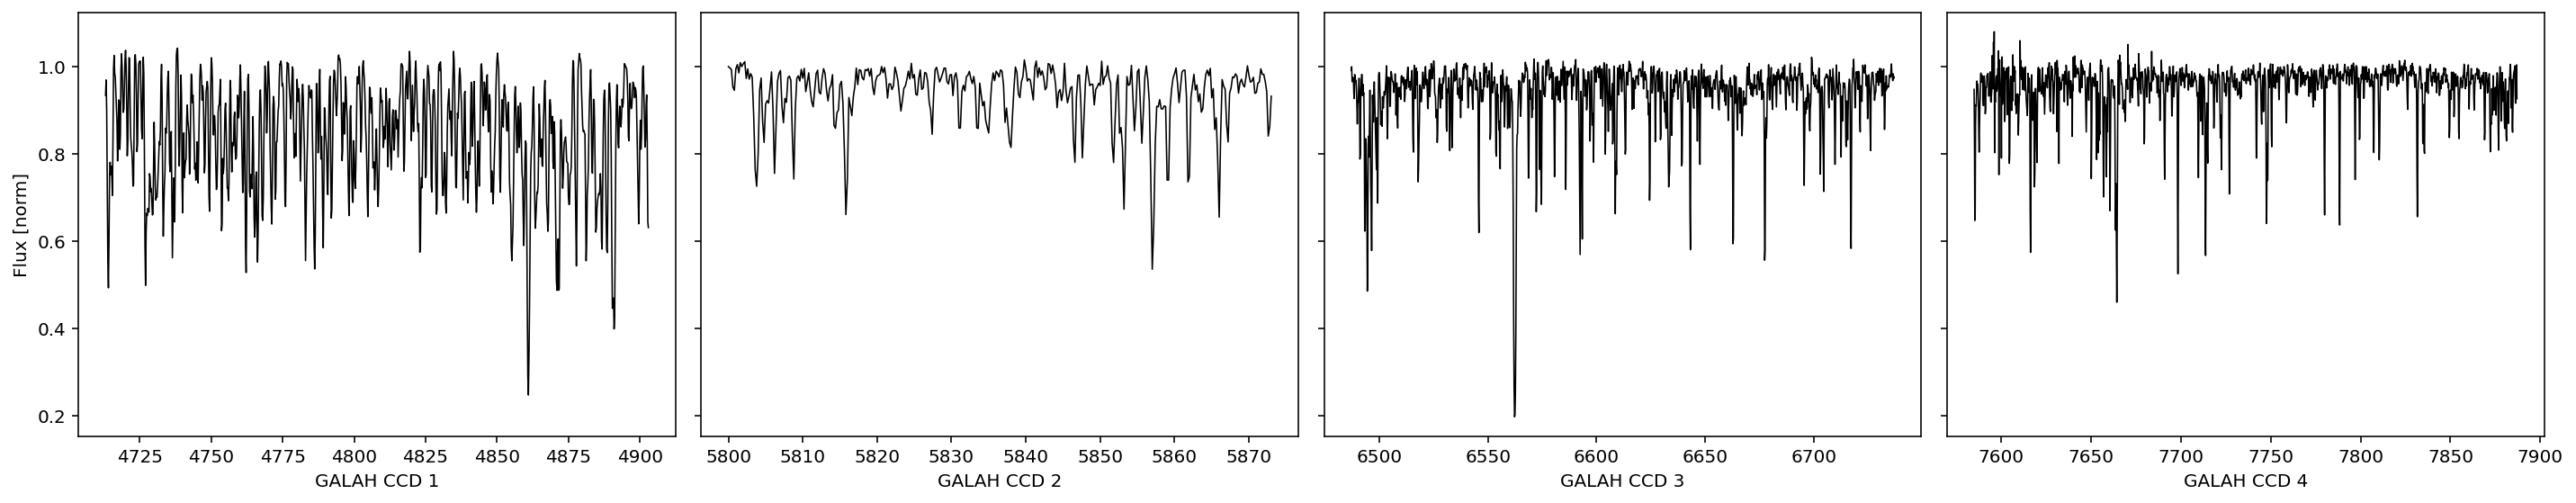

In [514]:
# plot equivalent galah regions
galah = [(471.3,490.3),(564.8,587.3),(648.7,673.7),(758.5,788.7)]

fig, ax = plt.subplots(1,4,figsize=(20,4),sharey=True)

for i in range(4):
    in_wavelength_range = (wave >= galah[i][0]) & (wave <= galah[i][1])
    ax[i].plot(wave[in_wavelength_range]*10,flux[0][in_wavelength_range],
              lw=0.8,c='k')
    ax[i].set_xlabel(f'GALAH CCD {i+1}')
    
    if i == 0:
        ax[i].set_ylabel('Flux [norm]')
    
plt.tight_layout()

### Setting up, Training, and Testing The Cannon

In [515]:
# We can use a linear, quadratic, etc. model. A quadratic one has order 2
order = 2

model_file = 'xshooter_model_order'+str(order)+'_'+"_".join(labels)

# Now if we have already trained the Cannon, we can simply read in the existing Model
try:
    model = tc.CannonModel.read(model_file+'.model')
    print('Model already exists')
except:
    # There is no Cannon model available yet
    # Let's set up the Cannon model
    print('Setting up Cannon Model')
    model = tc.CannonModel(
        training_set_labels, flux, ivar,
        vectorizer=tc.vectorizer.PolynomialVectorizer(labels, order),dispersion=wave)
    
# model = tc.CannonModel(
#             training_set_labels, flux, ivar,
#             vectorizer=tc.vectorizer.PolynomialVectorizer(labels, order),dispersion=wave)

Model already exists


In [518]:
# This is where the magic happens! We train the Cannon (if it is not yet trained)!

# This will start with several "red" messages. 
# A common warning is "Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH"
# Don't panic - that just means it will take a different optimisation algorithm than the default one.

if not model.is_trained:
    print('Training The Cannon')
    theta, s2, train_metadata = model.train(threads=1)
    
    # Save the result
    model.write(model_file+'.model', overwrite=True, include_training_set_spectra=True)
else:
    print('The Cannon is already trained')
    
# Now let's run the Cannon on its own training set to estimate labels and uncertainties
print('Testing The Cannon')
test_labels, cov, test_metadata = model.test(flux, ivar)

2022-02-21 11:33:21,716 [INFO] Training 5-label CannonModel with 49 stars and 48093 pixels/star
2022-02-21 11:33:21,745 [DEBUG] Couldn't get screen size. Progressbar may look odd.


Training The Cannon
[                                                                                                    ]   0% (5/48093)                          

2022-02-21 11:33:21,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[                                                                                                    ]   1% (394/48093)                          

2022-02-21 11:33:30,154 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[                                                                                                    ]   1% (443/48093)                          

2022-02-21 11:33:31,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[                                                                                                    ]   1% (448/48093)                          

2022-02-21 11:33:31,575 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=                                                                                                   ]   1% (566/48093)                          

2022-02-21 11:33:34,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=                                                                                                   ]   2% (740/48093)                          

2022-02-21 11:33:37,795 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=                                                                                                   ]   2% (752/48093)                          

2022-02-21 11:33:38,046 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=                                                                                                   ]   2% (941/48093)                          

2022-02-21 11:33:42,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=                                                                                                   ]   2% (943/48093)                          

2022-02-21 11:33:42,118 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==                                                                                                  ]   2% (1015/48093)                          

2022-02-21 11:33:43,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==                                                                                                  ]   2% (1079/48093)                          

2022-02-21 11:33:45,129 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==                                                                                                  ]   2% (1168/48093)                          

2022-02-21 11:33:47,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==                                                                                                  ]   3% (1297/48093)                          

2022-02-21 11:33:49,984 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==                                                                                                  ]   3% (1374/48093)                          

2022-02-21 11:33:51,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==                                                                                                  ]   3% (1430/48093)                          

2022-02-21 11:33:52,879 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===                                                                                                 ]   3% (1571/48093)                          

2022-02-21 11:33:56,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===                                                                                                 ]   3% (1621/48093)                          

2022-02-21 11:33:57,133 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===                                                                                                 ]   4% (1779/48093)                          

2022-02-21 11:34:00,337 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===                                                                                                 ]   4% (1823/48093)                          

2022-02-21 11:34:01,332 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===                                                                                                 ]   4% (1877/48093)                          

2022-02-21 11:34:02,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===                                                                                                 ]   4% (1879/48093)                          

2022-02-21 11:34:02,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===                                                                                                 ]   4% (1901/48093)                          

2022-02-21 11:34:02,979 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   4% (1936/48093)                          

2022-02-21 11:34:03,759 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   4% (2076/48093)                          

2022-02-21 11:34:06,530 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   4% (2138/48093)                          

2022-02-21 11:34:07,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   4% (2146/48093)                          

2022-02-21 11:34:07,920 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   5% (2246/48093)                          

2022-02-21 11:34:09,862 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   5% (2312/48093)                          

2022-02-21 11:34:11,095 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   5% (2313/48093)                          

2022-02-21 11:34:11,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   5% (2347/48093)                          

2022-02-21 11:34:11,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   5% (2396/48093)                          

2022-02-21 11:34:12,878 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====                                                                                                ]   5% (2397/48093)                          

2022-02-21 11:34:12,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   5% (2461/48093; ~16m until finished)     

2022-02-21 11:34:14,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   5% (2492/48093; ~16m until finished)

2022-02-21 11:34:15,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   5% (2571/48093; ~16m until finished)

2022-02-21 11:34:17,409 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   5% (2595/48093; ~16m until finished)

2022-02-21 11:34:18,111 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   5% (2627/48093; ~16m until finished)

2022-02-21 11:34:18,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   5% (2633/48093; ~17m until finished)

2022-02-21 11:34:19,124 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   5% (2637/48093; ~17m until finished)

2022-02-21 11:34:19,267 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   6% (2764/48093; ~17m until finished)

2022-02-21 11:34:22,674 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====                                                                                               ]   6% (2815/48093; ~17m until finished)

2022-02-21 11:34:24,024 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   6% (2890/48093; ~17m until finished)

2022-02-21 11:34:27,149 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   6% (2912/48093; ~17m until finished)

2022-02-21 11:34:27,972 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   6% (2963/48093; ~17m until finished)

2022-02-21 11:34:29,823 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   6% (2983/48093; ~17m until finished)

2022-02-21 11:34:30,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   6% (3071/48093; ~17m until finished)

2022-02-21 11:34:33,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   7% (3179/48093; ~18m until finished)

2022-02-21 11:34:36,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   7% (3221/48093; ~18m until finished)

2022-02-21 11:34:38,242 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   7% (3232/48093; ~18m until finished)

2022-02-21 11:34:38,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   7% (3273/48093; ~18m until finished)

2022-02-21 11:34:40,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======                                                                                              ]   7% (3314/48093; ~18m until finished)

2022-02-21 11:34:41,401 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======                                                                                             ]   7% (3492/48093; ~18m until finished)

2022-02-21 11:34:47,901 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======                                                                                             ]   8% (3643/48093; ~19m until finished)

2022-02-21 11:34:55,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======                                                                                             ]   8% (3658/48093; ~19m until finished)

2022-02-21 11:34:55,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======                                                                                             ]   8% (3692/48093; ~19m until finished)

2022-02-21 11:34:57,040 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======                                                                                             ]   8% (3816/48093; ~19m until finished)

2022-02-21 11:35:02,159 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   8% (3982/48093; ~20m until finished)

2022-02-21 11:35:09,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   8% (3984/48093; ~20m until finished)

2022-02-21 11:35:09,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   8% (4026/48093; ~20m until finished)

2022-02-21 11:35:10,874 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   8% (4031/48093; ~20m until finished)

2022-02-21 11:35:11,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   8% (4051/48093; ~20m until finished)

2022-02-21 11:35:11,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   9% (4122/48093; ~20m until finished)

2022-02-21 11:35:14,091 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   9% (4143/48093; ~20m until finished)

2022-02-21 11:35:14,854 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========                                                                                            ]   9% (4223/48093; ~20m until finished)

2022-02-21 11:35:17,275 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]   9% (4338/48093; ~20m until finished)

2022-02-21 11:35:20,522 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]   9% (4340/48093; ~20m until finished)

2022-02-21 11:35:20,586 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]   9% (4345/48093; ~20m until finished)

2022-02-21 11:35:20,754 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]   9% (4502/48093; ~20m until finished)

2022-02-21 11:35:25,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]   9% (4511/48093; ~20m until finished)

2022-02-21 11:35:25,335 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]  10% (4585/48093; ~20m until finished)

2022-02-21 11:35:27,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]  10% (4643/48093; ~20m until finished)

2022-02-21 11:35:28,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]  10% (4660/48093; ~20m until finished)

2022-02-21 11:35:29,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]  10% (4690/48093; ~20m until finished)

2022-02-21 11:35:30,093 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]  10% (4702/48093; ~20m until finished)

2022-02-21 11:35:30,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]  10% (4704/48093; ~20m until finished)

2022-02-21 11:35:30,477 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========                                                                                           ]  10% (4792/48093; ~20m until finished)

2022-02-21 11:35:32,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  10% (4845/48093; ~20m until finished)

2022-02-21 11:35:33,940 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  10% (4877/48093; ~20m until finished)

2022-02-21 11:35:34,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  10% (4954/48093; ~20m until finished)

2022-02-21 11:35:36,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  10% (5022/48093; ~20m until finished)

2022-02-21 11:35:38,195 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  10% (5024/48093; ~20m until finished)

2022-02-21 11:35:38,266 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5096/48093; ~19m until finished)

2022-02-21 11:35:40,142 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5100/48093; ~19m until finished)

2022-02-21 11:35:40,256 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5141/48093; ~19m until finished)

2022-02-21 11:35:41,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5149/48093; ~19m until finished)

2022-02-21 11:35:41,447 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5185/48093; ~19m until finished)

2022-02-21 11:35:42,508 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5190/48093; ~19m until finished)

2022-02-21 11:35:42,653 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5201/48093; ~19m until finished)

2022-02-21 11:35:42,906 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5203/48093; ~19m until finished)

2022-02-21 11:35:42,970 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========                                                                                          ]  11% (5204/48093; ~19m until finished)

2022-02-21 11:35:43,015 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5314/48093; ~19m until finished)

2022-02-21 11:35:45,411 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5317/48093; ~19m until finished)

2022-02-21 11:35:45,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5339/48093; ~19m until finished)

2022-02-21 11:35:46,007 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5374/48093; ~19m until finished)

2022-02-21 11:35:46,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5394/48093; ~19m until finished)

2022-02-21 11:35:47,166 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5424/48093; ~19m until finished)

2022-02-21 11:35:47,911 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5438/48093; ~19m until finished)

2022-02-21 11:35:48,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5439/48093; ~19m until finished)

2022-02-21 11:35:48,279 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5456/48093; ~19m until finished)

2022-02-21 11:35:48,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5458/48093; ~19m until finished)

2022-02-21 11:35:48,714 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  11% (5459/48093; ~19m until finished)

2022-02-21 11:35:48,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5538/48093; ~19m until finished)

2022-02-21 11:35:50,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5621/48093; ~19m until finished)

2022-02-21 11:35:52,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5636/48093; ~19m until finished)

2022-02-21 11:35:52,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5638/48093; ~19m until finished)

2022-02-21 11:35:52,640 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5639/48093; ~19m until finished)

2022-02-21 11:35:52,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5655/48093; ~19m until finished)

2022-02-21 11:35:53,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5656/48093; ~19m until finished)

2022-02-21 11:35:53,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5709/48093; ~19m until finished)

2022-02-21 11:35:54,208 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5715/48093; ~19m until finished)

2022-02-21 11:35:54,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5720/48093; ~19m until finished)

2022-02-21 11:35:54,488 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========                                                                                         ]  12% (5744/48093; ~19m until finished)

2022-02-21 11:35:55,038 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (5760/48093; ~19m until finished)

2022-02-21 11:35:55,460 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (5778/48093; ~19m until finished)

2022-02-21 11:35:55,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (5802/48093; ~19m until finished)

2022-02-21 11:35:56,581 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (5807/48093; ~19m until finished)

2022-02-21 11:35:56,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (5841/48093; ~19m until finished)

2022-02-21 11:35:57,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (5882/48093; ~19m until finished)

2022-02-21 11:35:58,584 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (5910/48093; ~19m until finished)

2022-02-21 11:35:59,223 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  12% (6007/48093; ~19m until finished)

2022-02-21 11:36:01,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  13% (6033/48093; ~19m until finished)

2022-02-21 11:36:01,937 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  13% (6133/48093; ~19m until finished)

2022-02-21 11:36:04,254 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  13% (6143/48093; ~19m until finished)

2022-02-21 11:36:04,483 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  13% (6173/48093; ~18m until finished)

2022-02-21 11:36:05,166 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  13% (6207/48093; ~18m until finished)

2022-02-21 11:36:05,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  13% (6221/48093; ~18m until finished)

2022-02-21 11:36:06,276 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============                                                                                        ]  13% (6234/48093; ~18m until finished)

2022-02-21 11:36:06,562 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6249/48093; ~18m until finished)

2022-02-21 11:36:06,933 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6263/48093; ~18m until finished)

2022-02-21 11:36:07,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6269/48093; ~18m until finished)

2022-02-21 11:36:07,386 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6276/48093; ~18m until finished)

2022-02-21 11:36:07,569 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6289/48093; ~18m until finished)

2022-02-21 11:36:07,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6310/48093; ~18m until finished)

2022-02-21 11:36:08,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6326/48093; ~18m until finished)

2022-02-21 11:36:08,705 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6333/48093; ~18m until finished)

2022-02-21 11:36:08,879 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6341/48093; ~18m until finished)

2022-02-21 11:36:09,084 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6368/48093; ~18m until finished)

2022-02-21 11:36:09,672 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6389/48093; ~18m until finished)

2022-02-21 11:36:10,153 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6394/48093; ~18m until finished)

2022-02-21 11:36:10,287 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6396/48093; ~18m until finished)

2022-02-21 11:36:10,338 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6412/48093; ~18m until finished)

2022-02-21 11:36:10,698 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6420/48093; ~18m until finished)

2022-02-21 11:36:10,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6451/48093; ~18m until finished)

2022-02-21 11:36:11,724 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  13% (6479/48093; ~18m until finished)

2022-02-21 11:36:12,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6509/48093; ~18m until finished)

2022-02-21 11:36:13,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6516/48093; ~18m until finished)

2022-02-21 11:36:13,262 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6556/48093; ~18m until finished)

2022-02-21 11:36:14,131 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6567/48093; ~18m until finished)

2022-02-21 11:36:14,383 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6580/48093; ~18m until finished)

2022-02-21 11:36:14,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6587/48093; ~18m until finished)

2022-02-21 11:36:14,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6634/48093; ~18m until finished)

2022-02-21 11:36:15,857 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6635/48093; ~18m until finished)

2022-02-21 11:36:15,889 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6645/48093; ~18m until finished)

2022-02-21 11:36:16,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6646/48093; ~18m until finished)

2022-02-21 11:36:16,183 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6651/48093; ~18m until finished)

2022-02-21 11:36:16,303 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6653/48093; ~18m until finished)

2022-02-21 11:36:16,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6657/48093; ~18m until finished)

2022-02-21 11:36:16,463 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6687/48093; ~18m until finished)

2022-02-21 11:36:17,145 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6702/48093; ~18m until finished)

2022-02-21 11:36:17,495 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6711/48093; ~18m until finished)

2022-02-21 11:36:17,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============                                                                                       ]  14% (6713/48093; ~18m until finished)

2022-02-21 11:36:17,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6726/48093; ~18m until finished)

2022-02-21 11:36:18,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6735/48093; ~18m until finished)

2022-02-21 11:36:18,382 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6739/48093; ~18m until finished)

2022-02-21 11:36:18,488 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6740/48093; ~18m until finished)

2022-02-21 11:36:18,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6746/48093; ~18m until finished)

2022-02-21 11:36:18,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6749/48093; ~18m until finished)

2022-02-21 11:36:18,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6802/48093; ~18m until finished)

2022-02-21 11:36:20,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6833/48093; ~18m until finished)

2022-02-21 11:36:20,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6863/48093; ~18m until finished)

2022-02-21 11:36:21,495 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6881/48093; ~18m until finished)

2022-02-21 11:36:21,982 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6895/48093; ~18m until finished)

2022-02-21 11:36:22,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6917/48093; ~18m until finished)

2022-02-21 11:36:22,850 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6930/48093; ~18m until finished)

2022-02-21 11:36:23,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  14% (6966/48093; ~18m until finished)

2022-02-21 11:36:23,987 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  15% (6976/48093; ~18m until finished)

2022-02-21 11:36:24,243 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  15% (6997/48093; ~18m until finished)

2022-02-21 11:36:24,763 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  15% (7007/48093; ~18m until finished)

2022-02-21 11:36:25,007 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  15% (7158/48093; ~18m until finished)

2022-02-21 11:36:29,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============                                                                                      ]  15% (7164/48093; ~18m until finished)

2022-02-21 11:36:29,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7200/48093; ~18m until finished)

2022-02-21 11:36:30,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7237/48093; ~18m until finished)

2022-02-21 11:36:31,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7255/48093; ~18m until finished)

2022-02-21 11:36:32,046 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7272/48093; ~18m until finished)

2022-02-21 11:36:32,479 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7302/48093; ~18m until finished)

2022-02-21 11:36:33,266 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7345/48093; ~18m until finished)

2022-02-21 11:36:34,360 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7410/48093; ~18m until finished)

2022-02-21 11:36:35,998 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7437/48093; ~18m until finished)

2022-02-21 11:36:36,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7442/48093; ~18m until finished)

2022-02-21 11:36:36,796 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  15% (7446/48093; ~18m until finished)

2022-02-21 11:36:36,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7483/48093; ~18m until finished)

2022-02-21 11:36:37,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7500/48093; ~18m until finished)

2022-02-21 11:36:38,254 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7503/48093; ~18m until finished)

2022-02-21 11:36:38,343 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7519/48093; ~18m until finished)

2022-02-21 11:36:38,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7556/48093; ~18m until finished)

2022-02-21 11:36:39,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7599/48093; ~18m until finished)

2022-02-21 11:36:40,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7613/48093; ~18m until finished)

2022-02-21 11:36:41,059 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7617/48093; ~18m until finished)

2022-02-21 11:36:41,161 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7621/48093; ~18m until finished)

2022-02-21 11:36:41,284 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7623/48093; ~18m until finished)

2022-02-21 11:36:41,344 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7628/48093; ~18m until finished)

2022-02-21 11:36:41,475 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============                                                                                     ]  16% (7656/48093; ~18m until finished)

2022-02-21 11:36:42,125 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7713/48093; ~18m until finished)

2022-02-21 11:36:43,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7728/48093; ~18m until finished)

2022-02-21 11:36:44,019 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7737/48093; ~18m until finished)

2022-02-21 11:36:44,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7745/48093; ~18m until finished)

2022-02-21 11:36:44,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7747/48093; ~18m until finished)

2022-02-21 11:36:44,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7750/48093; ~18m until finished)

2022-02-21 11:36:44,627 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7760/48093; ~18m until finished)

2022-02-21 11:36:44,876 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7763/48093; ~18m until finished)

2022-02-21 11:36:44,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7885/48093; ~18m until finished)

2022-02-21 11:36:48,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7888/48093; ~18m until finished)

2022-02-21 11:36:48,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7895/48093; ~18m until finished)

2022-02-21 11:36:48,303 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  16% (7931/48093; ~18m until finished)

2022-02-21 11:36:49,174 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  17% (7962/48093; ~17m until finished)

2022-02-21 11:36:49,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  17% (8037/48093; ~17m until finished)

2022-02-21 11:36:51,519 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  17% (8042/48093; ~17m until finished)

2022-02-21 11:36:51,652 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  17% (8052/48093; ~17m until finished)

2022-02-21 11:36:51,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  17% (8143/48093; ~17m until finished)

2022-02-21 11:36:53,961 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================                                                                                    ]  17% (8147/48093; ~17m until finished)

2022-02-21 11:36:54,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8225/48093; ~17m until finished)

2022-02-21 11:36:56,001 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8229/48093; ~17m until finished)

2022-02-21 11:36:56,107 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8269/48093; ~17m until finished)

2022-02-21 11:36:57,065 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8284/48093; ~17m until finished)

2022-02-21 11:36:57,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8316/48093; ~17m until finished)

2022-02-21 11:36:58,106 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8340/48093; ~17m until finished)

2022-02-21 11:36:58,711 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8341/48093; ~17m until finished)

2022-02-21 11:36:58,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8346/48093; ~17m until finished)

2022-02-21 11:36:58,894 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8360/48093; ~17m until finished)

2022-02-21 11:36:59,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8404/48093; ~17m until finished)

2022-02-21 11:37:00,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  17% (8407/48093; ~17m until finished)

2022-02-21 11:37:00,373 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8455/48093; ~17m until finished)

2022-02-21 11:37:01,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8457/48093; ~17m until finished)

2022-02-21 11:37:01,495 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8543/48093; ~17m until finished)

2022-02-21 11:37:03,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8544/48093; ~17m until finished)

2022-02-21 11:37:03,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8549/48093; ~17m until finished)

2022-02-21 11:37:03,501 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8552/48093; ~17m until finished)

2022-02-21 11:37:03,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8570/48093; ~17m until finished)

2022-02-21 11:37:04,002 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8610/48093; ~17m until finished)

2022-02-21 11:37:04,885 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8616/48093; ~17m until finished)

2022-02-21 11:37:05,036 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================                                                                                   ]  18% (8634/48093; ~17m until finished)

2022-02-21 11:37:05,475 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8663/48093; ~17m until finished)

2022-02-21 11:37:06,285 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8674/48093; ~17m until finished)

2022-02-21 11:37:06,580 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8677/48093; ~17m until finished)

2022-02-21 11:37:06,662 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8683/48093; ~17m until finished)

2022-02-21 11:37:06,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8686/48093; ~17m until finished)

2022-02-21 11:37:06,893 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8699/48093; ~17m until finished)

2022-02-21 11:37:07,204 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8706/48093; ~17m until finished)

2022-02-21 11:37:07,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8708/48093; ~17m until finished)

2022-02-21 11:37:07,441 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8709/48093; ~17m until finished)

2022-02-21 11:37:07,482 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8746/48093; ~17m until finished)

2022-02-21 11:37:08,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8749/48093; ~17m until finished)

2022-02-21 11:37:08,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8750/48093; ~17m until finished)

2022-02-21 11:37:08,477 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8809/48093; ~17m until finished)

2022-02-21 11:37:09,795 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8823/48093; ~17m until finished)

2022-02-21 11:37:10,112 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8852/48093; ~17m until finished)

2022-02-21 11:37:10,813 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  18% (8870/48093; ~17m until finished)

2022-02-21 11:37:11,225 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8910/48093; ~17m until finished)

2022-02-21 11:37:12,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8913/48093; ~17m until finished)

2022-02-21 11:37:12,212 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8925/48093; ~17m until finished)

2022-02-21 11:37:12,511 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8932/48093; ~17m until finished)

2022-02-21 11:37:12,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8937/48093; ~17m until finished)

2022-02-21 11:37:12,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8938/48093; ~17m until finished)

2022-02-21 11:37:12,862 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8944/48093; ~17m until finished)

2022-02-21 11:37:13,045 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8948/48093; ~17m until finished)

2022-02-21 11:37:13,158 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (8987/48093; ~17m until finished)

2022-02-21 11:37:14,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9032/48093; ~17m until finished)

2022-02-21 11:37:15,219 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9035/48093; ~17m until finished)

2022-02-21 11:37:15,298 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9037/48093; ~17m until finished)

2022-02-21 11:37:15,379 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9039/48093; ~17m until finished)

2022-02-21 11:37:15,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9053/48093; ~17m until finished)

2022-02-21 11:37:15,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9082/48093; ~17m until finished)

2022-02-21 11:37:16,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9086/48093; ~17m until finished)

2022-02-21 11:37:16,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================                                                                                  ]  19% (9093/48093; ~17m until finished)

2022-02-21 11:37:16,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9164/48093; ~17m until finished)

2022-02-21 11:37:18,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9170/48093; ~17m until finished)

2022-02-21 11:37:18,705 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9174/48093; ~17m until finished)

2022-02-21 11:37:18,828 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9204/48093; ~17m until finished)

2022-02-21 11:37:19,567 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9221/48093; ~17m until finished)

2022-02-21 11:37:19,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9234/48093; ~17m until finished)

2022-02-21 11:37:20,283 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9236/48093; ~17m until finished)

2022-02-21 11:37:20,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9239/48093; ~17m until finished)

2022-02-21 11:37:20,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9252/48093; ~17m until finished)

2022-02-21 11:37:20,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9255/48093; ~17m until finished)

2022-02-21 11:37:20,875 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9256/48093; ~17m until finished)

2022-02-21 11:37:20,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9257/48093; ~17m until finished)

2022-02-21 11:37:20,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9282/48093; ~17m until finished)

2022-02-21 11:37:21,573 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9287/48093; ~17m until finished)

2022-02-21 11:37:21,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9292/48093; ~17m until finished)

2022-02-21 11:37:21,846 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9309/48093; ~17m until finished)

2022-02-21 11:37:22,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9311/48093; ~17m until finished)

2022-02-21 11:37:22,377 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9312/48093; ~17m until finished)

2022-02-21 11:37:22,430 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9332/48093; ~17m until finished)

2022-02-21 11:37:22,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9337/48093; ~17m until finished)

2022-02-21 11:37:23,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9342/48093; ~17m until finished)

2022-02-21 11:37:23,281 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9359/48093; ~17m until finished)

2022-02-21 11:37:23,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9364/48093; ~17m until finished)

2022-02-21 11:37:23,881 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9367/48093; ~17m until finished)

2022-02-21 11:37:23,978 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9369/48093; ~17m until finished)

2022-02-21 11:37:24,051 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9372/48093; ~17m until finished)

2022-02-21 11:37:24,173 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  19% (9377/48093; ~17m until finished)

2022-02-21 11:37:24,310 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9379/48093; ~17m until finished)

2022-02-21 11:37:24,389 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9384/48093; ~17m until finished)

2022-02-21 11:37:24,549 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9386/48093; ~17m until finished)

2022-02-21 11:37:24,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9400/48093; ~17m until finished)

2022-02-21 11:37:24,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9405/48093; ~17m until finished)

2022-02-21 11:37:25,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9413/48093; ~17m until finished)

2022-02-21 11:37:25,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9426/48093; ~17m until finished)

2022-02-21 11:37:25,646 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9436/48093; ~17m until finished)

2022-02-21 11:37:25,900 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9477/48093; ~17m until finished)

2022-02-21 11:37:26,926 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9481/48093; ~17m until finished)

2022-02-21 11:37:27,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9485/48093; ~17m until finished)

2022-02-21 11:37:27,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9502/48093; ~17m until finished)

2022-02-21 11:37:27,629 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9504/48093; ~17m until finished)

2022-02-21 11:37:27,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9506/48093; ~17m until finished)

2022-02-21 11:37:27,770 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9510/48093; ~17m until finished)

2022-02-21 11:37:27,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9515/48093; ~17m until finished)

2022-02-21 11:37:28,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9518/48093; ~17m until finished)

2022-02-21 11:37:28,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9535/48093; ~17m until finished)

2022-02-21 11:37:28,567 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9537/48093; ~17m until finished)

2022-02-21 11:37:28,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9547/48093; ~17m until finished)

2022-02-21 11:37:28,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9552/48093; ~17m until finished)

2022-02-21 11:37:29,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9563/48093; ~17m until finished)

2022-02-21 11:37:29,367 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9571/48093; ~17m until finished)

2022-02-21 11:37:29,588 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9580/48093; ~17m until finished)

2022-02-21 11:37:29,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9590/48093; ~17m until finished)

2022-02-21 11:37:30,119 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9591/48093; ~17m until finished)

2022-02-21 11:37:30,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================                                                                                 ]  20% (9597/48093; ~17m until finished)

2022-02-21 11:37:30,327 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9664/48093; ~17m until finished)

2022-02-21 11:37:32,415 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9665/48093; ~17m until finished)

2022-02-21 11:37:32,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9672/48093; ~17m until finished)

2022-02-21 11:37:32,699 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9690/48093; ~17m until finished)

2022-02-21 11:37:33,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9694/48093; ~17m until finished)

2022-02-21 11:37:33,388 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9701/48093; ~17m until finished)

2022-02-21 11:37:33,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9715/48093; ~17m until finished)

2022-02-21 11:37:33,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9718/48093; ~17m until finished)

2022-02-21 11:37:34,045 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9737/48093; ~17m until finished)

2022-02-21 11:37:34,602 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9762/48093; ~17m until finished)

2022-02-21 11:37:35,378 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9773/48093; ~17m until finished)

2022-02-21 11:37:35,696 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9774/48093; ~17m until finished)

2022-02-21 11:37:35,745 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9777/48093; ~17m until finished)

2022-02-21 11:37:35,856 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9778/48093; ~17m until finished)

2022-02-21 11:37:35,908 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9779/48093; ~17m until finished)

2022-02-21 11:37:35,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9791/48093; ~17m until finished)

2022-02-21 11:37:36,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9819/48093; ~17m until finished)

2022-02-21 11:37:37,143 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9823/48093; ~17m until finished)

2022-02-21 11:37:37,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9840/48093; ~17m until finished)

2022-02-21 11:37:37,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9841/48093; ~17m until finished)

2022-02-21 11:37:37,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  20% (9857/48093; ~17m until finished)

2022-02-21 11:37:38,112 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9880/48093; ~17m until finished)

2022-02-21 11:37:38,713 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9888/48093; ~17m until finished)

2022-02-21 11:37:38,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9890/48093; ~17m until finished)

2022-02-21 11:37:38,974 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9912/48093; ~17m until finished)

2022-02-21 11:37:39,561 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9920/48093; ~17m until finished)

2022-02-21 11:37:39,770 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9933/48093; ~17m until finished)

2022-02-21 11:37:40,158 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9934/48093; ~17m until finished)

2022-02-21 11:37:40,206 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9955/48093; ~17m until finished)

2022-02-21 11:37:40,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9963/48093; ~17m until finished)

2022-02-21 11:37:41,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9970/48093; ~17m until finished)

2022-02-21 11:37:41,207 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9975/48093; ~17m until finished)

2022-02-21 11:37:41,353 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9977/48093; ~17m until finished)

2022-02-21 11:37:41,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9980/48093; ~17m until finished)

2022-02-21 11:37:41,507 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9983/48093; ~17m until finished)

2022-02-21 11:37:41,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9984/48093; ~17m until finished)

2022-02-21 11:37:41,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (9999/48093; ~17m until finished)

2022-02-21 11:37:42,018 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (10012/48093; ~17m until finished)

2022-02-21 11:37:42,340 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (10013/48093; ~17m until finished)

2022-02-21 11:37:42,391 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (10016/48093; ~17m until finished)

2022-02-21 11:37:42,471 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (10051/48093; ~16m until finished)

2022-02-21 11:37:43,325 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (10053/48093; ~16m until finished)

2022-02-21 11:37:43,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================                                                                                ]  21% (10071/48093; ~16m until finished)

2022-02-21 11:37:43,805 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10102/48093; ~16m until finished)

2022-02-21 11:37:44,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10111/48093; ~16m until finished)

2022-02-21 11:37:44,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10119/48093; ~16m until finished)

2022-02-21 11:37:45,061 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10129/48093; ~16m until finished)

2022-02-21 11:37:45,333 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10154/48093; ~16m until finished)

2022-02-21 11:37:46,049 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10157/48093; ~16m until finished)

2022-02-21 11:37:46,148 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10164/48093; ~16m until finished)

2022-02-21 11:37:46,333 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10188/48093; ~16m until finished)

2022-02-21 11:37:46,914 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10210/48093; ~16m until finished)

2022-02-21 11:37:47,530 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10296/48093; ~16m until finished)

2022-02-21 11:37:49,579 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10300/48093; ~16m until finished)

2022-02-21 11:37:49,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10301/48093; ~16m until finished)

2022-02-21 11:37:49,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10316/48093; ~16m until finished)

2022-02-21 11:37:50,054 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10323/48093; ~16m until finished)

2022-02-21 11:37:50,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10328/48093; ~16m until finished)

2022-02-21 11:37:50,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10337/48093; ~16m until finished)

2022-02-21 11:37:50,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  21% (10339/48093; ~16m until finished)

2022-02-21 11:37:50,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10344/48093; ~16m until finished)

2022-02-21 11:37:50,741 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10379/48093; ~16m until finished)

2022-02-21 11:37:51,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10380/48093; ~16m until finished)

2022-02-21 11:37:51,580 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10381/48093; ~16m until finished)

2022-02-21 11:37:51,611 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10382/48093; ~16m until finished)

2022-02-21 11:37:51,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10389/48093; ~16m until finished)

2022-02-21 11:37:51,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10393/48093; ~16m until finished)

2022-02-21 11:37:51,914 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10406/48093; ~16m until finished)

2022-02-21 11:37:52,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10411/48093; ~16m until finished)

2022-02-21 11:37:52,324 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10418/48093; ~16m until finished)

2022-02-21 11:37:52,508 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10450/48093; ~16m until finished)

2022-02-21 11:37:53,218 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10453/48093; ~16m until finished)

2022-02-21 11:37:53,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10454/48093; ~16m until finished)

2022-02-21 11:37:53,337 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10456/48093; ~16m until finished)

2022-02-21 11:37:53,409 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10462/48093; ~16m until finished)

2022-02-21 11:37:53,557 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10465/48093; ~16m until finished)

2022-02-21 11:37:53,636 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10466/48093; ~16m until finished)

2022-02-21 11:37:53,669 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10496/48093; ~16m until finished)

2022-02-21 11:37:54,397 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10499/48093; ~16m until finished)

2022-02-21 11:37:54,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10507/48093; ~16m until finished)

2022-02-21 11:37:54,665 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10509/48093; ~16m until finished)

2022-02-21 11:37:54,728 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10510/48093; ~16m until finished)

2022-02-21 11:37:54,760 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10519/48093; ~16m until finished)

2022-02-21 11:37:54,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10526/48093; ~16m until finished)

2022-02-21 11:37:55,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10528/48093; ~16m until finished)

2022-02-21 11:37:55,175 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10530/48093; ~16m until finished)

2022-02-21 11:37:55,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10531/48093; ~16m until finished)

2022-02-21 11:37:55,270 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10534/48093; ~16m until finished)

2022-02-21 11:37:55,351 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10536/48093; ~16m until finished)

2022-02-21 11:37:55,415 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10539/48093; ~16m until finished)

2022-02-21 11:37:55,485 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================                                                                               ]  22% (10541/48093; ~16m until finished)

2022-02-21 11:37:55,554 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10563/48093; ~16m until finished)

2022-02-21 11:37:56,059 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10584/48093; ~16m until finished)

2022-02-21 11:37:56,567 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10605/48093; ~16m until finished)

2022-02-21 11:37:57,019 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10636/48093; ~16m until finished)

2022-02-21 11:37:57,793 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10655/48093; ~16m until finished)

2022-02-21 11:37:58,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10658/48093; ~16m until finished)

2022-02-21 11:37:58,426 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10660/48093; ~16m until finished)

2022-02-21 11:37:58,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10707/48093; ~16m until finished)

2022-02-21 11:38:00,169 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10735/48093; ~16m until finished)

2022-02-21 11:38:01,067 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10745/48093; ~16m until finished)

2022-02-21 11:38:01,382 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10749/48093; ~16m until finished)

2022-02-21 11:38:01,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10752/48093; ~16m until finished)

2022-02-21 11:38:01,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10760/48093; ~16m until finished)

2022-02-21 11:38:01,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10778/48093; ~16m until finished)

2022-02-21 11:38:02,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10782/48093; ~16m until finished)

2022-02-21 11:38:02,483 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10804/48093; ~16m until finished)

2022-02-21 11:38:03,116 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  22% (10819/48093; ~16m until finished)

2022-02-21 11:38:03,566 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10821/48093; ~16m until finished)

2022-02-21 11:38:03,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10825/48093; ~16m until finished)

2022-02-21 11:38:03,799 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10855/48093; ~16m until finished)

2022-02-21 11:38:04,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10858/48093; ~16m until finished)

2022-02-21 11:38:04,624 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10862/48093; ~16m until finished)

2022-02-21 11:38:04,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10889/48093; ~16m until finished)

2022-02-21 11:38:05,467 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10914/48093; ~16m until finished)

2022-02-21 11:38:06,142 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10927/48093; ~16m until finished)

2022-02-21 11:38:06,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10976/48093; ~16m until finished)

2022-02-21 11:38:07,873 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10983/48093; ~16m until finished)

2022-02-21 11:38:08,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================                                                                              ]  23% (10997/48093; ~16m until finished)

2022-02-21 11:38:08,504 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11044/48093; ~16m until finished)

2022-02-21 11:38:09,684 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11068/48093; ~16m until finished)

2022-02-21 11:38:10,207 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11069/48093; ~16m until finished)

2022-02-21 11:38:10,248 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11079/48093; ~16m until finished)

2022-02-21 11:38:10,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11090/48093; ~16m until finished)

2022-02-21 11:38:10,733 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11104/48093; ~16m until finished)

2022-02-21 11:38:11,073 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11107/48093; ~16m until finished)

2022-02-21 11:38:11,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11126/48093; ~16m until finished)

2022-02-21 11:38:11,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11127/48093; ~16m until finished)

2022-02-21 11:38:11,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11129/48093; ~16m until finished)

2022-02-21 11:38:11,691 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11133/48093; ~16m until finished)

2022-02-21 11:38:11,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11146/48093; ~16m until finished)

2022-02-21 11:38:12,114 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11152/48093; ~16m until finished)

2022-02-21 11:38:12,263 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11162/48093; ~16m until finished)

2022-02-21 11:38:12,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11200/48093; ~16m until finished)

2022-02-21 11:38:13,298 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11211/48093; ~16m until finished)

2022-02-21 11:38:13,562 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11216/48093; ~16m until finished)

2022-02-21 11:38:13,689 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11217/48093; ~16m until finished)

2022-02-21 11:38:13,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11228/48093; ~16m until finished)

2022-02-21 11:38:14,005 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11270/48093; ~16m until finished)

2022-02-21 11:38:14,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  23% (11298/48093; ~16m until finished)

2022-02-21 11:38:15,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  24% (11331/48093; ~16m until finished)

2022-02-21 11:38:16,339 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  24% (11386/48093; ~16m until finished)

2022-02-21 11:38:17,589 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  24% (11405/48093; ~16m until finished)

2022-02-21 11:38:18,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  24% (11409/48093; ~16m until finished)

2022-02-21 11:38:18,148 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  24% (11443/48093; ~16m until finished)

2022-02-21 11:38:18,990 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  24% (11469/48093; ~16m until finished)

2022-02-21 11:38:19,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================                                                                             ]  24% (11495/48093; ~16m until finished)

2022-02-21 11:38:20,460 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11522/48093; ~16m until finished)

2022-02-21 11:38:21,110 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11537/48093; ~16m until finished)

2022-02-21 11:38:21,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11540/48093; ~16m until finished)

2022-02-21 11:38:21,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11556/48093; ~16m until finished)

2022-02-21 11:38:21,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11575/48093; ~16m until finished)

2022-02-21 11:38:22,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11585/48093; ~16m until finished)

2022-02-21 11:38:22,718 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11599/48093; ~16m until finished)

2022-02-21 11:38:23,076 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11600/48093; ~16m until finished)

2022-02-21 11:38:23,108 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11626/48093; ~16m until finished)

2022-02-21 11:38:23,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11633/48093; ~16m until finished)

2022-02-21 11:38:23,907 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11655/48093; ~16m until finished)

2022-02-21 11:38:24,466 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11695/48093; ~16m until finished)

2022-02-21 11:38:25,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11723/48093; ~16m until finished)

2022-02-21 11:38:26,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11740/48093; ~16m until finished)

2022-02-21 11:38:26,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  24% (11761/48093; ~16m until finished)

2022-02-21 11:38:27,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11810/48093; ~16m until finished)

2022-02-21 11:38:29,351 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11840/48093; ~16m until finished)

2022-02-21 11:38:30,337 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11854/48093; ~16m until finished)

2022-02-21 11:38:30,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11857/48093; ~16m until finished)

2022-02-21 11:38:30,958 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11861/48093; ~16m until finished)

2022-02-21 11:38:31,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11865/48093; ~16m until finished)

2022-02-21 11:38:31,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11890/48093; ~16m until finished)

2022-02-21 11:38:32,009 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11905/48093; ~16m until finished)

2022-02-21 11:38:32,446 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11910/48093; ~16m until finished)

2022-02-21 11:38:32,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11915/48093; ~16m until finished)

2022-02-21 11:38:32,801 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11916/48093; ~16m until finished)

2022-02-21 11:38:32,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11921/48093; ~16m until finished)

2022-02-21 11:38:33,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11925/48093; ~16m until finished)

2022-02-21 11:38:33,200 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11945/48093; ~16m until finished)

2022-02-21 11:38:33,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11950/48093; ~16m until finished)

2022-02-21 11:38:34,008 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================                                                                            ]  25% (11952/48093; ~16m until finished)

2022-02-21 11:38:34,091 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12000/48093; ~16m until finished)

2022-02-21 11:38:35,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12003/48093; ~16m until finished)

2022-02-21 11:38:35,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12006/48093; ~16m until finished)

2022-02-21 11:38:35,755 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12015/48093; ~16m until finished)

2022-02-21 11:38:36,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12023/48093; ~16m until finished)

2022-02-21 11:38:36,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12024/48093; ~16m until finished)

2022-02-21 11:38:36,429 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12049/48093; ~16m until finished)

2022-02-21 11:38:37,240 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12055/48093; ~16m until finished)

2022-02-21 11:38:37,403 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12089/48093; ~16m until finished)

2022-02-21 11:38:38,354 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12096/48093; ~16m until finished)

2022-02-21 11:38:38,587 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12117/48093; ~16m until finished)

2022-02-21 11:38:39,214 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12118/48093; ~16m until finished)

2022-02-21 11:38:39,260 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12119/48093; ~16m until finished)

2022-02-21 11:38:39,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12207/48093; ~16m until finished)

2022-02-21 11:38:41,816 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12208/48093; ~16m until finished)

2022-02-21 11:38:41,870 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12238/48093; ~16m until finished)

2022-02-21 11:38:42,667 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12243/48093; ~16m until finished)

2022-02-21 11:38:42,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  25% (12250/48093; ~16m until finished)

2022-02-21 11:38:43,011 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12269/48093; ~16m until finished)

2022-02-21 11:38:43,477 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12270/48093; ~16m until finished)

2022-02-21 11:38:43,510 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12281/48093; ~16m until finished)

2022-02-21 11:38:43,782 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12282/48093; ~16m until finished)

2022-02-21 11:38:43,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12288/48093; ~16m until finished)

2022-02-21 11:38:43,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12297/48093; ~16m until finished)

2022-02-21 11:38:44,201 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12299/48093; ~16m until finished)

2022-02-21 11:38:44,263 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12303/48093; ~16m until finished)

2022-02-21 11:38:44,374 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12304/48093; ~16m until finished)

2022-02-21 11:38:44,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12305/48093; ~16m until finished)

2022-02-21 11:38:44,446 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12313/48093; ~16m until finished)

2022-02-21 11:38:44,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12322/48093; ~16m until finished)

2022-02-21 11:38:44,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12334/48093; ~16m until finished)

2022-02-21 11:38:45,247 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12341/48093; ~16m until finished)

2022-02-21 11:38:45,429 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12346/48093; ~16m until finished)

2022-02-21 11:38:45,587 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12351/48093; ~16m until finished)

2022-02-21 11:38:45,755 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12364/48093; ~16m until finished)

2022-02-21 11:38:46,108 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12374/48093; ~16m until finished)

2022-02-21 11:38:46,353 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12406/48093; ~16m until finished)

2022-02-21 11:38:47,164 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12433/48093; ~16m until finished)

2022-02-21 11:38:47,811 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12436/48093; ~16m until finished)

2022-02-21 11:38:47,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12448/48093; ~16m until finished)

2022-02-21 11:38:48,234 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12451/48093; ~16m until finished)

2022-02-21 11:38:48,334 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12467/48093; ~16m until finished)

2022-02-21 11:38:48,714 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================                                                                           ]  26% (12469/48093; ~16m until finished)

2022-02-21 11:38:48,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12494/48093; ~16m until finished)

2022-02-21 11:38:49,367 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12499/48093; ~16m until finished)

2022-02-21 11:38:49,511 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12506/48093; ~16m until finished)

2022-02-21 11:38:49,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12507/48093; ~16m until finished)

2022-02-21 11:38:49,767 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12508/48093; ~16m until finished)

2022-02-21 11:38:49,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12577/48093; ~16m until finished)

2022-02-21 11:38:51,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12581/48093; ~16m until finished)

2022-02-21 11:38:51,657 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12593/48093; ~16m until finished)

2022-02-21 11:38:51,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12599/48093; ~16m until finished)

2022-02-21 11:38:52,174 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12602/48093; ~16m until finished)

2022-02-21 11:38:52,299 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12604/48093; ~16m until finished)

2022-02-21 11:38:52,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12621/48093; ~16m until finished)

2022-02-21 11:38:52,833 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12625/48093; ~16m until finished)

2022-02-21 11:38:52,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12634/48093; ~16m until finished)

2022-02-21 11:38:53,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12651/48093; ~16m until finished)

2022-02-21 11:38:53,741 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12673/48093; ~15m until finished)

2022-02-21 11:38:54,323 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12680/48093; ~15m until finished)

2022-02-21 11:38:54,480 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12685/48093; ~15m until finished)

2022-02-21 11:38:54,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12686/48093; ~15m until finished)

2022-02-21 11:38:54,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12689/48093; ~15m until finished)

2022-02-21 11:38:54,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12693/48093; ~15m until finished)

2022-02-21 11:38:54,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12697/48093; ~15m until finished)

2022-02-21 11:38:54,950 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12710/48093; ~15m until finished)

2022-02-21 11:38:55,246 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  26% (12723/48093; ~15m until finished)

2022-02-21 11:38:55,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12756/48093; ~15m until finished)

2022-02-21 11:38:56,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12758/48093; ~15m until finished)

2022-02-21 11:38:56,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12759/48093; ~15m until finished)

2022-02-21 11:38:56,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12762/48093; ~15m until finished)

2022-02-21 11:38:56,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12766/48093; ~15m until finished)

2022-02-21 11:38:56,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12769/48093; ~15m until finished)

2022-02-21 11:38:56,663 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12811/48093; ~15m until finished)

2022-02-21 11:38:57,630 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12819/48093; ~15m until finished)

2022-02-21 11:38:57,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12826/48093; ~15m until finished)

2022-02-21 11:38:57,999 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12846/48093; ~15m until finished)

2022-02-21 11:38:58,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12847/48093; ~15m until finished)

2022-02-21 11:38:58,479 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12852/48093; ~15m until finished)

2022-02-21 11:38:58,602 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12856/48093; ~15m until finished)

2022-02-21 11:38:58,728 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12866/48093; ~15m until finished)

2022-02-21 11:38:58,959 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12917/48093; ~15m until finished)

2022-02-21 11:39:00,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12944/48093; ~15m until finished)

2022-02-21 11:39:00,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12948/48093; ~15m until finished)

2022-02-21 11:39:00,778 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12951/48093; ~15m until finished)

2022-02-21 11:39:00,861 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12957/48093; ~15m until finished)

2022-02-21 11:39:00,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================                                                                          ]  27% (12959/48093; ~15m until finished)

2022-02-21 11:39:01,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (12962/48093; ~15m until finished)

2022-02-21 11:39:01,169 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (12965/48093; ~15m until finished)

2022-02-21 11:39:01,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (12978/48093; ~15m until finished)

2022-02-21 11:39:01,521 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (12981/48093; ~15m until finished)

2022-02-21 11:39:01,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (12989/48093; ~15m until finished)

2022-02-21 11:39:01,770 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13001/48093; ~15m until finished)

2022-02-21 11:39:02,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13018/48093; ~15m until finished)

2022-02-21 11:39:02,444 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13040/48093; ~15m until finished)

2022-02-21 11:39:02,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13062/48093; ~15m until finished)

2022-02-21 11:39:03,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13065/48093; ~15m until finished)

2022-02-21 11:39:03,461 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13069/48093; ~15m until finished)

2022-02-21 11:39:03,555 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13070/48093; ~15m until finished)

2022-02-21 11:39:03,589 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13071/48093; ~15m until finished)

2022-02-21 11:39:03,628 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13075/48093; ~15m until finished)

2022-02-21 11:39:03,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13077/48093; ~15m until finished)

2022-02-21 11:39:03,787 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13081/48093; ~15m until finished)

2022-02-21 11:39:03,908 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13091/48093; ~15m until finished)

2022-02-21 11:39:04,121 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13100/48093; ~15m until finished)

2022-02-21 11:39:04,338 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13104/48093; ~15m until finished)

2022-02-21 11:39:04,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13117/48093; ~15m until finished)

2022-02-21 11:39:04,769 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13122/48093; ~15m until finished)

2022-02-21 11:39:04,879 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13130/48093; ~15m until finished)

2022-02-21 11:39:05,076 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13138/48093; ~15m until finished)

2022-02-21 11:39:05,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13151/48093; ~15m until finished)

2022-02-21 11:39:05,537 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13153/48093; ~15m until finished)

2022-02-21 11:39:05,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13155/48093; ~15m until finished)

2022-02-21 11:39:05,676 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13157/48093; ~15m until finished)

2022-02-21 11:39:05,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13167/48093; ~15m until finished)

2022-02-21 11:39:05,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13172/48093; ~15m until finished)

2022-02-21 11:39:06,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13176/48093; ~15m until finished)

2022-02-21 11:39:06,186 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13194/48093; ~15m until finished)

2022-02-21 11:39:06,578 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13198/48093; ~15m until finished)

2022-02-21 11:39:06,678 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13205/48093; ~15m until finished)

2022-02-21 11:39:06,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  27% (13217/48093; ~15m until finished)

2022-02-21 11:39:07,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13253/48093; ~15m until finished)

2022-02-21 11:39:08,074 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13296/48093; ~15m until finished)

2022-02-21 11:39:09,024 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13311/48093; ~15m until finished)

2022-02-21 11:39:09,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13312/48093; ~15m until finished)

2022-02-21 11:39:09,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13320/48093; ~15m until finished)

2022-02-21 11:39:09,569 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13330/48093; ~15m until finished)

2022-02-21 11:39:09,811 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13337/48093; ~15m until finished)

2022-02-21 11:39:10,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13340/48093; ~15m until finished)

2022-02-21 11:39:10,094 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13357/48093; ~15m until finished)

2022-02-21 11:39:10,486 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13359/48093; ~15m until finished)

2022-02-21 11:39:10,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13390/48093; ~15m until finished)

2022-02-21 11:39:11,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13391/48093; ~15m until finished)

2022-02-21 11:39:11,243 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13394/48093; ~15m until finished)

2022-02-21 11:39:11,306 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13416/48093; ~15m until finished)

2022-02-21 11:39:11,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13419/48093; ~15m until finished)

2022-02-21 11:39:11,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13420/48093; ~15m until finished)

2022-02-21 11:39:11,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13423/48093; ~15m until finished)

2022-02-21 11:39:11,951 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================                                                                         ]  28% (13429/48093; ~15m until finished)

2022-02-21 11:39:12,093 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13460/48093; ~15m until finished)

2022-02-21 11:39:12,774 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13470/48093; ~15m until finished)

2022-02-21 11:39:13,008 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13473/48093; ~15m until finished)

2022-02-21 11:39:13,088 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13477/48093; ~15m until finished)

2022-02-21 11:39:13,184 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13488/48093; ~15m until finished)

2022-02-21 11:39:13,431 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13493/48093; ~15m until finished)

2022-02-21 11:39:13,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13501/48093; ~15m until finished)

2022-02-21 11:39:13,736 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13502/48093; ~15m until finished)

2022-02-21 11:39:13,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13509/48093; ~15m until finished)

2022-02-21 11:39:13,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13512/48093; ~15m until finished)

2022-02-21 11:39:14,011 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13514/48093; ~15m until finished)

2022-02-21 11:39:14,062 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13518/48093; ~15m until finished)

2022-02-21 11:39:14,173 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13522/48093; ~15m until finished)

2022-02-21 11:39:14,272 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13523/48093; ~15m until finished)

2022-02-21 11:39:14,304 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13525/48093; ~15m until finished)

2022-02-21 11:39:14,367 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13526/48093; ~15m until finished)

2022-02-21 11:39:14,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13534/48093; ~15m until finished)

2022-02-21 11:39:14,591 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13567/48093; ~15m until finished)

2022-02-21 11:39:15,288 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13569/48093; ~15m until finished)

2022-02-21 11:39:15,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13601/48093; ~15m until finished)

2022-02-21 11:39:16,027 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13605/48093; ~15m until finished)

2022-02-21 11:39:16,158 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13606/48093; ~15m until finished)

2022-02-21 11:39:16,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13612/48093; ~15m until finished)

2022-02-21 11:39:16,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13680/48093; ~15m until finished)

2022-02-21 11:39:17,863 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13682/48093; ~15m until finished)

2022-02-21 11:39:17,906 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13683/48093; ~15m until finished)

2022-02-21 11:39:17,958 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13691/48093; ~15m until finished)

2022-02-21 11:39:18,136 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13700/48093; ~15m until finished)

2022-02-21 11:39:18,353 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  28% (13702/48093; ~15m until finished)

2022-02-21 11:39:18,416 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13707/48093; ~15m until finished)

2022-02-21 11:39:18,549 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13714/48093; ~15m until finished)

2022-02-21 11:39:18,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13722/48093; ~15m until finished)

2022-02-21 11:39:18,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13731/48093; ~15m until finished)

2022-02-21 11:39:19,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13738/48093; ~15m until finished)

2022-02-21 11:39:19,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13743/48093; ~15m until finished)

2022-02-21 11:39:19,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13756/48093; ~15m until finished)

2022-02-21 11:39:19,734 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13791/48093; ~15m until finished)

2022-02-21 11:39:20,570 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13795/48093; ~15m until finished)

2022-02-21 11:39:20,684 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13798/48093; ~15m until finished)

2022-02-21 11:39:20,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13849/48093; ~15m until finished)

2022-02-21 11:39:21,961 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13850/48093; ~15m until finished)

2022-02-21 11:39:22,005 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13852/48093; ~15m until finished)

2022-02-21 11:39:22,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13854/48093; ~15m until finished)

2022-02-21 11:39:22,133 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13863/48093; ~15m until finished)

2022-02-21 11:39:22,377 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13866/48093; ~15m until finished)

2022-02-21 11:39:22,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13874/48093; ~15m until finished)

2022-02-21 11:39:22,669 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13875/48093; ~15m until finished)

2022-02-21 11:39:22,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13877/48093; ~15m until finished)

2022-02-21 11:39:22,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13879/48093; ~15m until finished)

2022-02-21 11:39:22,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13880/48093; ~15m until finished)

2022-02-21 11:39:22,894 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13882/48093; ~15m until finished)

2022-02-21 11:39:22,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13888/48093; ~15m until finished)

2022-02-21 11:39:23,136 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================                                                                        ]  29% (13919/48093; ~15m until finished)

2022-02-21 11:39:23,935 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13930/48093; ~15m until finished)

2022-02-21 11:39:24,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13942/48093; ~15m until finished)

2022-02-21 11:39:24,514 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13949/48093; ~15m until finished)

2022-02-21 11:39:24,718 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13958/48093; ~15m until finished)

2022-02-21 11:39:24,990 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13959/48093; ~15m until finished)

2022-02-21 11:39:25,031 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13960/48093; ~15m until finished)

2022-02-21 11:39:25,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13966/48093; ~15m until finished)

2022-02-21 11:39:25,221 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13969/48093; ~15m until finished)

2022-02-21 11:39:25,318 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13972/48093; ~15m until finished)

2022-02-21 11:39:25,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13997/48093; ~15m until finished)

2022-02-21 11:39:25,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (13998/48093; ~15m until finished)

2022-02-21 11:39:26,027 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14005/48093; ~15m until finished)

2022-02-21 11:39:26,196 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14006/48093; ~15m until finished)

2022-02-21 11:39:26,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14019/48093; ~15m until finished)

2022-02-21 11:39:26,529 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14020/48093; ~15m until finished)

2022-02-21 11:39:26,562 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14021/48093; ~15m until finished)

2022-02-21 11:39:26,602 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14048/48093; ~15m until finished)

2022-02-21 11:39:27,252 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14053/48093; ~15m until finished)

2022-02-21 11:39:27,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14073/48093; ~15m until finished)

2022-02-21 11:39:27,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14074/48093; ~15m until finished)

2022-02-21 11:39:27,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14082/48093; ~15m until finished)

2022-02-21 11:39:28,139 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14088/48093; ~15m until finished)

2022-02-21 11:39:28,299 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14089/48093; ~15m until finished)

2022-02-21 11:39:28,339 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14101/48093; ~15m until finished)

2022-02-21 11:39:28,620 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14107/48093; ~15m until finished)

2022-02-21 11:39:28,795 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14113/48093; ~15m until finished)

2022-02-21 11:39:28,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14120/48093; ~15m until finished)

2022-02-21 11:39:29,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14137/48093; ~15m until finished)

2022-02-21 11:39:29,553 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14152/48093; ~15m until finished)

2022-02-21 11:39:29,928 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14171/48093; ~15m until finished)

2022-02-21 11:39:30,377 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14176/48093; ~15m until finished)

2022-02-21 11:39:30,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  29% (14183/48093; ~15m until finished)

2022-02-21 11:39:30,697 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14188/48093; ~15m until finished)

2022-02-21 11:39:30,824 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14189/48093; ~15m until finished)

2022-02-21 11:39:30,871 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14191/48093; ~15m until finished)

2022-02-21 11:39:30,935 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14199/48093; ~15m until finished)

2022-02-21 11:39:31,130 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14211/48093; ~15m until finished)

2022-02-21 11:39:31,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14219/48093; ~15m until finished)

2022-02-21 11:39:31,619 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14220/48093; ~15m until finished)

2022-02-21 11:39:31,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14238/48093; ~15m until finished)

2022-02-21 11:39:32,117 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14250/48093; ~15m until finished)

2022-02-21 11:39:32,430 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14257/48093; ~15m until finished)

2022-02-21 11:39:32,602 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14268/48093; ~15m until finished)

2022-02-21 11:39:32,905 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14271/48093; ~15m until finished)

2022-02-21 11:39:33,016 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14291/48093; ~15m until finished)

2022-02-21 11:39:33,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14293/48093; ~15m until finished)

2022-02-21 11:39:33,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14297/48093; ~15m until finished)

2022-02-21 11:39:33,731 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14304/48093; ~15m until finished)

2022-02-21 11:39:33,906 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14310/48093; ~15m until finished)

2022-02-21 11:39:34,075 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14312/48093; ~15m until finished)

2022-02-21 11:39:34,152 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14318/48093; ~15m until finished)

2022-02-21 11:39:34,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14324/48093; ~15m until finished)

2022-02-21 11:39:34,488 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14327/48093; ~15m until finished)

2022-02-21 11:39:34,585 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14329/48093; ~15m until finished)

2022-02-21 11:39:34,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14353/48093; ~15m until finished)

2022-02-21 11:39:35,268 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14366/48093; ~15m until finished)

2022-02-21 11:39:35,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14387/48093; ~15m until finished)

2022-02-21 11:39:36,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14392/48093; ~15m until finished)

2022-02-21 11:39:36,332 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================                                                                       ]  30% (14397/48093; ~15m until finished)

2022-02-21 11:39:36,474 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14404/48093; ~15m until finished)

2022-02-21 11:39:36,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14405/48093; ~15m until finished)

2022-02-21 11:39:36,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14408/48093; ~15m until finished)

2022-02-21 11:39:36,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14412/48093; ~15m until finished)

2022-02-21 11:39:36,898 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14416/48093; ~15m until finished)

2022-02-21 11:39:37,010 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14432/48093; ~15m until finished)

2022-02-21 11:39:37,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14435/48093; ~15m until finished)

2022-02-21 11:39:37,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14460/48093; ~15m until finished)

2022-02-21 11:39:38,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14482/48093; ~15m until finished)

2022-02-21 11:39:38,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14500/48093; ~15m until finished)

2022-02-21 11:39:39,269 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14511/48093; ~15m until finished)

2022-02-21 11:39:39,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14512/48093; ~15m until finished)

2022-02-21 11:39:39,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14515/48093; ~15m until finished)

2022-02-21 11:39:39,807 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14523/48093; ~15m until finished)

2022-02-21 11:39:40,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14525/48093; ~15m until finished)

2022-02-21 11:39:40,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14528/48093; ~15m until finished)

2022-02-21 11:39:40,267 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14558/48093; ~15m until finished)

2022-02-21 11:39:41,148 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14560/48093; ~15m until finished)

2022-02-21 11:39:41,218 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14574/48093; ~15m until finished)

2022-02-21 11:39:41,606 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14582/48093; ~15m until finished)

2022-02-21 11:39:41,869 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14583/48093; ~15m until finished)

2022-02-21 11:39:41,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14584/48093; ~15m until finished)

2022-02-21 11:39:41,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14592/48093; ~15m until finished)

2022-02-21 11:39:42,206 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14594/48093; ~15m until finished)

2022-02-21 11:39:42,277 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14609/48093; ~15m until finished)

2022-02-21 11:39:42,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14610/48093; ~15m until finished)

2022-02-21 11:39:42,744 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14623/48093; ~15m until finished)

2022-02-21 11:39:43,111 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14625/48093; ~15m until finished)

2022-02-21 11:39:43,215 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14644/48093; ~15m until finished)

2022-02-21 11:39:43,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14656/48093; ~15m until finished)

2022-02-21 11:39:44,223 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14662/48093; ~15m until finished)

2022-02-21 11:39:44,392 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  30% (14666/48093; ~15m until finished)

2022-02-21 11:39:44,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14670/48093; ~15m until finished)

2022-02-21 11:39:44,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14675/48093; ~15m until finished)

2022-02-21 11:39:44,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14681/48093; ~15m until finished)

2022-02-21 11:39:44,942 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14687/48093; ~15m until finished)

2022-02-21 11:39:45,116 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14691/48093; ~15m until finished)

2022-02-21 11:39:45,246 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14697/48093; ~15m until finished)

2022-02-21 11:39:45,426 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14698/48093; ~15m until finished)

2022-02-21 11:39:45,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14702/48093; ~15m until finished)

2022-02-21 11:39:45,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14704/48093; ~15m until finished)

2022-02-21 11:39:45,693 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14708/48093; ~15m until finished)

2022-02-21 11:39:45,822 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14709/48093; ~15m until finished)

2022-02-21 11:39:45,863 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14722/48093; ~15m until finished)

2022-02-21 11:39:46,248 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14737/48093; ~15m until finished)

2022-02-21 11:39:46,678 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14749/48093; ~15m until finished)

2022-02-21 11:39:47,065 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14750/48093; ~15m until finished)

2022-02-21 11:39:47,131 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14753/48093; ~15m until finished)

2022-02-21 11:39:47,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14757/48093; ~15m until finished)

2022-02-21 11:39:47,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14802/48093; ~15m until finished)

2022-02-21 11:39:49,022 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14808/48093; ~15m until finished)

2022-02-21 11:39:49,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14809/48093; ~15m until finished)

2022-02-21 11:39:49,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14810/48093; ~15m until finished)

2022-02-21 11:39:49,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14812/48093; ~15m until finished)

2022-02-21 11:39:49,388 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14834/48093; ~15m until finished)

2022-02-21 11:39:49,981 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14845/48093; ~15m until finished)

2022-02-21 11:39:50,281 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14858/48093; ~14m until finished)

2022-02-21 11:39:50,613 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14859/48093; ~14m until finished)

2022-02-21 11:39:50,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14864/48093; ~14m until finished)

2022-02-21 11:39:50,805 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14866/48093; ~14m until finished)

2022-02-21 11:39:50,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14871/48093; ~14m until finished)

2022-02-21 11:39:51,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14872/48093; ~14m until finished)

2022-02-21 11:39:51,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================                                                                      ]  31% (14874/48093; ~14m until finished)

2022-02-21 11:39:51,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14884/48093; ~14m until finished)

2022-02-21 11:39:51,388 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14885/48093; ~14m until finished)

2022-02-21 11:39:51,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14904/48093; ~14m until finished)

2022-02-21 11:39:51,902 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14908/48093; ~14m until finished)

2022-02-21 11:39:52,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14915/48093; ~14m until finished)

2022-02-21 11:39:52,228 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14918/48093; ~14m until finished)

2022-02-21 11:39:52,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14920/48093; ~14m until finished)

2022-02-21 11:39:52,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14950/48093; ~14m until finished)

2022-02-21 11:39:53,111 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14969/48093; ~14m until finished)

2022-02-21 11:39:53,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14976/48093; ~14m until finished)

2022-02-21 11:39:53,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14994/48093; ~14m until finished)

2022-02-21 11:39:54,303 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14995/48093; ~14m until finished)

2022-02-21 11:39:54,344 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (14998/48093; ~14m until finished)

2022-02-21 11:39:54,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15018/48093; ~14m until finished)

2022-02-21 11:39:54,974 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15024/48093; ~14m until finished)

2022-02-21 11:39:55,171 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15048/48093; ~14m until finished)

2022-02-21 11:39:55,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15049/48093; ~14m until finished)

2022-02-21 11:39:55,926 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15053/48093; ~14m until finished)

2022-02-21 11:39:56,044 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15054/48093; ~14m until finished)

2022-02-21 11:39:56,091 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15056/48093; ~14m until finished)

2022-02-21 11:39:56,155 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15066/48093; ~14m until finished)

2022-02-21 11:39:56,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15074/48093; ~14m until finished)

2022-02-21 11:39:56,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15078/48093; ~14m until finished)

2022-02-21 11:39:56,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15096/48093; ~14m until finished)

2022-02-21 11:39:57,294 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15107/48093; ~14m until finished)

2022-02-21 11:39:57,589 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  31% (15130/48093; ~14m until finished)

2022-02-21 11:39:58,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15157/48093; ~14m until finished)

2022-02-21 11:39:58,809 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15169/48093; ~14m until finished)

2022-02-21 11:39:59,121 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15186/48093; ~14m until finished)

2022-02-21 11:39:59,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15192/48093; ~14m until finished)

2022-02-21 11:39:59,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15194/48093; ~14m until finished)

2022-02-21 11:39:59,773 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15198/48093; ~14m until finished)

2022-02-21 11:39:59,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15201/48093; ~14m until finished)

2022-02-21 11:39:59,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15208/48093; ~14m until finished)

2022-02-21 11:40:00,218 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15214/48093; ~14m until finished)

2022-02-21 11:40:00,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15227/48093; ~14m until finished)

2022-02-21 11:40:00,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15228/48093; ~14m until finished)

2022-02-21 11:40:00,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15245/48093; ~14m until finished)

2022-02-21 11:40:01,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15265/48093; ~14m until finished)

2022-02-21 11:40:01,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15302/48093; ~14m until finished)

2022-02-21 11:40:02,659 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15309/48093; ~14m until finished)

2022-02-21 11:40:02,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15312/48093; ~14m until finished)

2022-02-21 11:40:02,926 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15340/48093; ~14m until finished)

2022-02-21 11:40:03,550 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15347/48093; ~14m until finished)

2022-02-21 11:40:03,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================                                                                     ]  32% (15350/48093; ~14m until finished)

2022-02-21 11:40:03,797 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15370/48093; ~14m until finished)

2022-02-21 11:40:04,242 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15372/48093; ~14m until finished)

2022-02-21 11:40:04,299 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15384/48093; ~14m until finished)

2022-02-21 11:40:04,582 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15386/48093; ~14m until finished)

2022-02-21 11:40:04,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15387/48093; ~14m until finished)

2022-02-21 11:40:04,679 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15390/48093; ~14m until finished)

2022-02-21 11:40:04,782 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15395/48093; ~14m until finished)

2022-02-21 11:40:04,908 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15412/48093; ~14m until finished)

2022-02-21 11:40:05,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15415/48093; ~14m until finished)

2022-02-21 11:40:05,392 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15433/48093; ~14m until finished)

2022-02-21 11:40:05,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15438/48093; ~14m until finished)

2022-02-21 11:40:05,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15442/48093; ~14m until finished)

2022-02-21 11:40:06,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15453/48093; ~14m until finished)

2022-02-21 11:40:06,340 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15463/48093; ~14m until finished)

2022-02-21 11:40:06,566 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15465/48093; ~14m until finished)

2022-02-21 11:40:06,608 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15469/48093; ~14m until finished)

2022-02-21 11:40:06,719 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15470/48093; ~14m until finished)

2022-02-21 11:40:06,760 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15502/48093; ~14m until finished)

2022-02-21 11:40:07,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15505/48093; ~14m until finished)

2022-02-21 11:40:07,569 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15526/48093; ~14m until finished)

2022-02-21 11:40:08,089 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15569/48093; ~14m until finished)

2022-02-21 11:40:09,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15579/48093; ~14m until finished)

2022-02-21 11:40:09,267 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15589/48093; ~14m until finished)

2022-02-21 11:40:09,488 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15603/48093; ~14m until finished)

2022-02-21 11:40:09,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  32% (15617/48093; ~14m until finished)

2022-02-21 11:40:10,117 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15644/48093; ~14m until finished)

2022-02-21 11:40:10,700 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15650/48093; ~14m until finished)

2022-02-21 11:40:10,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15653/48093; ~14m until finished)

2022-02-21 11:40:10,931 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15663/48093; ~14m until finished)

2022-02-21 11:40:11,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15670/48093; ~14m until finished)

2022-02-21 11:40:11,383 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15672/48093; ~14m until finished)

2022-02-21 11:40:11,462 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15692/48093; ~14m until finished)

2022-02-21 11:40:11,989 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15710/48093; ~14m until finished)

2022-02-21 11:40:12,386 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15751/48093; ~14m until finished)

2022-02-21 11:40:13,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15752/48093; ~14m until finished)

2022-02-21 11:40:13,291 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15768/48093; ~14m until finished)

2022-02-21 11:40:13,656 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15769/48093; ~14m until finished)

2022-02-21 11:40:13,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15779/48093; ~14m until finished)

2022-02-21 11:40:13,921 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15802/48093; ~14m until finished)

2022-02-21 11:40:14,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15828/48093; ~14m until finished)

2022-02-21 11:40:14,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================                                                                    ]  33% (15838/48093; ~14m until finished)

2022-02-21 11:40:15,171 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15857/48093; ~14m until finished)

2022-02-21 11:40:15,588 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15859/48093; ~14m until finished)

2022-02-21 11:40:15,652 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15864/48093; ~14m until finished)

2022-02-21 11:40:15,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15876/48093; ~14m until finished)

2022-02-21 11:40:16,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15898/48093; ~14m until finished)

2022-02-21 11:40:16,513 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15905/48093; ~14m until finished)

2022-02-21 11:40:16,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15911/48093; ~14m until finished)

2022-02-21 11:40:16,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15921/48093; ~14m until finished)

2022-02-21 11:40:17,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15953/48093; ~14m until finished)

2022-02-21 11:40:17,750 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15955/48093; ~14m until finished)

2022-02-21 11:40:17,813 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15980/48093; ~14m until finished)

2022-02-21 11:40:18,345 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (15981/48093; ~14m until finished)

2022-02-21 11:40:18,393 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16009/48093; ~14m until finished)

2022-02-21 11:40:18,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16037/48093; ~14m until finished)

2022-02-21 11:40:19,617 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16046/48093; ~14m until finished)

2022-02-21 11:40:19,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16056/48093; ~14m until finished)

2022-02-21 11:40:20,050 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16062/48093; ~14m until finished)

2022-02-21 11:40:20,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16063/48093; ~14m until finished)

2022-02-21 11:40:20,225 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16081/48093; ~14m until finished)

2022-02-21 11:40:20,632 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16084/48093; ~14m until finished)

2022-02-21 11:40:20,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16085/48093; ~14m until finished)

2022-02-21 11:40:20,744 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  33% (16089/48093; ~14m until finished)

2022-02-21 11:40:20,851 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16114/48093; ~14m until finished)

2022-02-21 11:40:21,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16130/48093; ~14m until finished)

2022-02-21 11:40:21,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16136/48093; ~14m until finished)

2022-02-21 11:40:21,893 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16139/48093; ~14m until finished)

2022-02-21 11:40:21,985 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16152/48093; ~14m until finished)

2022-02-21 11:40:22,272 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16213/48093; ~14m until finished)

2022-02-21 11:40:23,585 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16222/48093; ~14m until finished)

2022-02-21 11:40:23,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16238/48093; ~14m until finished)

2022-02-21 11:40:24,159 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16250/48093; ~14m until finished)

2022-02-21 11:40:24,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16262/48093; ~14m until finished)

2022-02-21 11:40:24,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16274/48093; ~14m until finished)

2022-02-21 11:40:24,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16275/48093; ~14m until finished)

2022-02-21 11:40:25,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16276/48093; ~14m until finished)

2022-02-21 11:40:25,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16278/48093; ~14m until finished)

2022-02-21 11:40:25,136 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16299/48093; ~14m until finished)

2022-02-21 11:40:25,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16300/48093; ~14m until finished)

2022-02-21 11:40:25,626 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================                                                                   ]  34% (16307/48093; ~14m until finished)

2022-02-21 11:40:25,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16330/48093; ~14m until finished)

2022-02-21 11:40:26,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16339/48093; ~14m until finished)

2022-02-21 11:40:26,531 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16382/48093; ~14m until finished)

2022-02-21 11:40:27,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16384/48093; ~14m until finished)

2022-02-21 11:40:27,692 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16388/48093; ~14m until finished)

2022-02-21 11:40:27,816 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16391/48093; ~14m until finished)

2022-02-21 11:40:27,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16400/48093; ~14m until finished)

2022-02-21 11:40:28,174 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16406/48093; ~14m until finished)

2022-02-21 11:40:28,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16408/48093; ~14m until finished)

2022-02-21 11:40:28,419 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16421/48093; ~14m until finished)

2022-02-21 11:40:28,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16434/48093; ~14m until finished)

2022-02-21 11:40:29,050 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16446/48093; ~14m until finished)

2022-02-21 11:40:29,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16447/48093; ~14m until finished)

2022-02-21 11:40:29,412 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16450/48093; ~14m until finished)

2022-02-21 11:40:29,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16453/48093; ~14m until finished)

2022-02-21 11:40:29,576 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16454/48093; ~14m until finished)

2022-02-21 11:40:29,624 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16466/48093; ~14m until finished)

2022-02-21 11:40:29,933 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16482/48093; ~14m until finished)

2022-02-21 11:40:30,333 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16495/48093; ~14m until finished)

2022-02-21 11:40:30,641 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16496/48093; ~14m until finished)

2022-02-21 11:40:30,683 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16546/48093; ~14m until finished)

2022-02-21 11:40:31,984 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  34% (16577/48093; ~14m until finished)

2022-02-21 11:40:32,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16623/48093; ~14m until finished)

2022-02-21 11:40:34,092 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16636/48093; ~14m until finished)

2022-02-21 11:40:34,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16641/48093; ~14m until finished)

2022-02-21 11:40:34,576 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16645/48093; ~14m until finished)

2022-02-21 11:40:34,734 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16652/48093; ~14m until finished)

2022-02-21 11:40:34,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16657/48093; ~14m until finished)

2022-02-21 11:40:35,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16690/48093; ~14m until finished)

2022-02-21 11:40:36,009 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16722/48093; ~14m until finished)

2022-02-21 11:40:36,808 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16725/48093; ~14m until finished)

2022-02-21 11:40:36,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16757/48093; ~14m until finished)

2022-02-21 11:40:37,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16760/48093; ~14m until finished)

2022-02-21 11:40:37,772 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16766/48093; ~14m until finished)

2022-02-21 11:40:37,931 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16768/48093; ~14m until finished)

2022-02-21 11:40:37,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16770/48093; ~14m until finished)

2022-02-21 11:40:38,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16771/48093; ~14m until finished)

2022-02-21 11:40:38,122 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16786/48093; ~14m until finished)

2022-02-21 11:40:38,456 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================                                                                  ]  35% (16790/48093; ~14m until finished)

2022-02-21 11:40:38,564 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16803/48093; ~14m until finished)

2022-02-21 11:40:38,856 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16807/48093; ~14m until finished)

2022-02-21 11:40:38,951 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16810/48093; ~14m until finished)

2022-02-21 11:40:39,040 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16835/48093; ~14m until finished)

2022-02-21 11:40:39,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16862/48093; ~14m until finished)

2022-02-21 11:40:40,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16888/48093; ~14m until finished)

2022-02-21 11:40:41,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16897/48093; ~14m until finished)

2022-02-21 11:40:41,268 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16934/48093; ~14m until finished)

2022-02-21 11:40:42,171 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16939/48093; ~14m until finished)

2022-02-21 11:40:42,310 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16940/48093; ~14m until finished)

2022-02-21 11:40:42,371 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16955/48093; ~13m until finished)

2022-02-21 11:40:42,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16956/48093; ~13m until finished)

2022-02-21 11:40:42,819 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16961/48093; ~13m until finished)

2022-02-21 11:40:42,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (16982/48093; ~13m until finished)

2022-02-21 11:40:43,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  35% (17018/48093; ~13m until finished)

2022-02-21 11:40:44,513 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17077/48093; ~13m until finished)

2022-02-21 11:40:46,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17083/48093; ~13m until finished)

2022-02-21 11:40:46,392 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17084/48093; ~13m until finished)

2022-02-21 11:40:46,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17089/48093; ~13m until finished)

2022-02-21 11:40:46,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17090/48093; ~13m until finished)

2022-02-21 11:40:46,644 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17158/48093; ~13m until finished)

2022-02-21 11:40:48,510 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17163/48093; ~13m until finished)

2022-02-21 11:40:48,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17174/48093; ~13m until finished)

2022-02-21 11:40:48,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17190/48093; ~13m until finished)

2022-02-21 11:40:49,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17194/48093; ~13m until finished)

2022-02-21 11:40:49,456 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17198/48093; ~13m until finished)

2022-02-21 11:40:49,567 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17218/48093; ~13m until finished)

2022-02-21 11:40:50,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17231/48093; ~13m until finished)

2022-02-21 11:40:50,405 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17233/48093; ~13m until finished)

2022-02-21 11:40:50,469 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17234/48093; ~13m until finished)

2022-02-21 11:40:50,517 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17247/48093; ~13m until finished)

2022-02-21 11:40:50,914 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17250/48093; ~13m until finished)

2022-02-21 11:40:51,042 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================                                                                 ]  36% (17277/48093; ~13m until finished)

2022-02-21 11:40:51,759 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17299/48093; ~13m until finished)

2022-02-21 11:40:52,354 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17311/48093; ~13m until finished)

2022-02-21 11:40:52,672 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17320/48093; ~13m until finished)

2022-02-21 11:40:52,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17331/48093; ~13m until finished)

2022-02-21 11:40:53,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17332/48093; ~13m until finished)

2022-02-21 11:40:53,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17336/48093; ~13m until finished)

2022-02-21 11:40:53,507 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17349/48093; ~13m until finished)

2022-02-21 11:40:53,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17350/48093; ~13m until finished)

2022-02-21 11:40:53,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17354/48093; ~13m until finished)

2022-02-21 11:40:54,099 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17356/48093; ~13m until finished)

2022-02-21 11:40:54,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17366/48093; ~13m until finished)

2022-02-21 11:40:54,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17383/48093; ~13m until finished)

2022-02-21 11:40:54,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17392/48093; ~13m until finished)

2022-02-21 11:40:55,174 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17393/48093; ~13m until finished)

2022-02-21 11:40:55,232 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17396/48093; ~13m until finished)

2022-02-21 11:40:55,363 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17401/48093; ~13m until finished)

2022-02-21 11:40:55,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17403/48093; ~13m until finished)

2022-02-21 11:40:55,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17407/48093; ~13m until finished)

2022-02-21 11:40:55,801 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17411/48093; ~13m until finished)

2022-02-21 11:40:55,972 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17416/48093; ~13m until finished)

2022-02-21 11:40:56,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17419/48093; ~13m until finished)

2022-02-21 11:40:56,241 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17429/48093; ~13m until finished)

2022-02-21 11:40:56,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17438/48093; ~13m until finished)

2022-02-21 11:40:56,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17447/48093; ~13m until finished)

2022-02-21 11:40:57,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17456/48093; ~13m until finished)

2022-02-21 11:40:57,411 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17480/48093; ~13m until finished)

2022-02-21 11:40:58,101 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17485/48093; ~13m until finished)

2022-02-21 11:40:58,266 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17487/48093; ~13m until finished)

2022-02-21 11:40:58,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17491/48093; ~13m until finished)

2022-02-21 11:40:58,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17492/48093; ~13m until finished)

2022-02-21 11:40:58,541 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17493/48093; ~13m until finished)

2022-02-21 11:40:58,592 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17496/48093; ~13m until finished)

2022-02-21 11:40:58,698 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17512/48093; ~13m until finished)

2022-02-21 11:40:59,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  36% (17529/48093; ~13m until finished)

2022-02-21 11:40:59,784 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17571/48093; ~13m until finished)

2022-02-21 11:41:01,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17588/48093; ~13m until finished)

2022-02-21 11:41:01,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17606/48093; ~13m until finished)

2022-02-21 11:41:02,165 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17630/48093; ~13m until finished)

2022-02-21 11:41:02,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17632/48093; ~13m until finished)

2022-02-21 11:41:02,924 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17635/48093; ~13m until finished)

2022-02-21 11:41:03,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17637/48093; ~13m until finished)

2022-02-21 11:41:03,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17644/48093; ~13m until finished)

2022-02-21 11:41:03,290 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17657/48093; ~13m until finished)

2022-02-21 11:41:03,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17660/48093; ~13m until finished)

2022-02-21 11:41:03,683 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17661/48093; ~13m until finished)

2022-02-21 11:41:03,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17662/48093; ~13m until finished)

2022-02-21 11:41:03,778 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17663/48093; ~13m until finished)

2022-02-21 11:41:03,829 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17669/48093; ~13m until finished)

2022-02-21 11:41:04,002 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17686/48093; ~13m until finished)

2022-02-21 11:41:04,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17694/48093; ~13m until finished)

2022-02-21 11:41:04,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17696/48093; ~13m until finished)

2022-02-21 11:41:04,763 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17701/48093; ~13m until finished)

2022-02-21 11:41:04,921 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17710/48093; ~13m until finished)

2022-02-21 11:41:05,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17727/48093; ~13m until finished)

2022-02-21 11:41:05,604 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17729/48093; ~13m until finished)

2022-02-21 11:41:05,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17734/48093; ~13m until finished)

2022-02-21 11:41:05,829 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17743/48093; ~13m until finished)

2022-02-21 11:41:06,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================                                                                ]  37% (17749/48093; ~13m until finished)

2022-02-21 11:41:06,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17764/48093; ~13m until finished)

2022-02-21 11:41:06,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17773/48093; ~13m until finished)

2022-02-21 11:41:06,854 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17805/48093; ~13m until finished)

2022-02-21 11:41:07,662 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17813/48093; ~13m until finished)

2022-02-21 11:41:07,880 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17818/48093; ~13m until finished)

2022-02-21 11:41:08,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17850/48093; ~13m until finished)

2022-02-21 11:41:08,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17852/48093; ~13m until finished)

2022-02-21 11:41:08,824 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17875/48093; ~13m until finished)

2022-02-21 11:41:09,360 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17878/48093; ~13m until finished)

2022-02-21 11:41:09,463 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17882/48093; ~13m until finished)

2022-02-21 11:41:09,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17892/48093; ~13m until finished)

2022-02-21 11:41:09,880 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17909/48093; ~13m until finished)

2022-02-21 11:41:10,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17922/48093; ~13m until finished)

2022-02-21 11:41:10,683 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17925/48093; ~13m until finished)

2022-02-21 11:41:10,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17928/48093; ~13m until finished)

2022-02-21 11:41:10,952 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17932/48093; ~13m until finished)

2022-02-21 11:41:11,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17945/48093; ~13m until finished)

2022-02-21 11:41:11,557 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17948/48093; ~13m until finished)

2022-02-21 11:41:11,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17949/48093; ~13m until finished)

2022-02-21 11:41:11,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (17985/48093; ~13m until finished)

2022-02-21 11:41:12,650 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (18013/48093; ~13m until finished)

2022-02-21 11:41:13,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (18021/48093; ~13m until finished)

2022-02-21 11:41:13,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  37% (18030/48093; ~13m until finished)

2022-02-21 11:41:13,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18038/48093; ~13m until finished)

2022-02-21 11:41:14,083 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18053/48093; ~13m until finished)

2022-02-21 11:41:14,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18058/48093; ~13m until finished)

2022-02-21 11:41:14,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18061/48093; ~13m until finished)

2022-02-21 11:41:14,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18117/48093; ~13m until finished)

2022-02-21 11:41:16,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18119/48093; ~13m until finished)

2022-02-21 11:41:16,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18124/48093; ~13m until finished)

2022-02-21 11:41:16,517 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18146/48093; ~13m until finished)

2022-02-21 11:41:17,131 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18174/48093; ~13m until finished)

2022-02-21 11:41:17,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18181/48093; ~13m until finished)

2022-02-21 11:41:18,044 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18182/48093; ~13m until finished)

2022-02-21 11:41:18,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18208/48093; ~13m until finished)

2022-02-21 11:41:18,734 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18211/48093; ~13m until finished)

2022-02-21 11:41:18,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18213/48093; ~13m until finished)

2022-02-21 11:41:18,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================                                                               ]  38% (18215/48093; ~13m until finished)

2022-02-21 11:41:18,959 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18242/48093; ~13m until finished)

2022-02-21 11:41:19,598 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18249/48093; ~13m until finished)

2022-02-21 11:41:19,808 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18251/48093; ~13m until finished)

2022-02-21 11:41:19,866 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18257/48093; ~13m until finished)

2022-02-21 11:41:20,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18258/48093; ~13m until finished)

2022-02-21 11:41:20,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18270/48093; ~13m until finished)

2022-02-21 11:41:20,363 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18275/48093; ~13m until finished)

2022-02-21 11:41:20,482 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18278/48093; ~13m until finished)

2022-02-21 11:41:20,564 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18285/48093; ~13m until finished)

2022-02-21 11:41:20,736 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18292/48093; ~13m until finished)

2022-02-21 11:41:20,933 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18300/48093; ~13m until finished)

2022-02-21 11:41:21,152 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18303/48093; ~13m until finished)

2022-02-21 11:41:21,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18322/48093; ~13m until finished)

2022-02-21 11:41:21,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18370/48093; ~13m until finished)

2022-02-21 11:41:22,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18374/48093; ~13m until finished)

2022-02-21 11:41:22,804 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18420/48093; ~13m until finished)

2022-02-21 11:41:23,898 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18425/48093; ~13m until finished)

2022-02-21 11:41:24,013 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18431/48093; ~13m until finished)

2022-02-21 11:41:24,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18432/48093; ~13m until finished)

2022-02-21 11:41:24,192 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18433/48093; ~13m until finished)

2022-02-21 11:41:24,224 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18436/48093; ~13m until finished)

2022-02-21 11:41:24,317 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18444/48093; ~13m until finished)

2022-02-21 11:41:24,485 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18446/48093; ~13m until finished)

2022-02-21 11:41:24,541 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18468/48093; ~13m until finished)

2022-02-21 11:41:25,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18472/48093; ~13m until finished)

2022-02-21 11:41:25,122 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18478/48093; ~13m until finished)

2022-02-21 11:41:25,296 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18482/48093; ~13m until finished)

2022-02-21 11:41:25,413 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18486/48093; ~13m until finished)

2022-02-21 11:41:25,511 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18488/48093; ~13m until finished)

2022-02-21 11:41:25,576 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18489/48093; ~13m until finished)

2022-02-21 11:41:25,617 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18491/48093; ~13m until finished)

2022-02-21 11:41:25,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  38% (18507/48093; ~13m until finished)

2022-02-21 11:41:26,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18528/48093; ~13m until finished)

2022-02-21 11:41:26,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18530/48093; ~13m until finished)

2022-02-21 11:41:26,530 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18531/48093; ~13m until finished)

2022-02-21 11:41:26,562 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18539/48093; ~13m until finished)

2022-02-21 11:41:26,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18541/48093; ~13m until finished)

2022-02-21 11:41:26,808 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18542/48093; ~13m until finished)

2022-02-21 11:41:26,856 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18564/48093; ~13m until finished)

2022-02-21 11:41:27,402 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18569/48093; ~13m until finished)

2022-02-21 11:41:27,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18571/48093; ~13m until finished)

2022-02-21 11:41:27,602 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18578/48093; ~13m until finished)

2022-02-21 11:41:27,771 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18585/48093; ~13m until finished)

2022-02-21 11:41:27,921 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18591/48093; ~13m until finished)

2022-02-21 11:41:28,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18601/48093; ~13m until finished)

2022-02-21 11:41:28,303 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18602/48093; ~13m until finished)

2022-02-21 11:41:28,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18619/48093; ~13m until finished)

2022-02-21 11:41:28,760 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18621/48093; ~13m until finished)

2022-02-21 11:41:28,832 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18625/48093; ~13m until finished)

2022-02-21 11:41:28,945 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18631/48093; ~13m until finished)

2022-02-21 11:41:29,124 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18646/48093; ~13m until finished)

2022-02-21 11:41:29,515 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18647/48093; ~13m until finished)

2022-02-21 11:41:29,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18648/48093; ~13m until finished)

2022-02-21 11:41:29,589 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18655/48093; ~13m until finished)

2022-02-21 11:41:29,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18661/48093; ~13m until finished)

2022-02-21 11:41:29,941 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18680/48093; ~13m until finished)

2022-02-21 11:41:30,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18683/48093; ~13m until finished)

2022-02-21 11:41:30,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18684/48093; ~13m until finished)

2022-02-21 11:41:30,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18698/48093; ~13m until finished)

2022-02-21 11:41:30,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18711/48093; ~13m until finished)

2022-02-21 11:41:31,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18717/48093; ~13m until finished)

2022-02-21 11:41:31,334 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================                                                              ]  39% (18719/48093; ~13m until finished)

2022-02-21 11:41:31,416 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18731/48093; ~13m until finished)

2022-02-21 11:41:31,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18736/48093; ~13m until finished)

2022-02-21 11:41:31,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18738/48093; ~13m until finished)

2022-02-21 11:41:32,068 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18744/48093; ~13m until finished)

2022-02-21 11:41:32,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18750/48093; ~13m until finished)

2022-02-21 11:41:32,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18753/48093; ~13m until finished)

2022-02-21 11:41:32,558 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18754/48093; ~13m until finished)

2022-02-21 11:41:32,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18755/48093; ~13m until finished)

2022-02-21 11:41:32,655 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18756/48093; ~13m until finished)

2022-02-21 11:41:32,696 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18758/48093; ~13m until finished)

2022-02-21 11:41:32,761 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18759/48093; ~13m until finished)

2022-02-21 11:41:32,810 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18762/48093; ~13m until finished)

2022-02-21 11:41:32,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18767/48093; ~13m until finished)

2022-02-21 11:41:33,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18824/48093; ~13m until finished)

2022-02-21 11:41:34,318 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18831/48093; ~13m until finished)

2022-02-21 11:41:34,463 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18838/48093; ~13m until finished)

2022-02-21 11:41:34,607 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18842/48093; ~13m until finished)

2022-02-21 11:41:34,718 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18848/48093; ~13m until finished)

2022-02-21 11:41:34,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18853/48093; ~13m until finished)

2022-02-21 11:41:34,989 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18854/48093; ~13m until finished)

2022-02-21 11:41:35,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18859/48093; ~13m until finished)

2022-02-21 11:41:35,154 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18869/48093; ~13m until finished)

2022-02-21 11:41:35,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18870/48093; ~13m until finished)

2022-02-21 11:41:35,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18880/48093; ~13m until finished)

2022-02-21 11:41:35,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18884/48093; ~13m until finished)

2022-02-21 11:41:35,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18885/48093; ~13m until finished)

2022-02-21 11:41:35,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18887/48093; ~13m until finished)

2022-02-21 11:41:35,894 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18892/48093; ~13m until finished)

2022-02-21 11:41:36,060 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18901/48093; ~13m until finished)

2022-02-21 11:41:36,284 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18908/48093; ~13m until finished)

2022-02-21 11:41:36,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18910/48093; ~13m until finished)

2022-02-21 11:41:36,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18914/48093; ~13m until finished)

2022-02-21 11:41:36,626 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18920/48093; ~13m until finished)

2022-02-21 11:41:36,770 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18924/48093; ~13m until finished)

2022-02-21 11:41:36,878 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18927/48093; ~13m until finished)

2022-02-21 11:41:36,960 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18934/48093; ~13m until finished)

2022-02-21 11:41:37,143 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18944/48093; ~13m until finished)

2022-02-21 11:41:37,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18952/48093; ~13m until finished)

2022-02-21 11:41:37,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18958/48093; ~13m until finished)

2022-02-21 11:41:37,667 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18976/48093; ~13m until finished)

2022-02-21 11:41:38,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18979/48093; ~13m until finished)

2022-02-21 11:41:38,146 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18980/48093; ~13m until finished)

2022-02-21 11:41:38,201 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  39% (18981/48093; ~13m until finished)

2022-02-21 11:41:38,243 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19031/48093; ~13m until finished)

2022-02-21 11:41:39,388 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19032/48093; ~13m until finished)

2022-02-21 11:41:39,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19038/48093; ~13m until finished)

2022-02-21 11:41:39,573 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19041/48093; ~13m until finished)

2022-02-21 11:41:39,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19055/48093; ~13m until finished)

2022-02-21 11:41:40,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19070/48093; ~13m until finished)

2022-02-21 11:41:40,373 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19071/48093; ~13m until finished)

2022-02-21 11:41:40,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19072/48093; ~13m until finished)

2022-02-21 11:41:40,460 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19086/48093; ~13m until finished)

2022-02-21 11:41:40,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19087/48093; ~13m until finished)

2022-02-21 11:41:40,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19088/48093; ~13m until finished)

2022-02-21 11:41:40,858 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19091/48093; ~13m until finished)

2022-02-21 11:41:40,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19094/48093; ~13m until finished)

2022-02-21 11:41:41,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19106/48093; ~13m until finished)

2022-02-21 11:41:41,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19125/48093; ~13m until finished)

2022-02-21 11:41:41,778 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19127/48093; ~13m until finished)

2022-02-21 11:41:41,830 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19128/48093; ~13m until finished)

2022-02-21 11:41:41,875 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19129/48093; ~13m until finished)

2022-02-21 11:41:41,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19141/48093; ~13m until finished)

2022-02-21 11:41:42,190 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19150/48093; ~13m until finished)

2022-02-21 11:41:42,413 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19151/48093; ~13m until finished)

2022-02-21 11:41:42,451 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19152/48093; ~13m until finished)

2022-02-21 11:41:42,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19158/48093; ~13m until finished)

2022-02-21 11:41:42,637 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19161/48093; ~13m until finished)

2022-02-21 11:41:42,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19162/48093; ~13m until finished)

2022-02-21 11:41:42,748 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19164/48093; ~13m until finished)

2022-02-21 11:41:42,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19177/48093; ~13m until finished)

2022-02-21 11:41:43,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19179/48093; ~13m until finished)

2022-02-21 11:41:43,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19180/48093; ~13m until finished)

2022-02-21 11:41:43,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19181/48093; ~13m until finished)

2022-02-21 11:41:43,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19184/48093; ~13m until finished)

2022-02-21 11:41:43,358 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19187/48093; ~13m until finished)

2022-02-21 11:41:43,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19188/48093; ~13m until finished)

2022-02-21 11:41:43,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19189/48093; ~13m until finished)

2022-02-21 11:41:43,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19193/48093; ~13m until finished)

2022-02-21 11:41:43,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================                                                             ]  40% (19199/48093; ~13m until finished)

2022-02-21 11:41:43,797 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19204/48093; ~13m until finished)

2022-02-21 11:41:43,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19212/48093; ~13m until finished)

2022-02-21 11:41:44,138 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19230/48093; ~13m until finished)

2022-02-21 11:41:44,624 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19246/48093; ~13m until finished)

2022-02-21 11:41:45,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19251/48093; ~13m until finished)

2022-02-21 11:41:45,192 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19258/48093; ~13m until finished)

2022-02-21 11:41:45,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19264/48093; ~13m until finished)

2022-02-21 11:41:45,502 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19266/48093; ~13m until finished)

2022-02-21 11:41:45,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19270/48093; ~13m until finished)

2022-02-21 11:41:45,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19271/48093; ~13m until finished)

2022-02-21 11:41:45,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19277/48093; ~13m until finished)

2022-02-21 11:41:45,907 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19292/48093; ~13m until finished)

2022-02-21 11:41:46,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19297/48093; ~13m until finished)

2022-02-21 11:41:46,412 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19298/48093; ~13m until finished)

2022-02-21 11:41:46,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19305/48093; ~13m until finished)

2022-02-21 11:41:46,635 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19316/48093; ~13m until finished)

2022-02-21 11:41:46,910 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19323/48093; ~13m until finished)

2022-02-21 11:41:47,139 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19330/48093; ~13m until finished)

2022-02-21 11:41:47,365 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19345/48093; ~13m until finished)

2022-02-21 11:41:47,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19347/48093; ~13m until finished)

2022-02-21 11:41:47,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19352/48093; ~13m until finished)

2022-02-21 11:41:48,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19353/48093; ~13m until finished)

2022-02-21 11:41:48,110 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19357/48093; ~13m until finished)

2022-02-21 11:41:48,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19370/48093; ~13m until finished)

2022-02-21 11:41:48,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19373/48093; ~13m until finished)

2022-02-21 11:41:48,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19377/48093; ~13m until finished)

2022-02-21 11:41:48,756 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19385/48093; ~13m until finished)

2022-02-21 11:41:48,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19390/48093; ~13m until finished)

2022-02-21 11:41:49,130 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19392/48093; ~13m until finished)

2022-02-21 11:41:49,222 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19395/48093; ~13m until finished)

2022-02-21 11:41:49,318 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19398/48093; ~13m until finished)

2022-02-21 11:41:49,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19399/48093; ~13m until finished)

2022-02-21 11:41:49,463 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19430/48093; ~13m until finished)

2022-02-21 11:41:50,189 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19436/48093; ~12m until finished)

2022-02-21 11:41:50,337 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19444/48093; ~12m until finished)

2022-02-21 11:41:50,527 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19460/48093; ~12m until finished)

2022-02-21 11:41:50,993 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19462/48093; ~12m until finished)

2022-02-21 11:41:51,056 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  40% (19471/48093; ~12m until finished)

2022-02-21 11:41:51,301 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19481/48093; ~12m until finished)

2022-02-21 11:41:51,548 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19492/48093; ~12m until finished)

2022-02-21 11:41:51,832 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19494/48093; ~12m until finished)

2022-02-21 11:41:51,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19497/48093; ~12m until finished)

2022-02-21 11:41:51,993 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19531/48093; ~12m until finished)

2022-02-21 11:41:52,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19558/48093; ~12m until finished)

2022-02-21 11:41:53,554 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19563/48093; ~12m until finished)

2022-02-21 11:41:53,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19577/48093; ~12m until finished)

2022-02-21 11:41:54,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19588/48093; ~12m until finished)

2022-02-21 11:41:54,378 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19590/48093; ~12m until finished)

2022-02-21 11:41:54,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19610/48093; ~12m until finished)

2022-02-21 11:41:54,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19634/48093; ~12m until finished)

2022-02-21 11:41:55,588 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================                                                            ]  41% (19663/48093; ~12m until finished)

2022-02-21 11:41:56,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19682/48093; ~12m until finished)

2022-02-21 11:41:56,841 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19715/48093; ~12m until finished)

2022-02-21 11:41:57,713 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19717/48093; ~12m until finished)

2022-02-21 11:41:57,794 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19737/48093; ~12m until finished)

2022-02-21 11:41:58,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19761/48093; ~12m until finished)

2022-02-21 11:41:58,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19775/48093; ~12m until finished)

2022-02-21 11:41:59,365 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19827/48093; ~12m until finished)

2022-02-21 11:42:00,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19828/48093; ~12m until finished)

2022-02-21 11:42:00,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19851/48093; ~12m until finished)

2022-02-21 11:42:01,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19857/48093; ~12m until finished)

2022-02-21 11:42:01,771 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19864/48093; ~12m until finished)

2022-02-21 11:42:01,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19865/48093; ~12m until finished)

2022-02-21 11:42:02,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19887/48093; ~12m until finished)

2022-02-21 11:42:02,598 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19895/48093; ~12m until finished)

2022-02-21 11:42:02,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19898/48093; ~12m until finished)

2022-02-21 11:42:02,976 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19901/48093; ~12m until finished)

2022-02-21 11:42:03,119 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  41% (19944/48093; ~12m until finished)

2022-02-21 11:42:04,500 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (19971/48093; ~12m until finished)

2022-02-21 11:42:05,347 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (19985/48093; ~12m until finished)

2022-02-21 11:42:05,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (19986/48093; ~12m until finished)

2022-02-21 11:42:05,752 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20006/48093; ~12m until finished)

2022-02-21 11:42:06,335 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20011/48093; ~12m until finished)

2022-02-21 11:42:06,484 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20015/48093; ~12m until finished)

2022-02-21 11:42:06,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20020/48093; ~12m until finished)

2022-02-21 11:42:06,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20055/48093; ~12m until finished)

2022-02-21 11:42:07,732 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20091/48093; ~12m until finished)

2022-02-21 11:42:08,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20121/48093; ~12m until finished)

2022-02-21 11:42:09,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20140/48093; ~12m until finished)

2022-02-21 11:42:09,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================                                                           ]  42% (20155/48093; ~12m until finished)

2022-02-21 11:42:10,400 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20175/48093; ~12m until finished)

2022-02-21 11:42:10,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20239/48093; ~12m until finished)

2022-02-21 11:42:12,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20242/48093; ~12m until finished)

2022-02-21 11:42:12,486 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20244/48093; ~12m until finished)

2022-02-21 11:42:12,569 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20248/48093; ~12m until finished)

2022-02-21 11:42:12,676 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20249/48093; ~12m until finished)

2022-02-21 11:42:12,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20251/48093; ~12m until finished)

2022-02-21 11:42:12,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20269/48093; ~12m until finished)

2022-02-21 11:42:13,241 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20302/48093; ~12m until finished)

2022-02-21 11:42:13,976 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20330/48093; ~12m until finished)

2022-02-21 11:42:14,619 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20345/48093; ~12m until finished)

2022-02-21 11:42:14,981 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20347/48093; ~12m until finished)

2022-02-21 11:42:15,046 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20381/48093; ~12m until finished)

2022-02-21 11:42:15,829 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20392/48093; ~12m until finished)

2022-02-21 11:42:16,105 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20394/48093; ~12m until finished)

2022-02-21 11:42:16,164 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  42% (20427/48093; ~12m until finished)

2022-02-21 11:42:16,982 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20456/48093; ~12m until finished)

2022-02-21 11:42:17,656 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20467/48093; ~12m until finished)

2022-02-21 11:42:17,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20478/48093; ~12m until finished)

2022-02-21 11:42:18,206 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20479/48093; ~12m until finished)

2022-02-21 11:42:18,246 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20539/48093; ~12m until finished)

2022-02-21 11:42:19,767 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20549/48093; ~12m until finished)

2022-02-21 11:42:20,046 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20570/48093; ~12m until finished)

2022-02-21 11:42:20,529 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20571/48093; ~12m until finished)

2022-02-21 11:42:20,561 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20594/48093; ~12m until finished)

2022-02-21 11:42:21,129 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================                                                          ]  43% (20595/48093; ~12m until finished)

2022-02-21 11:42:21,162 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20669/48093; ~12m until finished)

2022-02-21 11:42:22,819 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20676/48093; ~12m until finished)

2022-02-21 11:42:22,979 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20680/48093; ~12m until finished)

2022-02-21 11:42:23,105 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20689/48093; ~12m until finished)

2022-02-21 11:42:23,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20725/48093; ~12m until finished)

2022-02-21 11:42:24,111 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20727/48093; ~12m until finished)

2022-02-21 11:42:24,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20728/48093; ~12m until finished)

2022-02-21 11:42:24,229 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20730/48093; ~12m until finished)

2022-02-21 11:42:24,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20734/48093; ~12m until finished)

2022-02-21 11:42:24,404 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20741/48093; ~12m until finished)

2022-02-21 11:42:24,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20763/48093; ~12m until finished)

2022-02-21 11:42:25,108 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20778/48093; ~12m until finished)

2022-02-21 11:42:25,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20785/48093; ~12m until finished)

2022-02-21 11:42:25,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20793/48093; ~12m until finished)

2022-02-21 11:42:25,859 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20812/48093; ~12m until finished)

2022-02-21 11:42:26,290 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20816/48093; ~12m until finished)

2022-02-21 11:42:26,416 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20819/48093; ~12m until finished)

2022-02-21 11:42:26,492 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20844/48093; ~12m until finished)

2022-02-21 11:42:27,049 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20860/48093; ~12m until finished)

2022-02-21 11:42:27,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20862/48093; ~12m until finished)

2022-02-21 11:42:27,466 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20875/48093; ~12m until finished)

2022-02-21 11:42:27,750 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20880/48093; ~12m until finished)

2022-02-21 11:42:27,866 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20882/48093; ~12m until finished)

2022-02-21 11:42:27,938 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20884/48093; ~12m until finished)

2022-02-21 11:42:28,017 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20886/48093; ~12m until finished)

2022-02-21 11:42:28,081 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20898/48093; ~12m until finished)

2022-02-21 11:42:28,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20905/48093; ~12m until finished)

2022-02-21 11:42:28,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  43% (20913/48093; ~12m until finished)

2022-02-21 11:42:28,760 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (20927/48093; ~12m until finished)

2022-02-21 11:42:29,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (20949/48093; ~12m until finished)

2022-02-21 11:42:29,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (20981/48093; ~12m until finished)

2022-02-21 11:42:30,342 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (20987/48093; ~12m until finished)

2022-02-21 11:42:30,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (20989/48093; ~12m until finished)

2022-02-21 11:42:30,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21010/48093; ~12m until finished)

2022-02-21 11:42:31,133 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21011/48093; ~12m until finished)

2022-02-21 11:42:31,173 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21017/48093; ~12m until finished)

2022-02-21 11:42:31,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21023/48093; ~12m until finished)

2022-02-21 11:42:31,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21066/48093; ~12m until finished)

2022-02-21 11:42:32,412 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21074/48093; ~12m until finished)

2022-02-21 11:42:32,600 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21083/48093; ~12m until finished)

2022-02-21 11:42:32,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21101/48093; ~12m until finished)

2022-02-21 11:42:33,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================                                                         ]  44% (21115/48093; ~12m until finished)

2022-02-21 11:42:33,826 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21125/48093; ~12m until finished)

2022-02-21 11:42:34,107 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21134/48093; ~12m until finished)

2022-02-21 11:42:34,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21137/48093; ~12m until finished)

2022-02-21 11:42:34,467 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21151/48093; ~12m until finished)

2022-02-21 11:42:34,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21162/48093; ~12m until finished)

2022-02-21 11:42:35,407 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21180/48093; ~12m until finished)

2022-02-21 11:42:36,076 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21184/48093; ~12m until finished)

2022-02-21 11:42:36,219 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21192/48093; ~12m until finished)

2022-02-21 11:42:36,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21194/48093; ~12m until finished)

2022-02-21 11:42:36,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21216/48093; ~12m until finished)

2022-02-21 11:42:37,100 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21221/48093; ~12m until finished)

2022-02-21 11:42:37,256 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21257/48093; ~12m until finished)

2022-02-21 11:42:38,081 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21264/48093; ~12m until finished)

2022-02-21 11:42:38,271 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21269/48093; ~12m until finished)

2022-02-21 11:42:38,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21286/48093; ~12m until finished)

2022-02-21 11:42:38,784 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21309/48093; ~12m until finished)

2022-02-21 11:42:39,337 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21323/48093; ~12m until finished)

2022-02-21 11:42:39,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21337/48093; ~12m until finished)

2022-02-21 11:42:39,989 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21343/48093; ~12m until finished)

2022-02-21 11:42:40,147 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21373/48093; ~12m until finished)

2022-02-21 11:42:40,832 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  44% (21374/48093; ~12m until finished)

2022-02-21 11:42:40,879 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21419/48093; ~12m until finished)

2022-02-21 11:42:41,913 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21425/48093; ~12m until finished)

2022-02-21 11:42:42,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21432/48093; ~12m until finished)

2022-02-21 11:42:42,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21450/48093; ~12m until finished)

2022-02-21 11:42:42,686 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21454/48093; ~12m until finished)

2022-02-21 11:42:42,789 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21461/48093; ~12m until finished)

2022-02-21 11:42:42,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21466/48093; ~12m until finished)

2022-02-21 11:42:43,092 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21485/48093; ~12m until finished)

2022-02-21 11:42:43,545 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21488/48093; ~12m until finished)

2022-02-21 11:42:43,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21491/48093; ~12m until finished)

2022-02-21 11:42:43,734 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21499/48093; ~12m until finished)

2022-02-21 11:42:44,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21501/48093; ~12m until finished)

2022-02-21 11:42:44,112 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21508/48093; ~12m until finished)

2022-02-21 11:42:44,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21517/48093; ~12m until finished)

2022-02-21 11:42:44,636 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21530/48093; ~12m until finished)

2022-02-21 11:42:44,970 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21533/48093; ~12m until finished)

2022-02-21 11:42:45,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21549/48093; ~12m until finished)

2022-02-21 11:42:45,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21561/48093; ~12m until finished)

2022-02-21 11:42:45,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21567/48093; ~12m until finished)

2022-02-21 11:42:45,876 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================                                                        ]  45% (21576/48093; ~12m until finished)

2022-02-21 11:42:46,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21606/48093; ~12m until finished)

2022-02-21 11:42:46,826 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21607/48093; ~12m until finished)

2022-02-21 11:42:46,873 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21627/48093; ~12m until finished)

2022-02-21 11:42:47,363 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21634/48093; ~12m until finished)

2022-02-21 11:42:47,553 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21641/48093; ~12m until finished)

2022-02-21 11:42:47,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21642/48093; ~12m until finished)

2022-02-21 11:42:47,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21684/48093; ~12m until finished)

2022-02-21 11:42:48,827 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21739/48093; ~11m until finished)

2022-02-21 11:42:50,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21766/48093; ~11m until finished)

2022-02-21 11:42:50,827 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21771/48093; ~11m until finished)

2022-02-21 11:42:50,982 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21841/48093; ~11m until finished)

2022-02-21 11:42:52,917 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  45% (21845/48093; ~11m until finished)

2022-02-21 11:42:53,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (21890/48093; ~11m until finished)

2022-02-21 11:42:54,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (21895/48093; ~11m until finished)

2022-02-21 11:42:54,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (21906/48093; ~11m until finished)

2022-02-21 11:42:54,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (21907/48093; ~11m until finished)

2022-02-21 11:42:54,693 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (21933/48093; ~11m until finished)

2022-02-21 11:42:55,378 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (21993/48093; ~11m until finished)

2022-02-21 11:42:56,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (22037/48093; ~11m until finished)

2022-02-21 11:42:58,006 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (22052/48093; ~11m until finished)

2022-02-21 11:42:58,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================                                                       ]  46% (22059/48093; ~11m until finished)

2022-02-21 11:42:58,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22087/48093; ~11m until finished)

2022-02-21 11:42:59,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22089/48093; ~11m until finished)

2022-02-21 11:42:59,568 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22093/48093; ~11m until finished)

2022-02-21 11:42:59,680 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22135/48093; ~11m until finished)

2022-02-21 11:43:00,895 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22207/48093; ~11m until finished)

2022-02-21 11:43:02,854 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22216/48093; ~11m until finished)

2022-02-21 11:43:03,092 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22282/48093; ~11m until finished)

2022-02-21 11:43:04,855 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22327/48093; ~11m until finished)

2022-02-21 11:43:06,046 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  46% (22350/48093; ~11m until finished)

2022-02-21 11:43:06,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22369/48093; ~11m until finished)

2022-02-21 11:43:07,262 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22395/48093; ~11m until finished)

2022-02-21 11:43:08,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22406/48093; ~11m until finished)

2022-02-21 11:43:08,501 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22411/48093; ~11m until finished)

2022-02-21 11:43:08,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22413/48093; ~11m until finished)

2022-02-21 11:43:08,773 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22414/48093; ~11m until finished)

2022-02-21 11:43:08,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22431/48093; ~11m until finished)

2022-02-21 11:43:09,578 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22435/48093; ~11m until finished)

2022-02-21 11:43:09,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22436/48093; ~11m until finished)

2022-02-21 11:43:09,797 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22441/48093; ~11m until finished)

2022-02-21 11:43:09,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22459/48093; ~11m until finished)

2022-02-21 11:43:10,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22462/48093; ~11m until finished)

2022-02-21 11:43:10,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22479/48093; ~11m until finished)

2022-02-21 11:43:11,226 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22482/48093; ~11m until finished)

2022-02-21 11:43:11,334 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22489/48093; ~11m until finished)

2022-02-21 11:43:11,575 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22495/48093; ~11m until finished)

2022-02-21 11:43:11,778 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================                                                      ]  47% (22531/48093; ~11m until finished)

2022-02-21 11:43:13,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22571/48093; ~11m until finished)

2022-02-21 11:43:15,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22573/48093; ~11m until finished)

2022-02-21 11:43:15,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22578/48093; ~11m until finished)

2022-02-21 11:43:15,618 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22585/48093; ~11m until finished)

2022-02-21 11:43:15,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22586/48093; ~11m until finished)

2022-02-21 11:43:15,927 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22596/48093; ~11m until finished)

2022-02-21 11:43:16,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22599/48093; ~11m until finished)

2022-02-21 11:43:16,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22601/48093; ~11m until finished)

2022-02-21 11:43:16,534 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22606/48093; ~11m until finished)

2022-02-21 11:43:16,715 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22642/48093; ~11m until finished)

2022-02-21 11:43:17,756 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22664/48093; ~11m until finished)

2022-02-21 11:43:18,462 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22666/48093; ~11m until finished)

2022-02-21 11:43:18,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22667/48093; ~11m until finished)

2022-02-21 11:43:18,586 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22670/48093; ~11m until finished)

2022-02-21 11:43:18,693 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22678/48093; ~11m until finished)

2022-02-21 11:43:18,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22679/48093; ~11m until finished)

2022-02-21 11:43:18,934 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22680/48093; ~11m until finished)

2022-02-21 11:43:18,974 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22692/48093; ~11m until finished)

2022-02-21 11:43:19,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22695/48093; ~11m until finished)

2022-02-21 11:43:19,421 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22718/48093; ~11m until finished)

2022-02-21 11:43:20,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22722/48093; ~11m until finished)

2022-02-21 11:43:20,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22724/48093; ~11m until finished)

2022-02-21 11:43:20,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22732/48093; ~11m until finished)

2022-02-21 11:43:20,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22734/48093; ~11m until finished)

2022-02-21 11:43:20,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22795/48093; ~11m until finished)

2022-02-21 11:43:22,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22822/48093; ~11m until finished)

2022-02-21 11:43:23,032 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  47% (22828/48093; ~11m until finished)

2022-02-21 11:43:23,206 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22859/48093; ~11m until finished)

2022-02-21 11:43:24,103 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22868/48093; ~11m until finished)

2022-02-21 11:43:24,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22869/48093; ~11m until finished)

2022-02-21 11:43:24,447 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22873/48093; ~11m until finished)

2022-02-21 11:43:24,553 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22877/48093; ~11m until finished)

2022-02-21 11:43:24,663 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22888/48093; ~11m until finished)

2022-02-21 11:43:24,925 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22890/48093; ~11m until finished)

2022-02-21 11:43:24,982 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22898/48093; ~11m until finished)

2022-02-21 11:43:25,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22902/48093; ~11m until finished)

2022-02-21 11:43:25,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22908/48093; ~11m until finished)

2022-02-21 11:43:25,530 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22914/48093; ~11m until finished)

2022-02-21 11:43:25,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22940/48093; ~11m until finished)

2022-02-21 11:43:26,256 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22945/48093; ~11m until finished)

2022-02-21 11:43:26,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22946/48093; ~11m until finished)

2022-02-21 11:43:26,447 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22947/48093; ~11m until finished)

2022-02-21 11:43:26,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22954/48093; ~11m until finished)

2022-02-21 11:43:26,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22955/48093; ~11m until finished)

2022-02-21 11:43:26,707 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22957/48093; ~11m until finished)

2022-02-21 11:43:26,774 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22959/48093; ~11m until finished)

2022-02-21 11:43:26,830 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22961/48093; ~11m until finished)

2022-02-21 11:43:26,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22964/48093; ~11m until finished)

2022-02-21 11:43:26,968 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22982/48093; ~11m until finished)

2022-02-21 11:43:27,397 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22983/48093; ~11m until finished)

2022-02-21 11:43:27,437 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22986/48093; ~11m until finished)

2022-02-21 11:43:27,529 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22988/48093; ~11m until finished)

2022-02-21 11:43:27,593 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22991/48093; ~11m until finished)

2022-02-21 11:43:27,674 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (22997/48093; ~11m until finished)

2022-02-21 11:43:27,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (23000/48093; ~11m until finished)

2022-02-21 11:43:27,931 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (23002/48093; ~11m until finished)

2022-02-21 11:43:27,998 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (23008/48093; ~11m until finished)

2022-02-21 11:43:28,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (23020/48093; ~11m until finished)

2022-02-21 11:43:28,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================                                                     ]  48% (23034/48093; ~11m until finished)

2022-02-21 11:43:28,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23042/48093; ~11m until finished)

2022-02-21 11:43:29,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23044/48093; ~11m until finished)

2022-02-21 11:43:29,107 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23063/48093; ~11m until finished)

2022-02-21 11:43:29,626 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23065/48093; ~11m until finished)

2022-02-21 11:43:29,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23070/48093; ~11m until finished)

2022-02-21 11:43:29,811 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23072/48093; ~11m until finished)

2022-02-21 11:43:29,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23079/48093; ~11m until finished)

2022-02-21 11:43:30,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23085/48093; ~11m until finished)

2022-02-21 11:43:30,241 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23104/48093; ~11m until finished)

2022-02-21 11:43:30,687 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23106/48093; ~11m until finished)

2022-02-21 11:43:30,744 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23141/48093; ~11m until finished)

2022-02-21 11:43:31,588 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23151/48093; ~11m until finished)

2022-02-21 11:43:31,857 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23153/48093; ~11m until finished)

2022-02-21 11:43:31,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23158/48093; ~11m until finished)

2022-02-21 11:43:32,062 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23182/48093; ~11m until finished)

2022-02-21 11:43:32,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23186/48093; ~11m until finished)

2022-02-21 11:43:32,754 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23201/48093; ~11m until finished)

2022-02-21 11:43:33,101 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23202/48093; ~11m until finished)

2022-02-21 11:43:33,147 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23217/48093; ~11m until finished)

2022-02-21 11:43:33,485 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23230/48093; ~11m until finished)

2022-02-21 11:43:33,770 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23236/48093; ~11m until finished)

2022-02-21 11:43:33,942 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23239/48093; ~11m until finished)

2022-02-21 11:43:34,015 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23256/48093; ~11m until finished)

2022-02-21 11:43:34,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23259/48093; ~11m until finished)

2022-02-21 11:43:34,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23265/48093; ~11m until finished)

2022-02-21 11:43:34,690 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23274/48093; ~11m until finished)

2022-02-21 11:43:34,925 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23280/48093; ~11m until finished)

2022-02-21 11:43:35,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23289/48093; ~11m until finished)

2022-02-21 11:43:35,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23291/48093; ~11m until finished)

2022-02-21 11:43:35,358 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23293/48093; ~11m until finished)

2022-02-21 11:43:35,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23316/48093; ~11m until finished)

2022-02-21 11:43:35,986 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  48% (23322/48093; ~11m until finished)

2022-02-21 11:43:36,148 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23394/48093; ~11m until finished)

2022-02-21 11:43:37,810 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23400/48093; ~11m until finished)

2022-02-21 11:43:37,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23402/48093; ~11m until finished)

2022-02-21 11:43:38,047 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23403/48093; ~11m until finished)

2022-02-21 11:43:38,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23404/48093; ~11m until finished)

2022-02-21 11:43:38,153 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23407/48093; ~11m until finished)

2022-02-21 11:43:38,265 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23444/48093; ~11m until finished)

2022-02-21 11:43:39,085 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23457/48093; ~11m until finished)

2022-02-21 11:43:39,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23460/48093; ~11m until finished)

2022-02-21 11:43:39,548 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23468/48093; ~11m until finished)

2022-02-21 11:43:39,771 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23514/48093; ~11m until finished)

2022-02-21 11:43:40,922 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================                                                    ]  49% (23515/48093; ~11m until finished)

2022-02-21 11:43:40,989 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23522/48093; ~11m until finished)

2022-02-21 11:43:41,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23536/48093; ~11m until finished)

2022-02-21 11:43:41,587 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23558/48093; ~11m until finished)

2022-02-21 11:43:42,101 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23567/48093; ~11m until finished)

2022-02-21 11:43:42,347 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23579/48093; ~11m until finished)

2022-02-21 11:43:42,629 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23584/48093; ~11m until finished)

2022-02-21 11:43:42,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23587/48093; ~11m until finished)

2022-02-21 11:43:42,841 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23588/48093; ~11m until finished)

2022-02-21 11:43:42,881 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23591/48093; ~11m until finished)

2022-02-21 11:43:42,964 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23600/48093; ~11m until finished)

2022-02-21 11:43:43,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23602/48093; ~11m until finished)

2022-02-21 11:43:43,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23641/48093; ~11m until finished)

2022-02-21 11:43:44,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23643/48093; ~11m until finished)

2022-02-21 11:43:44,333 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23644/48093; ~11m until finished)

2022-02-21 11:43:44,378 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23647/48093; ~11m until finished)

2022-02-21 11:43:44,485 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23659/48093; ~11m until finished)

2022-02-21 11:43:44,848 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23663/48093; ~11m until finished)

2022-02-21 11:43:44,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23672/48093; ~11m until finished)

2022-02-21 11:43:45,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23673/48093; ~11m until finished)

2022-02-21 11:43:45,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23674/48093; ~11m until finished)

2022-02-21 11:43:45,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23688/48093; ~11m until finished)

2022-02-21 11:43:45,618 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23691/48093; ~11m until finished)

2022-02-21 11:43:45,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23692/48093; ~11m until finished)

2022-02-21 11:43:45,748 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23712/48093; ~11m until finished)

2022-02-21 11:43:46,252 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23727/48093; ~11m until finished)

2022-02-21 11:43:46,609 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23730/48093; ~11m until finished)

2022-02-21 11:43:46,690 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23745/48093; ~11m until finished)

2022-02-21 11:43:47,089 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23761/48093; ~11m until finished)

2022-02-21 11:43:47,470 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23763/48093; ~11m until finished)

2022-02-21 11:43:47,543 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23791/48093; ~11m until finished)

2022-02-21 11:43:48,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  49% (23798/48093; ~11m until finished)

2022-02-21 11:43:48,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23807/48093; ~11m until finished)

2022-02-21 11:43:48,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23808/48093; ~11m until finished)

2022-02-21 11:43:48,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23828/48093; ~11m until finished)

2022-02-21 11:43:49,190 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23834/48093; ~11m until finished)

2022-02-21 11:43:49,348 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23842/48093; ~11m until finished)

2022-02-21 11:43:49,591 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23845/48093; ~11m until finished)

2022-02-21 11:43:49,697 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23852/48093; ~11m until finished)

2022-02-21 11:43:49,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23857/48093; ~11m until finished)

2022-02-21 11:43:50,059 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23864/48093; ~11m until finished)

2022-02-21 11:43:50,253 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23869/48093; ~11m until finished)

2022-02-21 11:43:50,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23877/48093; ~11m until finished)

2022-02-21 11:43:50,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23891/48093; ~11m until finished)

2022-02-21 11:43:50,955 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23896/48093; ~11m until finished)

2022-02-21 11:43:51,107 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23907/48093; ~11m until finished)

2022-02-21 11:43:51,508 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23910/48093; ~11m until finished)

2022-02-21 11:43:51,622 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23934/48093; ~11m until finished)

2022-02-21 11:43:52,303 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23942/48093; ~11m until finished)

2022-02-21 11:43:52,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23943/48093; ~11m until finished)

2022-02-21 11:43:52,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23953/48093; ~11m until finished)

2022-02-21 11:43:52,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23964/48093; ~11m until finished)

2022-02-21 11:43:53,164 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23975/48093; ~11m until finished)

2022-02-21 11:43:53,515 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23991/48093; ~11m until finished)

2022-02-21 11:43:54,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23992/48093; ~11m until finished)

2022-02-21 11:43:54,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23996/48093; ~11m until finished)

2022-02-21 11:43:54,165 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23997/48093; ~11m until finished)

2022-02-21 11:43:54,210 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23998/48093; ~11m until finished)

2022-02-21 11:43:54,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================                                                   ]  50% (23999/48093; ~11m until finished)

2022-02-21 11:43:54,307 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24002/48093; ~11m until finished)

2022-02-21 11:43:54,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24026/48093; ~11m until finished)

2022-02-21 11:43:55,056 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24029/48093; ~11m until finished)

2022-02-21 11:43:55,174 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24034/48093; ~11m until finished)

2022-02-21 11:43:55,354 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24049/48093; ~11m until finished)

2022-02-21 11:43:55,879 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24051/48093; ~11m until finished)

2022-02-21 11:43:55,961 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24059/48093; ~11m until finished)

2022-02-21 11:43:56,197 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24061/48093; ~11m until finished)

2022-02-21 11:43:56,270 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24063/48093; ~11m until finished)

2022-02-21 11:43:56,343 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24065/48093; ~11m until finished)

2022-02-21 11:43:56,426 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24067/48093; ~11m until finished)

2022-02-21 11:43:56,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24069/48093; ~11m until finished)

2022-02-21 11:43:56,585 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24074/48093; ~11m until finished)

2022-02-21 11:43:56,724 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24075/48093; ~11m until finished)

2022-02-21 11:43:56,766 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24115/48093; ~11m until finished)

2022-02-21 11:43:57,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24116/48093; ~11m until finished)

2022-02-21 11:43:57,861 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24125/48093; ~11m until finished)

2022-02-21 11:43:58,083 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24132/48093; ~11m until finished)

2022-02-21 11:43:58,285 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24137/48093; ~11m until finished)

2022-02-21 11:43:58,433 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24148/48093; ~11m until finished)

2022-02-21 11:43:58,709 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24152/48093; ~11m until finished)

2022-02-21 11:43:58,834 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24156/48093; ~11m until finished)

2022-02-21 11:43:58,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24189/48093; ~11m until finished)

2022-02-21 11:43:59,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24193/48093; ~11m until finished)

2022-02-21 11:43:59,937 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24203/48093; ~11m until finished)

2022-02-21 11:44:00,222 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24207/48093; ~11m until finished)

2022-02-21 11:44:00,367 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24208/48093; ~11m until finished)

2022-02-21 11:44:00,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24209/48093; ~11m until finished)

2022-02-21 11:44:00,466 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24210/48093; ~11m until finished)

2022-02-21 11:44:00,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24211/48093; ~11m until finished)

2022-02-21 11:44:00,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24217/48093; ~10m until finished)

2022-02-21 11:44:00,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24237/48093; ~10m until finished)

2022-02-21 11:44:01,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24249/48093; ~10m until finished)

2022-02-21 11:44:01,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24263/48093; ~10m until finished)

2022-02-21 11:44:01,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24270/48093; ~10m until finished)

2022-02-21 11:44:02,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24271/48093; ~10m until finished)

2022-02-21 11:44:02,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24273/48093; ~10m until finished)

2022-02-21 11:44:02,307 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24279/48093; ~10m until finished)

2022-02-21 11:44:02,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24282/48093; ~10m until finished)

2022-02-21 11:44:02,584 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24284/48093; ~10m until finished)

2022-02-21 11:44:02,658 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  50% (24286/48093; ~10m until finished)

2022-02-21 11:44:02,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24299/48093; ~10m until finished)

2022-02-21 11:44:03,121 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24305/48093; ~10m until finished)

2022-02-21 11:44:03,332 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24308/48093; ~10m until finished)

2022-02-21 11:44:03,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24311/48093; ~10m until finished)

2022-02-21 11:44:03,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24314/48093; ~10m until finished)

2022-02-21 11:44:03,650 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24317/48093; ~10m until finished)

2022-02-21 11:44:03,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24326/48093; ~10m until finished)

2022-02-21 11:44:03,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24327/48093; ~10m until finished)

2022-02-21 11:44:04,023 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24331/48093; ~10m until finished)

2022-02-21 11:44:04,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24332/48093; ~10m until finished)

2022-02-21 11:44:04,186 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24336/48093; ~10m until finished)

2022-02-21 11:44:04,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24340/48093; ~10m until finished)

2022-02-21 11:44:04,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24345/48093; ~10m until finished)

2022-02-21 11:44:04,607 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24347/48093; ~10m until finished)

2022-02-21 11:44:04,689 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24348/48093; ~10m until finished)

2022-02-21 11:44:04,738 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24351/48093; ~10m until finished)

2022-02-21 11:44:04,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24354/48093; ~10m until finished)

2022-02-21 11:44:04,925 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24359/48093; ~10m until finished)

2022-02-21 11:44:05,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24360/48093; ~10m until finished)

2022-02-21 11:44:05,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24361/48093; ~10m until finished)

2022-02-21 11:44:05,167 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24365/48093; ~10m until finished)

2022-02-21 11:44:05,290 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24380/48093; ~10m until finished)

2022-02-21 11:44:05,713 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24417/48093; ~10m until finished)

2022-02-21 11:44:06,767 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24418/48093; ~10m until finished)

2022-02-21 11:44:06,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24422/48093; ~10m until finished)

2022-02-21 11:44:06,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24424/48093; ~10m until finished)

2022-02-21 11:44:07,061 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24425/48093; ~10m until finished)

2022-02-21 11:44:07,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24428/48093; ~10m until finished)

2022-02-21 11:44:07,247 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24429/48093; ~10m until finished)

2022-02-21 11:44:07,312 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24430/48093; ~10m until finished)

2022-02-21 11:44:07,361 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24434/48093; ~10m until finished)

2022-02-21 11:44:07,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24437/48093; ~10m until finished)

2022-02-21 11:44:07,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24461/48093; ~10m until finished)

2022-02-21 11:44:08,492 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24468/48093; ~10m until finished)

2022-02-21 11:44:08,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24471/48093; ~10m until finished)

2022-02-21 11:44:08,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24472/48093; ~10m until finished)

2022-02-21 11:44:08,952 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24473/48093; ~10m until finished)

2022-02-21 11:44:09,009 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24478/48093; ~10m until finished)

2022-02-21 11:44:09,200 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================                                                  ]  51% (24479/48093; ~10m until finished)

2022-02-21 11:44:09,275 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24490/48093; ~10m until finished)

2022-02-21 11:44:09,761 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24494/48093; ~10m until finished)

2022-02-21 11:44:09,942 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24496/48093; ~10m until finished)

2022-02-21 11:44:10,042 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24499/48093; ~10m until finished)

2022-02-21 11:44:10,208 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24500/48093; ~10m until finished)

2022-02-21 11:44:10,285 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24512/48093; ~10m until finished)

2022-02-21 11:44:10,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24514/48093; ~10m until finished)

2022-02-21 11:44:10,908 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24515/48093; ~10m until finished)

2022-02-21 11:44:10,981 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24520/48093; ~10m until finished)

2022-02-21 11:44:11,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24537/48093; ~10m until finished)

2022-02-21 11:44:12,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24540/48093; ~10m until finished)

2022-02-21 11:44:12,365 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24544/48093; ~10m until finished)

2022-02-21 11:44:12,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24553/48093; ~10m until finished)

2022-02-21 11:44:13,100 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24562/48093; ~10m until finished)

2022-02-21 11:44:13,604 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24564/48093; ~10m until finished)

2022-02-21 11:44:13,709 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24572/48093; ~10m until finished)

2022-02-21 11:44:14,024 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24578/48093; ~10m until finished)

2022-02-21 11:44:14,282 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24584/48093; ~10m until finished)

2022-02-21 11:44:14,628 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24590/48093; ~10m until finished)

2022-02-21 11:44:14,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24603/48093; ~10m until finished)

2022-02-21 11:44:15,383 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24609/48093; ~10m until finished)

2022-02-21 11:44:15,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24615/48093; ~10m until finished)

2022-02-21 11:44:15,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24627/48093; ~10m until finished)

2022-02-21 11:44:16,493 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24631/48093; ~10m until finished)

2022-02-21 11:44:16,665 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24638/48093; ~10m until finished)

2022-02-21 11:44:16,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24641/48093; ~10m until finished)

2022-02-21 11:44:17,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24642/48093; ~10m until finished)

2022-02-21 11:44:17,093 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24645/48093; ~10m until finished)

2022-02-21 11:44:17,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24669/48093; ~10m until finished)

2022-02-21 11:44:18,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24670/48093; ~10m until finished)

2022-02-21 11:44:18,171 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24692/48093; ~10m until finished)

2022-02-21 11:44:18,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24700/48093; ~10m until finished)

2022-02-21 11:44:19,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24705/48093; ~10m until finished)

2022-02-21 11:44:19,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24725/48093; ~10m until finished)

2022-02-21 11:44:19,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24731/48093; ~10m until finished)

2022-02-21 11:44:20,181 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24740/48093; ~10m until finished)

2022-02-21 11:44:20,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24743/48093; ~10m until finished)

2022-02-21 11:44:20,585 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  51% (24744/48093; ~10m until finished)

2022-02-21 11:44:20,632 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24816/48093; ~10m until finished)

2022-02-21 11:44:22,754 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24820/48093; ~10m until finished)

2022-02-21 11:44:22,889 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24821/48093; ~10m until finished)

2022-02-21 11:44:22,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24822/48093; ~10m until finished)

2022-02-21 11:44:22,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24824/48093; ~10m until finished)

2022-02-21 11:44:23,072 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24832/48093; ~10m until finished)

2022-02-21 11:44:23,339 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24838/48093; ~10m until finished)

2022-02-21 11:44:23,550 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24848/48093; ~10m until finished)

2022-02-21 11:44:23,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24852/48093; ~10m until finished)

2022-02-21 11:44:23,964 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24856/48093; ~10m until finished)

2022-02-21 11:44:24,075 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24857/48093; ~10m until finished)

2022-02-21 11:44:24,123 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24859/48093; ~10m until finished)

2022-02-21 11:44:24,202 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24867/48093; ~10m until finished)

2022-02-21 11:44:24,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24874/48093; ~10m until finished)

2022-02-21 11:44:24,679 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24877/48093; ~10m until finished)

2022-02-21 11:44:24,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24879/48093; ~10m until finished)

2022-02-21 11:44:24,872 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24880/48093; ~10m until finished)

2022-02-21 11:44:24,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24890/48093; ~10m until finished)

2022-02-21 11:44:25,240 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24893/48093; ~10m until finished)

2022-02-21 11:44:25,345 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24904/48093; ~10m until finished)

2022-02-21 11:44:25,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24908/48093; ~10m until finished)

2022-02-21 11:44:25,808 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24910/48093; ~10m until finished)

2022-02-21 11:44:25,889 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24914/48093; ~10m until finished)

2022-02-21 11:44:26,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24917/48093; ~10m until finished)

2022-02-21 11:44:26,116 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24918/48093; ~10m until finished)

2022-02-21 11:44:26,181 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24921/48093; ~10m until finished)

2022-02-21 11:44:26,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24923/48093; ~10m until finished)

2022-02-21 11:44:26,370 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24924/48093; ~10m until finished)

2022-02-21 11:44:26,418 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================                                                 ]  52% (24949/48093; ~10m until finished)

2022-02-21 11:44:27,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24966/48093; ~10m until finished)

2022-02-21 11:44:27,767 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24968/48093; ~10m until finished)

2022-02-21 11:44:27,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24973/48093; ~10m until finished)

2022-02-21 11:44:28,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24976/48093; ~10m until finished)

2022-02-21 11:44:28,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24978/48093; ~10m until finished)

2022-02-21 11:44:28,317 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24980/48093; ~10m until finished)

2022-02-21 11:44:28,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24981/48093; ~10m until finished)

2022-02-21 11:44:28,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (24984/48093; ~10m until finished)

2022-02-21 11:44:28,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25008/48093; ~10m until finished)

2022-02-21 11:44:29,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25010/48093; ~10m until finished)

2022-02-21 11:44:29,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25024/48093; ~10m until finished)

2022-02-21 11:44:29,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25034/48093; ~10m until finished)

2022-02-21 11:44:30,098 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25037/48093; ~10m until finished)

2022-02-21 11:44:30,204 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25043/48093; ~10m until finished)

2022-02-21 11:44:30,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25045/48093; ~10m until finished)

2022-02-21 11:44:30,455 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25068/48093; ~10m until finished)

2022-02-21 11:44:31,125 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25072/48093; ~10m until finished)

2022-02-21 11:44:31,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25092/48093; ~10m until finished)

2022-02-21 11:44:31,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25094/48093; ~10m until finished)

2022-02-21 11:44:31,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25096/48093; ~10m until finished)

2022-02-21 11:44:31,883 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25105/48093; ~10m until finished)

2022-02-21 11:44:32,157 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25140/48093; ~10m until finished)

2022-02-21 11:44:33,190 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25147/48093; ~10m until finished)

2022-02-21 11:44:33,460 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25166/48093; ~10m until finished)

2022-02-21 11:44:34,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25181/48093; ~10m until finished)

2022-02-21 11:44:34,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25182/48093; ~10m until finished)

2022-02-21 11:44:34,566 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25183/48093; ~10m until finished)

2022-02-21 11:44:34,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25189/48093; ~10m until finished)

2022-02-21 11:44:34,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25201/48093; ~10m until finished)

2022-02-21 11:44:35,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25213/48093; ~10m until finished)

2022-02-21 11:44:35,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25224/48093; ~10m until finished)

2022-02-21 11:44:35,805 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25230/48093; ~10m until finished)

2022-02-21 11:44:35,964 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25242/48093; ~10m until finished)

2022-02-21 11:44:36,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  52% (25248/48093; ~10m until finished)

2022-02-21 11:44:36,493 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25251/48093; ~10m until finished)

2022-02-21 11:44:36,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25256/48093; ~10m until finished)

2022-02-21 11:44:36,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25263/48093; ~10m until finished)

2022-02-21 11:44:36,999 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25264/48093; ~10m until finished)

2022-02-21 11:44:37,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25265/48093; ~10m until finished)

2022-02-21 11:44:37,103 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25266/48093; ~10m until finished)

2022-02-21 11:44:37,158 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25267/48093; ~10m until finished)

2022-02-21 11:44:37,216 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25269/48093; ~10m until finished)

2022-02-21 11:44:37,307 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25275/48093; ~10m until finished)

2022-02-21 11:44:37,567 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25276/48093; ~10m until finished)

2022-02-21 11:44:37,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25277/48093; ~10m until finished)

2022-02-21 11:44:37,686 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25278/48093; ~10m until finished)

2022-02-21 11:44:37,741 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25279/48093; ~10m until finished)

2022-02-21 11:44:37,823 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25280/48093; ~10m until finished)

2022-02-21 11:44:37,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25282/48093; ~10m until finished)

2022-02-21 11:44:37,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25284/48093; ~10m until finished)

2022-02-21 11:44:38,039 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25287/48093; ~10m until finished)

2022-02-21 11:44:38,150 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25292/48093; ~10m until finished)

2022-02-21 11:44:38,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25320/48093; ~10m until finished)

2022-02-21 11:44:39,092 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25328/48093; ~10m until finished)

2022-02-21 11:44:39,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25344/48093; ~10m until finished)

2022-02-21 11:44:39,864 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25353/48093; ~10m until finished)

2022-02-21 11:44:40,130 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25360/48093; ~10m until finished)

2022-02-21 11:44:40,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25362/48093; ~10m until finished)

2022-02-21 11:44:40,435 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25366/48093; ~10m until finished)

2022-02-21 11:44:40,599 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25372/48093; ~10m until finished)

2022-02-21 11:44:40,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25379/48093; ~10m until finished)

2022-02-21 11:44:40,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25385/48093; ~10m until finished)

2022-02-21 11:44:41,144 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25391/48093; ~10m until finished)

2022-02-21 11:44:41,302 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25395/48093; ~10m until finished)

2022-02-21 11:44:41,413 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25396/48093; ~10m until finished)

2022-02-21 11:44:41,447 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25397/48093; ~10m until finished)

2022-02-21 11:44:41,495 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25404/48093; ~10m until finished)

2022-02-21 11:44:41,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25412/48093; ~10m until finished)

2022-02-21 11:44:41,998 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25418/48093; ~10m until finished)

2022-02-21 11:44:42,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25422/48093; ~10m until finished)

2022-02-21 11:44:42,334 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25423/48093; ~10m until finished)

2022-02-21 11:44:42,382 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25428/48093; ~10m until finished)

2022-02-21 11:44:42,526 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25433/48093; ~10m until finished)

2022-02-21 11:44:42,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25434/48093; ~10m until finished)

2022-02-21 11:44:42,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25436/48093; ~10m until finished)

2022-02-21 11:44:42,794 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================                                                ]  53% (25438/48093; ~10m until finished)

2022-02-21 11:44:42,862 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25440/48093; ~10m until finished)

2022-02-21 11:44:42,925 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25441/48093; ~10m until finished)

2022-02-21 11:44:42,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25442/48093; ~10m until finished)

2022-02-21 11:44:43,019 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25468/48093; ~10m until finished)

2022-02-21 11:44:43,791 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25471/48093; ~10m until finished)

2022-02-21 11:44:43,914 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25478/48093; ~10m until finished)

2022-02-21 11:44:44,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25479/48093; ~10m until finished)

2022-02-21 11:44:44,176 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25484/48093; ~10m until finished)

2022-02-21 11:44:44,343 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25488/48093; ~10m until finished)

2022-02-21 11:44:44,450 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25519/48093; ~10m until finished)

2022-02-21 11:44:45,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25526/48093; ~10m until finished)

2022-02-21 11:44:45,466 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25532/48093; ~10m until finished)

2022-02-21 11:44:45,629 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25535/48093; ~10m until finished)

2022-02-21 11:44:45,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25557/48093; ~10m until finished)

2022-02-21 11:44:46,230 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25570/48093; ~10m until finished)

2022-02-21 11:44:46,564 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25573/48093; ~10m until finished)

2022-02-21 11:44:46,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25575/48093; ~10m until finished)

2022-02-21 11:44:46,711 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25577/48093; ~10m until finished)

2022-02-21 11:44:46,787 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25578/48093; ~10m until finished)

2022-02-21 11:44:46,821 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25581/48093; ~10m until finished)

2022-02-21 11:44:46,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25585/48093; ~10m until finished)

2022-02-21 11:44:47,022 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25594/48093; ~10m until finished)

2022-02-21 11:44:47,227 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25635/48093; ~10m until finished)

2022-02-21 11:44:48,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25638/48093; ~10m until finished)

2022-02-21 11:44:48,306 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25647/48093; ~10m until finished)

2022-02-21 11:44:48,545 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25662/48093; ~10m until finished)

2022-02-21 11:44:48,913 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25669/48093; ~10m until finished)

2022-02-21 11:44:49,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25673/48093; ~10m until finished)

2022-02-21 11:44:49,218 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25675/48093; ~10m until finished)

2022-02-21 11:44:49,281 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25676/48093; ~10m until finished)

2022-02-21 11:44:49,324 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25678/48093; ~10m until finished)

2022-02-21 11:44:49,385 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25680/48093; ~10m until finished)

2022-02-21 11:44:49,456 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25681/48093; ~10m until finished)

2022-02-21 11:44:49,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25684/48093; ~10m until finished)

2022-02-21 11:44:49,611 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25685/48093; ~10m until finished)

2022-02-21 11:44:49,652 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25686/48093; ~10m until finished)

2022-02-21 11:44:49,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25687/48093; ~10m until finished)

2022-02-21 11:44:49,757 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25688/48093; ~10m until finished)

2022-02-21 11:44:49,804 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25689/48093; ~10m until finished)

2022-02-21 11:44:49,846 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25691/48093; ~10m until finished)

2022-02-21 11:44:49,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25696/48093; ~10m until finished)

2022-02-21 11:44:50,107 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25705/48093; ~10m until finished)

2022-02-21 11:44:50,345 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25709/48093; ~10m until finished)

2022-02-21 11:44:50,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  53% (25710/48093; ~10m until finished)

2022-02-21 11:44:50,541 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25732/48093; ~10m until finished)

2022-02-21 11:44:51,145 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25747/48093; ~10m until finished)

2022-02-21 11:44:51,503 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25752/48093; ~10m until finished)

2022-02-21 11:44:51,626 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25753/48093; ~10m until finished)

2022-02-21 11:44:51,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25755/48093; ~10m until finished)

2022-02-21 11:44:51,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25756/48093; ~10m until finished)

2022-02-21 11:44:51,772 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25764/48093; ~10m until finished)

2022-02-21 11:44:51,972 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25771/48093; ~10m until finished)

2022-02-21 11:44:52,174 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25789/48093; ~10m until finished)

2022-02-21 11:44:52,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25856/48093; ~10m until finished)

2022-02-21 11:44:54,094 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25857/48093; ~10m until finished)

2022-02-21 11:44:54,125 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25873/48093; ~10m until finished)

2022-02-21 11:44:54,506 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25878/48093; ~10m until finished)

2022-02-21 11:44:54,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25889/48093; ~10m until finished)

2022-02-21 11:44:54,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25893/48093; ~10m until finished)

2022-02-21 11:44:55,008 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25899/48093; ~10m until finished)

2022-02-21 11:44:55,182 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================                                               ]  54% (25913/48093; ~10m until finished)

2022-02-21 11:44:55,555 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (25950/48093; ~10m until finished)

2022-02-21 11:44:56,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (25956/48093; ~10m until finished)

2022-02-21 11:44:56,527 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (25976/48093; ~10m until finished)

2022-02-21 11:44:56,972 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (25977/48093; ~10m until finished)

2022-02-21 11:44:57,008 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (25985/48093; ~10m until finished)

2022-02-21 11:44:57,193 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26008/48093; ~10m until finished)

2022-02-21 11:44:57,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26058/48093; ~10m until finished)

2022-02-21 11:44:58,898 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26134/48093; ~10m until finished)

2022-02-21 11:45:01,049 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26157/48093; ~10m until finished)

2022-02-21 11:45:01,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26159/48093; ~10m until finished)

2022-02-21 11:45:01,679 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26170/48093; ~10m until finished)

2022-02-21 11:45:01,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26172/48093; ~10m until finished)

2022-02-21 11:45:02,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  54% (26203/48093; ~10m until finished)

2022-02-21 11:45:02,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26242/48093; ~10m until finished)

2022-02-21 11:45:03,517 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26245/48093; ~10m until finished)

2022-02-21 11:45:03,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26257/48093; ~10m until finished)

2022-02-21 11:45:03,865 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26292/48093; ~10m until finished)

2022-02-21 11:45:04,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26321/48093; ~10m until finished)

2022-02-21 11:45:05,240 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26324/48093; ~10m until finished)

2022-02-21 11:45:05,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26369/48093; ~10m until finished)

2022-02-21 11:45:06,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26392/48093; ~10m until finished)

2022-02-21 11:45:06,830 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26393/48093; ~10m until finished)

2022-02-21 11:45:06,878 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26398/48093; ~10m until finished)

2022-02-21 11:45:06,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================                                              ]  55% (26399/48093; ~10m until finished)

2022-02-21 11:45:07,036 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26433/48093; ~10m until finished)

2022-02-21 11:45:07,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26435/48093; ~10m until finished)

2022-02-21 11:45:07,844 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26437/48093; ~10m until finished)

2022-02-21 11:45:07,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26446/48093; ~10m until finished)

2022-02-21 11:45:08,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26457/48093; ~10m until finished)

2022-02-21 11:45:08,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26475/48093; ~10m until finished)

2022-02-21 11:45:08,772 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26477/48093; ~10m until finished)

2022-02-21 11:45:08,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26538/48093; ~10m until finished)

2022-02-21 11:45:10,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26567/48093; ~10m until finished)

2022-02-21 11:45:11,324 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26618/48093; ~10m until finished)

2022-02-21 11:45:12,749 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26635/48093; ~10m until finished)

2022-02-21 11:45:13,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26657/48093; ~10m until finished)

2022-02-21 11:45:13,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26658/48093; ~10m until finished)

2022-02-21 11:45:14,042 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26659/48093; ~10m until finished)

2022-02-21 11:45:14,104 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26667/48093; ~10m until finished)

2022-02-21 11:45:14,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26677/48093; ~10m until finished)

2022-02-21 11:45:14,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26686/48093; ~10m until finished)

2022-02-21 11:45:14,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26689/48093; ~10m until finished)

2022-02-21 11:45:14,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  55% (26691/48093; ~10m until finished)

2022-02-21 11:45:15,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  56% (26775/48093; ~9m until finished))

2022-02-21 11:45:17,470 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  56% (26776/48093; ~9m until finished)

2022-02-21 11:45:17,527 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  56% (26781/48093; ~9m until finished)

2022-02-21 11:45:17,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================                                             ]  56% (26787/48093; ~9m until finished)

2022-02-21 11:45:17,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (26913/48093; ~9m until finished)

2022-02-21 11:45:20,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (26919/48093; ~9m until finished)

2022-02-21 11:45:21,192 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (26957/48093; ~9m until finished)

2022-02-21 11:45:22,178 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (26990/48093; ~9m until finished)

2022-02-21 11:45:23,004 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (27051/48093; ~9m until finished)

2022-02-21 11:45:24,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (27120/48093; ~9m until finished)

2022-02-21 11:45:26,182 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (27127/48093; ~9m until finished)

2022-02-21 11:45:26,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (27145/48093; ~9m until finished)

2022-02-21 11:45:26,849 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  56% (27147/48093; ~9m until finished)

2022-02-21 11:45:26,913 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  57% (27196/48093; ~9m until finished)

2022-02-21 11:45:28,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  57% (27244/48093; ~9m until finished)

2022-02-21 11:45:29,480 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  57% (27322/48093; ~9m until finished)

2022-02-21 11:45:31,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================                                            ]  57% (27349/48093; ~9m until finished)

2022-02-21 11:45:32,578 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27370/48093; ~9m until finished)

2022-02-21 11:45:33,245 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27371/48093; ~9m until finished)

2022-02-21 11:45:33,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27399/48093; ~9m until finished)

2022-02-21 11:45:34,350 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27444/48093; ~9m until finished)

2022-02-21 11:45:35,798 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27471/48093; ~9m until finished)

2022-02-21 11:45:36,755 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27492/48093; ~9m until finished)

2022-02-21 11:45:37,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27516/48093; ~9m until finished)

2022-02-21 11:45:38,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27518/48093; ~9m until finished)

2022-02-21 11:45:38,233 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27548/48093; ~9m until finished)

2022-02-21 11:45:39,215 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27555/48093; ~9m until finished)

2022-02-21 11:45:39,507 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27563/48093; ~9m until finished)

2022-02-21 11:45:39,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27589/48093; ~9m until finished)

2022-02-21 11:45:40,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27607/48093; ~9m until finished)

2022-02-21 11:45:41,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27615/48093; ~9m until finished)

2022-02-21 11:45:41,707 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27618/48093; ~9m until finished)

2022-02-21 11:45:41,887 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27634/48093; ~9m until finished)

2022-02-21 11:45:42,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27644/48093; ~9m until finished)

2022-02-21 11:45:43,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  57% (27647/48093; ~9m until finished)

2022-02-21 11:45:43,222 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27662/48093; ~9m until finished)

2022-02-21 11:45:43,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27705/48093; ~9m until finished)

2022-02-21 11:45:45,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27723/48093; ~9m until finished)

2022-02-21 11:45:45,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27743/48093; ~9m until finished)

2022-02-21 11:45:46,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27745/48093; ~9m until finished)

2022-02-21 11:45:46,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27753/48093; ~9m until finished)

2022-02-21 11:45:46,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27821/48093; ~9m until finished)

2022-02-21 11:45:48,902 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================                                           ]  58% (27837/48093; ~9m until finished)

2022-02-21 11:45:49,354 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27847/48093; ~9m until finished)

2022-02-21 11:45:49,692 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27851/48093; ~9m until finished)

2022-02-21 11:45:49,823 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27869/48093; ~9m until finished)

2022-02-21 11:45:50,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27879/48093; ~9m until finished)

2022-02-21 11:45:50,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27886/48093; ~9m until finished)

2022-02-21 11:45:50,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27899/48093; ~9m until finished)

2022-02-21 11:45:51,146 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27916/48093; ~9m until finished)

2022-02-21 11:45:51,604 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27960/48093; ~9m until finished)

2022-02-21 11:45:52,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (27981/48093; ~9m until finished)

2022-02-21 11:45:53,260 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28007/48093; ~9m until finished)

2022-02-21 11:45:53,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28009/48093; ~9m until finished)

2022-02-21 11:45:53,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28028/48093; ~9m until finished)

2022-02-21 11:45:54,455 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28045/48093; ~9m until finished)

2022-02-21 11:45:54,895 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28064/48093; ~9m until finished)

2022-02-21 11:45:55,373 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28067/48093; ~9m until finished)

2022-02-21 11:45:55,469 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28073/48093; ~9m until finished)

2022-02-21 11:45:55,644 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28074/48093; ~9m until finished)

2022-02-21 11:45:55,707 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28076/48093; ~9m until finished)

2022-02-21 11:45:55,783 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28083/48093; ~9m until finished)

2022-02-21 11:45:55,983 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28112/48093; ~9m until finished)

2022-02-21 11:45:56,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28115/48093; ~9m until finished)

2022-02-21 11:45:56,804 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28117/48093; ~9m until finished)

2022-02-21 11:45:56,869 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28122/48093; ~9m until finished)

2022-02-21 11:45:56,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28124/48093; ~9m until finished)

2022-02-21 11:45:57,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  58% (28126/48093; ~9m until finished)

2022-02-21 11:45:57,141 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28136/48093; ~9m until finished)

2022-02-21 11:45:57,383 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28138/48093; ~9m until finished)

2022-02-21 11:45:57,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28152/48093; ~9m until finished)

2022-02-21 11:45:57,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28173/48093; ~9m until finished)

2022-02-21 11:45:58,452 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28212/48093; ~9m until finished)

2022-02-21 11:45:59,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28219/48093; ~9m until finished)

2022-02-21 11:45:59,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28228/48093; ~9m until finished)

2022-02-21 11:45:59,905 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28252/48093; ~9m until finished)

2022-02-21 11:46:00,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28257/48093; ~9m until finished)

2022-02-21 11:46:00,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28260/48093; ~9m until finished)

2022-02-21 11:46:00,803 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28285/48093; ~9m until finished)

2022-02-21 11:46:01,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28310/48093; ~9m until finished)

2022-02-21 11:46:02,166 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28314/48093; ~9m until finished)

2022-02-21 11:46:02,262 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================                                          ]  59% (28318/48093; ~9m until finished)

2022-02-21 11:46:02,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28342/48093; ~9m until finished)

2022-02-21 11:46:02,937 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28360/48093; ~9m until finished)

2022-02-21 11:46:03,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28365/48093; ~9m until finished)

2022-02-21 11:46:03,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28379/48093; ~9m until finished)

2022-02-21 11:46:03,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28387/48093; ~9m until finished)

2022-02-21 11:46:04,176 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28399/48093; ~9m until finished)

2022-02-21 11:46:04,470 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28403/48093; ~9m until finished)

2022-02-21 11:46:04,581 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28412/48093; ~9m until finished)

2022-02-21 11:46:04,810 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28456/48093; ~9m until finished)

2022-02-21 11:46:05,807 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28479/48093; ~9m until finished)

2022-02-21 11:46:06,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28487/48093; ~9m until finished)

2022-02-21 11:46:06,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28490/48093; ~9m until finished)

2022-02-21 11:46:06,644 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28514/48093; ~9m until finished)

2022-02-21 11:46:07,197 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28529/48093; ~9m until finished)

2022-02-21 11:46:07,558 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28542/48093; ~9m until finished)

2022-02-21 11:46:07,867 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28543/48093; ~9m until finished)

2022-02-21 11:46:07,908 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28560/48093; ~9m until finished)

2022-02-21 11:46:08,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28584/48093; ~9m until finished)

2022-02-21 11:46:08,846 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28588/48093; ~9m until finished)

2022-02-21 11:46:08,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  59% (28593/48093; ~9m until finished)

2022-02-21 11:46:09,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28618/48093; ~9m until finished)

2022-02-21 11:46:09,636 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28621/48093; ~9m until finished)

2022-02-21 11:46:09,707 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28626/48093; ~9m until finished)

2022-02-21 11:46:09,833 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28629/48093; ~9m until finished)

2022-02-21 11:46:09,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28652/48093; ~9m until finished)

2022-02-21 11:46:10,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28716/48093; ~9m until finished)

2022-02-21 11:46:11,778 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28722/48093; ~9m until finished)

2022-02-21 11:46:11,917 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28732/48093; ~9m until finished)

2022-02-21 11:46:12,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28738/48093; ~9m until finished)

2022-02-21 11:46:12,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28744/48093; ~9m until finished)

2022-02-21 11:46:12,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28767/48093; ~9m until finished)

2022-02-21 11:46:12,967 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28794/48093; ~9m until finished)

2022-02-21 11:46:13,540 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================                                         ]  60% (28799/48093; ~9m until finished)

2022-02-21 11:46:13,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28807/48093; ~9m until finished)

2022-02-21 11:46:13,859 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28821/48093; ~9m until finished)

2022-02-21 11:46:14,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28824/48093; ~9m until finished)

2022-02-21 11:46:14,228 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28838/48093; ~9m until finished)

2022-02-21 11:46:14,541 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28839/48093; ~9m until finished)

2022-02-21 11:46:14,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28851/48093; ~9m until finished)

2022-02-21 11:46:14,874 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28854/48093; ~9m until finished)

2022-02-21 11:46:14,961 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28859/48093; ~9m until finished)

2022-02-21 11:46:15,082 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28868/48093; ~9m until finished)

2022-02-21 11:46:15,298 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28873/48093; ~9m until finished)

2022-02-21 11:46:15,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28896/48093; ~9m until finished)

2022-02-21 11:46:15,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28898/48093; ~9m until finished)

2022-02-21 11:46:16,003 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28907/48093; ~9m until finished)

2022-02-21 11:46:16,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28919/48093; ~9m until finished)

2022-02-21 11:46:16,447 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28933/48093; ~9m until finished)

2022-02-21 11:46:16,761 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28938/48093; ~9m until finished)

2022-02-21 11:46:16,872 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28939/48093; ~9m until finished)

2022-02-21 11:46:16,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28944/48093; ~9m until finished)

2022-02-21 11:46:17,036 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28956/48093; ~9m until finished)

2022-02-21 11:46:17,286 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (28986/48093; ~9m until finished)

2022-02-21 11:46:17,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29005/48093; ~9m until finished)

2022-02-21 11:46:18,360 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29026/48093; ~9m until finished)

2022-02-21 11:46:18,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29032/48093; ~9m until finished)

2022-02-21 11:46:18,961 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29035/48093; ~9m until finished)

2022-02-21 11:46:19,055 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29038/48093; ~9m until finished)

2022-02-21 11:46:19,154 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29067/48093; ~8m until finished)

2022-02-21 11:46:19,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29078/48093; ~8m until finished)

2022-02-21 11:46:20,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  60% (29080/48093; ~8m until finished)

2022-02-21 11:46:20,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29098/48093; ~8m until finished)

2022-02-21 11:46:20,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29121/48093; ~8m until finished)

2022-02-21 11:46:21,171 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29148/48093; ~8m until finished)

2022-02-21 11:46:21,726 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29155/48093; ~8m until finished)

2022-02-21 11:46:21,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29164/48093; ~8m until finished)

2022-02-21 11:46:22,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29165/48093; ~8m until finished)

2022-02-21 11:46:22,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29168/48093; ~8m until finished)

2022-02-21 11:46:22,201 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29169/48093; ~8m until finished)

2022-02-21 11:46:22,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29192/48093; ~8m until finished)

2022-02-21 11:46:22,736 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29201/48093; ~8m until finished)

2022-02-21 11:46:22,944 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29203/48093; ~8m until finished)

2022-02-21 11:46:23,009 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29206/48093; ~8m until finished)

2022-02-21 11:46:23,086 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29208/48093; ~8m until finished)

2022-02-21 11:46:23,144 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29210/48093; ~8m until finished)

2022-02-21 11:46:23,196 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29233/48093; ~8m until finished)

2022-02-21 11:46:23,691 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================                                        ]  61% (29237/48093; ~8m until finished)

2022-02-21 11:46:23,791 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29285/48093; ~8m until finished)

2022-02-21 11:46:24,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29305/48093; ~8m until finished)

2022-02-21 11:46:25,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29307/48093; ~8m until finished)

2022-02-21 11:46:25,281 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29308/48093; ~8m until finished)

2022-02-21 11:46:25,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29328/48093; ~8m until finished)

2022-02-21 11:46:25,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29342/48093; ~8m until finished)

2022-02-21 11:46:26,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29350/48093; ~8m until finished)

2022-02-21 11:46:26,272 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29351/48093; ~8m until finished)

2022-02-21 11:46:26,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29355/48093; ~8m until finished)

2022-02-21 11:46:26,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29366/48093; ~8m until finished)

2022-02-21 11:46:26,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29381/48093; ~8m until finished)

2022-02-21 11:46:27,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29392/48093; ~8m until finished)

2022-02-21 11:46:27,337 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29393/48093; ~8m until finished)

2022-02-21 11:46:27,379 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29407/48093; ~8m until finished)

2022-02-21 11:46:27,663 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29410/48093; ~8m until finished)

2022-02-21 11:46:27,755 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29419/48093; ~8m until finished)

2022-02-21 11:46:27,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29444/48093; ~8m until finished)

2022-02-21 11:46:28,614 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29449/48093; ~8m until finished)

2022-02-21 11:46:28,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29450/48093; ~8m until finished)

2022-02-21 11:46:28,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29452/48093; ~8m until finished)

2022-02-21 11:46:28,907 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29453/48093; ~8m until finished)

2022-02-21 11:46:28,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29456/48093; ~8m until finished)

2022-02-21 11:46:29,045 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29466/48093; ~8m until finished)

2022-02-21 11:46:29,274 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29477/48093; ~8m until finished)

2022-02-21 11:46:29,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29480/48093; ~8m until finished)

2022-02-21 11:46:29,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29485/48093; ~8m until finished)

2022-02-21 11:46:29,748 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29489/48093; ~8m until finished)

2022-02-21 11:46:29,870 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29492/48093; ~8m until finished)

2022-02-21 11:46:29,960 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29501/48093; ~8m until finished)

2022-02-21 11:46:30,182 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29505/48093; ~8m until finished)

2022-02-21 11:46:30,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29506/48093; ~8m until finished)

2022-02-21 11:46:30,360 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29538/48093; ~8m until finished)

2022-02-21 11:46:31,158 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29569/48093; ~8m until finished)

2022-02-21 11:46:31,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29571/48093; ~8m until finished)

2022-02-21 11:46:32,010 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  61% (29574/48093; ~8m until finished)

2022-02-21 11:46:32,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29581/48093; ~8m until finished)

2022-02-21 11:46:32,336 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29593/48093; ~8m until finished)

2022-02-21 11:46:32,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29596/48093; ~8m until finished)

2022-02-21 11:46:32,859 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29598/48093; ~8m until finished)

2022-02-21 11:46:32,951 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29599/48093; ~8m until finished)

2022-02-21 11:46:32,999 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29613/48093; ~8m until finished)

2022-02-21 11:46:33,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29617/48093; ~8m until finished)

2022-02-21 11:46:33,482 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29618/48093; ~8m until finished)

2022-02-21 11:46:33,523 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29619/48093; ~8m until finished)

2022-02-21 11:46:33,572 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29633/48093; ~8m until finished)

2022-02-21 11:46:33,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29634/48093; ~8m until finished)

2022-02-21 11:46:34,011 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29646/48093; ~8m until finished)

2022-02-21 11:46:34,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29648/48093; ~8m until finished)

2022-02-21 11:46:34,404 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29649/48093; ~8m until finished)

2022-02-21 11:46:34,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29650/48093; ~8m until finished)

2022-02-21 11:46:34,501 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29651/48093; ~8m until finished)

2022-02-21 11:46:34,557 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29656/48093; ~8m until finished)

2022-02-21 11:46:34,726 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29659/48093; ~8m until finished)

2022-02-21 11:46:34,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29664/48093; ~8m until finished)

2022-02-21 11:46:34,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29665/48093; ~8m until finished)

2022-02-21 11:46:35,022 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29666/48093; ~8m until finished)

2022-02-21 11:46:35,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29670/48093; ~8m until finished)

2022-02-21 11:46:35,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29676/48093; ~8m until finished)

2022-02-21 11:46:35,416 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29678/48093; ~8m until finished)

2022-02-21 11:46:35,495 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29689/48093; ~8m until finished)

2022-02-21 11:46:35,880 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29711/48093; ~8m until finished)

2022-02-21 11:46:36,454 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29729/48093; ~8m until finished)

2022-02-21 11:46:36,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29730/48093; ~8m until finished)

2022-02-21 11:46:37,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29731/48093; ~8m until finished)

2022-02-21 11:46:37,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29734/48093; ~8m until finished)

2022-02-21 11:46:37,191 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29739/48093; ~8m until finished)

2022-02-21 11:46:37,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================                                       ]  62% (29742/48093; ~8m until finished)

2022-02-21 11:46:37,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29763/48093; ~8m until finished)

2022-02-21 11:46:38,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29776/48093; ~8m until finished)

2022-02-21 11:46:38,471 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29787/48093; ~8m until finished)

2022-02-21 11:46:38,782 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29790/48093; ~8m until finished)

2022-02-21 11:46:38,910 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29801/48093; ~8m until finished)

2022-02-21 11:46:39,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29812/48093; ~8m until finished)

2022-02-21 11:46:39,517 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29822/48093; ~8m until finished)

2022-02-21 11:46:39,807 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29825/48093; ~8m until finished)

2022-02-21 11:46:39,904 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29834/48093; ~8m until finished)

2022-02-21 11:46:40,186 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29837/48093; ~8m until finished)

2022-02-21 11:46:40,272 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29858/48093; ~8m until finished)

2022-02-21 11:46:40,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29861/48093; ~8m until finished)

2022-02-21 11:46:40,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29872/48093; ~8m until finished)

2022-02-21 11:46:41,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29889/48093; ~8m until finished)

2022-02-21 11:46:41,811 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29893/48093; ~8m until finished)

2022-02-21 11:46:41,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29897/48093; ~8m until finished)

2022-02-21 11:46:42,183 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29907/48093; ~8m until finished)

2022-02-21 11:46:42,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29909/48093; ~8m until finished)

2022-02-21 11:46:42,636 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29912/48093; ~8m until finished)

2022-02-21 11:46:42,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29917/48093; ~8m until finished)

2022-02-21 11:46:42,970 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29919/48093; ~8m until finished)

2022-02-21 11:46:43,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29948/48093; ~8m until finished)

2022-02-21 11:46:44,073 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29953/48093; ~8m until finished)

2022-02-21 11:46:44,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29964/48093; ~8m until finished)

2022-02-21 11:46:44,672 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29971/48093; ~8m until finished)

2022-02-21 11:46:44,921 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29972/48093; ~8m until finished)

2022-02-21 11:46:44,987 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29976/48093; ~8m until finished)

2022-02-21 11:46:45,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29977/48093; ~8m until finished)

2022-02-21 11:46:45,223 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29978/48093; ~8m until finished)

2022-02-21 11:46:45,291 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29992/48093; ~8m until finished)

2022-02-21 11:46:45,844 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (29996/48093; ~8m until finished)

2022-02-21 11:46:46,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30004/48093; ~8m until finished)

2022-02-21 11:46:46,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30005/48093; ~8m until finished)

2022-02-21 11:46:46,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30011/48093; ~8m until finished)

2022-02-21 11:46:46,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30019/48093; ~8m until finished)

2022-02-21 11:46:47,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30032/48093; ~8m until finished)

2022-02-21 11:46:47,527 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30040/48093; ~8m until finished)

2022-02-21 11:46:47,803 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30041/48093; ~8m until finished)

2022-02-21 11:46:47,861 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30048/48093; ~8m until finished)

2022-02-21 11:46:48,121 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30053/48093; ~8m until finished)

2022-02-21 11:46:48,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30054/48093; ~8m until finished)

2022-02-21 11:46:48,342 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  62% (30058/48093; ~8m until finished)

2022-02-21 11:46:48,468 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30077/48093; ~8m until finished)

2022-02-21 11:46:49,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30083/48093; ~8m until finished)

2022-02-21 11:46:49,222 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30084/48093; ~8m until finished)

2022-02-21 11:46:49,270 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30087/48093; ~8m until finished)

2022-02-21 11:46:49,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30116/48093; ~8m until finished)

2022-02-21 11:46:50,279 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30156/48093; ~8m until finished)

2022-02-21 11:46:51,750 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30160/48093; ~8m until finished)

2022-02-21 11:46:52,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30175/48093; ~8m until finished)

2022-02-21 11:46:52,700 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30178/48093; ~8m until finished)

2022-02-21 11:46:52,876 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30179/48093; ~8m until finished)

2022-02-21 11:46:52,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30186/48093; ~8m until finished)

2022-02-21 11:46:53,279 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30190/48093; ~8m until finished)

2022-02-21 11:46:53,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30196/48093; ~8m until finished)

2022-02-21 11:46:53,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30202/48093; ~8m until finished)

2022-02-21 11:46:53,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================                                      ]  63% (30222/48093; ~8m until finished)

2022-02-21 11:46:54,644 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30242/48093; ~8m until finished)

2022-02-21 11:46:55,470 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30260/48093; ~8m until finished)

2022-02-21 11:46:56,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30261/48093; ~8m until finished)

2022-02-21 11:46:56,192 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30262/48093; ~8m until finished)

2022-02-21 11:46:56,267 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30267/48093; ~8m until finished)

2022-02-21 11:46:56,513 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30269/48093; ~8m until finished)

2022-02-21 11:46:56,635 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30277/48093; ~8m until finished)

2022-02-21 11:46:57,031 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30280/48093; ~8m until finished)

2022-02-21 11:46:57,193 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30315/48093; ~8m until finished)

2022-02-21 11:46:58,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30324/48093; ~8m until finished)

2022-02-21 11:46:58,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30326/48093; ~8m until finished)

2022-02-21 11:46:58,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30327/48093; ~8m until finished)

2022-02-21 11:46:58,985 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30333/48093; ~8m until finished)

2022-02-21 11:46:59,177 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30363/48093; ~8m until finished)

2022-02-21 11:47:00,100 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30364/48093; ~8m until finished)

2022-02-21 11:47:00,166 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30369/48093; ~8m until finished)

2022-02-21 11:47:00,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30379/48093; ~8m until finished)

2022-02-21 11:47:00,611 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30392/48093; ~8m until finished)

2022-02-21 11:47:00,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30403/48093; ~8m until finished)

2022-02-21 11:47:01,295 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30408/48093; ~8m until finished)

2022-02-21 11:47:01,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30411/48093; ~8m until finished)

2022-02-21 11:47:01,561 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30421/48093; ~8m until finished)

2022-02-21 11:47:01,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30429/48093; ~8m until finished)

2022-02-21 11:47:02,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30431/48093; ~8m until finished)

2022-02-21 11:47:02,270 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30434/48093; ~8m until finished)

2022-02-21 11:47:02,382 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30437/48093; ~8m until finished)

2022-02-21 11:47:02,495 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30451/48093; ~8m until finished)

2022-02-21 11:47:02,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30456/48093; ~8m until finished)

2022-02-21 11:47:03,095 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30461/48093; ~8m until finished)

2022-02-21 11:47:03,234 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30469/48093; ~8m until finished)

2022-02-21 11:47:03,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30488/48093; ~8m until finished)

2022-02-21 11:47:03,984 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30497/48093; ~8m until finished)

2022-02-21 11:47:04,230 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30498/48093; ~8m until finished)

2022-02-21 11:47:04,282 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30503/48093; ~8m until finished)

2022-02-21 11:47:04,460 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30517/48093; ~8m until finished)

2022-02-21 11:47:04,885 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  63% (30522/48093; ~8m until finished)

2022-02-21 11:47:05,046 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30544/48093; ~8m until finished)

2022-02-21 11:47:05,774 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30548/48093; ~8m until finished)

2022-02-21 11:47:05,940 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30555/48093; ~8m until finished)

2022-02-21 11:47:06,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30568/48093; ~8m until finished)

2022-02-21 11:47:06,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30596/48093; ~8m until finished)

2022-02-21 11:47:07,329 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30601/48093; ~8m until finished)

2022-02-21 11:47:07,504 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30604/48093; ~8m until finished)

2022-02-21 11:47:07,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30605/48093; ~8m until finished)

2022-02-21 11:47:07,699 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30633/48093; ~8m until finished)

2022-02-21 11:47:08,697 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30636/48093; ~8m until finished)

2022-02-21 11:47:08,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30670/48093; ~8m until finished)

2022-02-21 11:47:09,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30671/48093; ~8m until finished)

2022-02-21 11:47:09,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30687/48093; ~8m until finished)

2022-02-21 11:47:10,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30693/48093; ~8m until finished)

2022-02-21 11:47:10,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30707/48093; ~8m until finished)

2022-02-21 11:47:10,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30709/48093; ~8m until finished)

2022-02-21 11:47:10,808 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================                                     ]  64% (30714/48093; ~8m until finished)

2022-02-21 11:47:10,935 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30729/48093; ~8m until finished)

2022-02-21 11:47:11,317 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30747/48093; ~8m until finished)

2022-02-21 11:47:11,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30760/48093; ~8m until finished)

2022-02-21 11:47:12,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30771/48093; ~8m until finished)

2022-02-21 11:47:12,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30773/48093; ~8m until finished)

2022-02-21 11:47:12,411 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30782/48093; ~8m until finished)

2022-02-21 11:47:12,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30790/48093; ~8m until finished)

2022-02-21 11:47:12,858 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30793/48093; ~8m until finished)

2022-02-21 11:47:12,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30795/48093; ~8m until finished)

2022-02-21 11:47:13,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30804/48093; ~8m until finished)

2022-02-21 11:47:13,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30811/48093; ~8m until finished)

2022-02-21 11:47:13,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30827/48093; ~8m until finished)

2022-02-21 11:47:13,828 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30841/48093; ~8m until finished)

2022-02-21 11:47:14,145 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30852/48093; ~8m until finished)

2022-02-21 11:47:14,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30855/48093; ~8m until finished)

2022-02-21 11:47:14,493 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30864/48093; ~8m until finished)

2022-02-21 11:47:14,714 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30868/48093; ~8m until finished)

2022-02-21 11:47:14,841 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30900/48093; ~8m until finished)

2022-02-21 11:47:15,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30918/48093; ~8m until finished)

2022-02-21 11:47:15,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30933/48093; ~8m until finished)

2022-02-21 11:47:16,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30950/48093; ~8m until finished)

2022-02-21 11:47:16,754 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30957/48093; ~8m until finished)

2022-02-21 11:47:16,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30960/48093; ~8m until finished)

2022-02-21 11:47:17,010 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30963/48093; ~8m until finished)

2022-02-21 11:47:17,089 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30964/48093; ~8m until finished)

2022-02-21 11:47:17,136 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30972/48093; ~8m until finished)

2022-02-21 11:47:17,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  64% (30977/48093; ~8m until finished)

2022-02-21 11:47:17,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31025/48093; ~8m until finished)

2022-02-21 11:47:18,529 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31072/48093; ~8m until finished)

2022-02-21 11:47:19,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31078/48093; ~8m until finished)

2022-02-21 11:47:19,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31099/48093; ~8m until finished)

2022-02-21 11:47:20,197 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31107/48093; ~8m until finished)

2022-02-21 11:47:20,393 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31131/48093; ~8m until finished)

2022-02-21 11:47:20,935 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31144/48093; ~8m until finished)

2022-02-21 11:47:21,268 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31149/48093; ~8m until finished)

2022-02-21 11:47:21,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================                                    ]  65% (31188/48093; ~8m until finished)

2022-02-21 11:47:22,288 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31205/48093; ~8m until finished)

2022-02-21 11:47:22,693 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31209/48093; ~8m until finished)

2022-02-21 11:47:22,813 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31223/48093; ~8m until finished)

2022-02-21 11:47:23,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31224/48093; ~8m until finished)

2022-02-21 11:47:23,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31226/48093; ~8m until finished)

2022-02-21 11:47:23,383 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31227/48093; ~8m until finished)

2022-02-21 11:47:23,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31239/48093; ~8m until finished)

2022-02-21 11:47:23,762 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31272/48093; ~8m until finished)

2022-02-21 11:47:24,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31286/48093; ~8m until finished)

2022-02-21 11:47:25,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31287/48093; ~8m until finished)

2022-02-21 11:47:25,106 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31302/48093; ~8m until finished)

2022-02-21 11:47:25,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31309/48093; ~8m until finished)

2022-02-21 11:47:25,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31321/48093; ~8m until finished)

2022-02-21 11:47:25,958 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31323/48093; ~8m until finished)

2022-02-21 11:47:26,031 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31329/48093; ~8m until finished)

2022-02-21 11:47:26,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31330/48093; ~8m until finished)

2022-02-21 11:47:26,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31350/48093; ~8m until finished)

2022-02-21 11:47:26,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31353/48093; ~8m until finished)

2022-02-21 11:47:26,805 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31404/48093; ~7m until finished)

2022-02-21 11:47:27,862 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31407/48093; ~7m until finished)

2022-02-21 11:47:27,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31410/48093; ~7m until finished)

2022-02-21 11:47:28,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31412/48093; ~7m until finished)

2022-02-21 11:47:28,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31415/48093; ~7m until finished)

2022-02-21 11:47:28,183 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31433/48093; ~7m until finished)

2022-02-21 11:47:28,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31441/48093; ~7m until finished)

2022-02-21 11:47:28,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31443/48093; ~7m until finished)

2022-02-21 11:47:28,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31452/48093; ~7m until finished)

2022-02-21 11:47:29,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31460/48093; ~7m until finished)

2022-02-21 11:47:29,276 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31465/48093; ~7m until finished)

2022-02-21 11:47:29,415 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31468/48093; ~7m until finished)

2022-02-21 11:47:29,486 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31469/48093; ~7m until finished)

2022-02-21 11:47:29,534 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31470/48093; ~7m until finished)

2022-02-21 11:47:29,582 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31477/48093; ~7m until finished)

2022-02-21 11:47:29,774 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31478/48093; ~7m until finished)

2022-02-21 11:47:29,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  65% (31488/48093; ~7m until finished)

2022-02-21 11:47:30,054 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31514/48093; ~7m until finished)

2022-02-21 11:47:30,593 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31516/48093; ~7m until finished)

2022-02-21 11:47:30,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31519/48093; ~7m until finished)

2022-02-21 11:47:30,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31526/48093; ~7m until finished)

2022-02-21 11:47:30,881 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31534/48093; ~7m until finished)

2022-02-21 11:47:31,055 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31536/48093; ~7m until finished)

2022-02-21 11:47:31,122 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31537/48093; ~7m until finished)

2022-02-21 11:47:31,164 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31540/48093; ~7m until finished)

2022-02-21 11:47:31,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31546/48093; ~7m until finished)

2022-02-21 11:47:31,379 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31550/48093; ~7m until finished)

2022-02-21 11:47:31,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31552/48093; ~7m until finished)

2022-02-21 11:47:31,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31555/48093; ~7m until finished)

2022-02-21 11:47:31,618 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31556/48093; ~7m until finished)

2022-02-21 11:47:31,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31557/48093; ~7m until finished)

2022-02-21 11:47:31,697 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31572/48093; ~7m until finished)

2022-02-21 11:47:32,023 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31574/48093; ~7m until finished)

2022-02-21 11:47:32,081 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31575/48093; ~7m until finished)

2022-02-21 11:47:32,114 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31580/48093; ~7m until finished)

2022-02-21 11:47:32,222 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31583/48093; ~7m until finished)

2022-02-21 11:47:32,302 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31588/48093; ~7m until finished)

2022-02-21 11:47:32,429 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31611/48093; ~7m until finished)

2022-02-21 11:47:32,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31617/48093; ~7m until finished)

2022-02-21 11:47:33,100 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31619/48093; ~7m until finished)

2022-02-21 11:47:33,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31621/48093; ~7m until finished)

2022-02-21 11:47:33,210 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31630/48093; ~7m until finished)

2022-02-21 11:47:33,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31632/48093; ~7m until finished)

2022-02-21 11:47:33,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31636/48093; ~7m until finished)

2022-02-21 11:47:33,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31639/48093; ~7m until finished)

2022-02-21 11:47:33,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31642/48093; ~7m until finished)

2022-02-21 11:47:33,748 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31643/48093; ~7m until finished)

2022-02-21 11:47:33,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31657/48093; ~7m until finished)

2022-02-21 11:47:34,099 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31658/48093; ~7m until finished)

2022-02-21 11:47:34,149 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31664/48093; ~7m until finished)

2022-02-21 11:47:34,289 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================                                   ]  66% (31672/48093; ~7m until finished)

2022-02-21 11:47:34,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31683/48093; ~7m until finished)

2022-02-21 11:47:34,702 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31706/48093; ~7m until finished)

2022-02-21 11:47:35,242 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31711/48093; ~7m until finished)

2022-02-21 11:47:35,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31714/48093; ~7m until finished)

2022-02-21 11:47:35,451 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31716/48093; ~7m until finished)

2022-02-21 11:47:35,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31719/48093; ~7m until finished)

2022-02-21 11:47:35,591 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31723/48093; ~7m until finished)

2022-02-21 11:47:35,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31740/48093; ~7m until finished)

2022-02-21 11:47:36,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31746/48093; ~7m until finished)

2022-02-21 11:47:36,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31755/48093; ~7m until finished)

2022-02-21 11:47:36,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31771/48093; ~7m until finished)

2022-02-21 11:47:36,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31773/48093; ~7m until finished)

2022-02-21 11:47:36,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31774/48093; ~7m until finished)

2022-02-21 11:47:36,865 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31782/48093; ~7m until finished)

2022-02-21 11:47:37,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31785/48093; ~7m until finished)

2022-02-21 11:47:37,157 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31789/48093; ~7m until finished)

2022-02-21 11:47:37,285 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31793/48093; ~7m until finished)

2022-02-21 11:47:37,413 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31810/48093; ~7m until finished)

2022-02-21 11:47:37,822 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31813/48093; ~7m until finished)

2022-02-21 11:47:37,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31818/48093; ~7m until finished)

2022-02-21 11:47:38,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31831/48093; ~7m until finished)

2022-02-21 11:47:38,368 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31834/48093; ~7m until finished)

2022-02-21 11:47:38,458 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31839/48093; ~7m until finished)

2022-02-21 11:47:38,571 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31845/48093; ~7m until finished)

2022-02-21 11:47:38,713 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31850/48093; ~7m until finished)

2022-02-21 11:47:38,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31853/48093; ~7m until finished)

2022-02-21 11:47:38,958 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31861/48093; ~7m until finished)

2022-02-21 11:47:39,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31863/48093; ~7m until finished)

2022-02-21 11:47:39,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31884/48093; ~7m until finished)

2022-02-21 11:47:39,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31893/48093; ~7m until finished)

2022-02-21 11:47:40,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31895/48093; ~7m until finished)

2022-02-21 11:47:40,121 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31896/48093; ~7m until finished)

2022-02-21 11:47:40,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31902/48093; ~7m until finished)

2022-02-21 11:47:40,330 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31906/48093; ~7m until finished)

2022-02-21 11:47:40,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31912/48093; ~7m until finished)

2022-02-21 11:47:40,600 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31920/48093; ~7m until finished)

2022-02-21 11:47:40,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31931/48093; ~7m until finished)

2022-02-21 11:47:41,062 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31936/48093; ~7m until finished)

2022-02-21 11:47:41,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31958/48093; ~7m until finished)

2022-02-21 11:47:41,672 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  66% (31979/48093; ~7m until finished)

2022-02-21 11:47:42,134 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31982/48093; ~7m until finished)

2022-02-21 11:47:42,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31984/48093; ~7m until finished)

2022-02-21 11:47:42,262 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31986/48093; ~7m until finished)

2022-02-21 11:47:42,323 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31987/48093; ~7m until finished)

2022-02-21 11:47:42,371 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31994/48093; ~7m until finished)

2022-02-21 11:47:42,531 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31995/48093; ~7m until finished)

2022-02-21 11:47:42,578 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31998/48093; ~7m until finished)

2022-02-21 11:47:42,641 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (31999/48093; ~7m until finished)

2022-02-21 11:47:42,689 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32000/48093; ~7m until finished)

2022-02-21 11:47:42,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32016/48093; ~7m until finished)

2022-02-21 11:47:43,098 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32032/48093; ~7m until finished)

2022-02-21 11:47:43,455 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32044/48093; ~7m until finished)

2022-02-21 11:47:43,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32048/48093; ~7m until finished)

2022-02-21 11:47:43,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32110/48093; ~7m until finished)

2022-02-21 11:47:45,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32115/48093; ~7m until finished)

2022-02-21 11:47:45,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32117/48093; ~7m until finished)

2022-02-21 11:47:45,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32121/48093; ~7m until finished)

2022-02-21 11:47:45,486 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32139/48093; ~7m until finished)

2022-02-21 11:47:45,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32142/48093; ~7m until finished)

2022-02-21 11:47:45,987 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32144/48093; ~7m until finished)

2022-02-21 11:47:46,050 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32148/48093; ~7m until finished)

2022-02-21 11:47:46,162 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================                                  ]  67% (32152/48093; ~7m until finished)

2022-02-21 11:47:46,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32160/48093; ~7m until finished)

2022-02-21 11:47:46,451 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32162/48093; ~7m until finished)

2022-02-21 11:47:46,514 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32172/48093; ~7m until finished)

2022-02-21 11:47:46,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32175/48093; ~7m until finished)

2022-02-21 11:47:46,878 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32180/48093; ~7m until finished)

2022-02-21 11:47:46,989 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32186/48093; ~7m until finished)

2022-02-21 11:47:47,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32189/48093; ~7m until finished)

2022-02-21 11:47:47,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32195/48093; ~7m until finished)

2022-02-21 11:47:47,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32197/48093; ~7m until finished)

2022-02-21 11:47:47,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32218/48093; ~7m until finished)

2022-02-21 11:47:47,924 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32225/48093; ~7m until finished)

2022-02-21 11:47:48,097 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32229/48093; ~7m until finished)

2022-02-21 11:47:48,193 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32231/48093; ~7m until finished)

2022-02-21 11:47:48,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32234/48093; ~7m until finished)

2022-02-21 11:47:48,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32235/48093; ~7m until finished)

2022-02-21 11:47:48,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32236/48093; ~7m until finished)

2022-02-21 11:47:48,432 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32243/48093; ~7m until finished)

2022-02-21 11:47:48,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32250/48093; ~7m until finished)

2022-02-21 11:47:48,763 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32251/48093; ~7m until finished)

2022-02-21 11:47:48,826 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32252/48093; ~7m until finished)

2022-02-21 11:47:48,873 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32266/48093; ~7m until finished)

2022-02-21 11:47:49,206 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32288/48093; ~7m until finished)

2022-02-21 11:47:49,708 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32322/48093; ~7m until finished)

2022-02-21 11:47:50,503 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32334/48093; ~7m until finished)

2022-02-21 11:47:50,804 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32345/48093; ~7m until finished)

2022-02-21 11:47:51,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32362/48093; ~7m until finished)

2022-02-21 11:47:51,505 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32369/48093; ~7m until finished)

2022-02-21 11:47:51,696 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32374/48093; ~7m until finished)

2022-02-21 11:47:51,840 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32375/48093; ~7m until finished)

2022-02-21 11:47:51,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32395/48093; ~7m until finished)

2022-02-21 11:47:52,348 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32396/48093; ~7m until finished)

2022-02-21 11:47:52,396 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32400/48093; ~7m until finished)

2022-02-21 11:47:52,507 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32403/48093; ~7m until finished)

2022-02-21 11:47:52,592 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32406/48093; ~7m until finished)

2022-02-21 11:47:52,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32428/48093; ~7m until finished)

2022-02-21 11:47:53,222 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32434/48093; ~7m until finished)

2022-02-21 11:47:53,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  67% (32437/48093; ~7m until finished)

2022-02-21 11:47:53,474 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32470/48093; ~7m until finished)

2022-02-21 11:47:54,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32476/48093; ~7m until finished)

2022-02-21 11:47:54,421 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32480/48093; ~7m until finished)

2022-02-21 11:47:54,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32493/48093; ~7m until finished)

2022-02-21 11:47:54,870 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32498/48093; ~7m until finished)

2022-02-21 11:47:55,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32501/48093; ~7m until finished)

2022-02-21 11:47:55,125 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32505/48093; ~7m until finished)

2022-02-21 11:47:55,273 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32521/48093; ~7m until finished)

2022-02-21 11:47:55,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32523/48093; ~7m until finished)

2022-02-21 11:47:55,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32537/48093; ~7m until finished)

2022-02-21 11:47:56,240 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32547/48093; ~7m until finished)

2022-02-21 11:47:56,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32549/48093; ~7m until finished)

2022-02-21 11:47:56,586 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32551/48093; ~7m until finished)

2022-02-21 11:47:56,667 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32552/48093; ~7m until finished)

2022-02-21 11:47:56,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32555/48093; ~7m until finished)

2022-02-21 11:47:56,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32561/48093; ~7m until finished)

2022-02-21 11:47:56,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32574/48093; ~7m until finished)

2022-02-21 11:47:57,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32575/48093; ~7m until finished)

2022-02-21 11:47:57,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32581/48093; ~7m until finished)

2022-02-21 11:47:57,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32583/48093; ~7m until finished)

2022-02-21 11:47:57,597 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32584/48093; ~7m until finished)

2022-02-21 11:47:57,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32590/48093; ~7m until finished)

2022-02-21 11:47:57,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32595/48093; ~7m until finished)

2022-02-21 11:47:57,959 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32613/48093; ~7m until finished)

2022-02-21 11:47:58,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32623/48093; ~7m until finished)

2022-02-21 11:47:58,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32628/48093; ~7m until finished)

2022-02-21 11:47:58,867 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32632/48093; ~7m until finished)

2022-02-21 11:47:58,979 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================                                 ]  68% (32638/48093; ~7m until finished)

2022-02-21 11:47:59,146 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32640/48093; ~7m until finished)

2022-02-21 11:47:59,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32642/48093; ~7m until finished)

2022-02-21 11:47:59,286 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32657/48093; ~7m until finished)

2022-02-21 11:47:59,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32658/48093; ~7m until finished)

2022-02-21 11:47:59,699 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32672/48093; ~7m until finished)

2022-02-21 11:48:00,060 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32677/48093; ~7m until finished)

2022-02-21 11:48:00,243 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32681/48093; ~7m until finished)

2022-02-21 11:48:00,364 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32692/48093; ~7m until finished)

2022-02-21 11:48:00,663 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32693/48093; ~7m until finished)

2022-02-21 11:48:00,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32708/48093; ~7m until finished)

2022-02-21 11:48:01,119 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32717/48093; ~7m until finished)

2022-02-21 11:48:01,363 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32718/48093; ~7m until finished)

2022-02-21 11:48:01,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32723/48093; ~7m until finished)

2022-02-21 11:48:01,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32736/48093; ~7m until finished)

2022-02-21 11:48:01,890 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32781/48093; ~7m until finished)

2022-02-21 11:48:03,045 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32801/48093; ~7m until finished)

2022-02-21 11:48:03,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32806/48093; ~7m until finished)

2022-02-21 11:48:03,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32811/48093; ~7m until finished)

2022-02-21 11:48:03,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32812/48093; ~7m until finished)

2022-02-21 11:48:03,910 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32820/48093; ~7m until finished)

2022-02-21 11:48:04,141 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32827/48093; ~7m until finished)

2022-02-21 11:48:04,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32830/48093; ~7m until finished)

2022-02-21 11:48:04,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32831/48093; ~7m until finished)

2022-02-21 11:48:04,552 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32835/48093; ~7m until finished)

2022-02-21 11:48:04,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32836/48093; ~7m until finished)

2022-02-21 11:48:04,729 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32844/48093; ~7m until finished)

2022-02-21 11:48:04,961 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32849/48093; ~7m until finished)

2022-02-21 11:48:05,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32867/48093; ~7m until finished)

2022-02-21 11:48:05,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32870/48093; ~7m until finished)

2022-02-21 11:48:05,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32875/48093; ~7m until finished)

2022-02-21 11:48:05,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32881/48093; ~7m until finished)

2022-02-21 11:48:06,149 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32882/48093; ~7m until finished)

2022-02-21 11:48:06,219 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32884/48093; ~7m until finished)

2022-02-21 11:48:06,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32885/48093; ~7m until finished)

2022-02-21 11:48:06,376 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32887/48093; ~7m until finished)

2022-02-21 11:48:06,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32901/48093; ~7m until finished)

2022-02-21 11:48:06,952 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32912/48093; ~7m until finished)

2022-02-21 11:48:07,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32916/48093; ~7m until finished)

2022-02-21 11:48:07,488 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32921/48093; ~7m until finished)

2022-02-21 11:48:07,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  68% (32931/48093; ~7m until finished)

2022-02-21 11:48:08,056 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (32951/48093; ~7m until finished)

2022-02-21 11:48:08,648 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (32954/48093; ~7m until finished)

2022-02-21 11:48:08,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (32965/48093; ~7m until finished)

2022-02-21 11:48:09,116 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (32967/48093; ~7m until finished)

2022-02-21 11:48:09,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (32982/48093; ~7m until finished)

2022-02-21 11:48:09,687 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (32988/48093; ~7m until finished)

2022-02-21 11:48:09,875 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (32992/48093; ~7m until finished)

2022-02-21 11:48:10,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33007/48093; ~7m until finished)

2022-02-21 11:48:10,493 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33008/48093; ~7m until finished)

2022-02-21 11:48:10,533 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33014/48093; ~7m until finished)

2022-02-21 11:48:10,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33015/48093; ~7m until finished)

2022-02-21 11:48:10,757 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33017/48093; ~7m until finished)

2022-02-21 11:48:10,839 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33028/48093; ~7m until finished)

2022-02-21 11:48:11,273 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33036/48093; ~7m until finished)

2022-02-21 11:48:11,593 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33056/48093; ~7m until finished)

2022-02-21 11:48:12,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33062/48093; ~7m until finished)

2022-02-21 11:48:12,664 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33069/48093; ~7m until finished)

2022-02-21 11:48:12,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33071/48093; ~7m until finished)

2022-02-21 11:48:13,083 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33074/48093; ~7m until finished)

2022-02-21 11:48:13,222 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33077/48093; ~7m until finished)

2022-02-21 11:48:13,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33081/48093; ~7m until finished)

2022-02-21 11:48:13,530 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33100/48093; ~7m until finished)

2022-02-21 11:48:14,167 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33104/48093; ~7m until finished)

2022-02-21 11:48:14,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33106/48093; ~7m until finished)

2022-02-21 11:48:14,392 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33114/48093; ~7m until finished)

2022-02-21 11:48:14,663 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================                                ]  69% (33115/48093; ~7m until finished)

2022-02-21 11:48:14,726 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33124/48093; ~7m until finished)

2022-02-21 11:48:15,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33142/48093; ~7m until finished)

2022-02-21 11:48:15,641 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33144/48093; ~7m until finished)

2022-02-21 11:48:15,718 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33145/48093; ~7m until finished)

2022-02-21 11:48:15,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33151/48093; ~7m until finished)

2022-02-21 11:48:15,990 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33158/48093; ~7m until finished)

2022-02-21 11:48:16,197 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33165/48093; ~7m until finished)

2022-02-21 11:48:16,416 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33176/48093; ~7m until finished)

2022-02-21 11:48:16,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33177/48093; ~7m until finished)

2022-02-21 11:48:16,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33179/48093; ~7m until finished)

2022-02-21 11:48:16,827 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33186/48093; ~7m until finished)

2022-02-21 11:48:17,051 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33199/48093; ~7m until finished)

2022-02-21 11:48:17,424 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33206/48093; ~7m until finished)

2022-02-21 11:48:17,627 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33207/48093; ~7m until finished)

2022-02-21 11:48:17,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33225/48093; ~7m until finished)

2022-02-21 11:48:18,177 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33227/48093; ~7m until finished)

2022-02-21 11:48:18,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33230/48093; ~7m until finished)

2022-02-21 11:48:18,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33234/48093; ~7m until finished)

2022-02-21 11:48:18,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33241/48093; ~7m until finished)

2022-02-21 11:48:18,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33243/48093; ~7m until finished)

2022-02-21 11:48:18,748 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33246/48093; ~7m until finished)

2022-02-21 11:48:18,848 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33248/48093; ~7m until finished)

2022-02-21 11:48:18,945 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33256/48093; ~7m until finished)

2022-02-21 11:48:19,178 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33258/48093; ~7m until finished)

2022-02-21 11:48:19,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33269/48093; ~7m until finished)

2022-02-21 11:48:19,531 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33275/48093; ~7m until finished)

2022-02-21 11:48:19,715 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33277/48093; ~7m until finished)

2022-02-21 11:48:19,793 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33281/48093; ~7m until finished)

2022-02-21 11:48:19,931 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33283/48093; ~7m until finished)

2022-02-21 11:48:20,006 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33284/48093; ~7m until finished)

2022-02-21 11:48:20,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33290/48093; ~7m until finished)

2022-02-21 11:48:20,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33293/48093; ~7m until finished)

2022-02-21 11:48:20,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33311/48093; ~7m until finished)

2022-02-21 11:48:20,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33324/48093; ~7m until finished)

2022-02-21 11:48:21,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33326/48093; ~7m until finished)

2022-02-21 11:48:21,250 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33346/48093; ~7m until finished)

2022-02-21 11:48:21,797 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33347/48093; ~7m until finished)

2022-02-21 11:48:21,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33355/48093; ~7m until finished)

2022-02-21 11:48:22,076 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33377/48093; ~7m until finished)

2022-02-21 11:48:22,659 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33385/48093; ~7m until finished)

2022-02-21 11:48:22,938 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33387/48093; ~7m until finished)

2022-02-21 11:48:23,054 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33392/48093; ~7m until finished)

2022-02-21 11:48:23,230 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33399/48093; ~7m until finished)

2022-02-21 11:48:23,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33400/48093; ~7m until finished)

2022-02-21 11:48:23,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33403/48093; ~7m until finished)

2022-02-21 11:48:23,599 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33407/48093; ~7m until finished)

2022-02-21 11:48:23,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33411/48093; ~7m until finished)

2022-02-21 11:48:23,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33414/48093; ~7m until finished)

2022-02-21 11:48:23,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  69% (33423/48093; ~7m until finished)

2022-02-21 11:48:24,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33426/48093; ~7m until finished)

2022-02-21 11:48:24,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33428/48093; ~7m until finished)

2022-02-21 11:48:24,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33431/48093; ~7m until finished)

2022-02-21 11:48:24,551 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33435/48093; ~7m until finished)

2022-02-21 11:48:24,678 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33437/48093; ~7m until finished)

2022-02-21 11:48:24,759 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33459/48093; ~7m until finished)

2022-02-21 11:48:25,323 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33461/48093; ~7m until finished)

2022-02-21 11:48:25,400 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33470/48093; ~7m until finished)

2022-02-21 11:48:25,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33472/48093; ~7m until finished)

2022-02-21 11:48:25,719 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33474/48093; ~7m until finished)

2022-02-21 11:48:25,782 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33477/48093; ~7m until finished)

2022-02-21 11:48:25,893 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33486/48093; ~7m until finished)

2022-02-21 11:48:26,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33493/48093; ~7m until finished)

2022-02-21 11:48:26,305 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33495/48093; ~7m until finished)

2022-02-21 11:48:26,368 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33501/48093; ~7m until finished)

2022-02-21 11:48:26,533 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33503/48093; ~7m until finished)

2022-02-21 11:48:26,589 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33511/48093; ~7m until finished)

2022-02-21 11:48:26,791 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33513/48093; ~7m until finished)

2022-02-21 11:48:26,854 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33518/48093; ~7m until finished)

2022-02-21 11:48:26,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33519/48093; ~7m until finished)

2022-02-21 11:48:27,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33529/48093; ~7m until finished)

2022-02-21 11:48:27,335 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33535/48093; ~7m until finished)

2022-02-21 11:48:27,547 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33538/48093; ~7m until finished)

2022-02-21 11:48:27,670 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33546/48093; ~7m until finished)

2022-02-21 11:48:27,922 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33548/48093; ~7m until finished)

2022-02-21 11:48:28,012 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33549/48093; ~7m until finished)

2022-02-21 11:48:28,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33554/48093; ~7m until finished)

2022-02-21 11:48:28,228 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33558/48093; ~7m until finished)

2022-02-21 11:48:28,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33559/48093; ~7m until finished)

2022-02-21 11:48:28,433 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33562/48093; ~7m until finished)

2022-02-21 11:48:28,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33563/48093; ~7m until finished)

2022-02-21 11:48:28,657 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33578/48093; ~7m until finished)

2022-02-21 11:48:29,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33588/48093; ~7m until finished)

2022-02-21 11:48:29,555 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33590/48093; ~7m until finished)

2022-02-21 11:48:29,687 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33592/48093; ~7m until finished)

2022-02-21 11:48:29,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33593/48093; ~7m until finished)

2022-02-21 11:48:29,893 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================                               ]  70% (33598/48093; ~7m until finished)

2022-02-21 11:48:30,119 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33600/48093; ~7m until finished)

2022-02-21 11:48:30,304 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33602/48093; ~7m until finished)

2022-02-21 11:48:30,440 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33606/48093; ~7m until finished)

2022-02-21 11:48:30,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33608/48093; ~7m until finished)

2022-02-21 11:48:30,839 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33612/48093; ~7m until finished)

2022-02-21 11:48:31,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33616/48093; ~7m until finished)

2022-02-21 11:48:31,192 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33617/48093; ~7m until finished)

2022-02-21 11:48:31,256 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33641/48093; ~7m until finished)

2022-02-21 11:48:31,949 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33643/48093; ~7m until finished)

2022-02-21 11:48:32,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33645/48093; ~7m until finished)

2022-02-21 11:48:32,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33646/48093; ~7m until finished)

2022-02-21 11:48:32,173 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33660/48093; ~7m until finished)

2022-02-21 11:48:32,554 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33666/48093; ~7m until finished)

2022-02-21 11:48:32,744 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33671/48093; ~7m until finished)

2022-02-21 11:48:32,904 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33678/48093; ~7m until finished)

2022-02-21 11:48:33,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33691/48093; ~6m until finished)

2022-02-21 11:48:33,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33697/48093; ~6m until finished)

2022-02-21 11:48:33,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33704/48093; ~6m until finished)

2022-02-21 11:48:33,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33706/48093; ~6m until finished)

2022-02-21 11:48:33,914 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33709/48093; ~6m until finished)

2022-02-21 11:48:34,002 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33710/48093; ~6m until finished)

2022-02-21 11:48:34,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33712/48093; ~6m until finished)

2022-02-21 11:48:34,114 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33719/48093; ~6m until finished)

2022-02-21 11:48:34,288 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33733/48093; ~6m until finished)

2022-02-21 11:48:34,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33739/48093; ~6m until finished)

2022-02-21 11:48:34,738 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33740/48093; ~6m until finished)

2022-02-21 11:48:34,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33741/48093; ~6m until finished)

2022-02-21 11:48:34,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33746/48093; ~6m until finished)

2022-02-21 11:48:34,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33747/48093; ~6m until finished)

2022-02-21 11:48:35,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33752/48093; ~6m until finished)

2022-02-21 11:48:35,165 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33753/48093; ~6m until finished)

2022-02-21 11:48:35,214 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33754/48093; ~6m until finished)

2022-02-21 11:48:35,254 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33756/48093; ~6m until finished)

2022-02-21 11:48:35,310 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33757/48093; ~6m until finished)

2022-02-21 11:48:35,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33765/48093; ~6m until finished)

2022-02-21 11:48:35,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33768/48093; ~6m until finished)

2022-02-21 11:48:35,670 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33775/48093; ~6m until finished)

2022-02-21 11:48:35,832 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33777/48093; ~6m until finished)

2022-02-21 11:48:35,895 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33779/48093; ~6m until finished)

2022-02-21 11:48:35,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33785/48093; ~6m until finished)

2022-02-21 11:48:36,133 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33786/48093; ~6m until finished)

2022-02-21 11:48:36,186 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33788/48093; ~6m until finished)

2022-02-21 11:48:36,277 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33795/48093; ~6m until finished)

2022-02-21 11:48:36,507 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33797/48093; ~6m until finished)

2022-02-21 11:48:36,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33804/48093; ~6m until finished)

2022-02-21 11:48:36,797 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33810/48093; ~6m until finished)

2022-02-21 11:48:36,977 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33813/48093; ~6m until finished)

2022-02-21 11:48:37,061 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33815/48093; ~6m until finished)

2022-02-21 11:48:37,125 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33851/48093; ~6m until finished)

2022-02-21 11:48:38,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  70% (33861/48093; ~6m until finished)

2022-02-21 11:48:38,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33910/48093; ~6m until finished)

2022-02-21 11:48:39,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33924/48093; ~6m until finished)

2022-02-21 11:48:39,897 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33939/48093; ~6m until finished)

2022-02-21 11:48:40,215 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33956/48093; ~6m until finished)

2022-02-21 11:48:40,571 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33980/48093; ~6m until finished)

2022-02-21 11:48:41,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33982/48093; ~6m until finished)

2022-02-21 11:48:41,130 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33986/48093; ~6m until finished)

2022-02-21 11:48:41,236 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33987/48093; ~6m until finished)

2022-02-21 11:48:41,268 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33989/48093; ~6m until finished)

2022-02-21 11:48:41,332 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33993/48093; ~6m until finished)

2022-02-21 11:48:41,429 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33995/48093; ~6m until finished)

2022-02-21 11:48:41,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33998/48093; ~6m until finished)

2022-02-21 11:48:41,573 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (33999/48093; ~6m until finished)

2022-02-21 11:48:41,604 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34008/48093; ~6m until finished)

2022-02-21 11:48:41,810 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34013/48093; ~6m until finished)

2022-02-21 11:48:41,924 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34018/48093; ~6m until finished)

2022-02-21 11:48:42,054 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34019/48093; ~6m until finished)

2022-02-21 11:48:42,088 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34023/48093; ~6m until finished)

2022-02-21 11:48:42,196 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34024/48093; ~6m until finished)

2022-02-21 11:48:42,228 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34035/48093; ~6m until finished)

2022-02-21 11:48:42,465 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34042/48093; ~6m until finished)

2022-02-21 11:48:42,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34046/48093; ~6m until finished)

2022-02-21 11:48:42,749 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34047/48093; ~6m until finished)

2022-02-21 11:48:42,790 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34051/48093; ~6m until finished)

2022-02-21 11:48:42,888 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34056/48093; ~6m until finished)

2022-02-21 11:48:43,032 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34059/48093; ~6m until finished)

2022-02-21 11:48:43,139 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34061/48093; ~6m until finished)

2022-02-21 11:48:43,237 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34068/48093; ~6m until finished)

2022-02-21 11:48:43,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34069/48093; ~6m until finished)

2022-02-21 11:48:43,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34073/48093; ~6m until finished)

2022-02-21 11:48:43,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================                              ]  71% (34079/48093; ~6m until finished)

2022-02-21 11:48:43,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34084/48093; ~6m until finished)

2022-02-21 11:48:43,902 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34085/48093; ~6m until finished)

2022-02-21 11:48:43,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34088/48093; ~6m until finished)

2022-02-21 11:48:44,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34090/48093; ~6m until finished)

2022-02-21 11:48:44,138 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34091/48093; ~6m until finished)

2022-02-21 11:48:44,197 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34092/48093; ~6m until finished)

2022-02-21 11:48:44,234 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34094/48093; ~6m until finished)

2022-02-21 11:48:44,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34097/48093; ~6m until finished)

2022-02-21 11:48:44,396 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34117/48093; ~6m until finished)

2022-02-21 11:48:44,857 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34119/48093; ~6m until finished)

2022-02-21 11:48:44,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34122/48093; ~6m until finished)

2022-02-21 11:48:45,015 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34123/48093; ~6m until finished)

2022-02-21 11:48:45,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34139/48093; ~6m until finished)

2022-02-21 11:48:45,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34148/48093; ~6m until finished)

2022-02-21 11:48:45,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34153/48093; ~6m until finished)

2022-02-21 11:48:45,733 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34157/48093; ~6m until finished)

2022-02-21 11:48:45,844 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34176/48093; ~6m until finished)

2022-02-21 11:48:46,337 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34186/48093; ~6m until finished)

2022-02-21 11:48:46,571 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34193/48093; ~6m until finished)

2022-02-21 11:48:46,742 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34210/48093; ~6m until finished)

2022-02-21 11:48:47,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34212/48093; ~6m until finished)

2022-02-21 11:48:47,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34224/48093; ~6m until finished)

2022-02-21 11:48:47,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34233/48093; ~6m until finished)

2022-02-21 11:48:47,745 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34235/48093; ~6m until finished)

2022-02-21 11:48:47,809 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34250/48093; ~6m until finished)

2022-02-21 11:48:48,195 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34259/48093; ~6m until finished)

2022-02-21 11:48:48,400 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34264/48093; ~6m until finished)

2022-02-21 11:48:48,547 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34271/48093; ~6m until finished)

2022-02-21 11:48:48,704 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34282/48093; ~6m until finished)

2022-02-21 11:48:49,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34283/48093; ~6m until finished)

2022-02-21 11:48:49,055 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34288/48093; ~6m until finished)

2022-02-21 11:48:49,209 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34290/48093; ~6m until finished)

2022-02-21 11:48:49,272 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34291/48093; ~6m until finished)

2022-02-21 11:48:49,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34292/48093; ~6m until finished)

2022-02-21 11:48:49,376 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34293/48093; ~6m until finished)

2022-02-21 11:48:49,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34294/48093; ~6m until finished)

2022-02-21 11:48:49,456 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34308/48093; ~6m until finished)

2022-02-21 11:48:49,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34324/48093; ~6m until finished)

2022-02-21 11:48:50,273 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34336/48093; ~6m until finished)

2022-02-21 11:48:50,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34343/48093; ~6m until finished)

2022-02-21 11:48:50,813 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34344/48093; ~6m until finished)

2022-02-21 11:48:50,856 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34346/48093; ~6m until finished)

2022-02-21 11:48:50,925 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34350/48093; ~6m until finished)

2022-02-21 11:48:51,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34352/48093; ~6m until finished)

2022-02-21 11:48:51,094 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34360/48093; ~6m until finished)

2022-02-21 11:48:51,332 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34366/48093; ~6m until finished)

2022-02-21 11:48:51,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34367/48093; ~6m until finished)

2022-02-21 11:48:51,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34369/48093; ~6m until finished)

2022-02-21 11:48:51,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  71% (34385/48093; ~6m until finished)

2022-02-21 11:48:52,007 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34389/48093; ~6m until finished)

2022-02-21 11:48:52,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34391/48093; ~6m until finished)

2022-02-21 11:48:52,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34400/48093; ~6m until finished)

2022-02-21 11:48:52,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34402/48093; ~6m until finished)

2022-02-21 11:48:52,508 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34403/48093; ~6m until finished)

2022-02-21 11:48:52,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34404/48093; ~6m until finished)

2022-02-21 11:48:52,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34407/48093; ~6m until finished)

2022-02-21 11:48:52,698 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34433/48093; ~6m until finished)

2022-02-21 11:48:53,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34442/48093; ~6m until finished)

2022-02-21 11:48:53,679 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34454/48093; ~6m until finished)

2022-02-21 11:48:54,005 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34464/48093; ~6m until finished)

2022-02-21 11:48:54,290 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34469/48093; ~6m until finished)

2022-02-21 11:48:54,455 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34472/48093; ~6m until finished)

2022-02-21 11:48:54,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34490/48093; ~6m until finished)

2022-02-21 11:48:55,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34495/48093; ~6m until finished)

2022-02-21 11:48:55,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34502/48093; ~6m until finished)

2022-02-21 11:48:55,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34520/48093; ~6m until finished)

2022-02-21 11:48:55,844 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34528/48093; ~6m until finished)

2022-02-21 11:48:56,051 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34529/48093; ~6m until finished)

2022-02-21 11:48:56,098 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34535/48093; ~6m until finished)

2022-02-21 11:48:56,273 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34540/48093; ~6m until finished)

2022-02-21 11:48:56,411 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34541/48093; ~6m until finished)

2022-02-21 11:48:56,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34556/48093; ~6m until finished)

2022-02-21 11:48:56,765 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================                             ]  72% (34558/48093; ~6m until finished)

2022-02-21 11:48:56,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34561/48093; ~6m until finished)

2022-02-21 11:48:56,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34562/48093; ~6m until finished)

2022-02-21 11:48:56,968 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34563/48093; ~6m until finished)

2022-02-21 11:48:57,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34566/48093; ~6m until finished)

2022-02-21 11:48:57,123 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34570/48093; ~6m until finished)

2022-02-21 11:48:57,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34572/48093; ~6m until finished)

2022-02-21 11:48:57,310 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34576/48093; ~6m until finished)

2022-02-21 11:48:57,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34587/48093; ~6m until finished)

2022-02-21 11:48:57,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34588/48093; ~6m until finished)

2022-02-21 11:48:57,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34592/48093; ~6m until finished)

2022-02-21 11:48:57,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34594/48093; ~6m until finished)

2022-02-21 11:48:57,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34600/48093; ~6m until finished)

2022-02-21 11:48:58,134 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34607/48093; ~6m until finished)

2022-02-21 11:48:58,318 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34610/48093; ~6m until finished)

2022-02-21 11:48:58,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34611/48093; ~6m until finished)

2022-02-21 11:48:58,480 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34613/48093; ~6m until finished)

2022-02-21 11:48:58,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34618/48093; ~6m until finished)

2022-02-21 11:48:58,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34620/48093; ~6m until finished)

2022-02-21 11:48:58,752 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34628/48093; ~6m until finished)

2022-02-21 11:48:58,993 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34632/48093; ~6m until finished)

2022-02-21 11:48:59,088 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34634/48093; ~6m until finished)

2022-02-21 11:48:59,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34637/48093; ~6m until finished)

2022-02-21 11:48:59,280 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34646/48093; ~6m until finished)

2022-02-21 11:48:59,550 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34648/48093; ~6m until finished)

2022-02-21 11:48:59,644 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34656/48093; ~6m until finished)

2022-02-21 11:48:59,871 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34657/48093; ~6m until finished)

2022-02-21 11:48:59,934 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34662/48093; ~6m until finished)

2022-02-21 11:49:00,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34680/48093; ~6m until finished)

2022-02-21 11:49:00,572 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34681/48093; ~6m until finished)

2022-02-21 11:49:00,608 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34682/48093; ~6m until finished)

2022-02-21 11:49:00,652 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34684/48093; ~6m until finished)

2022-02-21 11:49:00,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34690/48093; ~6m until finished)

2022-02-21 11:49:00,876 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34697/48093; ~6m until finished)

2022-02-21 11:49:01,072 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34699/48093; ~6m until finished)

2022-02-21 11:49:01,153 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34702/48093; ~6m until finished)

2022-02-21 11:49:01,248 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34722/48093; ~6m until finished)

2022-02-21 11:49:01,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34727/48093; ~6m until finished)

2022-02-21 11:49:01,911 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34731/48093; ~6m until finished)

2022-02-21 11:49:02,031 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34732/48093; ~6m until finished)

2022-02-21 11:49:02,062 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34739/48093; ~6m until finished)

2022-02-21 11:49:02,263 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34741/48093; ~6m until finished)

2022-02-21 11:49:02,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34749/48093; ~6m until finished)

2022-02-21 11:49:02,522 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34752/48093; ~6m until finished)

2022-02-21 11:49:02,611 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34753/48093; ~6m until finished)

2022-02-21 11:49:02,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34754/48093; ~6m until finished)

2022-02-21 11:49:02,696 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34771/48093; ~6m until finished)

2022-02-21 11:49:03,093 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34778/48093; ~6m until finished)

2022-02-21 11:49:03,284 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34779/48093; ~6m until finished)

2022-02-21 11:49:03,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34790/48093; ~6m until finished)

2022-02-21 11:49:03,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34795/48093; ~6m until finished)

2022-02-21 11:49:03,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34802/48093; ~6m until finished)

2022-02-21 11:49:03,914 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34813/48093; ~6m until finished)

2022-02-21 11:49:04,184 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34823/48093; ~6m until finished)

2022-02-21 11:49:04,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34830/48093; ~6m until finished)

2022-02-21 11:49:04,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34839/48093; ~6m until finished)

2022-02-21 11:49:04,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34841/48093; ~6m until finished)

2022-02-21 11:49:04,911 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34842/48093; ~6m until finished)

2022-02-21 11:49:04,943 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34844/48093; ~6m until finished)

2022-02-21 11:49:05,023 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34853/48093; ~6m until finished)

2022-02-21 11:49:05,262 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34854/48093; ~6m until finished)

2022-02-21 11:49:05,317 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34855/48093; ~6m until finished)

2022-02-21 11:49:05,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34858/48093; ~6m until finished)

2022-02-21 11:49:05,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  72% (34866/48093; ~6m until finished)

2022-02-21 11:49:05,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34868/48093; ~6m until finished)

2022-02-21 11:49:05,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34881/48093; ~6m until finished)

2022-02-21 11:49:06,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34885/48093; ~6m until finished)

2022-02-21 11:49:06,184 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34886/48093; ~6m until finished)

2022-02-21 11:49:06,232 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34894/48093; ~6m until finished)

2022-02-21 11:49:06,454 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34898/48093; ~6m until finished)

2022-02-21 11:49:06,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34904/48093; ~6m until finished)

2022-02-21 11:49:06,724 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34907/48093; ~6m until finished)

2022-02-21 11:49:06,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34915/48093; ~6m until finished)

2022-02-21 11:49:07,027 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34919/48093; ~6m until finished)

2022-02-21 11:49:07,154 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34925/48093; ~6m until finished)

2022-02-21 11:49:07,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34926/48093; ~6m until finished)

2022-02-21 11:49:07,362 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34939/48093; ~6m until finished)

2022-02-21 11:49:07,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34944/48093; ~6m until finished)

2022-02-21 11:49:07,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34965/48093; ~6m until finished)

2022-02-21 11:49:08,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34966/48093; ~6m until finished)

2022-02-21 11:49:08,558 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (34976/48093; ~6m until finished)

2022-02-21 11:49:08,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (35004/48093; ~6m until finished)

2022-02-21 11:49:09,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (35005/48093; ~6m until finished)

2022-02-21 11:49:09,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (35010/48093; ~6m until finished)

2022-02-21 11:49:09,839 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================                            ]  73% (35029/48093; ~6m until finished)

2022-02-21 11:49:10,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35041/48093; ~6m until finished)

2022-02-21 11:49:10,751 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35043/48093; ~6m until finished)

2022-02-21 11:49:10,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35073/48093; ~6m until finished)

2022-02-21 11:49:11,749 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35112/48093; ~6m until finished)

2022-02-21 11:49:12,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35121/48093; ~6m until finished)

2022-02-21 11:49:13,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35125/48093; ~6m until finished)

2022-02-21 11:49:13,299 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35132/48093; ~6m until finished)

2022-02-21 11:49:13,521 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35134/48093; ~6m until finished)

2022-02-21 11:49:13,617 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35145/48093; ~6m until finished)

2022-02-21 11:49:14,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35146/48093; ~6m until finished)

2022-02-21 11:49:14,075 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35166/48093; ~6m until finished)

2022-02-21 11:49:14,764 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35176/48093; ~6m until finished)

2022-02-21 11:49:15,108 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35191/48093; ~6m until finished)

2022-02-21 11:49:15,665 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35194/48093; ~6m until finished)

2022-02-21 11:49:15,793 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35198/48093; ~6m until finished)

2022-02-21 11:49:15,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35227/48093; ~6m until finished)

2022-02-21 11:49:16,881 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35228/48093; ~6m until finished)

2022-02-21 11:49:16,929 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35243/48093; ~6m until finished)

2022-02-21 11:49:17,412 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35259/48093; ~6m until finished)

2022-02-21 11:49:17,940 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35272/48093; ~6m until finished)

2022-02-21 11:49:18,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35317/48093; ~6m until finished)

2022-02-21 11:49:19,714 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35333/48093; ~6m until finished)

2022-02-21 11:49:20,215 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  73% (35342/48093; ~6m until finished)

2022-02-21 11:49:20,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35369/48093; ~6m until finished)

2022-02-21 11:49:21,348 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35374/48093; ~6m until finished)

2022-02-21 11:49:21,522 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35382/48093; ~6m until finished)

2022-02-21 11:49:21,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35405/48093; ~6m until finished)

2022-02-21 11:49:22,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35406/48093; ~6m until finished)

2022-02-21 11:49:22,696 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35407/48093; ~6m until finished)

2022-02-21 11:49:22,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35414/48093; ~6m until finished)

2022-02-21 11:49:22,991 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35449/48093; ~6m until finished)

2022-02-21 11:49:24,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35453/48093; ~6m until finished)

2022-02-21 11:49:24,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35458/48093; ~6m until finished)

2022-02-21 11:49:24,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35463/48093; ~6m until finished)

2022-02-21 11:49:24,534 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35467/48093; ~6m until finished)

2022-02-21 11:49:24,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35483/48093; ~6m until finished)

2022-02-21 11:49:25,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35488/48093; ~6m until finished)

2022-02-21 11:49:25,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35489/48093; ~6m until finished)

2022-02-21 11:49:25,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35492/48093; ~6m until finished)

2022-02-21 11:49:25,482 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35501/48093; ~6m until finished)

2022-02-21 11:49:25,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35510/48093; ~6m until finished)

2022-02-21 11:49:26,019 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35512/48093; ~6m until finished)

2022-02-21 11:49:26,110 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================                           ]  74% (35518/48093; ~6m until finished)

2022-02-21 11:49:26,317 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35539/48093; ~6m until finished)

2022-02-21 11:49:26,926 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35542/48093; ~6m until finished)

2022-02-21 11:49:27,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35544/48093; ~6m until finished)

2022-02-21 11:49:27,147 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35562/48093; ~6m until finished)

2022-02-21 11:49:27,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35571/48093; ~6m until finished)

2022-02-21 11:49:28,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35583/48093; ~6m until finished)

2022-02-21 11:49:28,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35601/48093; ~6m until finished)

2022-02-21 11:49:28,942 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35604/48093; ~6m until finished)

2022-02-21 11:49:29,065 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35610/48093; ~6m until finished)

2022-02-21 11:49:29,274 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35617/48093; ~6m until finished)

2022-02-21 11:49:29,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35621/48093; ~6m until finished)

2022-02-21 11:49:29,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35622/48093; ~6m until finished)

2022-02-21 11:49:29,669 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35631/48093; ~6m until finished)

2022-02-21 11:49:29,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35645/48093; ~6m until finished)

2022-02-21 11:49:30,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35651/48093; ~6m until finished)

2022-02-21 11:49:30,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35679/48093; ~6m until finished)

2022-02-21 11:49:31,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35686/48093; ~6m until finished)

2022-02-21 11:49:31,558 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35717/48093; ~6m until finished)

2022-02-21 11:49:32,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35727/48093; ~6m until finished)

2022-02-21 11:49:32,790 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35732/48093; ~6m until finished)

2022-02-21 11:49:32,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35738/48093; ~6m until finished)

2022-02-21 11:49:33,156 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35739/48093; ~6m until finished)

2022-02-21 11:49:33,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35748/48093; ~6m until finished)

2022-02-21 11:49:33,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35769/48093; ~6m until finished)

2022-02-21 11:49:34,005 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35770/48093; ~6m until finished)

2022-02-21 11:49:34,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35786/48093; ~6m until finished)

2022-02-21 11:49:34,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35792/48093; ~6m until finished)

2022-02-21 11:49:34,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35798/48093; ~6m until finished)

2022-02-21 11:49:34,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35802/48093; ~6m until finished)

2022-02-21 11:49:34,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35803/48093; ~6m until finished)

2022-02-21 11:49:35,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35804/48093; ~6m until finished)

2022-02-21 11:49:35,089 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35818/48093; ~6m until finished)

2022-02-21 11:49:35,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  74% (35825/48093; ~6m until finished)

2022-02-21 11:49:35,664 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35830/48093; ~6m until finished)

2022-02-21 11:49:35,809 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35840/48093; ~6m until finished)

2022-02-21 11:49:36,105 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35858/48093; ~6m until finished)

2022-02-21 11:49:36,567 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35874/48093; ~6m until finished)

2022-02-21 11:49:36,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35894/48093; ~6m until finished)

2022-02-21 11:49:37,564 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35895/48093; ~6m until finished)

2022-02-21 11:49:37,613 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35897/48093; ~6m until finished)

2022-02-21 11:49:37,700 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35905/48093; ~6m until finished)

2022-02-21 11:49:37,950 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35912/48093; ~6m until finished)

2022-02-21 11:49:38,148 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35920/48093; ~6m until finished)

2022-02-21 11:49:38,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35932/48093; ~6m until finished)

2022-02-21 11:49:38,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35933/48093; ~6m until finished)

2022-02-21 11:49:38,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35939/48093; ~6m until finished)

2022-02-21 11:49:38,986 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35951/48093; ~6m until finished)

2022-02-21 11:49:39,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35960/48093; ~5m until finished)

2022-02-21 11:49:39,636 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35962/48093; ~5m until finished)

2022-02-21 11:49:39,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================                          ]  75% (35978/48093; ~5m until finished)

2022-02-21 11:49:40,140 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36000/48093; ~5m until finished)

2022-02-21 11:49:40,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36003/48093; ~5m until finished)

2022-02-21 11:49:40,823 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36019/48093; ~5m until finished)

2022-02-21 11:49:41,256 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36022/48093; ~5m until finished)

2022-02-21 11:49:41,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36048/48093; ~5m until finished)

2022-02-21 11:49:42,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36057/48093; ~5m until finished)

2022-02-21 11:49:42,290 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36077/48093; ~5m until finished)

2022-02-21 11:49:42,784 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36082/48093; ~5m until finished)

2022-02-21 11:49:42,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36083/48093; ~5m until finished)

2022-02-21 11:49:42,959 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36088/48093; ~5m until finished)

2022-02-21 11:49:43,112 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36099/48093; ~5m until finished)

2022-02-21 11:49:43,433 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36100/48093; ~5m until finished)

2022-02-21 11:49:43,482 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36114/48093; ~5m until finished)

2022-02-21 11:49:43,861 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36125/48093; ~5m until finished)

2022-02-21 11:49:44,161 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36126/48093; ~5m until finished)

2022-02-21 11:49:44,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36128/48093; ~5m until finished)

2022-02-21 11:49:44,296 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36136/48093; ~5m until finished)

2022-02-21 11:49:44,511 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36138/48093; ~5m until finished)

2022-02-21 11:49:44,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36145/48093; ~5m until finished)

2022-02-21 11:49:44,782 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36159/48093; ~5m until finished)

2022-02-21 11:49:45,125 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36175/48093; ~5m until finished)

2022-02-21 11:49:45,521 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36191/48093; ~5m until finished)

2022-02-21 11:49:45,898 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36214/48093; ~5m until finished)

2022-02-21 11:49:46,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36233/48093; ~5m until finished)

2022-02-21 11:49:46,870 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36234/48093; ~5m until finished)

2022-02-21 11:49:46,901 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36236/48093; ~5m until finished)

2022-02-21 11:49:46,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36240/48093; ~5m until finished)

2022-02-21 11:49:47,108 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36243/48093; ~5m until finished)

2022-02-21 11:49:47,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36251/48093; ~5m until finished)

2022-02-21 11:49:47,454 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36273/48093; ~5m until finished)

2022-02-21 11:49:48,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36299/48093; ~5m until finished)

2022-02-21 11:49:48,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36301/48093; ~5m until finished)

2022-02-21 11:49:48,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36302/48093; ~5m until finished)

2022-02-21 11:49:48,819 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36306/48093; ~5m until finished)

2022-02-21 11:49:48,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  75% (36308/48093; ~5m until finished)

2022-02-21 11:49:48,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36320/48093; ~5m until finished)

2022-02-21 11:49:49,279 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36326/48093; ~5m until finished)

2022-02-21 11:49:49,465 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36333/48093; ~5m until finished)

2022-02-21 11:49:49,656 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36347/48093; ~5m until finished)

2022-02-21 11:49:49,983 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36354/48093; ~5m until finished)

2022-02-21 11:49:50,156 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36355/48093; ~5m until finished)

2022-02-21 11:49:50,204 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36379/48093; ~5m until finished)

2022-02-21 11:49:50,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36381/48093; ~5m until finished)

2022-02-21 11:49:50,902 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36382/48093; ~5m until finished)

2022-02-21 11:49:50,937 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36383/48093; ~5m until finished)

2022-02-21 11:49:50,976 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36384/48093; ~5m until finished)

2022-02-21 11:49:51,022 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36389/48093; ~5m until finished)

2022-02-21 11:49:51,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36401/48093; ~5m until finished)

2022-02-21 11:49:51,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36404/48093; ~5m until finished)

2022-02-21 11:49:51,602 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36429/48093; ~5m until finished)

2022-02-21 11:49:52,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36434/48093; ~5m until finished)

2022-02-21 11:49:52,348 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36444/48093; ~5m until finished)

2022-02-21 11:49:52,619 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36445/48093; ~5m until finished)

2022-02-21 11:49:52,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36462/48093; ~5m until finished)

2022-02-21 11:49:53,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36470/48093; ~5m until finished)

2022-02-21 11:49:53,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================                         ]  76% (36474/48093; ~5m until finished)

2022-02-21 11:49:53,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36492/48093; ~5m until finished)

2022-02-21 11:49:53,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36493/48093; ~5m until finished)

2022-02-21 11:49:53,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36494/48093; ~5m until finished)

2022-02-21 11:49:53,946 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36498/48093; ~5m until finished)

2022-02-21 11:49:54,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36499/48093; ~5m until finished)

2022-02-21 11:49:54,073 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36501/48093; ~5m until finished)

2022-02-21 11:49:54,140 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36508/48093; ~5m until finished)

2022-02-21 11:49:54,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36512/48093; ~5m until finished)

2022-02-21 11:49:54,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36532/48093; ~5m until finished)

2022-02-21 11:49:54,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36534/48093; ~5m until finished)

2022-02-21 11:49:54,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36559/48093; ~5m until finished)

2022-02-21 11:49:55,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36563/48093; ~5m until finished)

2022-02-21 11:49:55,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36569/48093; ~5m until finished)

2022-02-21 11:49:55,756 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36575/48093; ~5m until finished)

2022-02-21 11:49:55,901 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36576/48093; ~5m until finished)

2022-02-21 11:49:55,934 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36580/48093; ~5m until finished)

2022-02-21 11:49:56,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36587/48093; ~5m until finished)

2022-02-21 11:49:56,210 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36595/48093; ~5m until finished)

2022-02-21 11:49:56,395 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36599/48093; ~5m until finished)

2022-02-21 11:49:56,502 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36614/48093; ~5m until finished)

2022-02-21 11:49:56,840 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36628/48093; ~5m until finished)

2022-02-21 11:49:57,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36631/48093; ~5m until finished)

2022-02-21 11:49:57,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36645/48093; ~5m until finished)

2022-02-21 11:49:57,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36666/48093; ~5m until finished)

2022-02-21 11:49:58,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36672/48093; ~5m until finished)

2022-02-21 11:49:58,281 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36676/48093; ~5m until finished)

2022-02-21 11:49:58,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36688/48093; ~5m until finished)

2022-02-21 11:49:58,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36691/48093; ~5m until finished)

2022-02-21 11:49:58,760 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36697/48093; ~5m until finished)

2022-02-21 11:49:58,902 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36713/48093; ~5m until finished)

2022-02-21 11:49:59,252 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36714/48093; ~5m until finished)

2022-02-21 11:49:59,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36735/48093; ~5m until finished)

2022-02-21 11:49:59,761 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36741/48093; ~5m until finished)

2022-02-21 11:49:59,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36747/48093; ~5m until finished)

2022-02-21 11:50:00,062 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36756/48093; ~5m until finished)

2022-02-21 11:50:00,345 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36759/48093; ~5m until finished)

2022-02-21 11:50:00,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36771/48093; ~5m until finished)

2022-02-21 11:50:00,728 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36786/48093; ~5m until finished)

2022-02-21 11:50:01,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  76% (36789/48093; ~5m until finished)

2022-02-21 11:50:01,196 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36795/48093; ~5m until finished)

2022-02-21 11:50:01,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36798/48093; ~5m until finished)

2022-02-21 11:50:01,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36808/48093; ~5m until finished)

2022-02-21 11:50:01,699 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36817/48093; ~5m until finished)

2022-02-21 11:50:02,002 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36842/48093; ~5m until finished)

2022-02-21 11:50:02,819 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36856/48093; ~5m until finished)

2022-02-21 11:50:03,154 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36890/48093; ~5m until finished)

2022-02-21 11:50:04,054 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36921/48093; ~5m until finished)

2022-02-21 11:50:04,755 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36934/48093; ~5m until finished)

2022-02-21 11:50:05,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36935/48093; ~5m until finished)

2022-02-21 11:50:05,059 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================                        ]  77% (36945/48093; ~5m until finished)

2022-02-21 11:50:05,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (36963/48093; ~5m until finished)

2022-02-21 11:50:05,704 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (36971/48093; ~5m until finished)

2022-02-21 11:50:05,900 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (36976/48093; ~5m until finished)

2022-02-21 11:50:06,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (36984/48093; ~5m until finished)

2022-02-21 11:50:06,223 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (36989/48093; ~5m until finished)

2022-02-21 11:50:06,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (36998/48093; ~5m until finished)

2022-02-21 11:50:06,585 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37000/48093; ~5m until finished)

2022-02-21 11:50:06,648 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37003/48093; ~5m until finished)

2022-02-21 11:50:06,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37026/48093; ~5m until finished)

2022-02-21 11:50:07,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37037/48093; ~5m until finished)

2022-02-21 11:50:07,587 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37038/48093; ~5m until finished)

2022-02-21 11:50:07,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37056/48093; ~5m until finished)

2022-02-21 11:50:08,047 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37071/48093; ~5m until finished)

2022-02-21 11:50:08,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37073/48093; ~5m until finished)

2022-02-21 11:50:08,467 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37079/48093; ~5m until finished)

2022-02-21 11:50:08,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37080/48093; ~5m until finished)

2022-02-21 11:50:08,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37083/48093; ~5m until finished)

2022-02-21 11:50:08,750 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37096/48093; ~5m until finished)

2022-02-21 11:50:09,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37149/48093; ~5m until finished)

2022-02-21 11:50:10,282 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37164/48093; ~5m until finished)

2022-02-21 11:50:10,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37174/48093; ~5m until finished)

2022-02-21 11:50:10,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37177/48093; ~5m until finished)

2022-02-21 11:50:10,984 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37178/48093; ~5m until finished)

2022-02-21 11:50:11,017 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37182/48093; ~5m until finished)

2022-02-21 11:50:11,117 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37201/48093; ~5m until finished)

2022-02-21 11:50:11,580 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37203/48093; ~5m until finished)

2022-02-21 11:50:11,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37206/48093; ~5m until finished)

2022-02-21 11:50:11,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37211/48093; ~5m until finished)

2022-02-21 11:50:11,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37212/48093; ~5m until finished)

2022-02-21 11:50:11,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37242/48093; ~5m until finished)

2022-02-21 11:50:12,751 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37248/48093; ~5m until finished)

2022-02-21 11:50:12,941 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37249/48093; ~5m until finished)

2022-02-21 11:50:12,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37267/48093; ~5m until finished)

2022-02-21 11:50:13,437 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  77% (37271/48093; ~5m until finished)

2022-02-21 11:50:13,552 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37275/48093; ~5m until finished)

2022-02-21 11:50:13,659 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37289/48093; ~5m until finished)

2022-02-21 11:50:14,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37291/48093; ~5m until finished)

2022-02-21 11:50:14,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37310/48093; ~5m until finished)

2022-02-21 11:50:14,537 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37317/48093; ~5m until finished)

2022-02-21 11:50:14,713 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37320/48093; ~5m until finished)

2022-02-21 11:50:14,792 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37325/48093; ~5m until finished)

2022-02-21 11:50:14,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37330/48093; ~5m until finished)

2022-02-21 11:50:15,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37336/48093; ~5m until finished)

2022-02-21 11:50:15,232 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37344/48093; ~5m until finished)

2022-02-21 11:50:15,455 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37357/48093; ~5m until finished)

2022-02-21 11:50:15,771 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37358/48093; ~5m until finished)

2022-02-21 11:50:15,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37359/48093; ~5m until finished)

2022-02-21 11:50:15,867 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37371/48093; ~5m until finished)

2022-02-21 11:50:16,138 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37372/48093; ~5m until finished)

2022-02-21 11:50:16,186 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37374/48093; ~5m until finished)

2022-02-21 11:50:16,266 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37375/48093; ~5m until finished)

2022-02-21 11:50:16,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37379/48093; ~5m until finished)

2022-02-21 11:50:16,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37395/48093; ~5m until finished)

2022-02-21 11:50:16,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37396/48093; ~5m until finished)

2022-02-21 11:50:16,850 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37398/48093; ~5m until finished)

2022-02-21 11:50:16,913 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37403/48093; ~5m until finished)

2022-02-21 11:50:17,040 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37413/48093; ~5m until finished)

2022-02-21 11:50:17,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37419/48093; ~5m until finished)

2022-02-21 11:50:17,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================                       ]  78% (37422/48093; ~5m until finished)

2022-02-21 11:50:17,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37442/48093; ~5m until finished)

2022-02-21 11:50:18,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37460/48093; ~5m until finished)

2022-02-21 11:50:18,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37471/48093; ~5m until finished)

2022-02-21 11:50:18,773 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37472/48093; ~5m until finished)

2022-02-21 11:50:18,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37474/48093; ~5m until finished)

2022-02-21 11:50:18,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37481/48093; ~5m until finished)

2022-02-21 11:50:19,072 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37491/48093; ~5m until finished)

2022-02-21 11:50:19,397 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37495/48093; ~5m until finished)

2022-02-21 11:50:19,545 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37500/48093; ~5m until finished)

2022-02-21 11:50:19,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37504/48093; ~5m until finished)

2022-02-21 11:50:19,859 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37505/48093; ~5m until finished)

2022-02-21 11:50:19,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37508/48093; ~5m until finished)

2022-02-21 11:50:20,010 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37509/48093; ~5m until finished)

2022-02-21 11:50:20,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37511/48093; ~5m until finished)

2022-02-21 11:50:20,138 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37521/48093; ~5m until finished)

2022-02-21 11:50:20,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37523/48093; ~5m until finished)

2022-02-21 11:50:20,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37526/48093; ~5m until finished)

2022-02-21 11:50:20,604 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37528/48093; ~5m until finished)

2022-02-21 11:50:20,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37549/48093; ~5m until finished)

2022-02-21 11:50:21,212 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37572/48093; ~5m until finished)

2022-02-21 11:50:21,821 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37573/48093; ~5m until finished)

2022-02-21 11:50:21,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37575/48093; ~5m until finished)

2022-02-21 11:50:21,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37576/48093; ~5m until finished)

2022-02-21 11:50:21,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37580/48093; ~5m until finished)

2022-02-21 11:50:22,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37582/48093; ~5m until finished)

2022-02-21 11:50:22,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37607/48093; ~5m until finished)

2022-02-21 11:50:22,828 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37643/48093; ~5m until finished)

2022-02-21 11:50:23,747 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37646/48093; ~5m until finished)

2022-02-21 11:50:23,858 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37654/48093; ~5m until finished)

2022-02-21 11:50:24,063 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37655/48093; ~5m until finished)

2022-02-21 11:50:24,118 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37656/48093; ~5m until finished)

2022-02-21 11:50:24,158 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37658/48093; ~5m until finished)

2022-02-21 11:50:24,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37662/48093; ~5m until finished)

2022-02-21 11:50:24,364 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37668/48093; ~5m until finished)

2022-02-21 11:50:24,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37669/48093; ~5m until finished)

2022-02-21 11:50:24,586 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37678/48093; ~5m until finished)

2022-02-21 11:50:24,849 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37680/48093; ~5m until finished)

2022-02-21 11:50:24,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37685/48093; ~5m until finished)

2022-02-21 11:50:25,072 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37707/48093; ~5m until finished)

2022-02-21 11:50:25,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37715/48093; ~5m until finished)

2022-02-21 11:50:25,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37716/48093; ~5m until finished)

2022-02-21 11:50:25,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37717/48093; ~5m until finished)

2022-02-21 11:50:26,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37726/48093; ~5m until finished)

2022-02-21 11:50:26,267 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37727/48093; ~5m until finished)

2022-02-21 11:50:26,330 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37729/48093; ~5m until finished)

2022-02-21 11:50:26,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37732/48093; ~5m until finished)

2022-02-21 11:50:26,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37734/48093; ~5m until finished)

2022-02-21 11:50:26,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37736/48093; ~5m until finished)

2022-02-21 11:50:26,662 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37737/48093; ~5m until finished)

2022-02-21 11:50:26,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37745/48093; ~5m until finished)

2022-02-21 11:50:26,972 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  78% (37752/48093; ~5m until finished)

2022-02-21 11:50:27,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37757/48093; ~5m until finished)

2022-02-21 11:50:27,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37770/48093; ~5m until finished)

2022-02-21 11:50:27,757 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37774/48093; ~5m until finished)

2022-02-21 11:50:27,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37782/48093; ~5m until finished)

2022-02-21 11:50:28,147 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37784/48093; ~5m until finished)

2022-02-21 11:50:28,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37798/48093; ~5m until finished)

2022-02-21 11:50:28,626 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37805/48093; ~5m until finished)

2022-02-21 11:50:28,834 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37819/48093; ~5m until finished)

2022-02-21 11:50:29,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37838/48093; ~5m until finished)

2022-02-21 11:50:29,773 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37843/48093; ~5m until finished)

2022-02-21 11:50:29,924 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37848/48093; ~5m until finished)

2022-02-21 11:50:30,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37858/48093; ~5m until finished)

2022-02-21 11:50:30,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37859/48093; ~5m until finished)

2022-02-21 11:50:30,447 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37863/48093; ~5m until finished)

2022-02-21 11:50:30,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37868/48093; ~5m until finished)

2022-02-21 11:50:30,747 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37876/48093; ~5m until finished)

2022-02-21 11:50:30,985 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37878/48093; ~5m until finished)

2022-02-21 11:50:31,065 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37879/48093; ~5m until finished)

2022-02-21 11:50:31,112 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37905/48093; ~5m until finished)

2022-02-21 11:50:31,937 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37907/48093; ~5m until finished)

2022-02-21 11:50:32,051 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================                      ]  79% (37915/48093; ~5m until finished)

2022-02-21 11:50:32,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37943/48093; ~5m until finished)

2022-02-21 11:50:33,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37946/48093; ~5m until finished)

2022-02-21 11:50:33,493 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37979/48093; ~5m until finished)

2022-02-21 11:50:34,521 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37981/48093; ~5m until finished)

2022-02-21 11:50:34,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37985/48093; ~5m until finished)

2022-02-21 11:50:34,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37991/48093; ~5m until finished)

2022-02-21 11:50:34,929 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37996/48093; ~5m until finished)

2022-02-21 11:50:35,161 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (37998/48093; ~5m until finished)

2022-02-21 11:50:35,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38004/48093; ~5m until finished)

2022-02-21 11:50:35,563 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38011/48093; ~5m until finished)

2022-02-21 11:50:35,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38042/48093; ~5m until finished)

2022-02-21 11:50:36,929 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38048/48093; ~5m until finished)

2022-02-21 11:50:37,116 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38054/48093; ~5m until finished)

2022-02-21 11:50:37,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38055/48093; ~5m until finished)

2022-02-21 11:50:37,370 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38057/48093; ~5m until finished)

2022-02-21 11:50:37,454 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38060/48093; ~5m until finished)

2022-02-21 11:50:37,566 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38085/48093; ~5m until finished)

2022-02-21 11:50:38,288 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38092/48093; ~5m until finished)

2022-02-21 11:50:38,502 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38095/48093; ~5m until finished)

2022-02-21 11:50:38,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38111/48093; ~5m until finished)

2022-02-21 11:50:39,032 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38119/48093; ~5m until finished)

2022-02-21 11:50:39,266 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38132/48093; ~5m until finished)

2022-02-21 11:50:39,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38140/48093; ~5m until finished)

2022-02-21 11:50:39,869 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38141/48093; ~5m until finished)

2022-02-21 11:50:39,917 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38143/48093; ~5m until finished)

2022-02-21 11:50:39,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38158/48093; ~5m until finished)

2022-02-21 11:50:40,409 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38163/48093; ~5m until finished)

2022-02-21 11:50:40,550 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38174/48093; ~5m until finished)

2022-02-21 11:50:40,917 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38175/48093; ~4m until finished)

2022-02-21 11:50:40,960 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38193/48093; ~4m until finished)

2022-02-21 11:50:41,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38201/48093; ~4m until finished)

2022-02-21 11:50:41,672 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38202/48093; ~4m until finished)

2022-02-21 11:50:41,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38207/48093; ~4m until finished)

2022-02-21 11:50:41,863 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38211/48093; ~4m until finished)

2022-02-21 11:50:41,972 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38212/48093; ~4m until finished)

2022-02-21 11:50:42,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  79% (38222/48093; ~4m until finished)

2022-02-21 11:50:42,306 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38237/48093; ~4m until finished)

2022-02-21 11:50:42,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38238/48093; ~4m until finished)

2022-02-21 11:50:42,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38251/48093; ~4m until finished)

2022-02-21 11:50:43,209 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38253/48093; ~4m until finished)

2022-02-21 11:50:43,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38262/48093; ~4m until finished)

2022-02-21 11:50:43,606 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38268/48093; ~4m until finished)

2022-02-21 11:50:43,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38277/48093; ~4m until finished)

2022-02-21 11:50:44,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38278/48093; ~4m until finished)

2022-02-21 11:50:44,100 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38281/48093; ~4m until finished)

2022-02-21 11:50:44,198 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38284/48093; ~4m until finished)

2022-02-21 11:50:44,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38290/48093; ~4m until finished)

2022-02-21 11:50:44,508 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38296/48093; ~4m until finished)

2022-02-21 11:50:44,687 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38299/48093; ~4m until finished)

2022-02-21 11:50:44,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38301/48093; ~4m until finished)

2022-02-21 11:50:44,833 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38322/48093; ~4m until finished)

2022-02-21 11:50:45,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38330/48093; ~4m until finished)

2022-02-21 11:50:45,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38334/48093; ~4m until finished)

2022-02-21 11:50:45,728 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38336/48093; ~4m until finished)

2022-02-21 11:50:45,809 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38351/48093; ~4m until finished)

2022-02-21 11:50:46,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38371/48093; ~4m until finished)

2022-02-21 11:50:46,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38373/48093; ~4m until finished)

2022-02-21 11:50:46,816 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38374/48093; ~4m until finished)

2022-02-21 11:50:46,865 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38379/48093; ~4m until finished)

2022-02-21 11:50:47,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================                     ]  80% (38382/48093; ~4m until finished)

2022-02-21 11:50:47,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38406/48093; ~4m until finished)

2022-02-21 11:50:47,787 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38408/48093; ~4m until finished)

2022-02-21 11:50:47,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38409/48093; ~4m until finished)

2022-02-21 11:50:47,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38420/48093; ~4m until finished)

2022-02-21 11:50:48,215 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38436/48093; ~4m until finished)

2022-02-21 11:50:48,764 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38445/48093; ~4m until finished)

2022-02-21 11:50:49,083 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38454/48093; ~4m until finished)

2022-02-21 11:50:49,350 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38457/48093; ~4m until finished)

2022-02-21 11:50:49,492 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38459/48093; ~4m until finished)

2022-02-21 11:50:49,572 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38492/48093; ~4m until finished)

2022-02-21 11:50:50,456 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38503/48093; ~4m until finished)

2022-02-21 11:50:50,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38507/48093; ~4m until finished)

2022-02-21 11:50:50,900 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38510/48093; ~4m until finished)

2022-02-21 11:50:51,003 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38513/48093; ~4m until finished)

2022-02-21 11:50:51,099 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38528/48093; ~4m until finished)

2022-02-21 11:50:51,507 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38547/48093; ~4m until finished)

2022-02-21 11:50:52,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38551/48093; ~4m until finished)

2022-02-21 11:50:52,247 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38555/48093; ~4m until finished)

2022-02-21 11:50:52,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38556/48093; ~4m until finished)

2022-02-21 11:50:52,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38572/48093; ~4m until finished)

2022-02-21 11:50:52,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38576/48093; ~4m until finished)

2022-02-21 11:50:53,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38579/48093; ~4m until finished)

2022-02-21 11:50:53,148 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38586/48093; ~4m until finished)

2022-02-21 11:50:53,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38587/48093; ~4m until finished)

2022-02-21 11:50:53,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38588/48093; ~4m until finished)

2022-02-21 11:50:53,504 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38596/48093; ~4m until finished)

2022-02-21 11:50:53,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38597/48093; ~4m until finished)

2022-02-21 11:50:53,828 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38601/48093; ~4m until finished)

2022-02-21 11:50:53,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38603/48093; ~4m until finished)

2022-02-21 11:50:54,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38610/48093; ~4m until finished)

2022-02-21 11:50:54,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38613/48093; ~4m until finished)

2022-02-21 11:50:54,373 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38624/48093; ~4m until finished)

2022-02-21 11:50:54,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38630/48093; ~4m until finished)

2022-02-21 11:50:54,830 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38631/48093; ~4m until finished)

2022-02-21 11:50:54,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38633/48093; ~4m until finished)

2022-02-21 11:50:54,941 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38638/48093; ~4m until finished)

2022-02-21 11:50:55,112 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38639/48093; ~4m until finished)

2022-02-21 11:50:55,155 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38649/48093; ~4m until finished)

2022-02-21 11:50:55,411 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38674/48093; ~4m until finished)

2022-02-21 11:50:56,104 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38688/48093; ~4m until finished)

2022-02-21 11:50:56,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38691/48093; ~4m until finished)

2022-02-21 11:50:56,551 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38698/48093; ~4m until finished)

2022-02-21 11:50:56,741 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38708/48093; ~4m until finished)

2022-02-21 11:50:56,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  80% (38710/48093; ~4m until finished)

2022-02-21 11:50:57,074 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38726/48093; ~4m until finished)

2022-02-21 11:50:57,482 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38731/48093; ~4m until finished)

2022-02-21 11:50:57,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38746/48093; ~4m until finished)

2022-02-21 11:50:57,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38747/48093; ~4m until finished)

2022-02-21 11:50:58,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38758/48093; ~4m until finished)

2022-02-21 11:50:58,277 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38780/48093; ~4m until finished)

2022-02-21 11:50:58,791 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38788/48093; ~4m until finished)

2022-02-21 11:50:58,984 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38791/48093; ~4m until finished)

2022-02-21 11:50:59,081 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38797/48093; ~4m until finished)

2022-02-21 11:50:59,234 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38803/48093; ~4m until finished)

2022-02-21 11:50:59,378 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38804/48093; ~4m until finished)

2022-02-21 11:50:59,426 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38805/48093; ~4m until finished)

2022-02-21 11:50:59,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38810/48093; ~4m until finished)

2022-02-21 11:50:59,584 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38812/48093; ~4m until finished)

2022-02-21 11:50:59,644 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38814/48093; ~4m until finished)

2022-02-21 11:50:59,700 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38819/48093; ~4m until finished)

2022-02-21 11:50:59,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38823/48093; ~4m until finished)

2022-02-21 11:50:59,925 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38826/48093; ~4m until finished)

2022-02-21 11:51:00,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38828/48093; ~4m until finished)

2022-02-21 11:51:00,075 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38829/48093; ~4m until finished)

2022-02-21 11:51:00,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38837/48093; ~4m until finished)

2022-02-21 11:51:00,347 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38840/48093; ~4m until finished)

2022-02-21 11:51:00,460 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38850/48093; ~4m until finished)

2022-02-21 11:51:00,714 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38859/48093; ~4m until finished)

2022-02-21 11:51:00,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38864/48093; ~4m until finished)

2022-02-21 11:51:01,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38866/48093; ~4m until finished)

2022-02-21 11:51:01,097 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38870/48093; ~4m until finished)

2022-02-21 11:51:01,210 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================                    ]  81% (38877/48093; ~4m until finished)

2022-02-21 11:51:01,386 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38904/48093; ~4m until finished)

2022-02-21 11:51:01,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38906/48093; ~4m until finished)

2022-02-21 11:51:02,039 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38910/48093; ~4m until finished)

2022-02-21 11:51:02,147 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38912/48093; ~4m until finished)

2022-02-21 11:51:02,216 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38916/48093; ~4m until finished)

2022-02-21 11:51:02,339 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38917/48093; ~4m until finished)

2022-02-21 11:51:02,396 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38931/48093; ~4m until finished)

2022-02-21 11:51:02,718 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38941/48093; ~4m until finished)

2022-02-21 11:51:02,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38959/48093; ~4m until finished)

2022-02-21 11:51:03,382 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38970/48093; ~4m until finished)

2022-02-21 11:51:03,635 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38982/48093; ~4m until finished)

2022-02-21 11:51:03,894 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38983/48093; ~4m until finished)

2022-02-21 11:51:03,928 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38985/48093; ~4m until finished)

2022-02-21 11:51:03,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38989/48093; ~4m until finished)

2022-02-21 11:51:04,092 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (38993/48093; ~4m until finished)

2022-02-21 11:51:04,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39000/48093; ~4m until finished)

2022-02-21 11:51:04,367 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39005/48093; ~4m until finished)

2022-02-21 11:51:04,505 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39007/48093; ~4m until finished)

2022-02-21 11:51:04,553 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39012/48093; ~4m until finished)

2022-02-21 11:51:04,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39013/48093; ~4m until finished)

2022-02-21 11:51:04,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39023/48093; ~4m until finished)

2022-02-21 11:51:04,937 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39025/48093; ~4m until finished)

2022-02-21 11:51:04,998 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39029/48093; ~4m until finished)

2022-02-21 11:51:05,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39031/48093; ~4m until finished)

2022-02-21 11:51:05,159 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39034/48093; ~4m until finished)

2022-02-21 11:51:05,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39043/48093; ~4m until finished)

2022-02-21 11:51:05,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39049/48093; ~4m until finished)

2022-02-21 11:51:05,588 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39051/48093; ~4m until finished)

2022-02-21 11:51:05,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39058/48093; ~4m until finished)

2022-02-21 11:51:05,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39059/48093; ~4m until finished)

2022-02-21 11:51:05,855 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39077/48093; ~4m until finished)

2022-02-21 11:51:06,254 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39082/48093; ~4m until finished)

2022-02-21 11:51:06,395 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39105/48093; ~4m until finished)

2022-02-21 11:51:06,893 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39106/48093; ~4m until finished)

2022-02-21 11:51:06,946 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39107/48093; ~4m until finished)

2022-02-21 11:51:06,972 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39118/48093; ~4m until finished)

2022-02-21 11:51:07,294 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39119/48093; ~4m until finished)

2022-02-21 11:51:07,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39120/48093; ~4m until finished)

2022-02-21 11:51:07,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39124/48093; ~4m until finished)

2022-02-21 11:51:07,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39148/48093; ~4m until finished)

2022-02-21 11:51:08,178 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39155/48093; ~4m until finished)

2022-02-21 11:51:08,360 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39156/48093; ~4m until finished)

2022-02-21 11:51:08,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39157/48093; ~4m until finished)

2022-02-21 11:51:08,431 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39161/48093; ~4m until finished)

2022-02-21 11:51:08,526 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39162/48093; ~4m until finished)

2022-02-21 11:51:08,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39168/48093; ~4m until finished)

2022-02-21 11:51:08,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39180/48093; ~4m until finished)

2022-02-21 11:51:08,985 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39182/48093; ~4m until finished)

2022-02-21 11:51:09,033 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39188/48093; ~4m until finished)

2022-02-21 11:51:09,175 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  81% (39191/48093; ~4m until finished)

2022-02-21 11:51:09,270 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39199/48093; ~4m until finished)

2022-02-21 11:51:09,477 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39200/48093; ~4m until finished)

2022-02-21 11:51:09,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39202/48093; ~4m until finished)

2022-02-21 11:51:09,573 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39211/48093; ~4m until finished)

2022-02-21 11:51:09,778 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39214/48093; ~4m until finished)

2022-02-21 11:51:09,857 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39215/48093; ~4m until finished)

2022-02-21 11:51:09,888 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39238/48093; ~4m until finished)

2022-02-21 11:51:10,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39240/48093; ~4m until finished)

2022-02-21 11:51:10,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39242/48093; ~4m until finished)

2022-02-21 11:51:10,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39249/48093; ~4m until finished)

2022-02-21 11:51:10,675 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39250/48093; ~4m until finished)

2022-02-21 11:51:10,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39252/48093; ~4m until finished)

2022-02-21 11:51:10,770 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39257/48093; ~4m until finished)

2022-02-21 11:51:10,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39265/48093; ~4m until finished)

2022-02-21 11:51:11,067 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39268/48093; ~4m until finished)

2022-02-21 11:51:11,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39273/48093; ~4m until finished)

2022-02-21 11:51:11,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39283/48093; ~4m until finished)

2022-02-21 11:51:11,474 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39288/48093; ~4m until finished)

2022-02-21 11:51:11,600 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39289/48093; ~4m until finished)

2022-02-21 11:51:11,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39304/48093; ~4m until finished)

2022-02-21 11:51:11,998 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39320/48093; ~4m until finished)

2022-02-21 11:51:12,377 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39322/48093; ~4m until finished)

2022-02-21 11:51:12,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39329/48093; ~4m until finished)

2022-02-21 11:51:12,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39343/48093; ~4m until finished)

2022-02-21 11:51:12,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39344/48093; ~4m until finished)

2022-02-21 11:51:12,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39351/48093; ~4m until finished)

2022-02-21 11:51:13,165 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================                   ]  82% (39355/48093; ~4m until finished)

2022-02-21 11:51:13,267 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39373/48093; ~4m until finished)

2022-02-21 11:51:13,699 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39376/48093; ~4m until finished)

2022-02-21 11:51:13,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39378/48093; ~4m until finished)

2022-02-21 11:51:13,842 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39398/48093; ~4m until finished)

2022-02-21 11:51:14,272 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39399/48093; ~4m until finished)

2022-02-21 11:51:14,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39400/48093; ~4m until finished)

2022-02-21 11:51:14,361 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39411/48093; ~4m until finished)

2022-02-21 11:51:14,632 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39437/48093; ~4m until finished)

2022-02-21 11:51:15,212 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39445/48093; ~4m until finished)

2022-02-21 11:51:15,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39448/48093; ~4m until finished)

2022-02-21 11:51:15,515 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39452/48093; ~4m until finished)

2022-02-21 11:51:15,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39453/48093; ~4m until finished)

2022-02-21 11:51:15,659 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39465/48093; ~4m until finished)

2022-02-21 11:51:15,944 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39468/48093; ~4m until finished)

2022-02-21 11:51:16,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39473/48093; ~4m until finished)

2022-02-21 11:51:16,146 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39475/48093; ~4m until finished)

2022-02-21 11:51:16,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39476/48093; ~4m until finished)

2022-02-21 11:51:16,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39477/48093; ~4m until finished)

2022-02-21 11:51:16,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39481/48093; ~4m until finished)

2022-02-21 11:51:16,403 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39494/48093; ~4m until finished)

2022-02-21 11:51:16,710 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39526/48093; ~4m until finished)

2022-02-21 11:51:17,444 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39528/48093; ~4m until finished)

2022-02-21 11:51:17,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39532/48093; ~4m until finished)

2022-02-21 11:51:17,620 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39533/48093; ~4m until finished)

2022-02-21 11:51:17,670 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39542/48093; ~4m until finished)

2022-02-21 11:51:17,931 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39554/48093; ~4m until finished)

2022-02-21 11:51:18,243 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39565/48093; ~4m until finished)

2022-02-21 11:51:18,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39569/48093; ~4m until finished)

2022-02-21 11:51:18,625 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39572/48093; ~4m until finished)

2022-02-21 11:51:18,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39573/48093; ~4m until finished)

2022-02-21 11:51:18,751 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39589/48093; ~4m until finished)

2022-02-21 11:51:19,118 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39590/48093; ~4m until finished)

2022-02-21 11:51:19,149 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39594/48093; ~4m until finished)

2022-02-21 11:51:19,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39596/48093; ~4m until finished)

2022-02-21 11:51:19,324 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39597/48093; ~4m until finished)

2022-02-21 11:51:19,358 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39603/48093; ~4m until finished)

2022-02-21 11:51:19,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39604/48093; ~4m until finished)

2022-02-21 11:51:19,580 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39609/48093; ~4m until finished)

2022-02-21 11:51:19,707 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39615/48093; ~4m until finished)

2022-02-21 11:51:19,875 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39620/48093; ~4m until finished)

2022-02-21 11:51:19,990 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39625/48093; ~4m until finished)

2022-02-21 11:51:20,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39643/48093; ~4m until finished)

2022-02-21 11:51:20,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39645/48093; ~4m until finished)

2022-02-21 11:51:20,608 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39648/48093; ~4m until finished)

2022-02-21 11:51:20,703 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39656/48093; ~4m until finished)

2022-02-21 11:51:20,894 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39657/48093; ~4m until finished)

2022-02-21 11:51:20,942 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39665/48093; ~4m until finished)

2022-02-21 11:51:21,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  82% (39674/48093; ~4m until finished)

2022-02-21 11:51:21,354 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39683/48093; ~4m until finished)

2022-02-21 11:51:21,582 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39687/48093; ~4m until finished)

2022-02-21 11:51:21,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39688/48093; ~4m until finished)

2022-02-21 11:51:21,752 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39703/48093; ~4m until finished)

2022-02-21 11:51:22,141 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39708/48093; ~4m until finished)

2022-02-21 11:51:22,280 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39716/48093; ~4m until finished)

2022-02-21 11:51:22,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39718/48093; ~4m until finished)

2022-02-21 11:51:22,628 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39722/48093; ~4m until finished)

2022-02-21 11:51:22,756 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39723/48093; ~4m until finished)

2022-02-21 11:51:22,796 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39744/48093; ~4m until finished)

2022-02-21 11:51:23,469 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39750/48093; ~4m until finished)

2022-02-21 11:51:23,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39759/48093; ~4m until finished)

2022-02-21 11:51:24,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39766/48093; ~4m until finished)

2022-02-21 11:51:24,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39768/48093; ~4m until finished)

2022-02-21 11:51:24,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39781/48093; ~4m until finished)

2022-02-21 11:51:24,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39793/48093; ~4m until finished)

2022-02-21 11:51:25,023 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39794/48093; ~4m until finished)

2022-02-21 11:51:25,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39806/48093; ~4m until finished)

2022-02-21 11:51:25,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39808/48093; ~4m until finished)

2022-02-21 11:51:25,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39810/48093; ~4m until finished)

2022-02-21 11:51:25,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39815/48093; ~4m until finished)

2022-02-21 11:51:25,703 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39817/48093; ~4m until finished)

2022-02-21 11:51:25,766 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39818/48093; ~4m until finished)

2022-02-21 11:51:25,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39821/48093; ~4m until finished)

2022-02-21 11:51:25,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39822/48093; ~4m until finished)

2022-02-21 11:51:25,946 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39826/48093; ~4m until finished)

2022-02-21 11:51:26,050 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39831/48093; ~4m until finished)

2022-02-21 11:51:26,192 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39832/48093; ~4m until finished)

2022-02-21 11:51:26,240 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39834/48093; ~4m until finished)

2022-02-21 11:51:26,303 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39835/48093; ~4m until finished)

2022-02-21 11:51:26,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================                  ]  83% (39839/48093; ~4m until finished)

2022-02-21 11:51:26,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39842/48093; ~4m until finished)

2022-02-21 11:51:26,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39858/48093; ~4m until finished)

2022-02-21 11:51:27,002 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39878/48093; ~4m until finished)

2022-02-21 11:51:27,511 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39881/48093; ~4m until finished)

2022-02-21 11:51:27,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39885/48093; ~4m until finished)

2022-02-21 11:51:27,750 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39888/48093; ~4m until finished)

2022-02-21 11:51:27,830 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39892/48093; ~4m until finished)

2022-02-21 11:51:27,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39893/48093; ~4m until finished)

2022-02-21 11:51:28,022 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39897/48093; ~4m until finished)

2022-02-21 11:51:28,147 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39898/48093; ~4m until finished)

2022-02-21 11:51:28,195 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39899/48093; ~4m until finished)

2022-02-21 11:51:28,242 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39907/48093; ~4m until finished)

2022-02-21 11:51:28,474 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39915/48093; ~4m until finished)

2022-02-21 11:51:28,698 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39926/48093; ~4m until finished)

2022-02-21 11:51:28,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39930/48093; ~4m until finished)

2022-02-21 11:51:29,119 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39934/48093; ~4m until finished)

2022-02-21 11:51:29,229 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39942/48093; ~4m until finished)

2022-02-21 11:51:29,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39954/48093; ~4m until finished)

2022-02-21 11:51:29,794 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39955/48093; ~4m until finished)

2022-02-21 11:51:29,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39957/48093; ~4m until finished)

2022-02-21 11:51:29,910 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39958/48093; ~4m until finished)

2022-02-21 11:51:29,951 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39974/48093; ~4m until finished)

2022-02-21 11:51:30,431 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39976/48093; ~4m until finished)

2022-02-21 11:51:30,505 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39984/48093; ~4m until finished)

2022-02-21 11:51:30,767 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39991/48093; ~4m until finished)

2022-02-21 11:51:30,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (39999/48093; ~4m until finished)

2022-02-21 11:51:31,253 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40017/48093; ~4m until finished)

2022-02-21 11:51:31,766 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40020/48093; ~4m until finished)

2022-02-21 11:51:31,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40023/48093; ~4m until finished)

2022-02-21 11:51:32,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40027/48093; ~4m until finished)

2022-02-21 11:51:32,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40028/48093; ~4m until finished)

2022-02-21 11:51:32,241 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40038/48093; ~4m until finished)

2022-02-21 11:51:32,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40039/48093; ~4m until finished)

2022-02-21 11:51:32,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40043/48093; ~4m until finished)

2022-02-21 11:51:32,794 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40048/48093; ~4m until finished)

2022-02-21 11:51:33,006 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40050/48093; ~4m until finished)

2022-02-21 11:51:33,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40054/48093; ~4m until finished)

2022-02-21 11:51:33,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40068/48093; ~4m until finished)

2022-02-21 11:51:33,630 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40070/48093; ~4m until finished)

2022-02-21 11:51:33,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40081/48093; ~4m until finished)

2022-02-21 11:51:34,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40085/48093; ~4m until finished)

2022-02-21 11:51:34,219 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40087/48093; ~4m until finished)

2022-02-21 11:51:34,310 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40108/48093; ~4m until finished)

2022-02-21 11:51:35,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40110/48093; ~4m until finished)

2022-02-21 11:51:35,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40117/48093; ~4m until finished)

2022-02-21 11:51:35,607 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  83% (40122/48093; ~4m until finished)

2022-02-21 11:51:35,805 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40166/48093; ~4m until finished)

2022-02-21 11:51:37,198 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40168/48093; ~4m until finished)

2022-02-21 11:51:37,304 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40196/48093; ~4m until finished)

2022-02-21 11:51:38,339 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40205/48093; ~4m until finished)

2022-02-21 11:51:38,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40208/48093; ~4m until finished)

2022-02-21 11:51:38,841 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40220/48093; ~4m until finished)

2022-02-21 11:51:39,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40221/48093; ~4m until finished)

2022-02-21 11:51:39,401 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40230/48093; ~4m until finished)

2022-02-21 11:51:39,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40267/48093; ~4m until finished)

2022-02-21 11:51:41,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40281/48093; ~4m until finished)

2022-02-21 11:51:41,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40288/48093; ~4m until finished)

2022-02-21 11:51:42,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40293/48093; ~4m until finished)

2022-02-21 11:51:42,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40295/48093; ~4m until finished)

2022-02-21 11:51:42,513 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40297/48093; ~4m until finished)

2022-02-21 11:51:42,607 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===================================================================================                 ]  84% (40310/48093; ~4m until finished)

2022-02-21 11:51:43,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40322/48093; ~4m until finished)

2022-02-21 11:51:43,407 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40323/48093; ~4m until finished)

2022-02-21 11:51:43,468 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40334/48093; ~4m until finished)

2022-02-21 11:51:43,819 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40351/48093; ~4m until finished)

2022-02-21 11:51:44,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40387/48093; ~4m until finished)

2022-02-21 11:51:45,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40395/48093; ~4m until finished)

2022-02-21 11:51:45,579 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40399/48093; ~4m until finished)

2022-02-21 11:51:45,708 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40406/48093; ~4m until finished)

2022-02-21 11:51:45,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40408/48093; ~4m until finished)

2022-02-21 11:51:45,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40412/48093; ~3m until finished)

2022-02-21 11:51:46,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40413/48093; ~3m until finished)

2022-02-21 11:51:46,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40416/48093; ~3m until finished)

2022-02-21 11:51:46,247 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40418/48093; ~3m until finished)

2022-02-21 11:51:46,310 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40419/48093; ~3m until finished)

2022-02-21 11:51:46,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40421/48093; ~3m until finished)

2022-02-21 11:51:46,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40422/48093; ~3m until finished)

2022-02-21 11:51:46,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40429/48093; ~3m until finished)

2022-02-21 11:51:46,692 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40432/48093; ~3m until finished)

2022-02-21 11:51:46,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40433/48093; ~3m until finished)

2022-02-21 11:51:46,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40435/48093; ~3m until finished)

2022-02-21 11:51:46,910 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40450/48093; ~3m until finished)

2022-02-21 11:51:47,298 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40464/48093; ~3m until finished)

2022-02-21 11:51:47,702 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40469/48093; ~3m until finished)

2022-02-21 11:51:47,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40470/48093; ~3m until finished)

2022-02-21 11:51:47,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40471/48093; ~3m until finished)

2022-02-21 11:51:47,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40482/48093; ~3m until finished)

2022-02-21 11:51:48,268 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40485/48093; ~3m until finished)

2022-02-21 11:51:48,363 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40488/48093; ~3m until finished)

2022-02-21 11:51:48,474 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40497/48093; ~3m until finished)

2022-02-21 11:51:48,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40502/48093; ~3m until finished)

2022-02-21 11:51:48,904 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40540/48093; ~3m until finished)

2022-02-21 11:51:49,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40549/48093; ~3m until finished)

2022-02-21 11:51:50,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40555/48093; ~3m until finished)

2022-02-21 11:51:50,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40557/48093; ~3m until finished)

2022-02-21 11:51:50,462 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40561/48093; ~3m until finished)

2022-02-21 11:51:50,588 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40577/48093; ~3m until finished)

2022-02-21 11:51:51,033 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40592/48093; ~3m until finished)

2022-02-21 11:51:51,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40593/48093; ~3m until finished)

2022-02-21 11:51:51,465 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40609/48093; ~3m until finished)

2022-02-21 11:51:51,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  84% (40616/48093; ~3m until finished)

2022-02-21 11:51:52,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40675/48093; ~3m until finished)

2022-02-21 11:51:54,288 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40681/48093; ~3m until finished)

2022-02-21 11:51:54,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40691/48093; ~3m until finished)

2022-02-21 11:51:54,874 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40698/48093; ~3m until finished)

2022-02-21 11:51:55,100 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40708/48093; ~3m until finished)

2022-02-21 11:51:55,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40709/48093; ~3m until finished)

2022-02-21 11:51:55,506 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40710/48093; ~3m until finished)

2022-02-21 11:51:55,572 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40721/48093; ~3m until finished)

2022-02-21 11:51:56,047 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40730/48093; ~3m until finished)

2022-02-21 11:51:56,423 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40733/48093; ~3m until finished)

2022-02-21 11:51:56,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40758/48093; ~3m until finished)

2022-02-21 11:51:57,467 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================                ]  85% (40779/48093; ~3m until finished)

2022-02-21 11:51:58,062 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40858/48093; ~3m until finished)

2022-02-21 11:52:00,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40861/48093; ~3m until finished)

2022-02-21 11:52:00,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40863/48093; ~3m until finished)

2022-02-21 11:52:00,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40864/48093; ~3m until finished)

2022-02-21 11:52:00,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40872/48093; ~3m until finished)

2022-02-21 11:52:00,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40877/48093; ~3m until finished)

2022-02-21 11:52:00,630 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40881/48093; ~3m until finished)

2022-02-21 11:52:00,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40882/48093; ~3m until finished)

2022-02-21 11:52:00,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40891/48093; ~3m until finished)

2022-02-21 11:52:00,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40896/48093; ~3m until finished)

2022-02-21 11:52:01,131 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40897/48093; ~3m until finished)

2022-02-21 11:52:01,173 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40904/48093; ~3m until finished)

2022-02-21 11:52:01,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40906/48093; ~3m until finished)

2022-02-21 11:52:01,456 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40926/48093; ~3m until finished)

2022-02-21 11:52:01,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40927/48093; ~3m until finished)

2022-02-21 11:52:02,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40931/48093; ~3m until finished)

2022-02-21 11:52:02,155 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40941/48093; ~3m until finished)

2022-02-21 11:52:02,437 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40953/48093; ~3m until finished)

2022-02-21 11:52:02,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (40958/48093; ~3m until finished)

2022-02-21 11:52:02,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41005/48093; ~3m until finished)

2022-02-21 11:52:03,999 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41020/48093; ~3m until finished)

2022-02-21 11:52:04,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41028/48093; ~3m until finished)

2022-02-21 11:52:04,648 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41066/48093; ~3m until finished)

2022-02-21 11:52:05,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41070/48093; ~3m until finished)

2022-02-21 11:52:05,600 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41071/48093; ~3m until finished)

2022-02-21 11:52:05,633 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41094/48093; ~3m until finished)

2022-02-21 11:52:06,177 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41095/48093; ~3m until finished)

2022-02-21 11:52:06,230 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41098/48093; ~3m until finished)

2022-02-21 11:52:06,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41110/48093; ~3m until finished)

2022-02-21 11:52:06,641 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  85% (41118/48093; ~3m until finished)

2022-02-21 11:52:06,841 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41128/48093; ~3m until finished)

2022-02-21 11:52:07,084 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41129/48093; ~3m until finished)

2022-02-21 11:52:07,114 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41131/48093; ~3m until finished)

2022-02-21 11:52:07,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41134/48093; ~3m until finished)

2022-02-21 11:52:07,254 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41139/48093; ~3m until finished)

2022-02-21 11:52:07,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41152/48093; ~3m until finished)

2022-02-21 11:52:07,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41153/48093; ~3m until finished)

2022-02-21 11:52:07,734 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41160/48093; ~3m until finished)

2022-02-21 11:52:07,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41176/48093; ~3m until finished)

2022-02-21 11:52:08,270 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41186/48093; ~3m until finished)

2022-02-21 11:52:08,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41188/48093; ~3m until finished)

2022-02-21 11:52:08,553 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41190/48093; ~3m until finished)

2022-02-21 11:52:08,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41192/48093; ~3m until finished)

2022-02-21 11:52:08,676 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41234/48093; ~3m until finished)

2022-02-21 11:52:09,646 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41239/48093; ~3m until finished)

2022-02-21 11:52:09,775 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41241/48093; ~3m until finished)

2022-02-21 11:52:09,839 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41248/48093; ~3m until finished)

2022-02-21 11:52:10,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41253/48093; ~3m until finished)

2022-02-21 11:52:10,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41259/48093; ~3m until finished)

2022-02-21 11:52:10,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41263/48093; ~3m until finished)

2022-02-21 11:52:10,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41265/48093; ~3m until finished)

2022-02-21 11:52:10,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41270/48093; ~3m until finished)

2022-02-21 11:52:10,622 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41273/48093; ~3m until finished)

2022-02-21 11:52:10,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41274/48093; ~3m until finished)

2022-02-21 11:52:10,748 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=====================================================================================               ]  86% (41278/48093; ~3m until finished)

2022-02-21 11:52:10,862 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41294/48093; ~3m until finished)

2022-02-21 11:52:11,275 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41298/48093; ~3m until finished)

2022-02-21 11:52:11,393 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41299/48093; ~3m until finished)

2022-02-21 11:52:11,441 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41304/48093; ~3m until finished)

2022-02-21 11:52:11,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41314/48093; ~3m until finished)

2022-02-21 11:52:11,865 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41326/48093; ~3m until finished)

2022-02-21 11:52:12,150 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41339/48093; ~3m until finished)

2022-02-21 11:52:12,469 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41359/48093; ~3m until finished)

2022-02-21 11:52:12,964 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41364/48093; ~3m until finished)

2022-02-21 11:52:13,084 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41374/48093; ~3m until finished)

2022-02-21 11:52:13,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41375/48093; ~3m until finished)

2022-02-21 11:52:13,340 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41376/48093; ~3m until finished)

2022-02-21 11:52:13,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41377/48093; ~3m until finished)

2022-02-21 11:52:13,404 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41380/48093; ~3m until finished)

2022-02-21 11:52:13,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41396/48093; ~3m until finished)

2022-02-21 11:52:13,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41398/48093; ~3m until finished)

2022-02-21 11:52:13,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41406/48093; ~3m until finished)

2022-02-21 11:52:14,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41413/48093; ~3m until finished)

2022-02-21 11:52:14,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41423/48093; ~3m until finished)

2022-02-21 11:52:14,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41425/48093; ~3m until finished)

2022-02-21 11:52:14,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41431/48093; ~3m until finished)

2022-02-21 11:52:14,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41432/48093; ~3m until finished)

2022-02-21 11:52:14,754 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41443/48093; ~3m until finished)

2022-02-21 11:52:14,991 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41445/48093; ~3m until finished)

2022-02-21 11:52:15,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41449/48093; ~3m until finished)

2022-02-21 11:52:15,150 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41474/48093; ~3m until finished)

2022-02-21 11:52:15,678 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41476/48093; ~3m until finished)

2022-02-21 11:52:15,741 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41483/48093; ~3m until finished)

2022-02-21 11:52:15,913 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41493/48093; ~3m until finished)

2022-02-21 11:52:16,166 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41496/48093; ~3m until finished)

2022-02-21 11:52:16,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41499/48093; ~3m until finished)

2022-02-21 11:52:16,322 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41500/48093; ~3m until finished)

2022-02-21 11:52:16,371 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41508/48093; ~3m until finished)

2022-02-21 11:52:16,569 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41539/48093; ~3m until finished)

2022-02-21 11:52:17,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41560/48093; ~3m until finished)

2022-02-21 11:52:17,742 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41586/48093; ~3m until finished)

2022-02-21 11:52:18,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  86% (41598/48093; ~3m until finished)

2022-02-21 11:52:18,609 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41601/48093; ~3m until finished)

2022-02-21 11:52:18,696 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41614/48093; ~3m until finished)

2022-02-21 11:52:18,982 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41627/48093; ~3m until finished)

2022-02-21 11:52:19,269 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41638/48093; ~3m until finished)

2022-02-21 11:52:19,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41643/48093; ~3m until finished)

2022-02-21 11:52:19,664 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41648/48093; ~3m until finished)

2022-02-21 11:52:19,809 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41701/48093; ~3m until finished)

2022-02-21 11:52:21,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41704/48093; ~3m until finished)

2022-02-21 11:52:21,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41715/48093; ~3m until finished)

2022-02-21 11:52:21,347 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41723/48093; ~3m until finished)

2022-02-21 11:52:21,570 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41726/48093; ~3m until finished)

2022-02-21 11:52:21,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41729/48093; ~3m until finished)

2022-02-21 11:52:21,745 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41733/48093; ~3m until finished)

2022-02-21 11:52:21,856 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41735/48093; ~3m until finished)

2022-02-21 11:52:21,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41736/48093; ~3m until finished)

2022-02-21 11:52:21,951 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41747/48093; ~3m until finished)

2022-02-21 11:52:22,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41750/48093; ~3m until finished)

2022-02-21 11:52:22,314 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41753/48093; ~3m until finished)

2022-02-21 11:52:22,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[======================================================================================              ]  87% (41755/48093; ~3m until finished)

2022-02-21 11:52:22,474 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41763/48093; ~3m until finished)

2022-02-21 11:52:22,709 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41766/48093; ~3m until finished)

2022-02-21 11:52:22,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41768/48093; ~3m until finished)

2022-02-21 11:52:22,871 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41780/48093; ~3m until finished)

2022-02-21 11:52:23,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41781/48093; ~3m until finished)

2022-02-21 11:52:23,203 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41789/48093; ~3m until finished)

2022-02-21 11:52:23,405 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41790/48093; ~3m until finished)

2022-02-21 11:52:23,454 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41795/48093; ~3m until finished)

2022-02-21 11:52:23,626 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41800/48093; ~3m until finished)

2022-02-21 11:52:23,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41801/48093; ~3m until finished)

2022-02-21 11:52:23,830 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41804/48093; ~3m until finished)

2022-02-21 11:52:23,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41807/48093; ~3m until finished)

2022-02-21 11:52:24,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41820/48093; ~3m until finished)

2022-02-21 11:52:24,348 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41838/48093; ~3m until finished)

2022-02-21 11:52:24,821 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41846/48093; ~3m until finished)

2022-02-21 11:52:25,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41853/48093; ~3m until finished)

2022-02-21 11:52:25,250 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41864/48093; ~3m until finished)

2022-02-21 11:52:25,600 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41866/48093; ~3m until finished)

2022-02-21 11:52:25,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41867/48093; ~3m until finished)

2022-02-21 11:52:25,722 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41874/48093; ~3m until finished)

2022-02-21 11:52:25,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41883/48093; ~3m until finished)

2022-02-21 11:52:26,210 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41892/48093; ~3m until finished)

2022-02-21 11:52:26,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41894/48093; ~3m until finished)

2022-02-21 11:52:26,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41897/48093; ~3m until finished)

2022-02-21 11:52:26,582 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41899/48093; ~3m until finished)

2022-02-21 11:52:26,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41906/48093; ~3m until finished)

2022-02-21 11:52:26,833 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41913/48093; ~3m until finished)

2022-02-21 11:52:27,031 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41917/48093; ~3m until finished)

2022-02-21 11:52:27,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41921/48093; ~3m until finished)

2022-02-21 11:52:27,325 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41928/48093; ~3m until finished)

2022-02-21 11:52:27,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41929/48093; ~3m until finished)

2022-02-21 11:52:27,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41935/48093; ~3m until finished)

2022-02-21 11:52:27,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41936/48093; ~3m until finished)

2022-02-21 11:52:27,943 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41937/48093; ~3m until finished)

2022-02-21 11:52:28,007 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41938/48093; ~3m until finished)

2022-02-21 11:52:28,055 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41939/48093; ~3m until finished)

2022-02-21 11:52:28,087 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41944/48093; ~3m until finished)

2022-02-21 11:52:28,254 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41948/48093; ~3m until finished)

2022-02-21 11:52:28,385 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41950/48093; ~3m until finished)

2022-02-21 11:52:28,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41954/48093; ~3m until finished)

2022-02-21 11:52:28,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41955/48093; ~3m until finished)

2022-02-21 11:52:28,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41964/48093; ~3m until finished)

2022-02-21 11:52:28,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41972/48093; ~3m until finished)

2022-02-21 11:52:29,105 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (41999/48093; ~3m until finished)

2022-02-21 11:52:29,827 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42014/48093; ~3m until finished)

2022-02-21 11:52:30,221 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42023/48093; ~3m until finished)

2022-02-21 11:52:30,474 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42033/48093; ~3m until finished)

2022-02-21 11:52:30,757 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42034/48093; ~3m until finished)

2022-02-21 11:52:30,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42044/48093; ~3m until finished)

2022-02-21 11:52:31,050 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42045/48093; ~3m until finished)

2022-02-21 11:52:31,098 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42047/48093; ~3m until finished)

2022-02-21 11:52:31,162 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42049/48093; ~3m until finished)

2022-02-21 11:52:31,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42061/48093; ~3m until finished)

2022-02-21 11:52:31,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42064/48093; ~3m until finished)

2022-02-21 11:52:31,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42067/48093; ~3m until finished)

2022-02-21 11:52:31,760 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  87% (42072/48093; ~3m until finished)

2022-02-21 11:52:31,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42082/48093; ~3m until finished)

2022-02-21 11:52:32,145 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42093/48093; ~3m until finished)

2022-02-21 11:52:32,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42095/48093; ~3m until finished)

2022-02-21 11:52:32,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42096/48093; ~3m until finished)

2022-02-21 11:52:32,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42101/48093; ~3m until finished)

2022-02-21 11:52:32,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42109/48093; ~3m until finished)

2022-02-21 11:52:32,900 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42115/48093; ~3m until finished)

2022-02-21 11:52:33,072 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42125/48093; ~3m until finished)

2022-02-21 11:52:33,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42126/48093; ~3m until finished)

2022-02-21 11:52:33,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42130/48093; ~3m until finished)

2022-02-21 11:52:33,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42136/48093; ~3m until finished)

2022-02-21 11:52:33,715 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42145/48093; ~3m until finished)

2022-02-21 11:52:34,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42149/48093; ~3m until finished)

2022-02-21 11:52:34,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42150/48093; ~3m until finished)

2022-02-21 11:52:34,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42158/48093; ~3m until finished)

2022-02-21 11:52:34,371 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42161/48093; ~3m until finished)

2022-02-21 11:52:34,451 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42172/48093; ~3m until finished)

2022-02-21 11:52:34,738 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42174/48093; ~3m until finished)

2022-02-21 11:52:34,824 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42190/48093; ~3m until finished)

2022-02-21 11:52:35,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42199/48093; ~3m until finished)

2022-02-21 11:52:35,484 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42208/48093; ~3m until finished)

2022-02-21 11:52:35,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42220/48093; ~3m until finished)

2022-02-21 11:52:36,061 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42222/48093; ~3m until finished)

2022-02-21 11:52:36,130 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42225/48093; ~3m until finished)

2022-02-21 11:52:36,236 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42228/48093; ~3m until finished)

2022-02-21 11:52:36,334 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42230/48093; ~3m until finished)

2022-02-21 11:52:36,407 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42231/48093; ~3m until finished)

2022-02-21 11:52:36,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42237/48093; ~3m until finished)

2022-02-21 11:52:36,665 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=======================================================================================             ]  88% (42238/48093; ~3m until finished)

2022-02-21 11:52:36,722 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42261/48093; ~3m until finished)

2022-02-21 11:52:37,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42265/48093; ~3m until finished)

2022-02-21 11:52:37,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42266/48093; ~3m until finished)

2022-02-21 11:52:37,598 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42267/48093; ~3m until finished)

2022-02-21 11:52:37,646 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42280/48093; ~3m until finished)

2022-02-21 11:52:38,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42291/48093; ~3m until finished)

2022-02-21 11:52:38,376 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42301/48093; ~3m until finished)

2022-02-21 11:52:38,662 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42307/48093; ~3m until finished)

2022-02-21 11:52:38,871 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42308/48093; ~3m until finished)

2022-02-21 11:52:38,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42309/48093; ~3m until finished)

2022-02-21 11:52:38,982 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42310/48093; ~3m until finished)

2022-02-21 11:52:39,015 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42320/48093; ~3m until finished)

2022-02-21 11:52:39,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42326/48093; ~3m until finished)

2022-02-21 11:52:39,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42329/48093; ~3m until finished)

2022-02-21 11:52:39,630 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42333/48093; ~3m until finished)

2022-02-21 11:52:39,751 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42341/48093; ~3m until finished)

2022-02-21 11:52:39,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42343/48093; ~3m until finished)

2022-02-21 11:52:40,060 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42346/48093; ~3m until finished)

2022-02-21 11:52:40,174 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42376/48093; ~3m until finished)

2022-02-21 11:52:40,946 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42386/48093; ~3m until finished)

2022-02-21 11:52:41,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42391/48093; ~3m until finished)

2022-02-21 11:52:41,382 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42393/48093; ~3m until finished)

2022-02-21 11:52:41,461 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42395/48093; ~3m until finished)

2022-02-21 11:52:41,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42402/48093; ~3m until finished)

2022-02-21 11:52:41,782 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42404/48093; ~3m until finished)

2022-02-21 11:52:41,869 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42411/48093; ~3m until finished)

2022-02-21 11:52:42,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42420/48093; ~3m until finished)

2022-02-21 11:52:42,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42421/48093; ~3m until finished)

2022-02-21 11:52:42,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42424/48093; ~3m until finished)

2022-02-21 11:52:42,570 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42425/48093; ~3m until finished)

2022-02-21 11:52:42,627 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42427/48093; ~3m until finished)

2022-02-21 11:52:42,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42428/48093; ~3m until finished)

2022-02-21 11:52:42,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42437/48093; ~3m until finished)

2022-02-21 11:52:43,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42445/48093; ~3m until finished)

2022-02-21 11:52:43,389 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42459/48093; ~3m until finished)

2022-02-21 11:52:43,934 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42463/48093; ~3m until finished)

2022-02-21 11:52:44,095 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42467/48093; ~3m until finished)

2022-02-21 11:52:44,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42470/48093; ~3m until finished)

2022-02-21 11:52:44,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42489/48093; ~3m until finished)

2022-02-21 11:52:45,124 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42519/48093; ~3m until finished)

2022-02-21 11:52:46,280 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42520/48093; ~3m until finished)

2022-02-21 11:52:46,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42524/48093; ~3m until finished)

2022-02-21 11:52:46,582 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42532/48093; ~3m until finished)

2022-02-21 11:52:46,921 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42533/48093; ~3m until finished)

2022-02-21 11:52:46,985 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42556/48093; ~3m until finished)

2022-02-21 11:52:47,689 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42558/48093; ~3m until finished)

2022-02-21 11:52:47,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  88% (42560/48093; ~3m until finished)

2022-02-21 11:52:47,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42609/48093; ~3m until finished)

2022-02-21 11:52:49,215 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42618/48093; ~3m until finished)

2022-02-21 11:52:49,485 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42624/48093; ~2m until finished)

2022-02-21 11:52:49,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42637/48093; ~2m until finished)

2022-02-21 11:52:50,032 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42656/48093; ~2m until finished)

2022-02-21 11:52:50,534 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42657/48093; ~2m until finished)

2022-02-21 11:52:50,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42670/48093; ~2m until finished)

2022-02-21 11:52:50,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42676/48093; ~2m until finished)

2022-02-21 11:52:51,122 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42686/48093; ~2m until finished)

2022-02-21 11:52:51,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42699/48093; ~2m until finished)

2022-02-21 11:52:51,771 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42712/48093; ~2m until finished)

2022-02-21 11:52:52,094 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[========================================================================================            ]  89% (42713/48093; ~2m until finished)

2022-02-21 11:52:52,141 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42721/48093; ~2m until finished)

2022-02-21 11:52:52,360 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42722/48093; ~2m until finished)

2022-02-21 11:52:52,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42724/48093; ~2m until finished)

2022-02-21 11:52:52,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42728/48093; ~2m until finished)

2022-02-21 11:52:52,615 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42732/48093; ~2m until finished)

2022-02-21 11:52:52,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42739/48093; ~2m until finished)

2022-02-21 11:52:52,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42743/48093; ~2m until finished)

2022-02-21 11:52:53,044 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42761/48093; ~2m until finished)

2022-02-21 11:52:53,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42766/48093; ~2m until finished)

2022-02-21 11:52:53,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42771/48093; ~2m until finished)

2022-02-21 11:52:53,791 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42772/48093; ~2m until finished)

2022-02-21 11:52:53,840 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42782/48093; ~2m until finished)

2022-02-21 11:52:54,110 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42814/48093; ~2m until finished)

2022-02-21 11:52:54,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42825/48093; ~2m until finished)

2022-02-21 11:52:55,229 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42828/48093; ~2m until finished)

2022-02-21 11:52:55,325 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42830/48093; ~2m until finished)

2022-02-21 11:52:55,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42832/48093; ~2m until finished)

2022-02-21 11:52:55,454 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42854/48093; ~2m until finished)

2022-02-21 11:52:55,993 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42855/48093; ~2m until finished)

2022-02-21 11:52:56,047 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42863/48093; ~2m until finished)

2022-02-21 11:52:56,245 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42870/48093; ~2m until finished)

2022-02-21 11:52:56,432 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42873/48093; ~2m until finished)

2022-02-21 11:52:56,531 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42875/48093; ~2m until finished)

2022-02-21 11:52:56,591 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42880/48093; ~2m until finished)

2022-02-21 11:52:56,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42883/48093; ~2m until finished)

2022-02-21 11:52:56,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42889/48093; ~2m until finished)

2022-02-21 11:52:57,029 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42894/48093; ~2m until finished)

2022-02-21 11:52:57,201 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42895/48093; ~2m until finished)

2022-02-21 11:52:57,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42898/48093; ~2m until finished)

2022-02-21 11:52:57,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42899/48093; ~2m until finished)

2022-02-21 11:52:57,415 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42907/48093; ~2m until finished)

2022-02-21 11:52:57,627 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42916/48093; ~2m until finished)

2022-02-21 11:52:57,865 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42932/48093; ~2m until finished)

2022-02-21 11:52:58,333 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42937/48093; ~2m until finished)

2022-02-21 11:52:58,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42939/48093; ~2m until finished)

2022-02-21 11:52:58,579 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42947/48093; ~2m until finished)

2022-02-21 11:52:58,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42949/48093; ~2m until finished)

2022-02-21 11:52:58,934 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42963/48093; ~2m until finished)

2022-02-21 11:52:59,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42965/48093; ~2m until finished)

2022-02-21 11:52:59,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42967/48093; ~2m until finished)

2022-02-21 11:52:59,534 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42969/48093; ~2m until finished)

2022-02-21 11:52:59,629 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42985/48093; ~2m until finished)

2022-02-21 11:53:00,198 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42988/48093; ~2m until finished)

2022-02-21 11:53:00,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42991/48093; ~2m until finished)

2022-02-21 11:53:00,412 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42992/48093; ~2m until finished)

2022-02-21 11:53:00,483 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (42994/48093; ~2m until finished)

2022-02-21 11:53:00,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (43006/48093; ~2m until finished)

2022-02-21 11:53:00,935 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (43013/48093; ~2m until finished)

2022-02-21 11:53:01,202 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  89% (43025/48093; ~2m until finished)

2022-02-21 11:53:01,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43044/48093; ~2m until finished)

2022-02-21 11:53:02,056 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43049/48093; ~2m until finished)

2022-02-21 11:53:02,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43059/48093; ~2m until finished)

2022-02-21 11:53:02,469 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43064/48093; ~2m until finished)

2022-02-21 11:53:02,628 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43072/48093; ~2m until finished)

2022-02-21 11:53:02,855 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43077/48093; ~2m until finished)

2022-02-21 11:53:02,979 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43082/48093; ~2m until finished)

2022-02-21 11:53:03,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43096/48093; ~2m until finished)

2022-02-21 11:53:03,515 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43109/48093; ~2m until finished)

2022-02-21 11:53:03,866 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43110/48093; ~2m until finished)

2022-02-21 11:53:03,897 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43113/48093; ~2m until finished)

2022-02-21 11:53:03,985 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43114/48093; ~2m until finished)

2022-02-21 11:53:04,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43115/48093; ~2m until finished)

2022-02-21 11:53:04,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43119/48093; ~2m until finished)

2022-02-21 11:53:04,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43126/48093; ~2m until finished)

2022-02-21 11:53:04,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43130/48093; ~2m until finished)

2022-02-21 11:53:04,435 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43133/48093; ~2m until finished)

2022-02-21 11:53:04,515 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43134/48093; ~2m until finished)

2022-02-21 11:53:04,562 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43144/48093; ~2m until finished)

2022-02-21 11:53:04,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43146/48093; ~2m until finished)

2022-02-21 11:53:04,865 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43148/48093; ~2m until finished)

2022-02-21 11:53:04,927 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43149/48093; ~2m until finished)

2022-02-21 11:53:04,960 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43167/48093; ~2m until finished)

2022-02-21 11:53:05,379 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43176/48093; ~2m until finished)

2022-02-21 11:53:05,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43184/48093; ~2m until finished)

2022-02-21 11:53:05,856 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43185/48093; ~2m until finished)

2022-02-21 11:53:05,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43197/48093; ~2m until finished)

2022-02-21 11:53:06,176 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=========================================================================================           ]  90% (43199/48093; ~2m until finished)

2022-02-21 11:53:06,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43203/48093; ~2m until finished)

2022-02-21 11:53:06,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43205/48093; ~2m until finished)

2022-02-21 11:53:06,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43224/48093; ~2m until finished)

2022-02-21 11:53:06,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43230/48093; ~2m until finished)

2022-02-21 11:53:07,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43233/48093; ~2m until finished)

2022-02-21 11:53:07,162 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43241/48093; ~2m until finished)

2022-02-21 11:53:07,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43243/48093; ~2m until finished)

2022-02-21 11:53:07,426 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43250/48093; ~2m until finished)

2022-02-21 11:53:07,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43258/48093; ~2m until finished)

2022-02-21 11:53:07,787 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43262/48093; ~2m until finished)

2022-02-21 11:53:07,898 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43271/48093; ~2m until finished)

2022-02-21 11:53:08,089 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43280/48093; ~2m until finished)

2022-02-21 11:53:08,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43281/48093; ~2m until finished)

2022-02-21 11:53:08,353 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43282/48093; ~2m until finished)

2022-02-21 11:53:08,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43284/48093; ~2m until finished)

2022-02-21 11:53:08,475 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43287/48093; ~2m until finished)

2022-02-21 11:53:08,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43294/48093; ~2m until finished)

2022-02-21 11:53:08,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43296/48093; ~2m until finished)

2022-02-21 11:53:08,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43297/48093; ~2m until finished)

2022-02-21 11:53:08,828 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43305/48093; ~2m until finished)

2022-02-21 11:53:09,017 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43306/48093; ~2m until finished)

2022-02-21 11:53:09,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43307/48093; ~2m until finished)

2022-02-21 11:53:09,095 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43308/48093; ~2m until finished)

2022-02-21 11:53:09,143 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43311/48093; ~2m until finished)

2022-02-21 11:53:09,223 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43313/48093; ~2m until finished)

2022-02-21 11:53:09,276 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43316/48093; ~2m until finished)

2022-02-21 11:53:09,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43332/48093; ~2m until finished)

2022-02-21 11:53:09,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43345/48093; ~2m until finished)

2022-02-21 11:53:10,037 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43358/48093; ~2m until finished)

2022-02-21 11:53:10,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43359/48093; ~2m until finished)

2022-02-21 11:53:10,364 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43362/48093; ~2m until finished)

2022-02-21 11:53:10,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43363/48093; ~2m until finished)

2022-02-21 11:53:10,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43364/48093; ~2m until finished)

2022-02-21 11:53:10,521 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43368/48093; ~2m until finished)

2022-02-21 11:53:10,632 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43369/48093; ~2m until finished)

2022-02-21 11:53:10,679 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43370/48093; ~2m until finished)

2022-02-21 11:53:10,728 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43402/48093; ~2m until finished)

2022-02-21 11:53:11,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43407/48093; ~2m until finished)

2022-02-21 11:53:11,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43415/48093; ~2m until finished)

2022-02-21 11:53:11,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43422/48093; ~2m until finished)

2022-02-21 11:53:11,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43423/48093; ~2m until finished)

2022-02-21 11:53:11,943 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43430/48093; ~2m until finished)

2022-02-21 11:53:12,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43444/48093; ~2m until finished)

2022-02-21 11:53:12,403 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43447/48093; ~2m until finished)

2022-02-21 11:53:12,482 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43448/48093; ~2m until finished)

2022-02-21 11:53:12,529 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43451/48093; ~2m until finished)

2022-02-21 11:53:12,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43455/48093; ~2m until finished)

2022-02-21 11:53:12,734 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43462/48093; ~2m until finished)

2022-02-21 11:53:12,900 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43472/48093; ~2m until finished)

2022-02-21 11:53:13,122 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43474/48093; ~2m until finished)

2022-02-21 11:53:13,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43475/48093; ~2m until finished)

2022-02-21 11:53:13,218 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43480/48093; ~2m until finished)

2022-02-21 11:53:13,327 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43484/48093; ~2m until finished)

2022-02-21 11:53:13,424 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43503/48093; ~2m until finished)

2022-02-21 11:53:13,867 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43504/48093; ~2m until finished)

2022-02-21 11:53:13,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43506/48093; ~2m until finished)

2022-02-21 11:53:13,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43507/48093; ~2m until finished)

2022-02-21 11:53:13,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  90% (43518/48093; ~2m until finished)

2022-02-21 11:53:14,232 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43527/48093; ~2m until finished)

2022-02-21 11:53:14,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43532/48093; ~2m until finished)

2022-02-21 11:53:14,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43544/48093; ~2m until finished)

2022-02-21 11:53:14,804 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43551/48093; ~2m until finished)

2022-02-21 11:53:14,979 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43561/48093; ~2m until finished)

2022-02-21 11:53:15,225 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43565/48093; ~2m until finished)

2022-02-21 11:53:15,350 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43566/48093; ~2m until finished)

2022-02-21 11:53:15,400 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43567/48093; ~2m until finished)

2022-02-21 11:53:15,432 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43569/48093; ~2m until finished)

2022-02-21 11:53:15,495 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43572/48093; ~2m until finished)

2022-02-21 11:53:15,598 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43576/48093; ~2m until finished)

2022-02-21 11:53:15,733 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43595/48093; ~2m until finished)

2022-02-21 11:53:16,185 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43597/48093; ~2m until finished)

2022-02-21 11:53:16,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43600/48093; ~2m until finished)

2022-02-21 11:53:16,340 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43601/48093; ~2m until finished)

2022-02-21 11:53:16,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43603/48093; ~2m until finished)

2022-02-21 11:53:16,435 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43605/48093; ~2m until finished)

2022-02-21 11:53:16,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43612/48093; ~2m until finished)

2022-02-21 11:53:16,658 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43616/48093; ~2m until finished)

2022-02-21 11:53:16,787 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43622/48093; ~2m until finished)

2022-02-21 11:53:16,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43632/48093; ~2m until finished)

2022-02-21 11:53:17,195 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43636/48093; ~2m until finished)

2022-02-21 11:53:17,306 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43644/48093; ~2m until finished)

2022-02-21 11:53:17,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43652/48093; ~2m until finished)

2022-02-21 11:53:17,667 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43658/48093; ~2m until finished)

2022-02-21 11:53:17,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43659/48093; ~2m until finished)

2022-02-21 11:53:17,857 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43663/48093; ~2m until finished)

2022-02-21 11:53:17,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43668/48093; ~2m until finished)

2022-02-21 11:53:18,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==========================================================================================          ]  91% (43669/48093; ~2m until finished)

2022-02-21 11:53:18,112 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43686/48093; ~2m until finished)

2022-02-21 11:53:18,471 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43691/48093; ~2m until finished)

2022-02-21 11:53:18,589 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43698/48093; ~2m until finished)

2022-02-21 11:53:18,756 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43707/48093; ~2m until finished)

2022-02-21 11:53:18,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43713/48093; ~2m until finished)

2022-02-21 11:53:19,107 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43722/48093; ~2m until finished)

2022-02-21 11:53:19,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43723/48093; ~2m until finished)

2022-02-21 11:53:19,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43728/48093; ~2m until finished)

2022-02-21 11:53:19,471 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43731/48093; ~2m until finished)

2022-02-21 11:53:19,550 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43738/48093; ~2m until finished)

2022-02-21 11:53:19,693 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43745/48093; ~2m until finished)

2022-02-21 11:53:19,861 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43746/48093; ~2m until finished)

2022-02-21 11:53:19,892 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43751/48093; ~2m until finished)

2022-02-21 11:53:20,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43760/48093; ~2m until finished)

2022-02-21 11:53:20,226 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43766/48093; ~2m until finished)

2022-02-21 11:53:20,364 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43778/48093; ~2m until finished)

2022-02-21 11:53:20,613 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43780/48093; ~2m until finished)

2022-02-21 11:53:20,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43783/48093; ~2m until finished)

2022-02-21 11:53:20,773 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43785/48093; ~2m until finished)

2022-02-21 11:53:20,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43792/48093; ~2m until finished)

2022-02-21 11:53:21,001 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43793/48093; ~2m until finished)

2022-02-21 11:53:21,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43796/48093; ~2m until finished)

2022-02-21 11:53:21,113 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43803/48093; ~2m until finished)

2022-02-21 11:53:21,271 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43811/48093; ~2m until finished)

2022-02-21 11:53:21,470 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43813/48093; ~2m until finished)

2022-02-21 11:53:21,517 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43819/48093; ~2m until finished)

2022-02-21 11:53:21,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43829/48093; ~2m until finished)

2022-02-21 11:53:21,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43838/48093; ~2m until finished)

2022-02-21 11:53:22,152 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43848/48093; ~2m until finished)

2022-02-21 11:53:22,368 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43853/48093; ~2m until finished)

2022-02-21 11:53:22,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43856/48093; ~2m until finished)

2022-02-21 11:53:22,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43857/48093; ~2m until finished)

2022-02-21 11:53:22,607 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43859/48093; ~2m until finished)

2022-02-21 11:53:22,670 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43871/48093; ~2m until finished)

2022-02-21 11:53:22,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43875/48093; ~2m until finished)

2022-02-21 11:53:23,074 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43882/48093; ~2m until finished)

2022-02-21 11:53:23,225 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43888/48093; ~2m until finished)

2022-02-21 11:53:23,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43890/48093; ~2m until finished)

2022-02-21 11:53:23,432 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43908/48093; ~2m until finished)

2022-02-21 11:53:23,828 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43910/48093; ~2m until finished)

2022-02-21 11:53:23,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43924/48093; ~2m until finished)

2022-02-21 11:53:24,201 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43943/48093; ~2m until finished)

2022-02-21 11:53:24,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43949/48093; ~2m until finished)

2022-02-21 11:53:24,784 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43954/48093; ~2m until finished)

2022-02-21 11:53:24,902 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43955/48093; ~2m until finished)

2022-02-21 11:53:24,944 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43959/48093; ~2m until finished)

2022-02-21 11:53:25,050 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43963/48093; ~2m until finished)

2022-02-21 11:53:25,146 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43967/48093; ~2m until finished)

2022-02-21 11:53:25,253 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43968/48093; ~2m until finished)

2022-02-21 11:53:25,285 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43975/48093; ~2m until finished)

2022-02-21 11:53:25,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43986/48093; ~2m until finished)

2022-02-21 11:53:25,728 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43991/48093; ~2m until finished)

2022-02-21 11:53:25,861 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (43994/48093; ~2m until finished)

2022-02-21 11:53:25,944 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (44001/48093; ~2m until finished)

2022-02-21 11:53:26,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  91% (44004/48093; ~2m until finished)

2022-02-21 11:53:26,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44008/48093; ~2m until finished)

2022-02-21 11:53:26,332 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44011/48093; ~2m until finished)

2022-02-21 11:53:26,430 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44018/48093; ~2m until finished)

2022-02-21 11:53:26,613 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44019/48093; ~2m until finished)

2022-02-21 11:53:26,653 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44029/48093; ~2m until finished)

2022-02-21 11:53:26,937 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44039/48093; ~2m until finished)

2022-02-21 11:53:27,200 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44040/48093; ~2m until finished)

2022-02-21 11:53:27,252 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44050/48093; ~2m until finished)

2022-02-21 11:53:27,524 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44053/48093; ~2m until finished)

2022-02-21 11:53:27,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44062/48093; ~2m until finished)

2022-02-21 11:53:27,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44071/48093; ~2m until finished)

2022-02-21 11:53:28,076 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44075/48093; ~2m until finished)

2022-02-21 11:53:28,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44083/48093; ~2m until finished)

2022-02-21 11:53:28,389 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44093/48093; ~2m until finished)

2022-02-21 11:53:28,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44102/48093; ~2m until finished)

2022-02-21 11:53:28,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44103/48093; ~2m until finished)

2022-02-21 11:53:28,885 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44107/48093; ~2m until finished)

2022-02-21 11:53:28,997 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44113/48093; ~2m until finished)

2022-02-21 11:53:29,173 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44117/48093; ~2m until finished)

2022-02-21 11:53:29,284 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44124/48093; ~2m until finished)

2022-02-21 11:53:29,458 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44129/48093; ~2m until finished)

2022-02-21 11:53:29,586 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44130/48093; ~2m until finished)

2022-02-21 11:53:29,618 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44145/48093; ~2m until finished)

2022-02-21 11:53:29,986 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44148/48093; ~2m until finished)

2022-02-21 11:53:30,066 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44153/48093; ~2m until finished)

2022-02-21 11:53:30,193 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44154/48093; ~2m until finished)

2022-02-21 11:53:30,241 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===========================================================================================         ]  92% (44158/48093; ~2m until finished)

2022-02-21 11:53:30,344 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44165/48093; ~2m until finished)

2022-02-21 11:53:30,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44171/48093; ~2m until finished)

2022-02-21 11:53:30,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44182/48093; ~2m until finished)

2022-02-21 11:53:30,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44189/48093; ~2m until finished)

2022-02-21 11:53:31,275 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44197/48093; ~2m until finished)

2022-02-21 11:53:31,542 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44198/48093; ~2m until finished)

2022-02-21 11:53:31,613 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44222/48093; ~2m until finished)

2022-02-21 11:53:32,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44225/48093; ~2m until finished)

2022-02-21 11:53:32,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44234/48093; ~2m until finished)

2022-02-21 11:53:32,751 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44235/48093; ~2m until finished)

2022-02-21 11:53:32,808 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44237/48093; ~2m until finished)

2022-02-21 11:53:32,883 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44238/48093; ~2m until finished)

2022-02-21 11:53:32,924 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44243/48093; ~2m until finished)

2022-02-21 11:53:33,072 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44248/48093; ~2m until finished)

2022-02-21 11:53:33,208 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44250/48093; ~2m until finished)

2022-02-21 11:53:33,282 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44265/48093; ~2m until finished)

2022-02-21 11:53:33,674 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44269/48093; ~2m until finished)

2022-02-21 11:53:33,813 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44274/48093; ~2m until finished)

2022-02-21 11:53:33,935 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44278/48093; ~2m until finished)

2022-02-21 11:53:34,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44280/48093; ~2m until finished)

2022-02-21 11:53:34,134 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44282/48093; ~2m until finished)

2022-02-21 11:53:34,200 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44289/48093; ~2m until finished)

2022-02-21 11:53:34,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44296/48093; ~2m until finished)

2022-02-21 11:53:34,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44298/48093; ~2m until finished)

2022-02-21 11:53:34,655 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44305/48093; ~2m until finished)

2022-02-21 11:53:34,855 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44309/48093; ~2m until finished)

2022-02-21 11:53:34,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44310/48093; ~2m until finished)

2022-02-21 11:53:35,022 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44319/48093; ~2m until finished)

2022-02-21 11:53:35,250 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44322/48093; ~2m until finished)

2022-02-21 11:53:35,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44324/48093; ~2m until finished)

2022-02-21 11:53:35,444 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44325/48093; ~2m until finished)

2022-02-21 11:53:35,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44329/48093; ~2m until finished)

2022-02-21 11:53:35,608 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44343/48093; ~2m until finished)

2022-02-21 11:53:35,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44354/48093; ~2m until finished)

2022-02-21 11:53:36,307 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44360/48093; ~2m until finished)

2022-02-21 11:53:36,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44361/48093; ~2m until finished)

2022-02-21 11:53:36,519 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44367/48093; ~2m until finished)

2022-02-21 11:53:36,676 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44375/48093; ~2m until finished)

2022-02-21 11:53:36,922 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44379/48093; ~2m until finished)

2022-02-21 11:53:37,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44381/48093; ~2m until finished)

2022-02-21 11:53:37,134 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44389/48093; ~2m until finished)

2022-02-21 11:53:37,361 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44392/48093; ~2m until finished)

2022-02-21 11:53:37,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44393/48093; ~2m until finished)

2022-02-21 11:53:37,508 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44399/48093; ~2m until finished)

2022-02-21 11:53:37,671 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44402/48093; ~2m until finished)

2022-02-21 11:53:37,761 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44405/48093; ~2m until finished)

2022-02-21 11:53:37,858 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44430/48093; ~2m until finished)

2022-02-21 11:53:38,511 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44431/48093; ~2m until finished)

2022-02-21 11:53:38,555 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44441/48093; ~2m until finished)

2022-02-21 11:53:38,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44447/48093; ~2m until finished)

2022-02-21 11:53:39,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44449/48093; ~2m until finished)

2022-02-21 11:53:39,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44450/48093; ~2m until finished)

2022-02-21 11:53:39,152 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44455/48093; ~2m until finished)

2022-02-21 11:53:39,307 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44460/48093; ~2m until finished)

2022-02-21 11:53:39,462 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44463/48093; ~2m until finished)

2022-02-21 11:53:39,554 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44464/48093; ~2m until finished)

2022-02-21 11:53:39,604 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44468/48093; ~2m until finished)

2022-02-21 11:53:39,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44470/48093; ~2m until finished)

2022-02-21 11:53:39,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  92% (44483/48093; ~2m until finished)

2022-02-21 11:53:40,232 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44488/48093; ~2m until finished)

2022-02-21 11:53:40,418 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44491/48093; ~2m until finished)

2022-02-21 11:53:40,522 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44514/48093; ~2m until finished)

2022-02-21 11:53:41,192 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44518/48093; ~2m until finished)

2022-02-21 11:53:41,325 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44524/48093; ~2m until finished)

2022-02-21 11:53:41,521 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44528/48093; ~2m until finished)

2022-02-21 11:53:41,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44535/48093; ~2m until finished)

2022-02-21 11:53:41,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44536/48093; ~2m until finished)

2022-02-21 11:53:41,901 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44537/48093; ~2m until finished)

2022-02-21 11:53:41,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44546/48093; ~2m until finished)

2022-02-21 11:53:42,263 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44552/48093; ~2m until finished)

2022-02-21 11:53:42,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44554/48093; ~2m until finished)

2022-02-21 11:53:42,549 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44558/48093; ~2m until finished)

2022-02-21 11:53:42,714 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44562/48093; ~2m until finished)

2022-02-21 11:53:42,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44564/48093; ~2m until finished)

2022-02-21 11:53:42,974 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44567/48093; ~2m until finished)

2022-02-21 11:53:43,094 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44571/48093; ~2m until finished)

2022-02-21 11:53:43,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44578/48093; ~2m until finished)

2022-02-21 11:53:43,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44605/48093; ~2m until finished)

2022-02-21 11:53:44,340 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44607/48093; ~2m until finished)

2022-02-21 11:53:44,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44608/48093; ~2m until finished)

2022-02-21 11:53:44,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44612/48093; ~2m until finished)

2022-02-21 11:53:44,674 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44632/48093; ~2m until finished)

2022-02-21 11:53:45,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44633/48093; ~2m until finished)

2022-02-21 11:53:45,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[============================================================================================        ]  93% (44639/48093; ~2m until finished)

2022-02-21 11:53:45,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44655/48093; ~2m until finished)

2022-02-21 11:53:46,942 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44660/48093; ~2m until finished)

2022-02-21 11:53:47,289 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44662/48093; ~2m until finished)

2022-02-21 11:53:47,475 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44669/48093; ~2m until finished)

2022-02-21 11:53:47,898 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44679/48093; ~2m until finished)

2022-02-21 11:53:48,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44682/48093; ~2m until finished)

2022-02-21 11:53:48,653 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44687/48093; ~2m until finished)

2022-02-21 11:53:48,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44688/48093; ~2m until finished)

2022-02-21 11:53:49,012 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44696/48093; ~2m until finished)

2022-02-21 11:53:49,402 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44710/48093; ~2m until finished)

2022-02-21 11:53:50,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44715/48093; ~2m until finished)

2022-02-21 11:53:50,329 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44717/48093; ~2m until finished)

2022-02-21 11:53:50,437 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44727/48093; ~2m until finished)

2022-02-21 11:53:50,810 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44733/48093; ~2m until finished)

2022-02-21 11:53:51,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44735/48093; ~2m until finished)

2022-02-21 11:53:51,133 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44738/48093; ~2m until finished)

2022-02-21 11:53:51,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44740/48093; ~2m until finished)

2022-02-21 11:53:51,345 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44741/48093; ~2m until finished)

2022-02-21 11:53:51,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44748/48093; ~2m until finished)

2022-02-21 11:53:51,653 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44753/48093; ~2m until finished)

2022-02-21 11:53:51,840 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44765/48093; ~2m until finished)

2022-02-21 11:53:52,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44778/48093; ~2m until finished)

2022-02-21 11:53:52,700 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44787/48093; ~2m until finished)

2022-02-21 11:53:53,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44797/48093; ~2m until finished)

2022-02-21 11:53:53,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44807/48093; ~2m until finished)

2022-02-21 11:53:53,727 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44812/48093; ~2m until finished)

2022-02-21 11:53:53,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44821/48093; ~1m until finished)

2022-02-21 11:53:54,280 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44829/48093; ~1m until finished)

2022-02-21 11:53:54,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44833/48093; ~1m until finished)

2022-02-21 11:53:54,714 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44835/48093; ~1m until finished)

2022-02-21 11:53:54,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44845/48093; ~1m until finished)

2022-02-21 11:53:55,134 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44853/48093; ~1m until finished)

2022-02-21 11:53:55,409 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44858/48093; ~1m until finished)

2022-02-21 11:53:55,624 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44889/48093; ~1m until finished)

2022-02-21 11:53:56,803 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44909/48093; ~1m until finished)

2022-02-21 11:53:57,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44914/48093; ~1m until finished)

2022-02-21 11:53:57,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44916/48093; ~1m until finished)

2022-02-21 11:53:57,769 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44920/48093; ~1m until finished)

2022-02-21 11:53:57,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44921/48093; ~1m until finished)

2022-02-21 11:53:57,973 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44922/48093; ~1m until finished)

2022-02-21 11:53:58,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44924/48093; ~1m until finished)

2022-02-21 11:53:58,111 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44933/48093; ~1m until finished)

2022-02-21 11:53:58,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44937/48093; ~1m until finished)

2022-02-21 11:53:58,503 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44942/48093; ~1m until finished)

2022-02-21 11:53:58,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44952/48093; ~1m until finished)

2022-02-21 11:53:58,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44956/48093; ~1m until finished)

2022-02-21 11:53:59,042 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  93% (44961/48093; ~1m until finished)

2022-02-21 11:53:59,189 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (44974/48093; ~1m until finished)

2022-02-21 11:53:59,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (44978/48093; ~1m until finished)

2022-02-21 11:53:59,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (44982/48093; ~1m until finished)

2022-02-21 11:53:59,744 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (44990/48093; ~1m until finished)

2022-02-21 11:53:59,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (44994/48093; ~1m until finished)

2022-02-21 11:54:00,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (44999/48093; ~1m until finished)

2022-02-21 11:54:00,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45000/48093; ~1m until finished)

2022-02-21 11:54:00,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45011/48093; ~1m until finished)

2022-02-21 11:54:00,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45016/48093; ~1m until finished)

2022-02-21 11:54:00,841 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45022/48093; ~1m until finished)

2022-02-21 11:54:01,023 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45024/48093; ~1m until finished)

2022-02-21 11:54:01,097 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45039/48093; ~1m until finished)

2022-02-21 11:54:01,501 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45041/48093; ~1m until finished)

2022-02-21 11:54:01,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45042/48093; ~1m until finished)

2022-02-21 11:54:01,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45049/48093; ~1m until finished)

2022-02-21 11:54:01,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45052/48093; ~1m until finished)

2022-02-21 11:54:01,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45053/48093; ~1m until finished)

2022-02-21 11:54:01,924 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45055/48093; ~1m until finished)

2022-02-21 11:54:01,982 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45056/48093; ~1m until finished)

2022-02-21 11:54:02,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45073/48093; ~1m until finished)

2022-02-21 11:54:02,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45083/48093; ~1m until finished)

2022-02-21 11:54:02,669 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45093/48093; ~1m until finished)

2022-02-21 11:54:02,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45095/48093; ~1m until finished)

2022-02-21 11:54:03,036 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45108/48093; ~1m until finished)

2022-02-21 11:54:03,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=============================================================================================       ]  94% (45116/48093; ~1m until finished)

2022-02-21 11:54:03,653 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45120/48093; ~1m until finished)

2022-02-21 11:54:03,797 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45131/48093; ~1m until finished)

2022-02-21 11:54:04,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45145/48093; ~1m until finished)

2022-02-21 11:54:04,502 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45147/48093; ~1m until finished)

2022-02-21 11:54:04,574 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45153/48093; ~1m until finished)

2022-02-21 11:54:04,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45157/48093; ~1m until finished)

2022-02-21 11:54:04,848 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45169/48093; ~1m until finished)

2022-02-21 11:54:05,136 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45177/48093; ~1m until finished)

2022-02-21 11:54:05,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45181/48093; ~1m until finished)

2022-02-21 11:54:05,450 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45183/48093; ~1m until finished)

2022-02-21 11:54:05,523 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45186/48093; ~1m until finished)

2022-02-21 11:54:05,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45192/48093; ~1m until finished)

2022-02-21 11:54:05,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45198/48093; ~1m until finished)

2022-02-21 11:54:05,930 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45205/48093; ~1m until finished)

2022-02-21 11:54:06,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45228/48093; ~1m until finished)

2022-02-21 11:54:06,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45232/48093; ~1m until finished)

2022-02-21 11:54:06,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45236/48093; ~1m until finished)

2022-02-21 11:54:06,854 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45246/48093; ~1m until finished)

2022-02-21 11:54:07,099 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45248/48093; ~1m until finished)

2022-02-21 11:54:07,164 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45255/48093; ~1m until finished)

2022-02-21 11:54:07,351 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45256/48093; ~1m until finished)

2022-02-21 11:54:07,391 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45259/48093; ~1m until finished)

2022-02-21 11:54:07,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45273/48093; ~1m until finished)

2022-02-21 11:54:07,829 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45278/48093; ~1m until finished)

2022-02-21 11:54:07,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45279/48093; ~1m until finished)

2022-02-21 11:54:08,003 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45294/48093; ~1m until finished)

2022-02-21 11:54:08,380 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45300/48093; ~1m until finished)

2022-02-21 11:54:08,543 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45303/48093; ~1m until finished)

2022-02-21 11:54:08,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45316/48093; ~1m until finished)

2022-02-21 11:54:08,969 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45324/48093; ~1m until finished)

2022-02-21 11:54:09,147 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45338/48093; ~1m until finished)

2022-02-21 11:54:09,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45341/48093; ~1m until finished)

2022-02-21 11:54:09,554 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45354/48093; ~1m until finished)

2022-02-21 11:54:09,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45360/48093; ~1m until finished)

2022-02-21 11:54:10,051 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45381/48093; ~1m until finished)

2022-02-21 11:54:10,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45382/48093; ~1m until finished)

2022-02-21 11:54:10,650 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45398/48093; ~1m until finished)

2022-02-21 11:54:11,033 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45402/48093; ~1m until finished)

2022-02-21 11:54:11,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45403/48093; ~1m until finished)

2022-02-21 11:54:11,169 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45423/48093; ~1m until finished)

2022-02-21 11:54:11,592 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45424/48093; ~1m until finished)

2022-02-21 11:54:11,632 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45425/48093; ~1m until finished)

2022-02-21 11:54:11,681 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45440/48093; ~1m until finished)

2022-02-21 11:54:12,037 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45441/48093; ~1m until finished)

2022-02-21 11:54:12,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  94% (45443/48093; ~1m until finished)

2022-02-21 11:54:12,142 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45452/48093; ~1m until finished)

2022-02-21 11:54:12,345 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45454/48093; ~1m until finished)

2022-02-21 11:54:12,403 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45459/48093; ~1m until finished)

2022-02-21 11:54:12,524 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45462/48093; ~1m until finished)

2022-02-21 11:54:12,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45468/48093; ~1m until finished)

2022-02-21 11:54:12,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45480/48093; ~1m until finished)

2022-02-21 11:54:13,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45492/48093; ~1m until finished)

2022-02-21 11:54:13,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45494/48093; ~1m until finished)

2022-02-21 11:54:13,365 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45495/48093; ~1m until finished)

2022-02-21 11:54:13,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45496/48093; ~1m until finished)

2022-02-21 11:54:13,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45497/48093; ~1m until finished)

2022-02-21 11:54:13,479 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45506/48093; ~1m until finished)

2022-02-21 11:54:13,690 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45507/48093; ~1m until finished)

2022-02-21 11:54:13,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45520/48093; ~1m until finished)

2022-02-21 11:54:14,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45526/48093; ~1m until finished)

2022-02-21 11:54:14,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45534/48093; ~1m until finished)

2022-02-21 11:54:14,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45536/48093; ~1m until finished)

2022-02-21 11:54:14,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45547/48093; ~1m until finished)

2022-02-21 11:54:14,742 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45557/48093; ~1m until finished)

2022-02-21 11:54:14,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45558/48093; ~1m until finished)

2022-02-21 11:54:14,993 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45569/48093; ~1m until finished)

2022-02-21 11:54:15,226 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45586/48093; ~1m until finished)

2022-02-21 11:54:15,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==============================================================================================      ]  95% (45589/48093; ~1m until finished)

2022-02-21 11:54:15,675 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45621/48093; ~1m until finished)

2022-02-21 11:54:16,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45622/48093; ~1m until finished)

2022-02-21 11:54:16,419 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45642/48093; ~1m until finished)

2022-02-21 11:54:16,894 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45661/48093; ~1m until finished)

2022-02-21 11:54:17,324 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45666/48093; ~1m until finished)

2022-02-21 11:54:17,441 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45669/48093; ~1m until finished)

2022-02-21 11:54:17,522 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45696/48093; ~1m until finished)

2022-02-21 11:54:18,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45723/48093; ~1m until finished)

2022-02-21 11:54:18,733 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45730/48093; ~1m until finished)

2022-02-21 11:54:18,897 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45735/48093; ~1m until finished)

2022-02-21 11:54:19,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45746/48093; ~1m until finished)

2022-02-21 11:54:19,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45775/48093; ~1m until finished)

2022-02-21 11:54:20,056 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45783/48093; ~1m until finished)

2022-02-21 11:54:20,260 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45784/48093; ~1m until finished)

2022-02-21 11:54:20,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45792/48093; ~1m until finished)

2022-02-21 11:54:20,514 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45818/48093; ~1m until finished)

2022-02-21 11:54:21,101 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45851/48093; ~1m until finished)

2022-02-21 11:54:21,846 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45872/48093; ~1m until finished)

2022-02-21 11:54:22,332 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45902/48093; ~1m until finished)

2022-02-21 11:54:23,032 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45905/48093; ~1m until finished)

2022-02-21 11:54:23,114 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45915/48093)                          

2022-02-21 11:54:23,348 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45917/48093)                          

2022-02-21 11:54:23,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  95% (45922/48093)                          

2022-02-21 11:54:23,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45932/48093)                          

2022-02-21 11:54:23,796 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45937/48093)                          

2022-02-21 11:54:23,918 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45940/48093)                          

2022-02-21 11:54:24,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45946/48093)                          

2022-02-21 11:54:24,138 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45949/48093)                          

2022-02-21 11:54:24,234 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45952/48093)                          

2022-02-21 11:54:24,324 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45958/48093)                          

2022-02-21 11:54:24,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45968/48093)                          

2022-02-21 11:54:24,664 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45971/48093)                          

2022-02-21 11:54:24,745 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45976/48093)                          

2022-02-21 11:54:24,858 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45977/48093)                          

2022-02-21 11:54:24,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45978/48093)                          

2022-02-21 11:54:24,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45980/48093)                          

2022-02-21 11:54:25,007 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45986/48093)                          

2022-02-21 11:54:25,161 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (45996/48093)                          

2022-02-21 11:54:25,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46005/48093)                          

2022-02-21 11:54:25,584 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46007/48093)                          

2022-02-21 11:54:25,641 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46014/48093)                          

2022-02-21 11:54:25,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46024/48093)                          

2022-02-21 11:54:26,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46028/48093)                          

2022-02-21 11:54:26,155 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46029/48093)                          

2022-02-21 11:54:26,195 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46033/48093)                          

2022-02-21 11:54:26,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46035/48093)                          

2022-02-21 11:54:26,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46038/48093)                          

2022-02-21 11:54:26,434 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46046/48093)                          

2022-02-21 11:54:26,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46051/48093)                          

2022-02-21 11:54:26,731 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46053/48093)                          

2022-02-21 11:54:26,796 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46056/48093)                          

2022-02-21 11:54:26,878 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46057/48093)                          

2022-02-21 11:54:26,922 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46060/48093)                          

2022-02-21 11:54:26,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46061/48093)                          

2022-02-21 11:54:27,037 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46072/48093)                          

2022-02-21 11:54:27,290 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[===============================================================================================     ]  96% (46077/48093)                          

2022-02-21 11:54:27,412 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46094/48093)                          

2022-02-21 11:54:27,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46096/48093)                          

2022-02-21 11:54:27,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46119/48093)                          

2022-02-21 11:54:28,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46122/48093)                          

2022-02-21 11:54:28,457 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46139/48093)                          

2022-02-21 11:54:28,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46140/48093)                          

2022-02-21 11:54:28,879 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46147/48093)                          

2022-02-21 11:54:29,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46156/48093)                          

2022-02-21 11:54:29,304 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46173/48093)                          

2022-02-21 11:54:29,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46177/48093)                          

2022-02-21 11:54:29,798 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46189/48093)                          

2022-02-21 11:54:30,105 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46195/48093)                          

2022-02-21 11:54:30,242 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46202/48093)                          

2022-02-21 11:54:30,402 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46203/48093)                          

2022-02-21 11:54:30,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46214/48093)                          

2022-02-21 11:54:30,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46216/48093)                          

2022-02-21 11:54:30,755 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46219/48093)                          

2022-02-21 11:54:30,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46221/48093)                          

2022-02-21 11:54:30,893 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46238/48093)                          

2022-02-21 11:54:31,260 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46239/48093)                          

2022-02-21 11:54:31,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46246/48093)                          

2022-02-21 11:54:31,471 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46253/48093)                          

2022-02-21 11:54:31,625 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46272/48093)                          

2022-02-21 11:54:32,138 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46273/48093)                          

2022-02-21 11:54:32,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46280/48093)                          

2022-02-21 11:54:32,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46329/48093)                          

2022-02-21 11:54:33,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46358/48093)                          

2022-02-21 11:54:34,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46367/48093)                          

2022-02-21 11:54:34,391 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46370/48093)                          

2022-02-21 11:54:34,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  96% (46376/48093)                          

2022-02-21 11:54:34,649 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  97% (46414/48093)                          

2022-02-21 11:54:35,792 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  97% (46477/48093)                          

2022-02-21 11:54:37,426 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  97% (46481/48093)                          

2022-02-21 11:54:37,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  97% (46488/48093)                          

2022-02-21 11:54:37,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  97% (46491/48093)                          

2022-02-21 11:54:37,824 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  97% (46537/48093)                          

2022-02-21 11:54:38,950 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[================================================================================================    ]  97% (46555/48093)                          

2022-02-21 11:54:39,395 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46564/48093)                          

2022-02-21 11:54:39,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46573/48093)                          

2022-02-21 11:54:39,906 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46574/48093)                          

2022-02-21 11:54:39,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46610/48093)                          

2022-02-21 11:54:40,849 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46613/48093)                          

2022-02-21 11:54:40,930 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46614/48093)                          

2022-02-21 11:54:40,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46615/48093)                          

2022-02-21 11:54:41,025 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46619/48093)                          

2022-02-21 11:54:41,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46621/48093)                          

2022-02-21 11:54:41,225 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46632/48093)                          

2022-02-21 11:54:41,521 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46655/48093)                          

2022-02-21 11:54:42,125 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46659/48093)                          

2022-02-21 11:54:42,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46680/48093)                          

2022-02-21 11:54:42,793 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46686/48093)                          

2022-02-21 11:54:42,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46687/48093)                          

2022-02-21 11:54:43,004 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46718/48093)                          

2022-02-21 11:54:43,827 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46726/48093)                          

2022-02-21 11:54:44,045 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46749/48093)                          

2022-02-21 11:54:44,659 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46758/48093)                          

2022-02-21 11:54:44,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46759/48093)                          

2022-02-21 11:54:44,993 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46785/48093)                          

2022-02-21 11:54:45,692 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46814/48093)                          

2022-02-21 11:54:46,533 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46821/48093)                          

2022-02-21 11:54:46,732 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46848/48093)                          

2022-02-21 11:54:47,522 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46855/48093)                          

2022-02-21 11:54:47,751 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  97% (46879/48093)                          

2022-02-21 11:54:48,451 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  98% (46953/48093)                          

2022-02-21 11:54:50,586 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  98% (46958/48093)                          

2022-02-21 11:54:50,748 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  98% (46993/48093)                          

2022-02-21 11:54:52,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  98% (47021/48093)                          

2022-02-21 11:54:52,979 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  98% (47035/48093)                          

2022-02-21 11:54:53,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================   ]  98% (47038/48093)                          

2022-02-21 11:54:53,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47078/48093)                          

2022-02-21 11:54:55,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47109/48093)                          

2022-02-21 11:54:56,580 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47111/48093)                          

2022-02-21 11:54:56,678 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47112/48093)                          

2022-02-21 11:54:56,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47113/48093)                          

2022-02-21 11:54:56,812 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47118/48093)                          

2022-02-21 11:54:57,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47120/48093)                          

2022-02-21 11:54:57,121 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47129/48093)                          

2022-02-21 11:54:57,405 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47136/48093)                          

2022-02-21 11:54:57,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47142/48093)                          

2022-02-21 11:54:57,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47150/48093)                          

2022-02-21 11:54:58,104 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47153/48093)                          

2022-02-21 11:54:58,219 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47184/48093)                          

2022-02-21 11:54:59,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47194/48093)                          

2022-02-21 11:54:59,471 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47195/48093)                          

2022-02-21 11:54:59,519 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47205/48093)                          

2022-02-21 11:54:59,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47209/48093)                          

2022-02-21 11:54:59,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47219/48093)                          

2022-02-21 11:55:00,344 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47224/48093)                          

2022-02-21 11:55:00,530 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47226/48093)                          

2022-02-21 11:55:00,627 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47254/48093)                          

2022-02-21 11:55:01,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47256/48093)                          

2022-02-21 11:55:01,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47282/48093)                          

2022-02-21 11:55:02,393 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47303/48093)                          

2022-02-21 11:55:03,019 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47307/48093)                          

2022-02-21 11:55:03,141 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  98% (47348/48093)                          

2022-02-21 11:55:04,294 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  99% (47373/48093)                          

2022-02-21 11:55:05,016 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  99% (47376/48093)                          

2022-02-21 11:55:05,121 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  99% (47414/48093)                          

2022-02-21 11:55:06,184 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  99% (47424/48093)                          

2022-02-21 11:55:06,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  99% (47458/48093)                          

2022-02-21 11:55:07,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[==================================================================================================  ]  99% (47517/48093)                          

2022-02-21 11:55:09,264 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47541/48093)                          

2022-02-21 11:55:09,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47561/48093)                          

2022-02-21 11:55:10,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47580/48093)                          

2022-02-21 11:55:10,941 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47658/48093)                          

2022-02-21 11:55:12,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47687/48093)                          

2022-02-21 11:55:13,658 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47705/48093)                          

2022-02-21 11:55:14,118 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47721/48093)                          

2022-02-21 11:55:14,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ]  99% (47787/48093)                          

2022-02-21 11:55:16,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ] 100% (47894/48093)                          

2022-02-21 11:55:19,602 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ] 100% (47916/48093)                          

2022-02-21 11:55:20,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ] 100% (47929/48093)                          

2022-02-21 11:55:20,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ] 100% (47951/48093)                          

2022-02-21 11:55:21,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ] 100% (47953/48093)                          

2022-02-21 11:55:21,368 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[=================================================================================================== ] 100% (47976/48093)                          

2022-02-21 11:55:21,987 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (48001/48093)                          

2022-02-21 11:55:22,653 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (48010/48093)                          

2022-02-21 11:55:22,885 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (48015/48093)                          

2022-02-21 11:55:23,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (48048/48093)                          

2022-02-21 11:55:24,118 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (48052/48093)                          

2022-02-21 11:55:24,232 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (48054/48093)                          

2022-02-21 11:55:24,305 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (48079/48093)                          

2022-02-21 11:55:24,931 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL_TERMINATION_IN_LNSRCH


[====================================================================================================] 100% (1323s)                                


2022-02-21 11:55:25,326 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2022-02-21 11:55:25,326 [INFO] Running test step on 49 spectra


Testing The Cannon
[=================================================                                                   ] 100% (13s)                            


C:\Users\Kirsten Banks\anaconda3\lib\site-packages\thecannon\plot.py:147: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\Kirsten Banks\anaconda3\lib\site-packages\thecannon\plot.py:147: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\Kirsten Banks\anaconda3\lib\site-packages\thecannon\plot.py:147: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\Kirsten Banks\anaconda3\lib\site-packages\thecannon\plot.py:147: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3

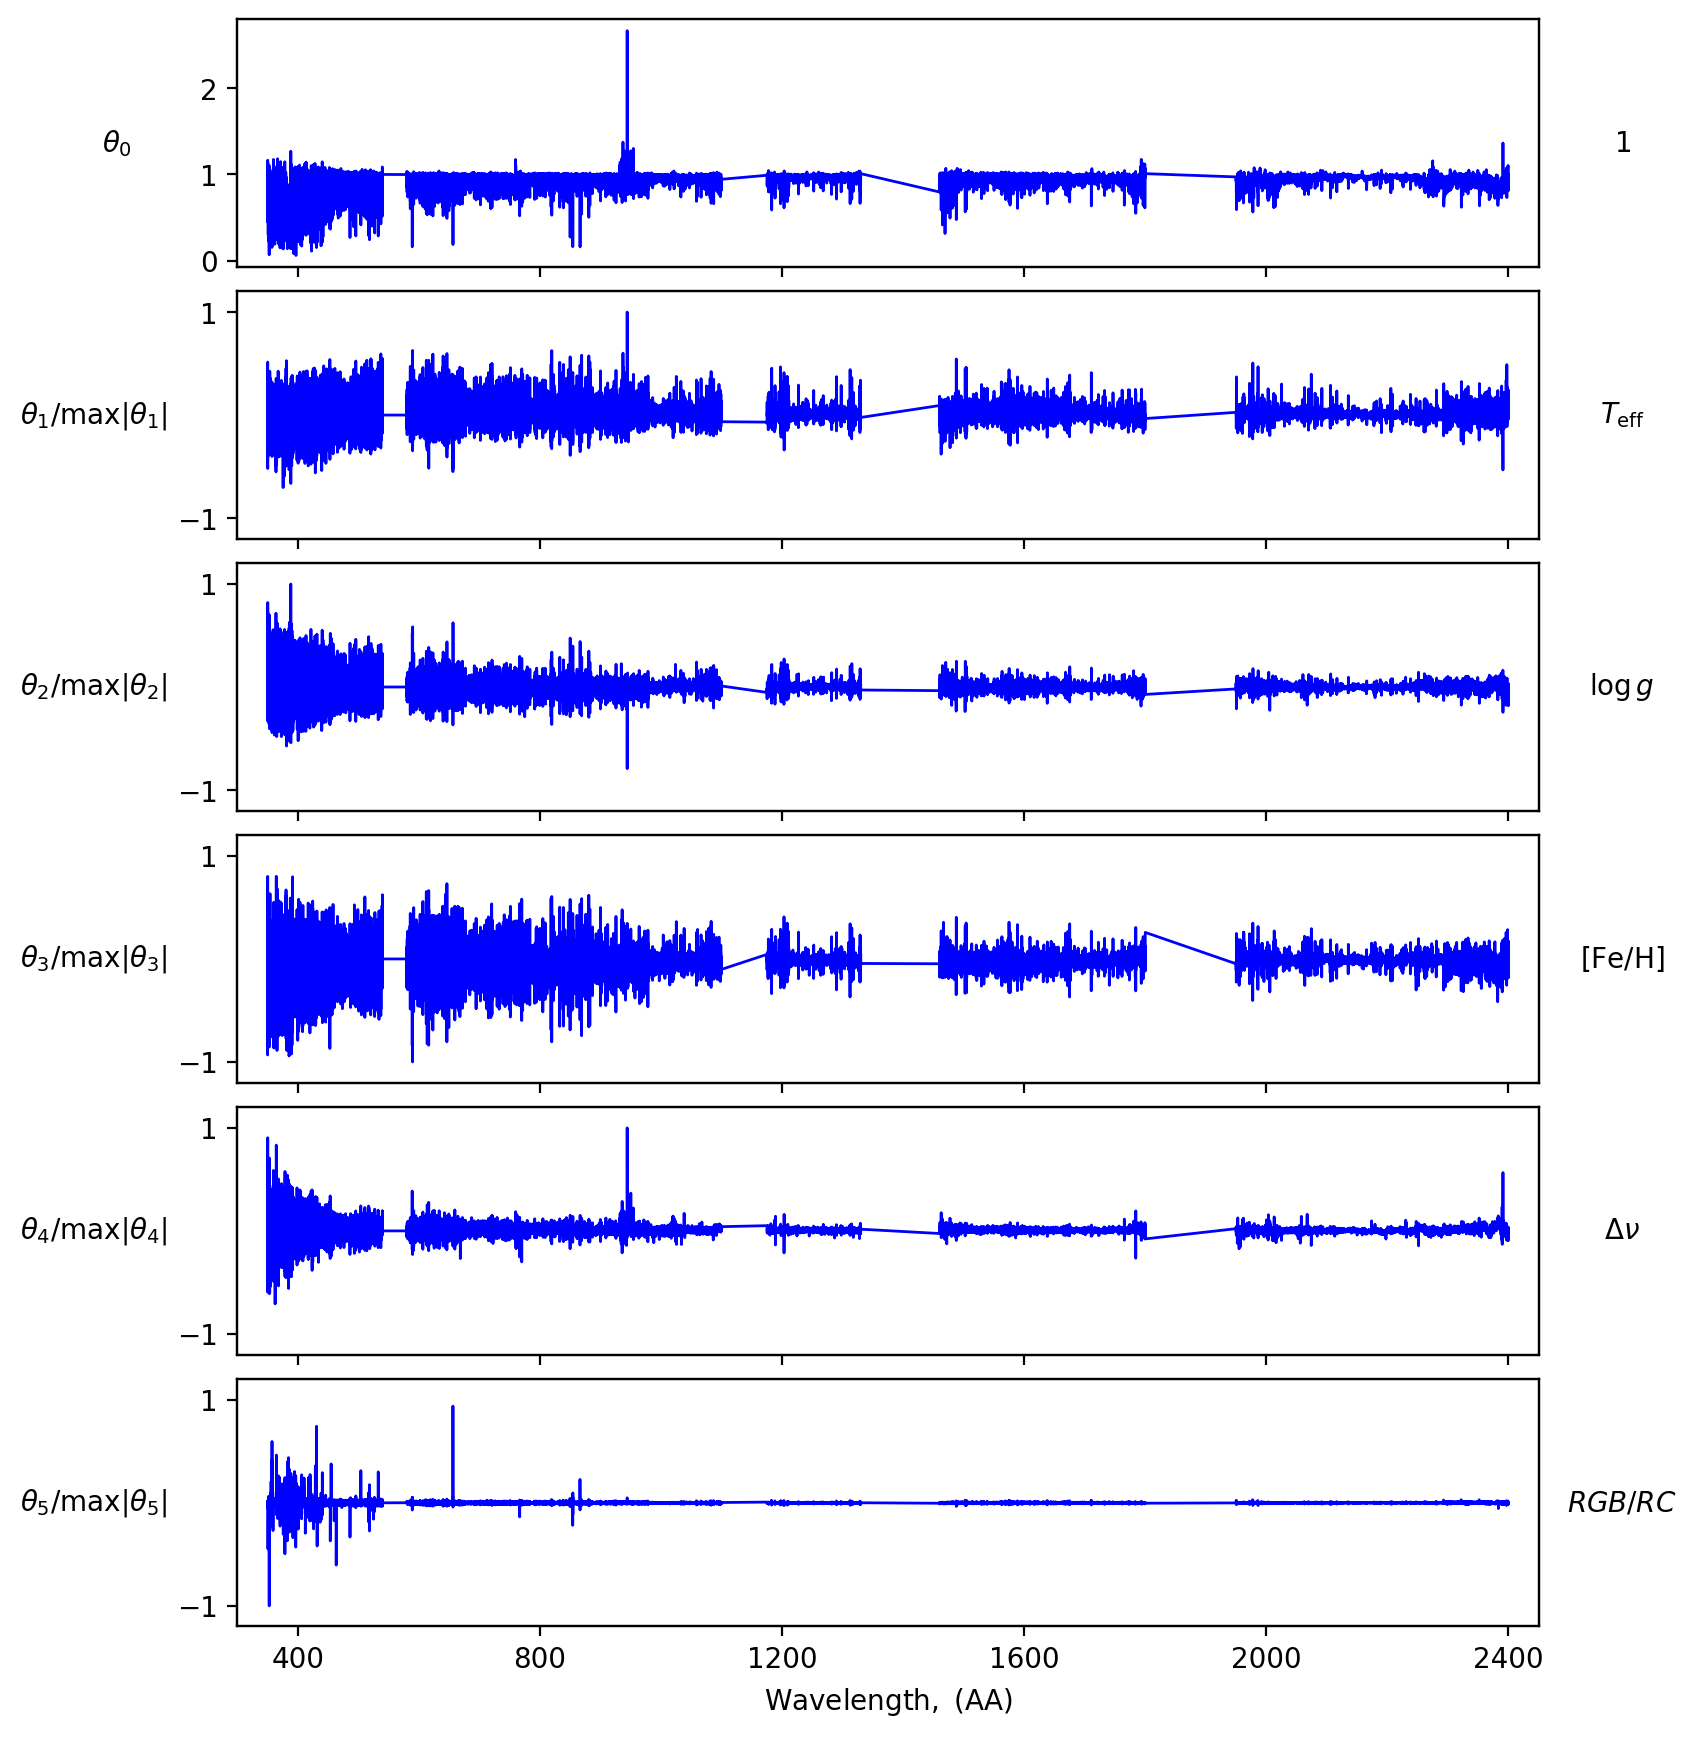

In [471]:
fig_theta = tc.plot.theta(model,
    # Show the first 5 terms in the label vector.
    indices=range(6), xlim=(300, 2450),
    latex_label_names=[
        r"T_{\rm eff}",
        r"\log{g}",
        r"[{\rm Fe}/{\rm H}]",
        r"\Delta\nu",
        r"RGB/RC",
    ])

fig_theta.set_size_inches(10,10)
fig_theta.set_dpi(100)

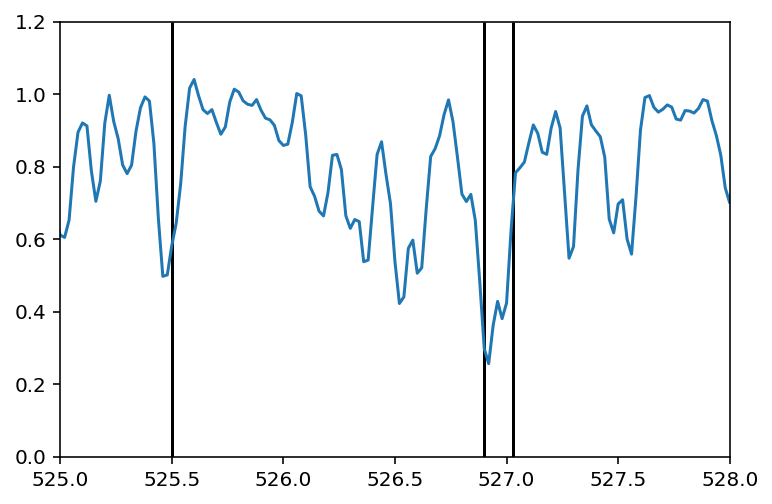

In [493]:
plt.plot(model.dispersion,model.training_set_flux[0])
plt.xlim(525,528)
plt.ylim(0,1.2)
plt.vlines([525.5,526.9,527.03],0,1.2,color='k')

In [528]:
snr = [i['snr'] for i in test_metadata]
len(snr)

49

In [401]:
metadata[0]

{'fvec': array([ 0.        , -0.91666974, -2.55807103, ...,  0.21757752,
         0.06296645,  0.        ]),
 'nfev': 27,
 'njev': 18,
 'fjac': array([[-3.56139414e+03,  2.23625353e-01, -3.51937500e-01, ...,
         -5.63282389e-03, -4.93933612e-03,  0.00000000e+00],
        [-4.23093129e+02, -1.41551988e+03,  2.02698672e-01, ...,
          2.07057583e-03,  8.41686822e-04,  0.00000000e+00],
        [ 6.65856245e+02, -7.10497506e+02, -1.16068834e+03, ...,
         -3.35973448e-03, -1.71912456e-03,  0.00000000e+00],
        [-1.43470210e+02,  7.99839423e+02, -6.90695763e+01, ...,
          3.49227425e-03,  4.58886368e-03,  0.00000000e+00],
        [-5.80101518e+02, -4.61064229e+02,  3.06560882e+02, ...,
          3.63248530e-03,  4.91508950e-03, -0.00000000e+00]]),
 'ipvt': array([4, 2, 3, 1, 5], dtype=int32),
 'qtf': array([ 1.36676784e-07, -3.63034119e-07,  1.35281446e-07, -1.25362922e-06,
        -1.49038412e-07]),
 'x0': array([ 4.71309325e+03,  2.45100000e+00, -1.77633290e-01,  4.8

(array([ 1.,  1.,  1.,  9.,  6., 10.,  8., 10.,  3.,  1.]),
 array([35.90882507, 39.48495538, 43.0610857 , 46.63721602, 50.21334633,
        53.78947665, 57.36560697, 60.94173728, 64.5178676 , 68.09399791,
        71.67012823]),
 <BarContainer object of 10 artists>)

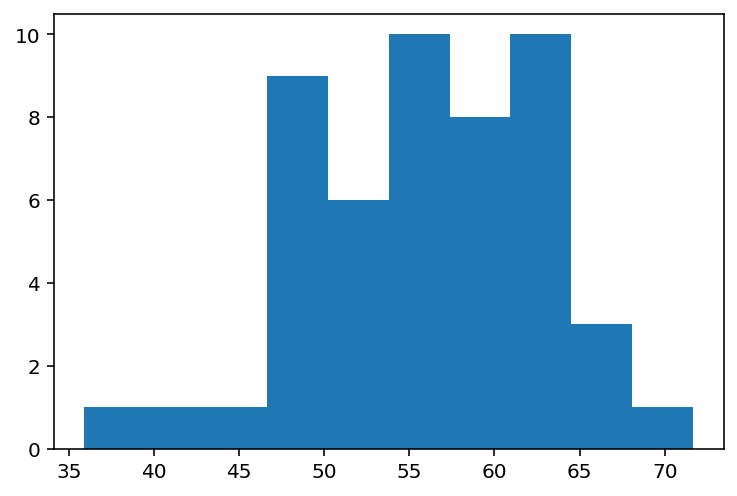

In [495]:
plt.hist(snr)

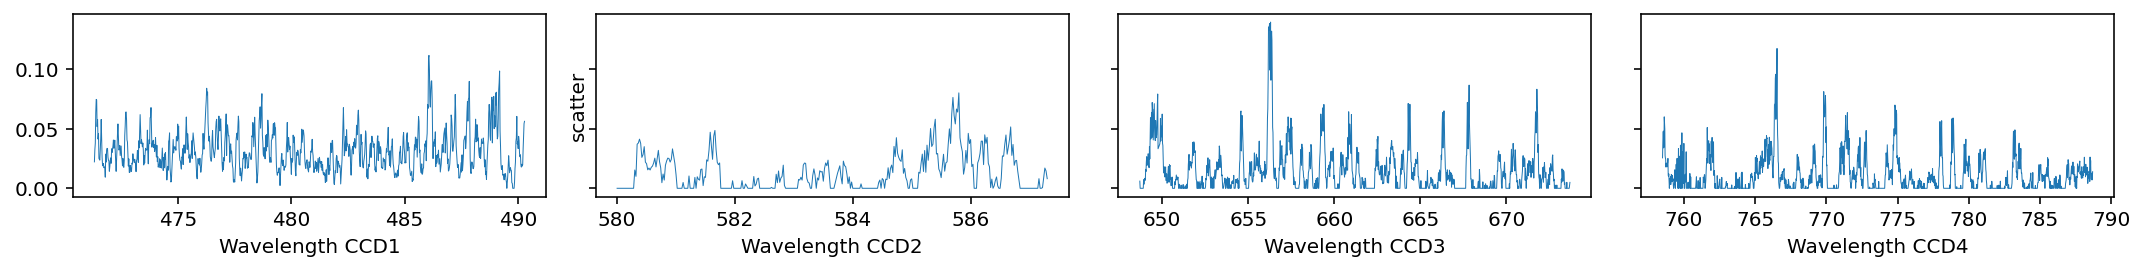

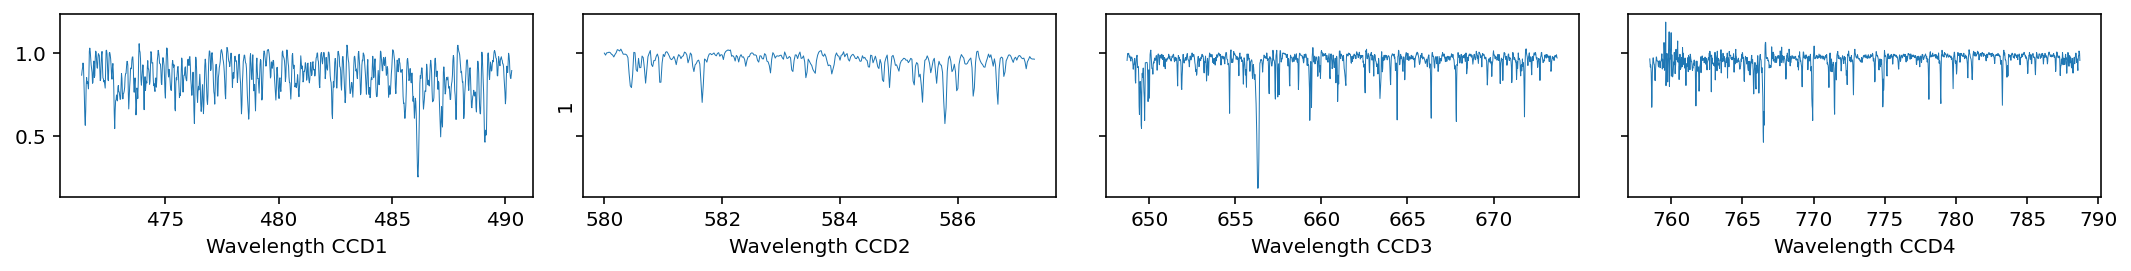

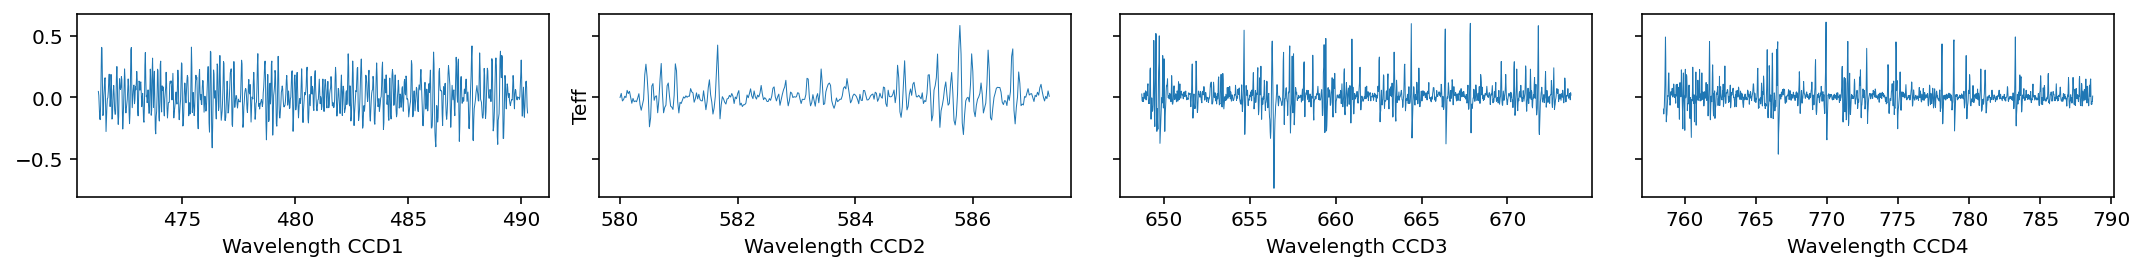

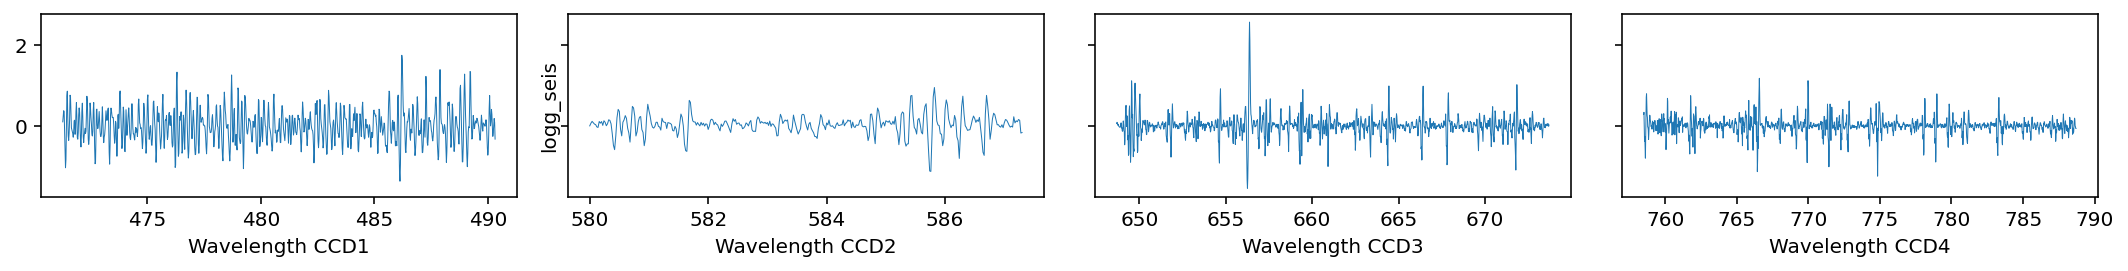

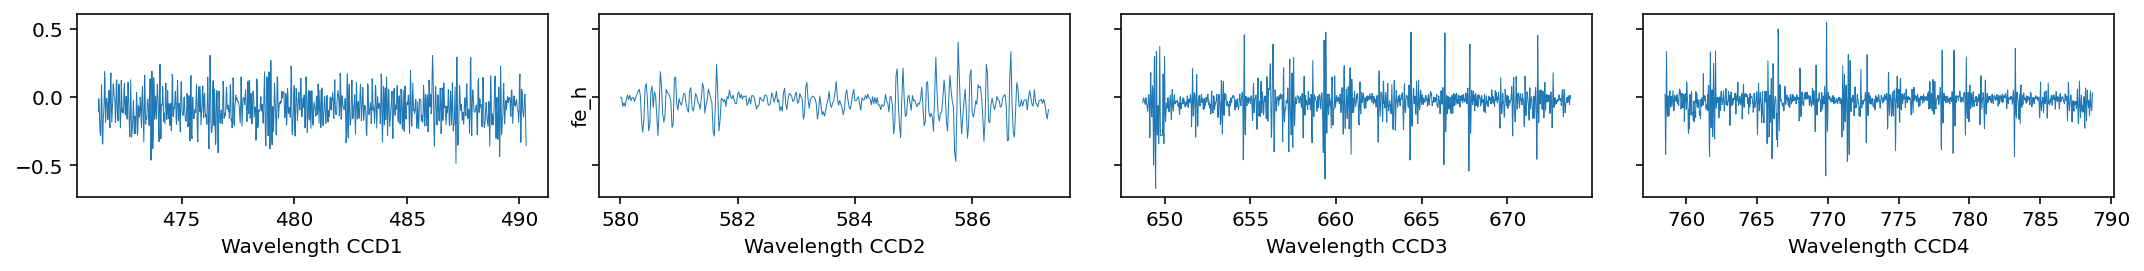

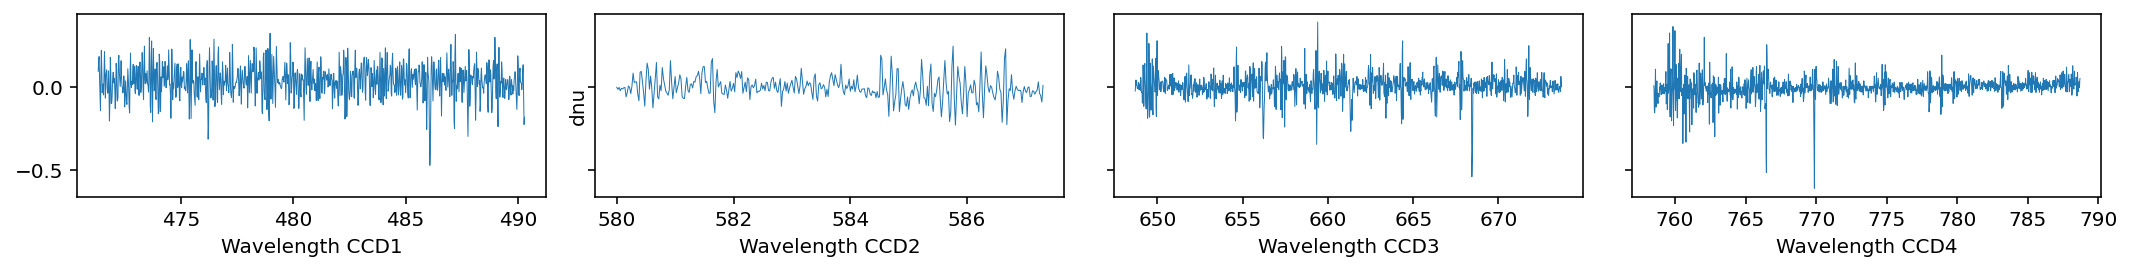

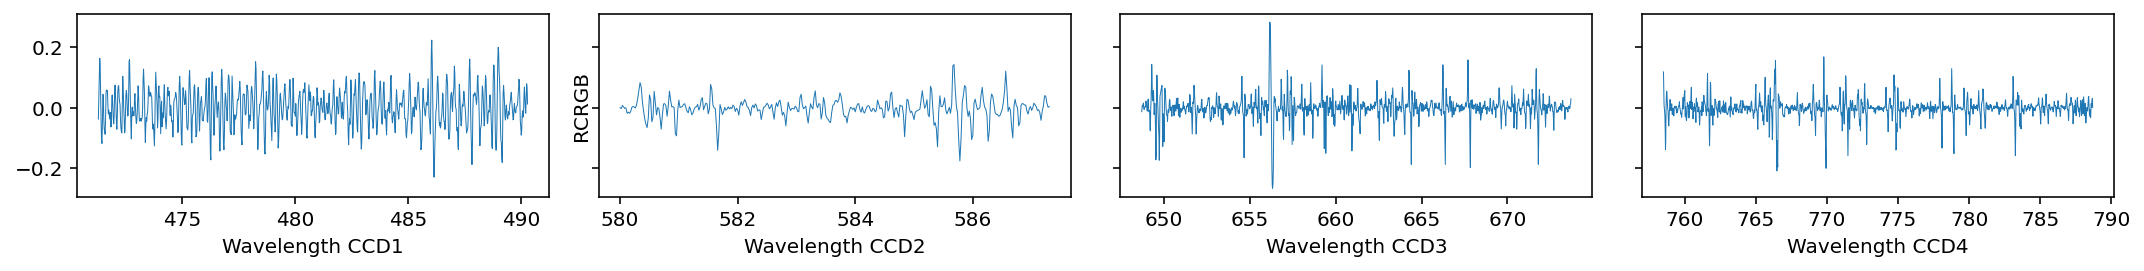

In [519]:
# Plot coefficients

def plot_coefficients(model, index, ccds=galah, wavelength_array = None):
    
    if index == -1:
        ylabel = 'scatter'
    else:
        ylabel = model.vectorizer.get_human_readable_label_term(index,
                    label_names = model.vectorizer.label_names, mul='\cdot', pow='^')
        
    f, gs = plt.subplots(1,len(ccds),figsize=(15,2),sharey=True)
    
    for i in range(len(ccds)):
        ax = gs[i]
        
        in_wavelength_range = (wavelength_array >= ccds[i][0]) & (wavelength_array <= ccds[i][1])
        
        if index == -1:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.s2[in_wavelength_range]**0.5,
                lw=0.5,c='C0'
            )
        else:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.theta[in_wavelength_range,index],
                lw=0.5,c='C0',label='TheCannon'
            )
        ax.set_xlabel('Wavelength CCD'+str(i+1))
        
        if i==1:
            ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.savefig('coefficient_plots/coeff_'+model_file+'_'+ylabel+'.png',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
    
for index in range(-1,len(labels)+1):
    plot_coefficients(model, index, ccds=galah, wavelength_array=wave)

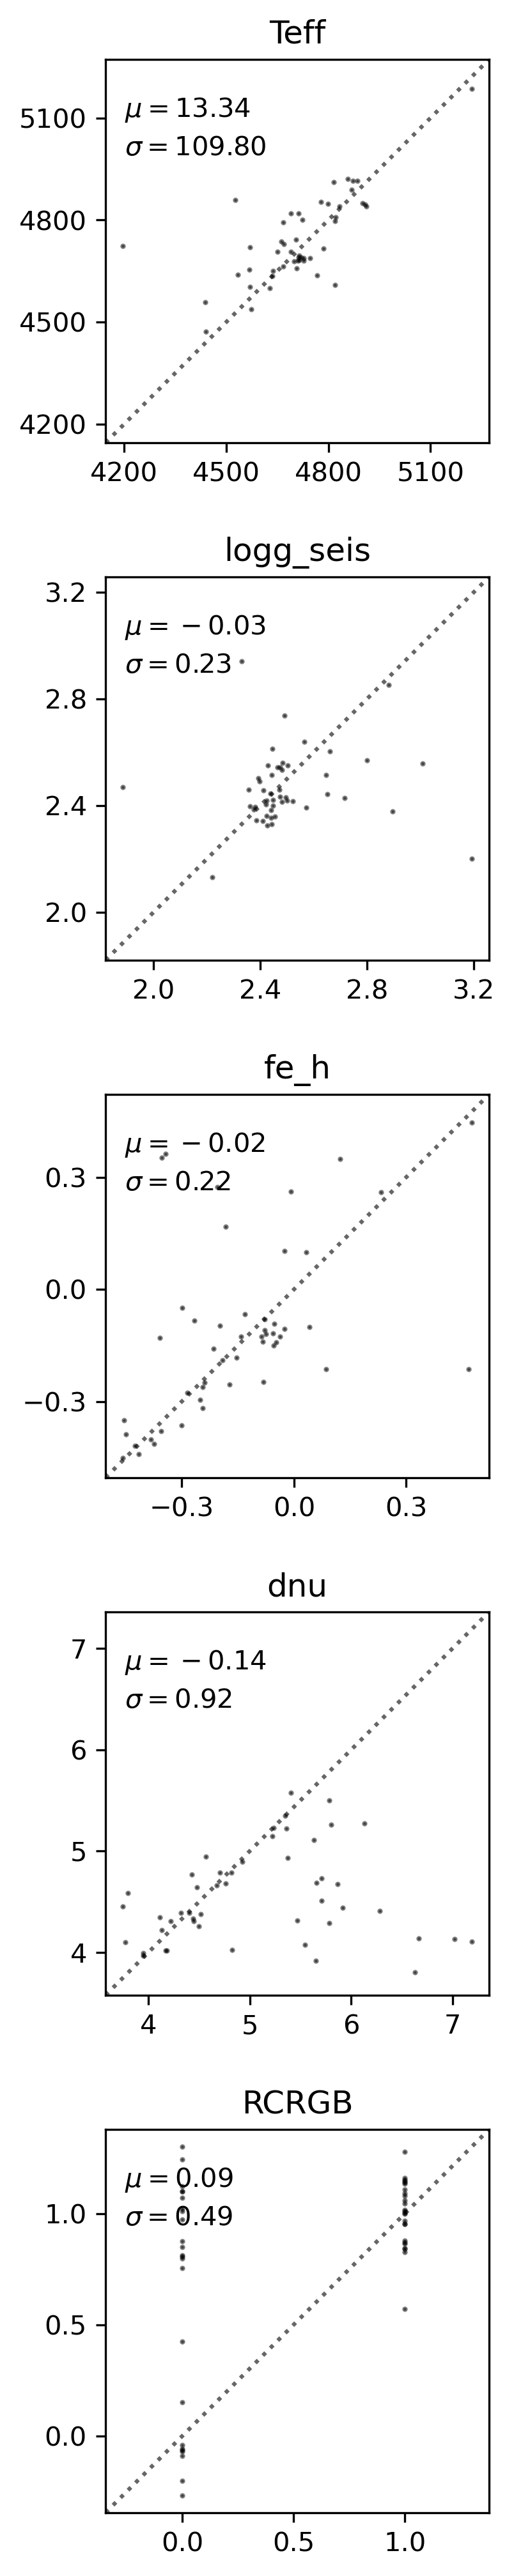

In [523]:
fig_comparison = tc.plot.one_to_one(model, test_labels)
fig_comparison.set_dpi(150)

In [405]:
# model.vectorizer.get_human_readable_label_vector()
model.vectorizer.get_human_readable_label_term(4)

'dnu'

In [406]:
model.is_trained

True

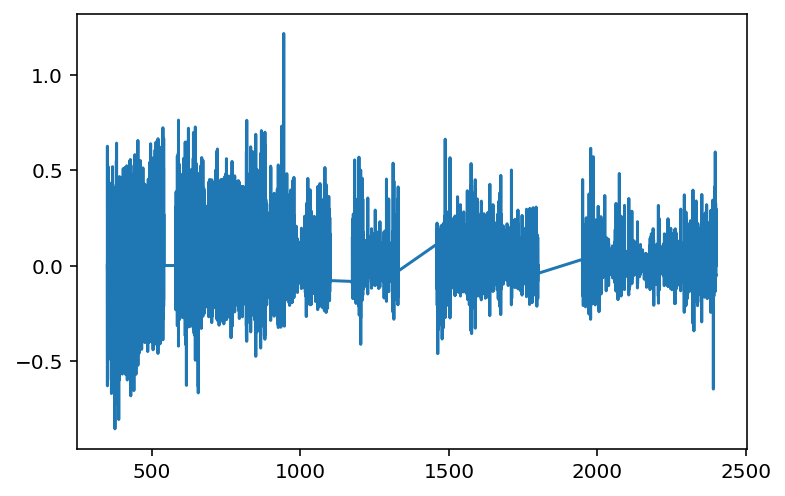

In [407]:
plt.plot(model.dispersion,model.theta[:,1])
# plt.ylim(-0.1,0.4)

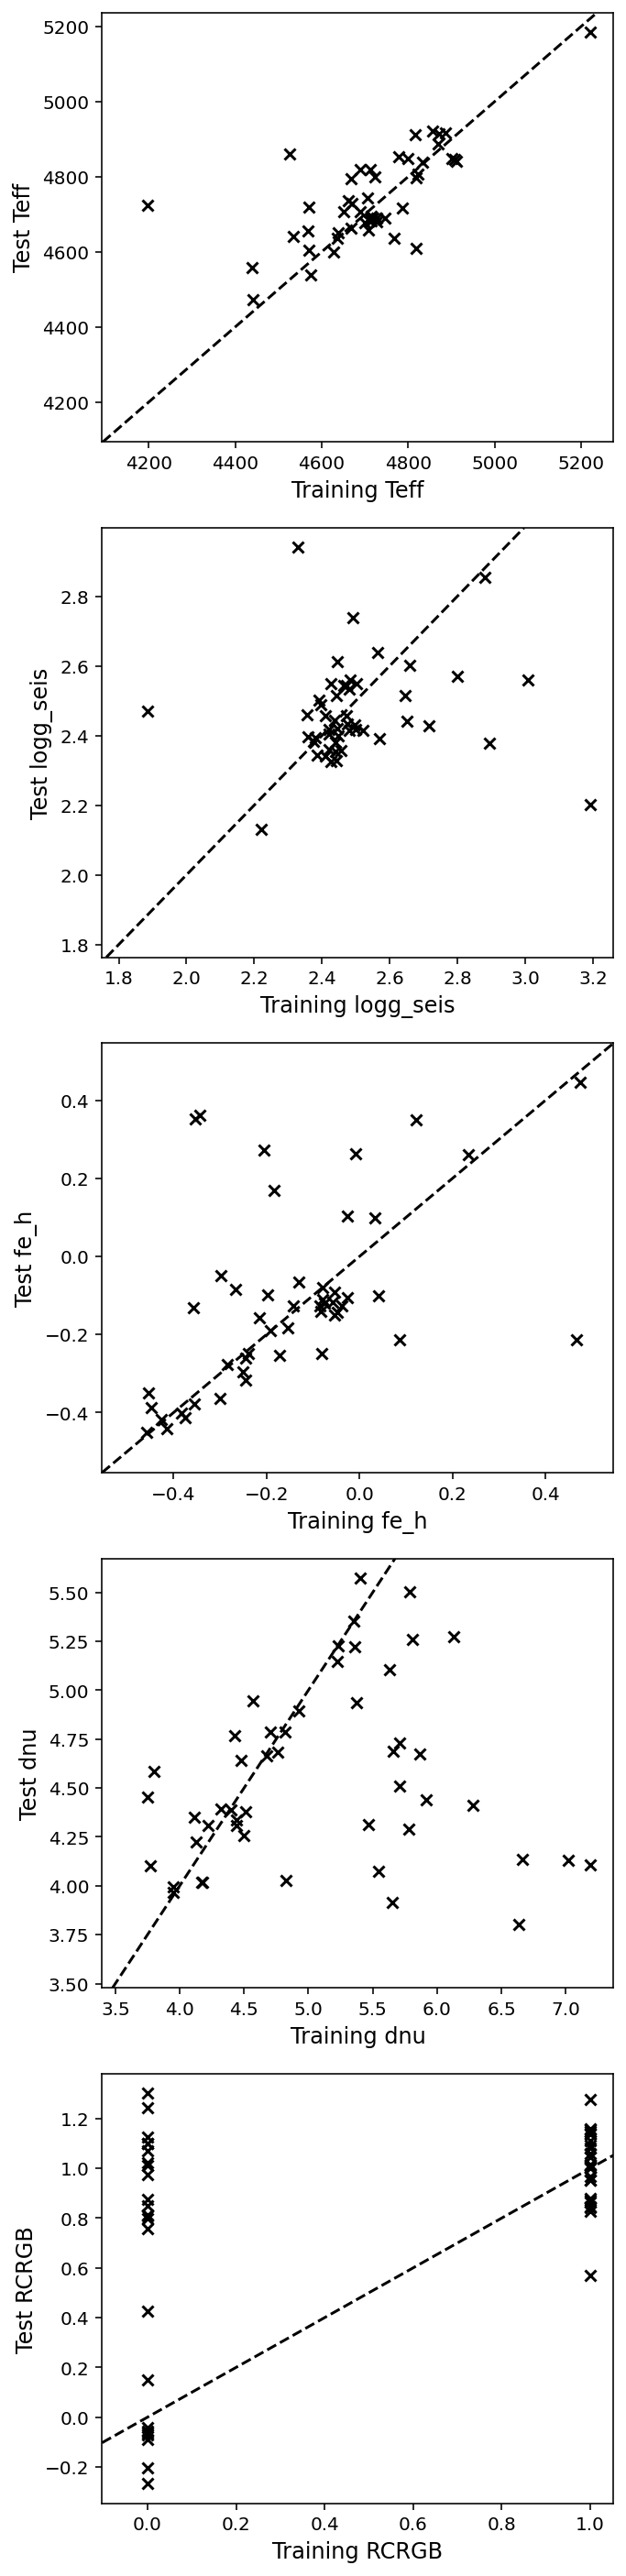

In [524]:
fig, ax = plt.subplots(test_labels.shape[-1],1,figsize=(5,5*test_labels.shape[-1]))

for i in range(test_labels.shape[-1]):
    ax[i].scatter(model.training_set_labels[:,i],test_labels[:,i],marker='x',c='k')
    ax[i].set_xlabel(f'Training {labels[i]}',fontsize=12)
    ax[i].set_ylabel(f'Test {labels[i]}',fontsize=12)
    ax[i].axline((ax[i].get_xlim()[0],ax[i].get_xlim()[0]),(ax[i].get_xlim()[0]+1,ax[i].get_xlim()[0]+1),color='k',linestyle='--')
# ax[0].get_xlim()[0]

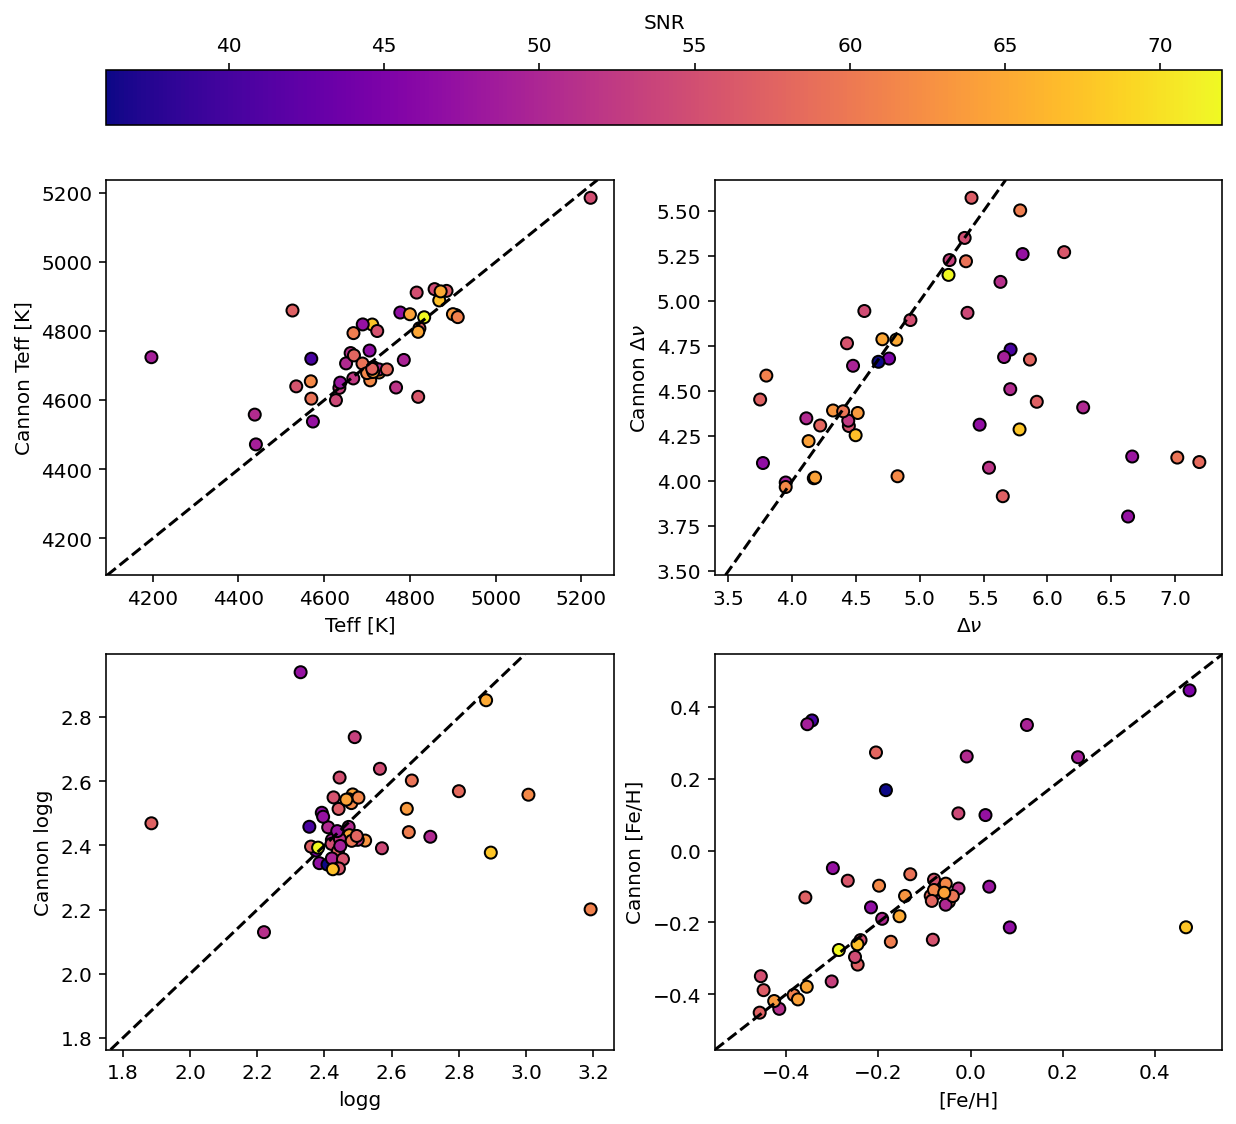

In [529]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

im = ax[0,0].scatter(model.training_set_labels[:,0],test_labels[:,0],c=snr,cmap='plasma',edgecolors='k') # Teff
ax[0,0].axline((ax[0,0].get_xlim()[0],ax[0,0].get_xlim()[0]),(ax[0,0].get_xlim()[0]+1,ax[0,0].get_xlim()[0]+1),color='k',linestyle='--')
ax[0,0].set_xlabel("Teff [K]")
ax[0,0].set_ylabel("Cannon Teff [K]")

ax[0,1].scatter(model.training_set_labels[:,3],test_labels[:,3],c=snr,cmap='plasma',edgecolors='k') # dnu
ax[0,1].axline((ax[0,1].get_xlim()[0],ax[0,1].get_xlim()[0]),(ax[0,1].get_xlim()[0]+1,ax[0,1].get_xlim()[0]+1),color='k',linestyle='--')
ax[0,1].set_xlabel("$\Delta\\nu$")
ax[0,1].set_ylabel("Cannon $\Delta\\nu$")

ax[1,0].scatter(model.training_set_labels[:,1],test_labels[:,1],c=snr,cmap='plasma',edgecolors='k') # logg
ax[1,0].axline((ax[1,0].get_xlim()[0],ax[1,0].get_xlim()[0]),(ax[1,0].get_xlim()[0]+1,ax[1,0].get_xlim()[0]+1),color='k',linestyle='--')
ax[1,0].set_xlabel("logg")
ax[1,0].set_ylabel("Cannon logg")

ax[1,1].scatter(model.training_set_labels[:,2],test_labels[:,2],c=snr,cmap='plasma',edgecolors='k') # [Fe/H]
ax[1,1].axline((ax[1,1].get_xlim()[0],ax[1,1].get_xlim()[0]),(ax[1,1].get_xlim()[0]+1,ax[1,1].get_xlim()[0]+1),color='k',linestyle='--')
ax[1,1].set_xlabel("[Fe/H]")
ax[1,1].set_ylabel("Cannon [Fe/H]")

# cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
# cbar = fig.colorbar(im, cax=cb_ax)

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=1, location='top')
cbar.set_label("SNR")

### Hawkins et al. (2017) Fig 4 recreation

Text(0, 0.5, 'logg')

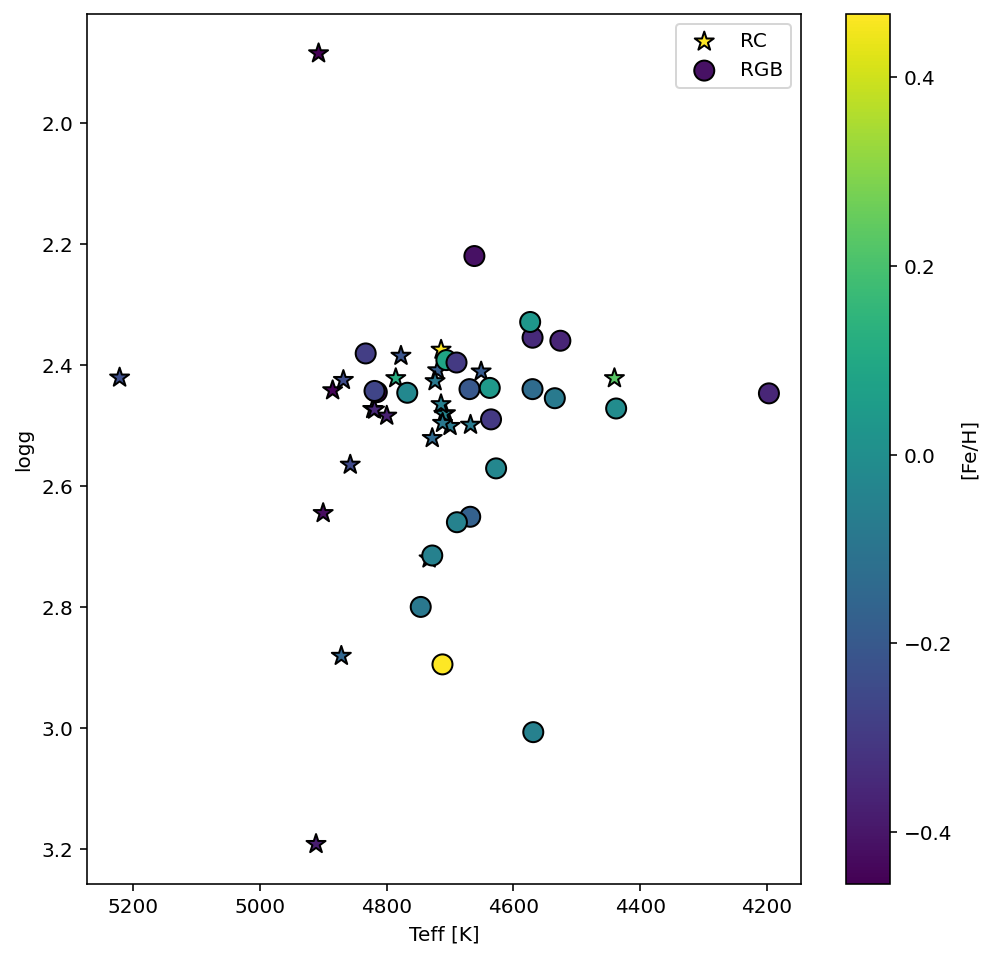

In [530]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

im = ax.scatter(x='Teff',y='logg_seis',c='fe_h',data=df_train[df_train['type']=='RC'],edgecolor='k',s=100,label='RC',marker='*')
im = ax.scatter(x='Teff',y='logg_seis',c='fe_h',data=df_train[df_train['type']=='RGB'],edgecolor='k',s=100,label='RGB',marker='o')
ax.legend()
cbar = plt.colorbar(im,label='[Fe/H]')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel("Teff [K]")
ax.set_ylabel("logg")

In [448]:
model.vectorizer.terms

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(0, 2.0)],
 [(0, 1), (1, 1)],
 [(0, 1), (2, 1)],
 [(0, 1), (3, 1)],
 [(4, 1), (0, 1)],
 [(1, 2.0)],
 [(2, 1), (1, 1)],
 [(3, 1), (1, 1)],
 [(4, 1), (1, 1)],
 [(2, 2.0)],
 [(3, 1), (2, 1)],
 [(4, 1), (2, 1)],
 [(3, 2.0)],
 [(4, 1), (3, 1)],
 [(4, 2.0)]]

Text(0, 0.5, 'dnu')

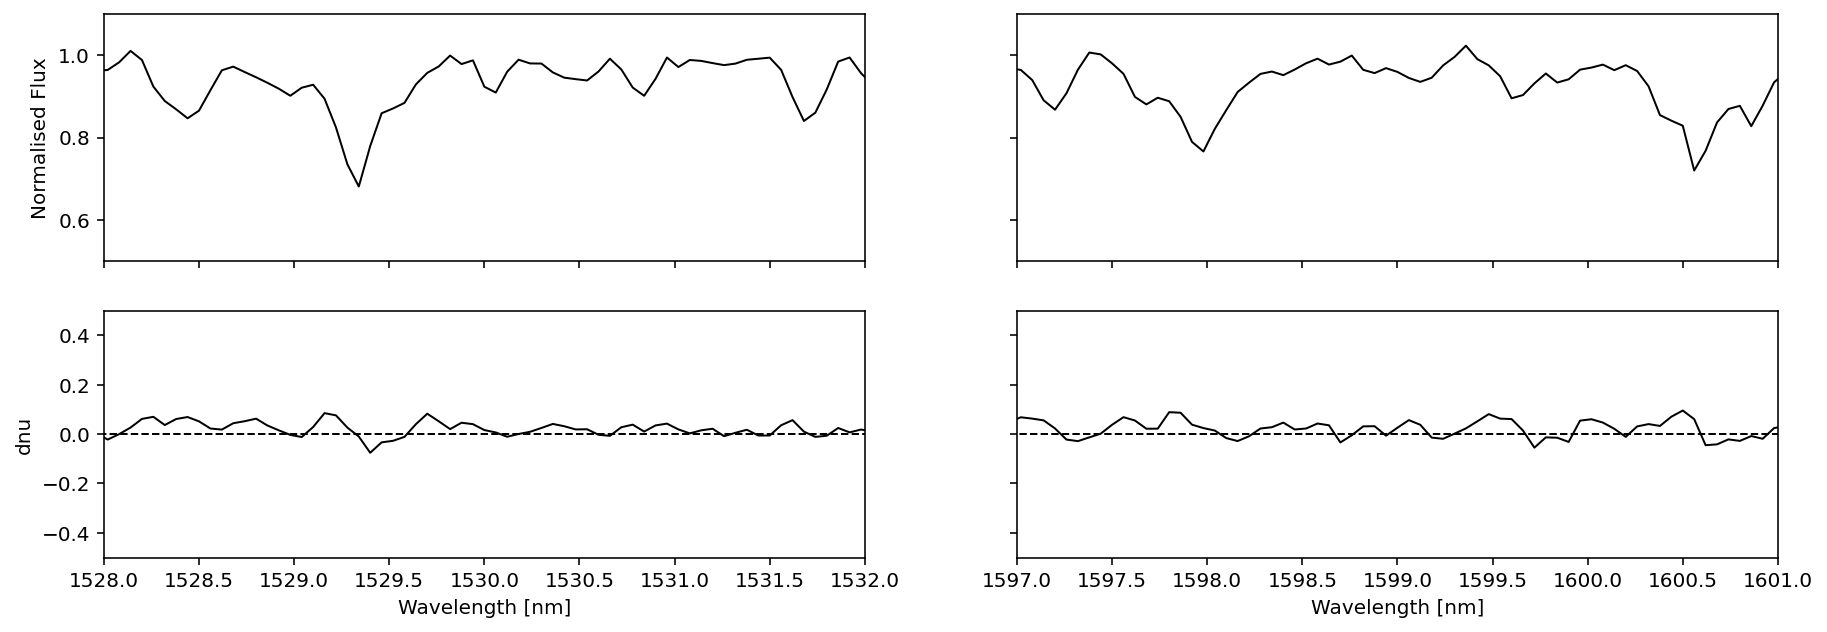

In [588]:
index = 4
fig, ax = plt.subplots(2,2,figsize=(15,5),sharex='col',sharey='row')
for i in range(2):
    ax[0,i].plot(wave,model.training_set_flux[0],'k',lw=1)
    ax[0,i].set_ylim(0.5,1.1)
    ax[1,i].plot(wave,model.theta[:,index],'k',lw=1)
    ax[1,i].hlines(y=0,xmin=1000,xmax=2000,ls='dashed',color='k',lw=1)
    ax[1,i].set_ylim(-0.5,0.5)
    ax[1,i].set_xlabel("Wavelength [nm]")
    
ax[1,0].set_xlim(1528,1532)
ax[1,1].set_xlim(1597,1601)
ax[0,0].set_ylabel("Normalised Flux")
ax[1,0].set_ylabel(f"{model.vectorizer.get_human_readable_label_term(index)}")

### Checking out asteroseismic parameters

In [326]:
c4 = pd.read_table('C:/Users/Kirsten Banks/OneDrive - UNSW/Projects/Xshooter/Cannon/c4_data.txt',delim_whitespace=True,skiprows=[1,17])
astero = pd.read_csv('C:/Users/Kirsten Banks/OneDrive - UNSW/Projects/Xshooter/Cannon/Claudia_SYD-Dnu-Vetting_v17_April_p0.5threshold.csv')
m67 = pd.read_table('C:/Users/Kirsten Banks/OneDrive - UNSW/Projects/Xshooter/Cannon/m67-data.txt',skiprows=[1,6])

m67.columns = ['EPIC-ID','K','RA','DEC','Teff','logg','mass','numax','dnu','1','2','3']
m67 = m67.drop(columns=['1','2','3'])

In [338]:
ids = np.concatenate([EPIC_astero['ID'],c4['EPIC-ID'],m67['EPIC-ID']])
len(ids),len(set(ids))

(85, 57)

In [334]:
c4.columns,m67.columns,astero.columns

(Index(['EPIC-ID', '2MASS-ID', 'RA', 'DEC', 'Kmag', 'Teff', 'Log(g)_seis',
        'Log(g)_spec', 'Fe/H', 'Mass', 'numax', 'dnu'],
       dtype='object'),
 Index(['EPIC-ID', 'K', 'RA', 'DEC', 'Teff', 'logg', 'mass', 'numax', 'dnu'], dtype='object'),
 Index(['ID', 'camp', 'numax', 'numax_sig', 'dnu', 'dnu_sig', 'maxamp',
        'maxamp_sig', 'dnu_label', 'dnu_prob', 'RCRGB', 'RC_Prob', 'goodnumax',
        'outlier'],
       dtype='object'))

In [341]:
star_ids = [int(i.split("-")[-1]) for i in stars]
EPIC_astero = astero[astero['ID'].isin(star_ids)].reset_index(drop=True)
EPIC_c4 = c4[c4['EPIC-ID'].isin(star_ids)].reset_index(drop=True)

In [343]:
EPIC_c4[EPIC_c4['EPIC-ID'].isin(EPIC_astero['ID'])].shape,EPIC_c4.shape

((22, 12), (22, 12))

In [575]:
mutual_astero = EPIC_astero[EPIC_astero['ID'].isin(EPIC_c4['EPIC-ID'])]
# mutual_astero.sort_values('ID')
print(f"RC:  {df_train[df_train['type']=='RC'].shape[0]}\nRGB: {df_train[df_train['type']=='RGB'].shape[0]}")

RC:  25
RGB: 24


Index(['ID', 'camp', 'numax', 'numax_sig', 'dnu', 'dnu_sig', 'maxamp',
       'maxamp_sig', 'dnu_label', 'dnu_prob', 'RCRGB', 'RC_Prob', 'goodnumax',
       'outlier'],
      dtype='object')

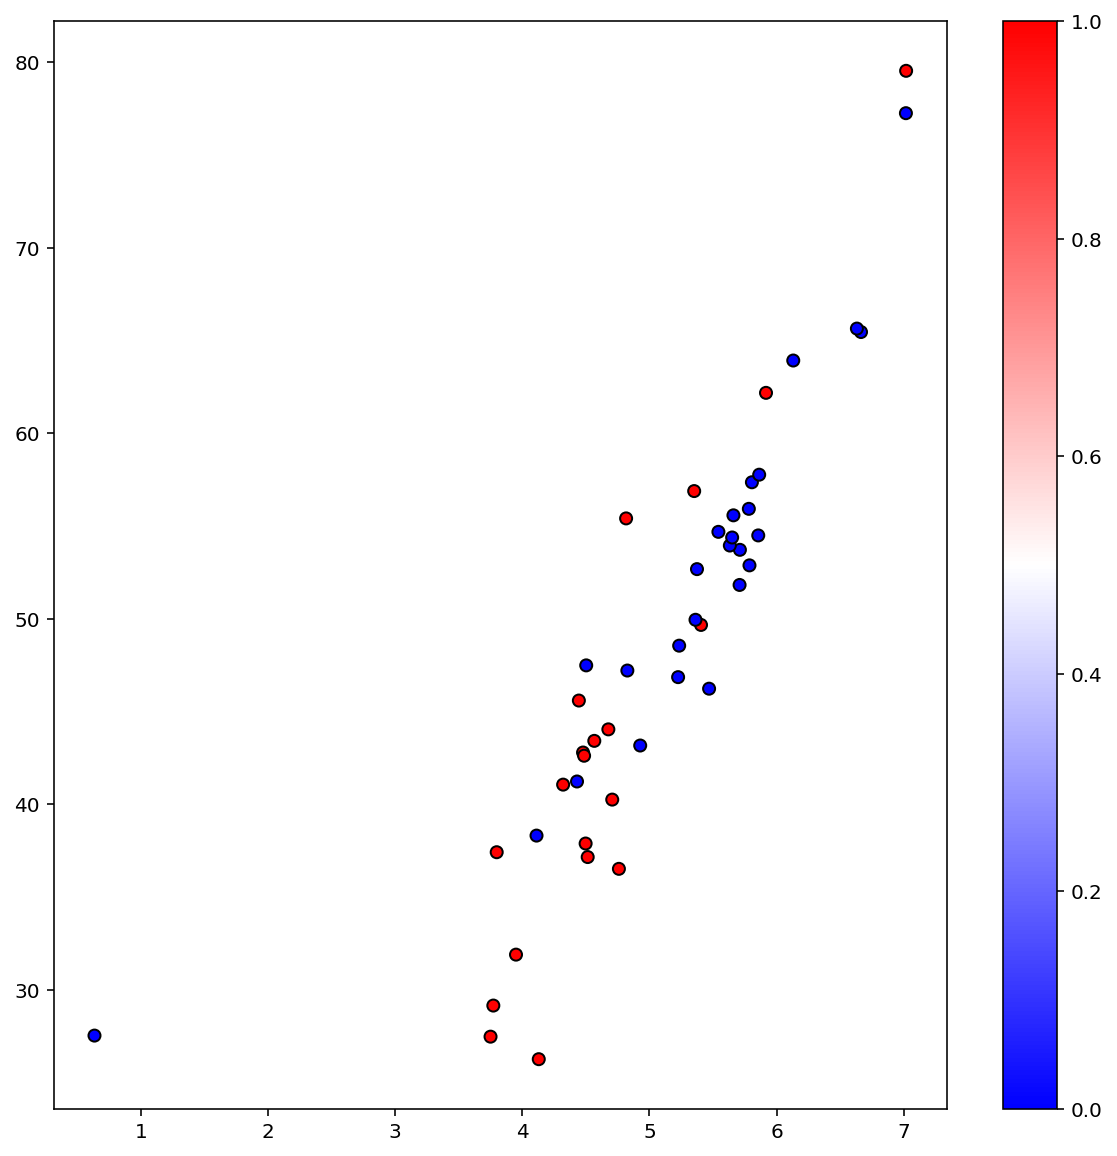

In [291]:
fig, axes = plt.subplots(1,1,figsize=(10,10))

im = axes.scatter(x='dnu',y='numax',data=EPIC_astero,c='RCRGB',cmap='bwr',edgecolor='k')
cbar = plt.colorbar(im)

astero.columns

In [499]:
c4.dnu.describe(),m67.dnu.describe(),EPIC_astero.dnu.describe()

(count    29.000000
 mean      5.353517
 std       0.689796
 min       4.400000
 25%       4.728000
 50%       5.288000
 75%       5.848000
 max       6.633000
 Name: dnu, dtype: float64,
 count    10.00000
 mean      5.06400
 std       1.25501
 min       3.95000
 25%       4.19000
 50%       4.42000
 75%       5.91250
 max       7.19000
 Name: dnu, dtype: float64,
 count    46.000000
 mean      5.062929
 std       1.068943
 min       0.634110
 25%       4.488677
 50%       5.229425
 75%       5.710800
 max       7.018920
 Name: dnu, dtype: float64)

In [500]:
EPIC_astero[EPIC_astero['dnu']<1]

ID  camp     numax  numax_sig      dnu  dnu_sig    maxamp  \
2  201372972     1  27.52043    1.96389  0.63411  3.18183  129.8434   

   maxamp_sig  dnu_label  dnu_prob  RCRGB  RC_Prob  goodnumax  outlier  
2      8.6563          0  0.000486    0.0     0.07      False     True